In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from numba import njit
from tqdm import tqdm
import time
import multiprocessing
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import seaborn as sns
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{lmodern} \boldmath'

# EoS

6 = Strange matter (MIT Bag model) with crust

10 = SLy4 (Douchin & Haensel 2001)

11 = FPS (Friedman-Pandharipande + Skyrme)

12 = BPAL12 (Bombaci et al. 1995)

13 = AkmalPR (Akmal, Pandharipande & Ravenhall 1998)

14 = BBB2 (Baldo, Bombaci & Burgio 1997)

15 = BalbN1H1 (Balberg 2000)

16 = GlendNH3 (Glendenning 1985, case 3)

17 = Tabulated EOS in CompOSE format

# Creating output tables

In [2]:
# Base directory where all the folders are located
base_dir = "/home/sanjana/apps/Lorene/Codes/"

# List of folder names
folders = [
    "Nrotstar_(APR100)_(0.06-0.9)_2513Hz",
    "Nrotstar_(BBB100)_(0.05-0.8)_2513Hz",
    "Nrotstar_(BPAL100)_(0.06-0.6)_2513Hz",
    "Nrotstar_(FPS100)_(0.04-0.9)_2513Hz",
    "Nrotstar_(Glendenning100)_(0.06-0.68)_2513Hz",
    "Nrotstar_(SLy100)_(0.04-0.9)_2513Hz",
    "Nrotstar_(Balberg100)_(0.08-0.7)_2513Hz"
]

# Define the quantities to extract and their corresponding regex patterns
patterns = {
    "Central enthalpy": r"Central enthalpy\s*:\s*([\d.eE+-]+) c\^2",
    "Central proper baryon density": r"Central proper baryon density\s*:\s*([\d.eE+-]+) x 0.1 fm\^-3",
    "Central proper energy density": r"Central proper energy density\s*:\s*([\d.eE+-]+) rho_nuc c\^2",
    "Central pressure": r"Central pressure\s*:\s*([\d.eE+-]+) rho_nuc c\^2",
    "Coordinate equatorial radius": r"Coordinate equatorial radius \(phi=0\) a1\s*=\s*([\d.eE+-]+) km",
    "Coordinate polar radius": r"Coordinate polar radius a3\s*=\s*([\d.eE+-]+) km",
    "Baryon mass": r"Baryon mass\s*:\s*([\d.eE+-]+) M_sol",
    "Gravitational mass": r"Gravitational mass\s*:\s*([\d.eE+-]+) M_sol",
    "Omega": r"Omega\s*:\s*([\d.eE+-]+) rad/s",
    "f": r"f\s*:\s*([\d.eE+-]+) Hz",
    "Rotation period": r"Rotation period\s*:\s*([\d.eE+-]+) ms",
    "Compactness": r"Compactness G M_g /\(c\^2 R_circ\)\s*:\s*([\d.eE+-]+)",
    "Quadrupole moment Q": r"Quadrupole moment Q\s*:\s*([\d.eE+-]+) 10\^38 kg m\^2",
    "Angular momentum J": r"Angular momentum J\s*:\s*([\d.eE+-]+) G M_sol\^2 / c",
    "Moment of inertia": r"Moment of inertia\s*:\s*([\d.eE+-]+) 10\^38 kg m\^2",
    "Circumferential equatorial radius": r"Circumferential equatorial radius R_circ\s*:\s*([\d.eE+-]+) km",
    "Circumferential polar radius": r"Circumferential polar \(meridional\) radius R_circ_merid\s*:\s*([\d.eE+-]+) km",
    "Surface area": r"Surface area\s*:\s*([\d.eE+-]+) km\^2",
    "Mean radius": r"Mean radius\s*:\s*([\d.eE+-]+) km",
    "Coordinate equatorial radius r_eq": r"Coordinate equatorial radius r_eq\s*:\s*([\d.eE+-]+) km",
    "Redshift at the equator (forward)": r"Redshift at the equator \(forward\)\s*:\s*([\d.eE+-]+)",
    "Redshift at the equator (backward)": r"Redshift at the equator \(backward\)\s*:\s*([\d.eE+-]+)",
    "Redshift at the pole": r"Redshift at the pole\s*:\s*([\d.eE+-]+)"
}

# Process each folder
for folder_name in folders:
    folder_path = os.path.join(base_dir, folder_name)
    output_csv = f"{folder_name}_extracted_data.csv"

    # Prepare CSV file
    with open(output_csv, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)

        # Write the header row
        header = ["File"] + list(patterns.keys())
        writer.writerow(header)

        # Loop through all files in the range calcul0000.d to calcul0099.d
        for i in range(100):
            filename = f"calcul{str(i).zfill(4)}.d"
            file_path = os.path.join(folder_path, filename)

            # Check if the file exists before trying to read it
            if os.path.exists(file_path):
                with open(file_path, "r") as file:
                    content = file.read()

                # Extract values using regex
                data_row = [filename]  # Start with filename
                for key, pattern in patterns.items():
                    match = re.search(pattern, content)
                    data_row.append(match.group(1) if match else "N/A")  # Store extracted value or "N/A" if not found

                # Write data to CSV
                writer.writerow(data_row)

    print(f"Extraction complete! Data saved in {output_csv}.")

Extraction complete! Data saved in Nrotstar_(APR100)_(0.06-0.9)_2513Hz_extracted_data.csv.
Extraction complete! Data saved in Nrotstar_(BBB100)_(0.05-0.8)_2513Hz_extracted_data.csv.
Extraction complete! Data saved in Nrotstar_(BPAL100)_(0.06-0.6)_2513Hz_extracted_data.csv.
Extraction complete! Data saved in Nrotstar_(FPS100)_(0.04-0.9)_2513Hz_extracted_data.csv.
Extraction complete! Data saved in Nrotstar_(Glendenning100)_(0.06-0.68)_2513Hz_extracted_data.csv.
Extraction complete! Data saved in Nrotstar_(SLy100)_(0.04-0.9)_2513Hz_extracted_data.csv.
Extraction complete! Data saved in Nrotstar_(Balberg100)_(0.08-0.7)_2513Hz_extracted_data.csv.


# Plotting relevant quantities

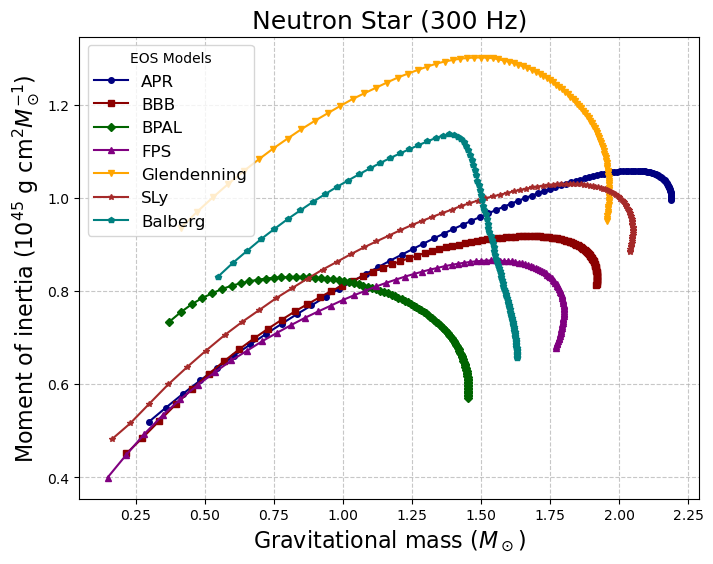

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Dictionary for pretty axis labels
units = {
    "Gravitational mass": r"Gravitational mass ($M_\odot$)",
    "Moment of inertia / Mass": r"Moment of inertia (10$^{45}$ g cm$^2 M_\odot^{-1}$)"
}

# Define colors and markers for distinction
colors = ["navy", "darkred", "darkgreen", "purple", "orange", "brown", "teal"]
markers = ["o", "s", "D", "^", "v", "*", "p"]
marker_size = 4  # Reduced marker size

# List of EOS files and their labels
eos_files = {
    "300 Hz": {
        "APR": "Nrotstar_(APR100)_(0.06-0.9)_300Hz_extracted_data.csv",
        "BBB": "Nrotstar_(BBB100)_(0.05-0.8)_300Hz_extracted_data.csv",
        "BPAL": "Nrotstar_(BPAL100)_(0.06-0.6)_300Hz_extracted_data.csv",
        "FPS": "Nrotstar_(FPS100)_(0.04-0.9)_300Hz_extracted_data.csv",
        "Glendenning": "Nrotstar_(Glendenning100)_(0.06-0.68)_300Hz_extracted_data.csv",
        "SLy": "Nrotstar_(SLy100)_(0.04-0.9)_300Hz_extracted_data.csv",
        "Balberg": "Nrotstar_(Balberg100)_(0.08-0.7)_300Hz_extracted_data.csv"
    }
}

# Extract and plot Moment of Inertia / Mass vs. Mass
for frequency, files in eos_files.items():
    plt.figure(figsize=(8, 6))

    for (eos, file), color, marker in zip(files.items(), colors, markers):
        df = pd.read_csv(file)

        # Convert numeric columns properly
        for col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                pass  # Ignore non-numeric columns

        # Filter out invalid values
        df = df[(df["Gravitational mass"] != "N/A") & (df["Moment of inertia"] != "N/A")]
        df["Gravitational mass"] = df["Gravitational mass"].astype(float)
        df["Moment of inertia"] = df["Moment of inertia"].astype(float)

        # Compute Moment of Inertia / Mass
        df["Moment of inertia / Mass"] = df["Moment of inertia"] / df["Gravitational mass"]

        # Plot with reduced marker size
        plt.plot(df["Gravitational mass"], df["Moment of inertia / Mass"], marker=marker, linestyle="-", 
                 color=color, label=eos, markersize=marker_size)

    plt.xlabel(units["Gravitational mass"], fontsize=16)
    plt.ylabel(units["Moment of inertia / Mass"], fontsize=16)
    plt.title(f"Neutron Star ({frequency})", fontsize=18)
    plt.legend(title="EOS Models", fontsize=12)
    plt.grid(linestyle='--', alpha=0.7)

    # Save the figure
    filename = f"Moment_of_Inertia_per_Mass_vs_Mass_{frequency}.png"
    #plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

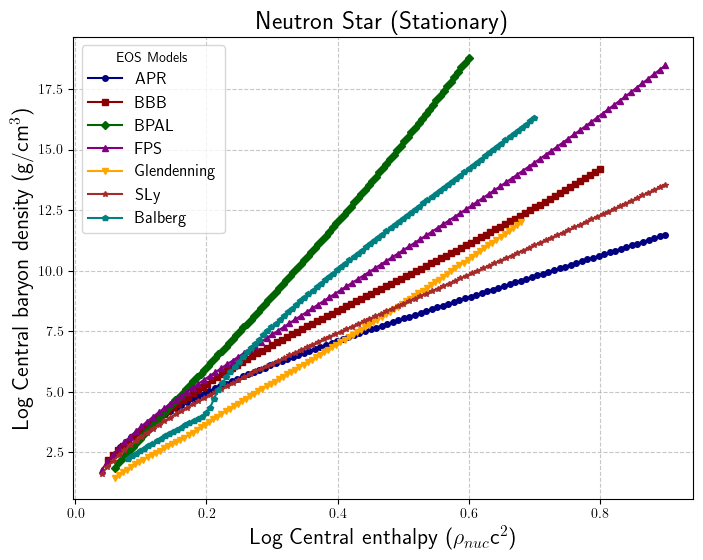

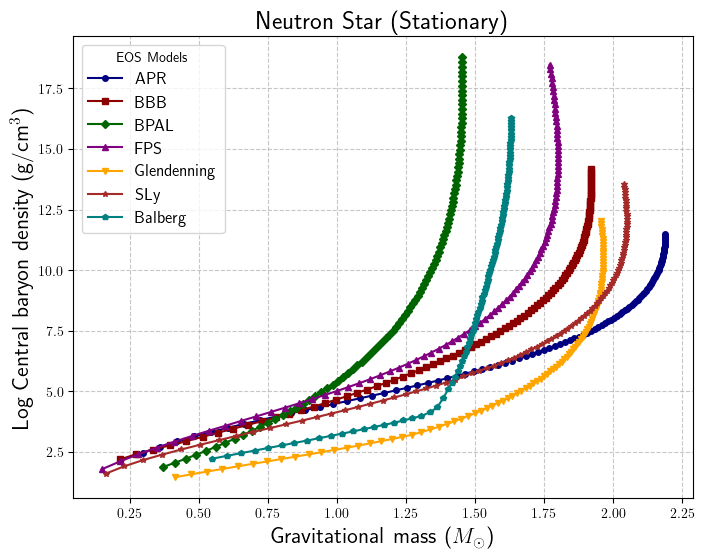

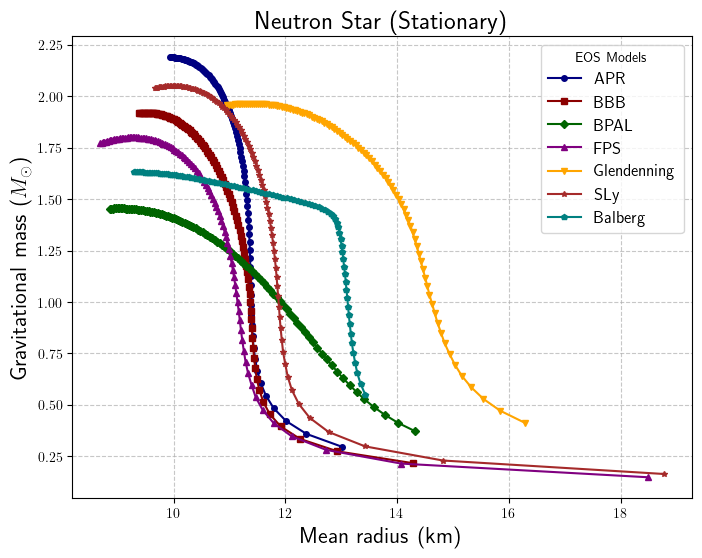

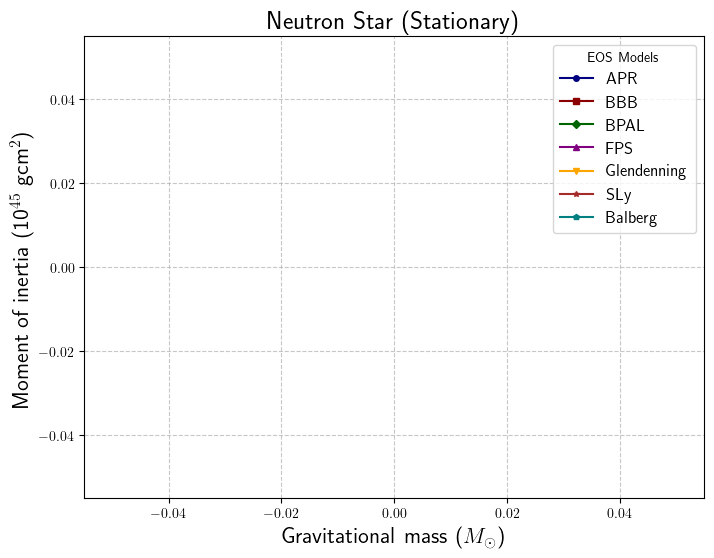

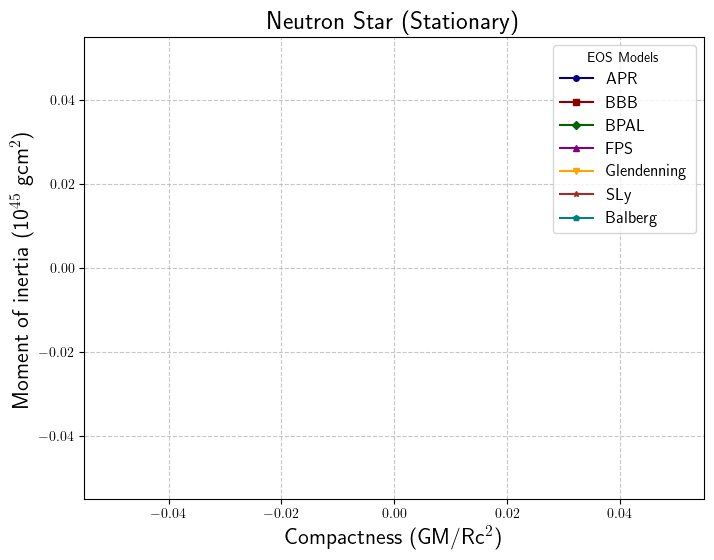

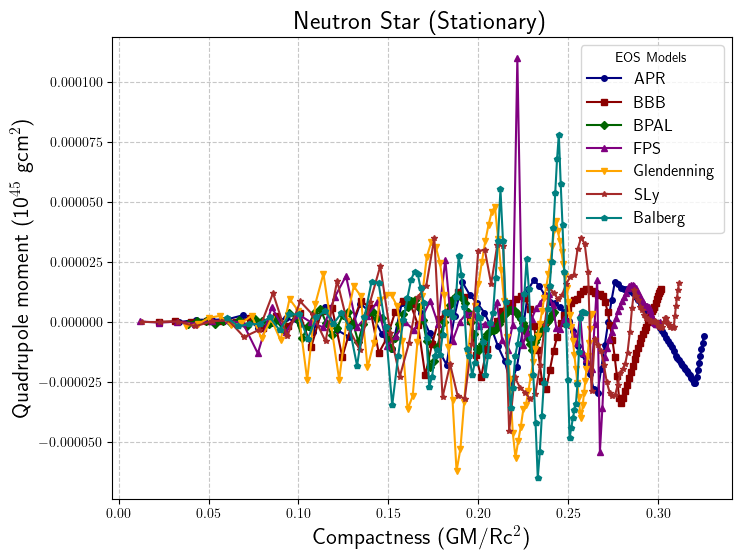

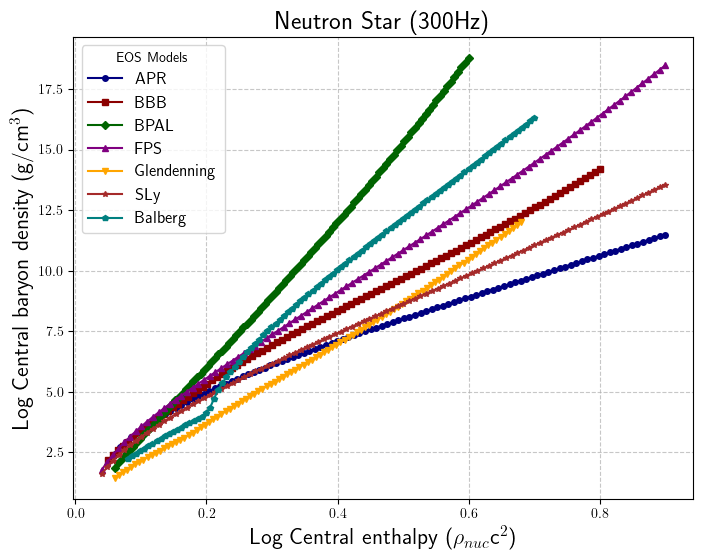

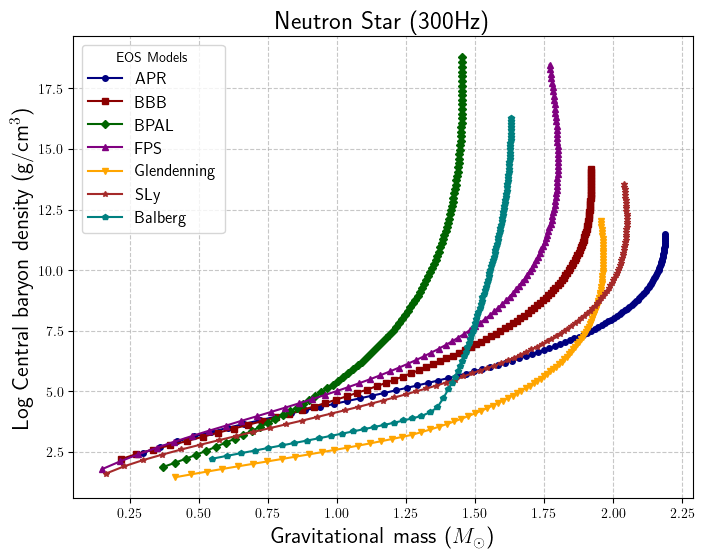

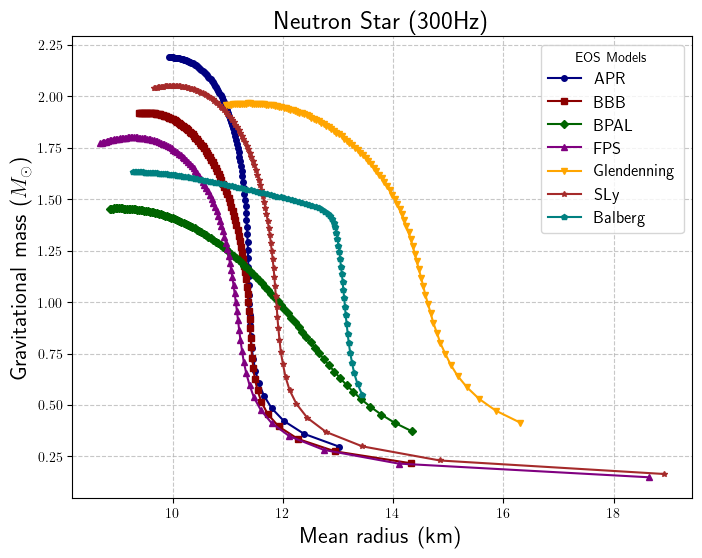

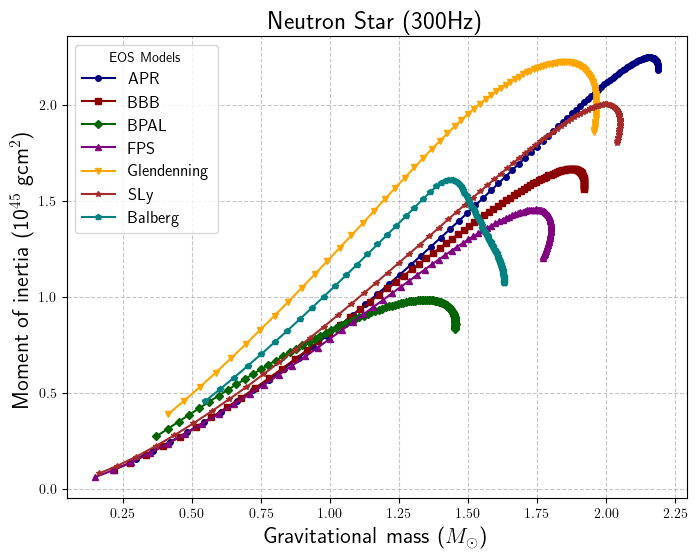

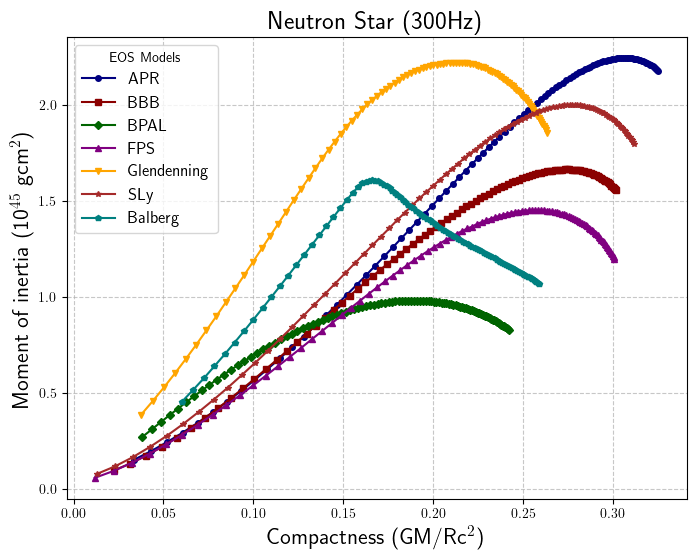

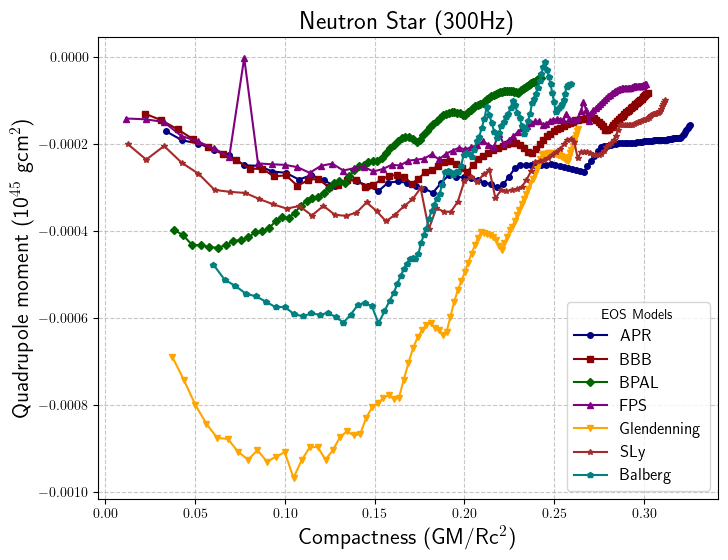

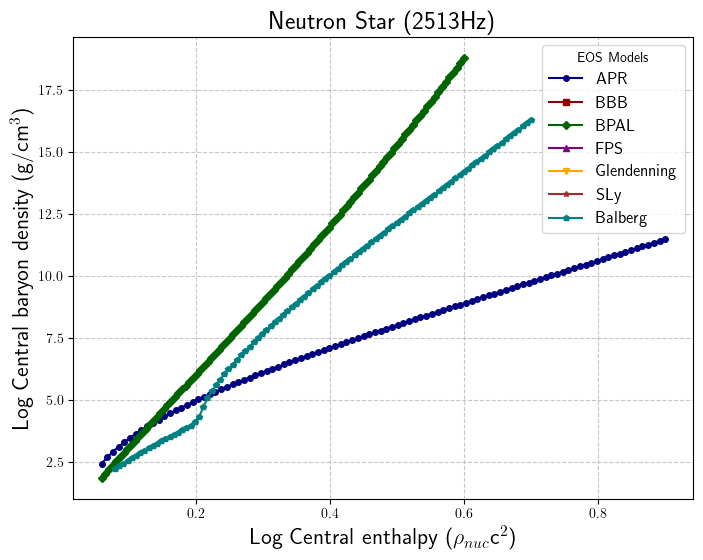

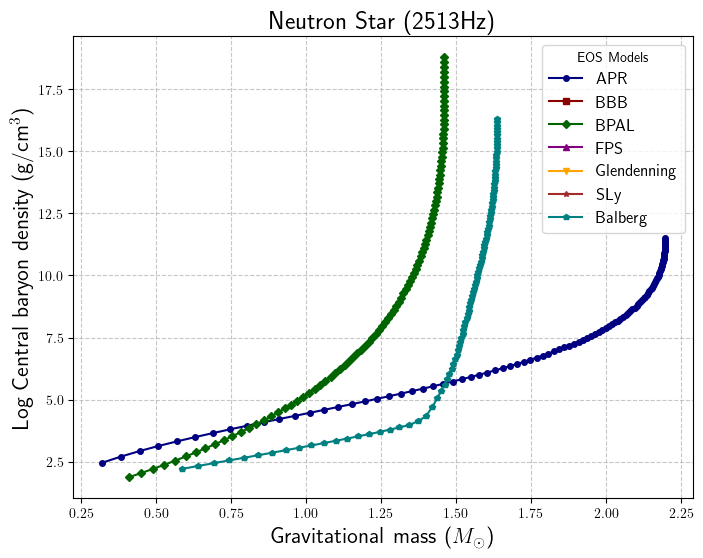

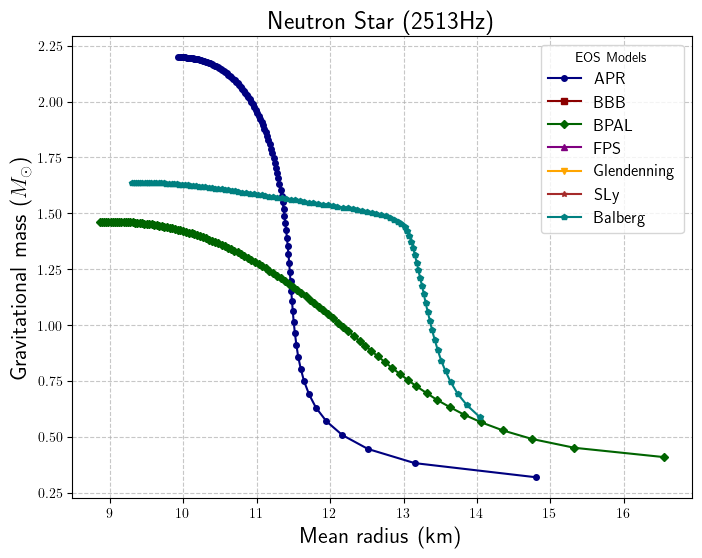

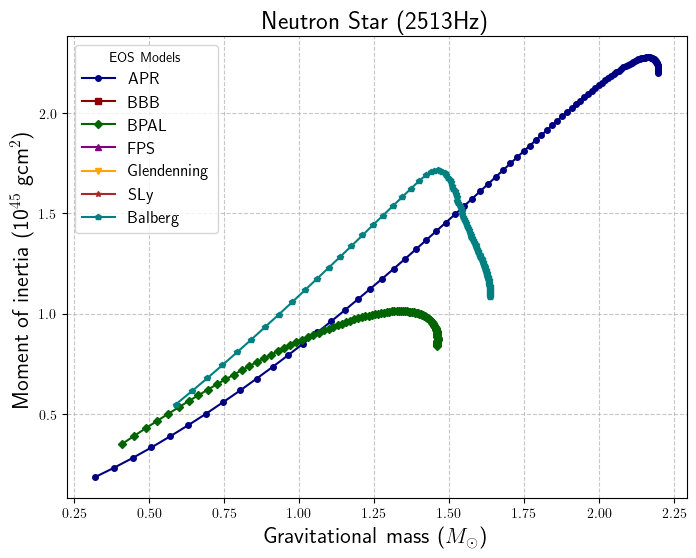

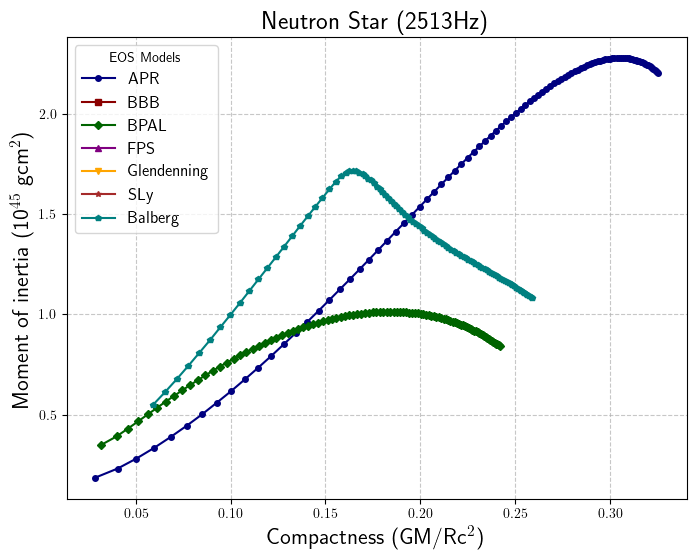

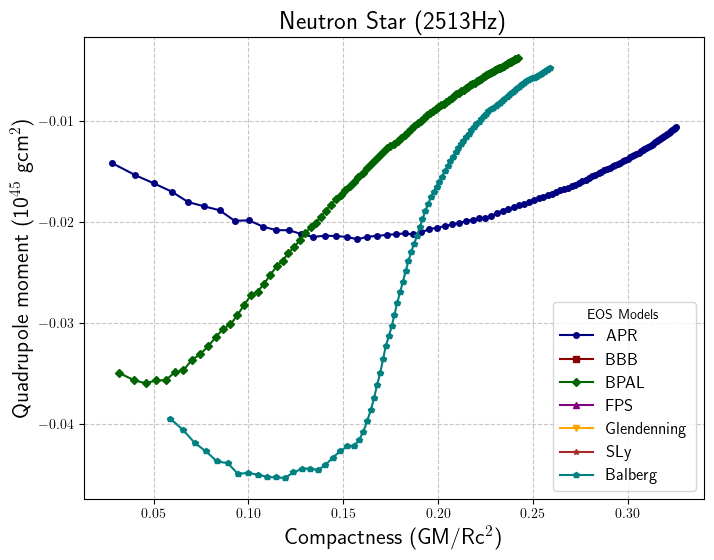

In [4]:
# Dictionary for pretty axis labels
units = {
    "Central enthalpy": r"Log Central enthalpy ($\rho_{nuc}$c$^2$)",
    "Central proper baryon density": r"Log Central baryon density (g/cm$^3$)",
    "Gravitational mass": r"Gravitational mass ($M_\odot$)",
    "Mean radius": r"Mean radius (km)",
    "Moment of inertia": r"Moment of inertia (10$^{45}$ gcm$^2$)",
    "Compactness": r"Compactness (GM/Rc$^2$)",
    "Quadrupole moment Q": r"Quadrupole moment (10$^{45}$ gcm$^2$)"
}

# Define colors and markers for distinction
colors = ["navy", "darkred", "darkgreen", "purple", "orange", "brown", "teal"]
markers = ["o", "s", "D", "^", "v", "*", "p"]
marker_size = 4  # Reduce marker size here

#################################################################
# List of EOS files and their labels (Stationary Neutron Star)
eos_files = {
    "Stationary": {
        "APR": "Nrotstar_(APR100)_(0.06-0.9)_stat_extracted_data.csv",
        "BBB": "Nrotstar_(BBB100)_(0.05-0.8)_stat_extracted_data.csv",
        "BPAL": "Nrotstar_(BPAL100)_(0.06-0.6)_stat_extracted_data.csv",
        "FPS": "Nrotstar_(FPS100)_(0.04-0.9)_stat_extracted_data.csv",
        "Glendenning": "Nrotstar_(Glendenning100)_(0.06-0.68)_stat_extracted_data.csv",
        "SLy": "Nrotstar_(SLy100)_(0.04-0.9)_stat_extracted_data.csv",
        "Balberg": "Nrotstar_(Balberg100)_(0.08-0.7)_stat_extracted_data.csv"
    },
    "300Hz": {
        "APR": "Nrotstar_(APR100)_(0.06-0.9)_300Hz_extracted_data.csv",
        "BBB": "Nrotstar_(BBB100)_(0.05-0.8)_300Hz_extracted_data.csv",
        "BPAL": "Nrotstar_(BPAL100)_(0.06-0.6)_300Hz_extracted_data.csv",
        "FPS": "Nrotstar_(FPS100)_(0.04-0.9)_300Hz_extracted_data.csv",
        "Glendenning": "Nrotstar_(Glendenning100)_(0.06-0.68)_300Hz_extracted_data.csv",
        "SLy": "Nrotstar_(SLy100)_(0.04-0.9)_300Hz_extracted_data.csv",
        "Balberg": "Nrotstar_(Balberg100)_(0.08-0.7)_300Hz_extracted_data.csv"
    },
    "2513Hz": {
        "APR": "Nrotstar_(APR100)_(0.06-0.9)_2513Hz_extracted_data.csv",
        "BBB": "Nrotstar_(BBB100)_(0.05-0.8)_2513Hz_extracted_data.csv",
        "BPAL": "Nrotstar_(BPAL100)_(0.06-0.6)_2513Hz_extracted_data.csv",
        "FPS": "Nrotstar_(FPS100)_(0.04-0.9)_2513Hz_extracted_data.csv",
        "Glendenning": "Nrotstar_(Glendenning100)_(0.06-0.68)_2513Hz_extracted_data.csv",
        "SLy": "Nrotstar_(SLy100)_(0.04-0.9)_2513Hz_extracted_data.csv",
        "Balberg": "Nrotstar_(Balberg100)_(0.08-0.7)_2513Hz_extracted_data.csv"
    }
}

# Column pairs for plotting
columns = [
    ("Central enthalpy", "Central proper baryon density"),
    ("Gravitational mass", "Central proper baryon density"),
    ("Mean radius", "Gravitational mass"),
    ("Gravitational mass", "Moment of inertia"),
    ("Compactness", "Moment of inertia"),
    ("Compactness", "Quadrupole moment Q")
]

# Plot for each frequency
for frequency, files in eos_files.items():
    for x_col, y_col in columns:
        plt.figure(figsize=(8,6))

        for (eos, file), color, marker in zip(files.items(), colors, markers):
            df = pd.read_csv(file)

            # Convert numeric columns properly
            for col in df.columns:
                try:
                    df[col] = pd.to_numeric(df[col])
                except ValueError:
                    pass  # Ignore non-numeric columns

            # Filter out invalid values
            df = df[(df[x_col] != "N/A") & (df[y_col] != "N/A")]
            df[x_col] = df[x_col].astype(float)
            df[y_col] = df[y_col].astype(float)

            # Plot data with reduced marker size
            plt.plot(df[x_col], df[y_col], marker=marker, linestyle="-", color=color, 
                     label=eos, markersize=marker_size)

        plt.xlabel(units.get(x_col, x_col), fontsize=16)
        plt.ylabel(units.get(y_col, y_col), fontsize=16)
        plt.title(f"Neutron Star ({frequency})", fontsize=18)
        plt.legend(title="EOS Models", fontsize=12)
        plt.grid(linestyle='--', alpha=0.7)

        # Save the figure with the required filename format
        filename = f"{y_col.replace(' ', '_')}_{x_col.replace(' ', '_')}_{frequency}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')

        plt.show()

# Comparison

Processing akmalpr:   0%|                               | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_81714/566587820.py:53: RuntimeWarning: invalid value encountered in log
  log_pressure = np.log(pressure)
/tmp/ipykernel_81714/566587820.py:92: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  solution = odeint(compute_derivatives, state_variables_initial, radii, args=(eos_type,), rtol=1e-5, atol=1e-5)
Processing akmalpr:   6%|█▍                     | 6/100 [00:00<00:01, 52.87it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4194520442868D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4194520442868D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4194520442868D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4194520442868D-17
 lsoda--  warning..internal t (=r1) 

Processing akmalpr:  17%|███▋                  | 17/100 [00:00<00:01, 44.75it/s]

      in above,  r1 =  0.5000000000000D+02   r2 =  0.1724371035819D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1724371035819D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1724371035819D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1724371035819D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.50000000000

Processing akmalpr:  27%|█████▉                | 27/100 [00:00<00:01, 44.05it/s]

      in above,  r1 =  0.5000000000000D+02   r2 =  0.1127032506750D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1127032506750D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1127032506750D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1127032506750D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.50000000000

Processing akmalpr:  37%|████████▏             | 37/100 [00:00<00:01, 43.46it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8138016577988D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8138016577988D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8138016577988D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8138016577988D-18
 lsoda--  warning..internal t (=r1) 

Processing akmalpr:  47%|██████████▎           | 47/100 [00:01<00:01, 41.54it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6509715886567D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6509715886567D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6509715886567D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6509715886567D-18
 lsoda--  warning..internal t (=r1) 

Processing akmalpr:  52%|███████████▍          | 52/100 [00:01<00:01, 42.50it/s]

continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5526761425768D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5526761425768D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5526761425768D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5526761425768D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r

Processing akmalpr:  62%|█████████████▋        | 62/100 [00:01<00:00, 41.76it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4724241235946D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4724241235946D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4724241235946D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4724241235946D-18
 lsoda--  warning..internal t (=r1) 

Processing akmalpr:  72%|███████████████▊      | 72/100 [00:01<00:00, 43.40it/s]

       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4125234930118D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4125234930118D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4125234930118D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4125234930118D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t +

Processing akmalpr:  82%|██████████████████    | 82/100 [00:01<00:00, 42.14it/s]

n the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3661036318462D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3661036318462D-16
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9946930295167D+06   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3615840093800D-22
 lsoda--  warning..int

Processing akmalpr:  92%|████████████████████▏ | 92/100 [00:02<00:00, 40.97it/s]

       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  

      in above,  r1 =  0.5000000000000D+02   r2 =  0.3254172956302D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3254172956302D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3254172956302D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3254172956302D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t 

Processing akmalpr: 100%|█████████████████████| 100/100 [00:02<00:00, 42.34it/s]


00D+02   r2 =  0.2958269402404D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2958269402404D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2958269402404D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2958269402404D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2958269402404D-16
 

Processing bbb2:   0%|                                  | 0/100 [00:00<?, ?it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4253157717570D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4253157717570D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4253157717570D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4253157717570D-17
 lsoda--  warning..internal t (=r1) 

Processing bbb2:   5%|█▎                        | 5/100 [00:00<00:02, 42.22it/s]

1 =  0.5000000000000D+02   r2 =  0.4253157717570D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4253157717570D-15
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3653130193161D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3653130193161D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

Processing bbb2:  10%|██▌                      | 10/100 [00:00<00:02, 41.52it/s]

       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1804218647761D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1804218647761D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1804218647761D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1804218647761D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will 

Processing bbb2:  15%|███▊                     | 15/100 [00:00<00:02, 40.00it/s]

      in above,  r1 =  0.5000000000000D+02   r2 =  0.1696749247962D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1696749247962D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1696749247962D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1696749247962D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.50000000000

Processing bbb2:  25%|██████▎                  | 25/100 [00:00<00:01, 40.96it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1105303828903D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1105303828903D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1105303828903D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1105303828903D-17
 lsoda--  warning..internal t (=r1) 

Processing bbb2:  35%|████████▊                | 35/100 [00:00<00:01, 40.40it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8436839688905D-16
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1111793477540D+07   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8194384458036D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size)
. solver will continue anyway  
      in above,  r1 

Processing bbb2:  45%|███████████▎             | 45/100 [00:01<00:01, 39.79it/s]

       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6510519670808D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6510519670808D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6510519670808D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6510519670808D-18
 lsoda--  warning..internal t (=r1) 
and h (=r2) are  
       such that in the machine, t 

Processing bbb2:  54%|█████████████▌           | 54/100 [00:01<00:01, 40.80it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5400715419829D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5400715419829D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5400715419829D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5400715419829D-18
 lsoda--  warning..internal t (=r1) 

Processing bbb2:  59%|██████████████▊          | 59/100 [00:01<00:01, 40.90it/s]

continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4690124792649D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4690124792649D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4690124792649D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4690124792649D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r

Processing bbb2:  69%|█████████████████▎       | 69/100 [00:01<00:00, 40.83it/s]

 h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4144692238611D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4144692238611D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4144692238611D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4144692238611D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h 

Processing bbb2:  79%|███████████████████▊     | 79/100 [00:01<00:00, 39.48it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3618739936208D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3618739936208D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3618739936208D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3618739936208D-18
 lsoda--  warning..internal t (=r1) 

Processing bbb2:  88%|██████████████████████   | 88/100 [00:02<00:00, 40.34it/s]

continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3285184505398D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3285184505398D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3285184505398D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3285184505398D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r

Processing bbb2:  93%|███████████████████████▎ | 93/100 [00:02<00:00, 40.54it/s]

and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2976562927391D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2976562927391D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2976562927391D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2976562927391D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that i

Processing bbb2:  98%|████████████████████████▌| 98/100 [00:02<00:00, 39.71it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2747172095838D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2747172095838D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2747172095838D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2747172095838D-18
 lsoda--  warning..internal t (=r1) 

Processing bbb2: 100%|████████████████████████| 100/100 [00:02<00:00, 40.19it/s]


      in above,  r1 =  0.5000000000000D+02   r2 =  0.2720948170739D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2720948170739D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2720948170739D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2720948170739D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.50000000000

Processing bpal12:   6%|█▍                      | 6/100 [00:00<00:01, 56.69it/s]

       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  

      in above,  r1 =  0.5000000000000D+02   r2 =  0.4183904254483D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4183904254483D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4183904254483D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4183904254483D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t 

Processing bpal12:  18%|████▏                  | 18/100 [00:00<00:01, 52.28it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1424657787546D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1424657787546D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1424657787546D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1424657787546D-17
 lsoda--  warning..internal t (=r1) 

Processing bpal12:  31%|███████▏               | 31/100 [00:00<00:01, 55.59it/s]

and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8580481499200D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8580481499200D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8580481499200D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8580481499200D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that i

Processing bpal12:  43%|█████████▉             | 43/100 [00:00<00:01, 55.33it/s]

=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5984131407069D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5984131407069D-16
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1080789674960D+07   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0

Processing bpal12:  55%|████████████▋          | 55/100 [00:01<00:00, 55.59it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4506781167693D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4506781167693D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4506781167693D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4506781167693D-18
 lsoda--  warning..internal t (=r1) 

Processing bpal12:  67%|███████████████▍       | 67/100 [00:01<00:00, 54.90it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3670356371220D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3670356371220D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3670356371220D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3670356371220D-18
 lsoda--  warning..internal t (=r1) 

Processing bpal12:  79%|██████████████████▏    | 79/100 [00:01<00:00, 55.28it/s]

ill continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3178732288420D-16
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9468890017123D+06   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3136717677227D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3136717677227D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t o

Processing bpal12:  91%|████████████████████▉  | 91/100 [00:01<00:00, 54.58it/s]

lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2738554998044D-16
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9161362684669D+06   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2707313590258D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = 

Processing bpal12: 100%|██████████████████████| 100/100 [00:01<00:00, 54.67it/s]


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2381320397549D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2381320397549D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2381320397549D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2381320397549D-18
 lsoda--  warning..internal t (=r1) 

Processing fps:   0%|                                   | 0/100 [00:00<?, ?it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4194508345288D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4194508345288D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4194508345288D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4194508345288D-17
 lsoda--  warning..internal t (=r1) 

Processing fps:   6%|█▌                         | 6/100 [00:00<00:01, 54.64it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1807923880816D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1807923880816D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1807923880816D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1807923880816D-18
 lsoda--  warning..internal t (=r1) 

Processing fps:  12%|███                       | 12/100 [00:00<00:01, 51.07it/s]

 t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.9238717536051D-17
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7667673500483D+06   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8415690259305D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8415690259305D-23
 lsoda--  warning..internal t (=r1) and h (=

Processing fps:  18%|████▋                     | 18/100 [00:00<00:01, 50.48it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6204700298444D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6204700298444D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6204700298444D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6204700298444D-19
 lsoda--  warning..internal t (=r1) 

Processing fps:  24%|██████▏                   | 24/100 [00:00<00:01, 50.36it/s]

       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4067471588461D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4067471588461D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4067471588461D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4067471588461D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t +

Processing fps:  30%|███████▊                  | 30/100 [00:00<00:01, 51.66it/s]

       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3602180177182D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3602180177182D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3602180177182D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3602180177182D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will 

Processing fps:  36%|█████████▎                | 36/100 [00:00<00:01, 53.21it/s]

       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2681826535365D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2681826535365D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2681826535365D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2681826535365D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t +

Processing fps:  42%|██████████▉               | 42/100 [00:00<00:01, 52.17it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2537739932035D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2537739932035D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2537739932035D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2537739932035D-19
 lsoda--  warning..internal t (=r1) 

Processing fps:  48%|████████████▍             | 48/100 [00:00<00:01, 49.61it/s]

e machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2088833721880D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2088833721880D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2088833721880D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2088833721880D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next ste

Processing fps:  53%|█████████████▊            | 53/100 [00:01<00:00, 48.67it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1958891215267D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1958891215267D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1958891215267D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1958891215267D-19
 lsoda--  warning..internal t (=r1) 

Processing fps:  58%|███████████████           | 58/100 [00:01<00:00, 47.82it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1680170855152D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1680170855152D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1680170855152D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1680170855152D-19
 lsoda--  warning..internal t (=r1) 

Processing fps:  64%|████████████████▋         | 64/100 [00:01<00:00, 48.33it/s]

continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1622458105417D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1622458105417D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1622458105417D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1622458105417D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r

Processing fps:  74%|███████████████████▏      | 74/100 [00:01<00:00, 47.11it/s]

02   r2 =  0.1405245077229D-17
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6927828200281D+06   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1384647752361D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1384647752361D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue

Processing fps:  84%|█████████████████████▊    | 84/100 [00:01<00:00, 47.60it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1207640438541D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1207640438541D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1207640438541D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1207640438541D-19
 lsoda--  warning..internal t (=r1) 

Processing fps:  94%|████████████████████████▍ | 94/100 [00:01<00:00, 46.88it/s]

ernal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1070761168417D-23
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1070761168417D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1070761168417D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1070761168417D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
    

Processing fps:  99%|█████████████████████████▋| 99/100 [00:02<00:00, 46.43it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.9716414588202D-24
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.9716414588202D-24
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.9716414588202D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.9716414588202D-20
 lsoda--  warning..internal t (=r1) 

Processing fps: 100%|█████████████████████████| 100/100 [00:02<00:00, 48.63it/s]


continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.9716414588202D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.9716414588202D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.9716414588202D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.9716414588202D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r

Processing glendnh3:   0%|                              | 0/100 [00:00<?, ?it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4194526911722D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4194526911722D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4194526911722D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4194526911722D-17
 lsoda--  warning..internal t (=r1) 

Processing glendnh3:   7%|█▌                    | 7/100 [00:00<00:01, 59.56it/s]

and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2477840514134D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2477840514134D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2477840514134D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2477840514134D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that i

Processing glendnh3:  13%|██▋                  | 13/100 [00:00<00:01, 55.25it/s]

continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1849740169125D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1849740169125D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1849740169125D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1849740169125D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r

Processing glendnh3:  19%|███▉                 | 19/100 [00:00<00:01, 53.15it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1415821368888D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1415821368888D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1415821368888D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1415821368888D-17
 lsoda--  warning..internal t (=r1) 

Processing glendnh3:  25%|█████▎               | 25/100 [00:00<00:01, 53.38it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1147402113355D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1147402113355D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1147402113355D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1147402113355D-17
 lsoda--  warning..internal t (=r1) 

Processing glendnh3:  31%|██████▌              | 31/100 [00:00<00:01, 53.40it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.9396456511746D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.9396456511746D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.9396456511746D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.9396456511746D-18
 lsoda--  warning..internal t (=r1) 

Processing glendnh3:  37%|███████▊             | 37/100 [00:00<00:01, 53.37it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8320331695419D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8320331695419D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8320331695419D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8320331695419D-18
 lsoda--  warning..internal t (=r1) 

Processing glendnh3:  43%|█████████            | 43/100 [00:00<00:01, 54.08it/s]

       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.7315109339972D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.7315109339972D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.7315109339972D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.7315109339972D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will 

Processing glendnh3:  49%|██████████▎          | 49/100 [00:00<00:00, 52.48it/s]

000000000000D+02   r2 =  0.6645981418919D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6645981418919D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6645981418919D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6645981418919D-16
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machin

Processing glendnh3:  55%|███████████▌         | 55/100 [00:01<00:00, 51.47it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5797444792843D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5797444792843D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5797444792843D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5797444792843D-18
 lsoda--  warning..internal t (=r1) 

Processing glendnh3:  61%|████████████▊        | 61/100 [00:01<00:00, 52.51it/s]

      in above,  r1 =  0.5000000000000D+02   r2 =  0.5532654758005D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5532654758005D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5532654758005D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5532654758005D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.50000000000

Processing glendnh3:  67%|██████████████       | 67/100 [00:01<00:00, 51.72it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4931737919229D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4931737919229D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4931737919229D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4931737919229D-18
 lsoda--  warning..internal t (=r1) 

Processing glendnh3:  73%|███████████████▎     | 73/100 [00:01<00:00, 50.36it/s]

1 =  0.5000000000000D+02   r2 =  0.4560262962837D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4560262962837D-16
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1153415319290D+07   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4503729047728D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size)

Processing glendnh3:  79%|████████████████▌    | 79/100 [00:01<00:00, 49.25it/s]

000000000000D+02   r2 =  0.4240846214624D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4240846214624D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4240846214624D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4240846214624D-16
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machin

Processing glendnh3:  84%|█████████████████▋   | 84/100 [00:01<00:00, 48.84it/s]

 0.5000000000000D+02   r2 =  0.4006961322075D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4006961322075D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4006961322075D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4006961322075D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.40069

Processing glendnh3:  90%|██████████████████▉  | 90/100 [00:01<00:00, 50.19it/s]

       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3758237472494D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3758237472494D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3758237472494D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3758237472494D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will 

Processing glendnh3: 100%|████████████████████| 100/100 [00:01<00:00, 52.06it/s]


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3538587635570D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3538587635570D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3538587635570D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3538587635570D-18
 lsoda--  warning..internal t (=r1) 

Processing sly4:   0%|                                  | 0/100 [00:00<?, ?it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4197466784612D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4197466784612D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4197466784612D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4197466784612D-17
 lsoda--  warning..internal t (=r1) 

Processing sly4:   5%|█▎                        | 5/100 [00:00<00:02, 43.32it/s]

 0.5000000000000D+02   r2 =  0.2495733992254D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2495733992254D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2495733992254D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2495733992254D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.24957

Processing sly4:  10%|██▌                      | 10/100 [00:00<00:02, 41.19it/s]

  in above,  r1 =  0.5000000000000D+02   r2 =  0.1656793496315D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1656793496315D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1656793496315D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1656793496315D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+

Processing sly4:  15%|███▊                     | 15/100 [00:00<00:02, 41.23it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1305699081515D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1305699081515D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1305699081515D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1305699081515D-17
 lsoda--  warning..internal t (=r1) 

Processing sly4:  20%|█████                    | 20/100 [00:00<00:01, 41.28it/s]

e machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1032261673915D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1032261673915D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1032261673915D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1032261673915D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next ste

Processing sly4:  25%|██████▎                  | 25/100 [00:00<00:01, 40.31it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8535194803219D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8535194803219D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8535194803219D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8535194803219D-18
 lsoda--  warning..internal t (=r1) 

Processing sly4:  30%|███████▌                 | 30/100 [00:00<00:01, 40.21it/s]

02   r2 =  0.7275427188727D-16
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1132245587039D+07   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.7066817668998D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.7066817668998D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue

Processing sly4:  35%|████████▊                | 35/100 [00:00<00:01, 39.67it/s]

ernal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6683546675444D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6683546675444D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6683546675444D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6683546675444D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
   s

Processing sly4:  40%|██████████               | 40/100 [00:00<00:01, 40.13it/s]

1 =  0.5000000000000D+02   r2 =  0.5748255623052D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5748255623052D-16
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1092285105592D+07   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5617244676468D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size)

Processing sly4:  45%|███████████▎             | 45/100 [00:01<00:01, 40.07it/s]

       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4941495315320D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4941495315320D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4941495315320D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4941495315320D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will 

Processing sly4:  50%|████████████▌            | 50/100 [00:01<00:01, 40.46it/s]

 h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4750982955014D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4750982955014D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4750982955014D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4750982955014D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h 

Processing sly4:  55%|█████████████▊           | 55/100 [00:01<00:01, 39.77it/s]

       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4258446327417D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4258446327417D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4258446327417D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4258446327417D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will 

Processing sly4:  60%|███████████████          | 60/100 [00:01<00:01, 39.98it/s]

       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3858441273921D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3858441273921D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3858441273921D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3858441273921D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t +

Processing sly4:  65%|████████████████▎        | 65/100 [00:01<00:00, 38.67it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3578339179226D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3578339179226D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3578339179226D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3578339179226D-18
 lsoda--  warning..internal t (=r1) 

Processing sly4:  70%|█████████████████▌       | 70/100 [00:01<00:00, 40.06it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3428984168948D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3428984168948D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3428984168948D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3428984168948D-18
 lsoda--  warning..internal t (=r1) 

Processing sly4:  75%|██████████████████▊      | 75/100 [00:01<00:00, 40.69it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3164795528482D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3164795528482D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3164795528482D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3164795528482D-18
 lsoda--  warning..internal t (=r1) 

Processing sly4:  80%|████████████████████     | 80/100 [00:01<00:00, 40.56it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2903783857122D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2903783857122D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2903783857122D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2903783857122D-18
 lsoda--  warning..internal t (=r1) 

Processing sly4:  85%|█████████████████████▎   | 85/100 [00:02<00:00, 40.39it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2742239382980D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2742239382980D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2742239382980D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2742239382980D-18
 lsoda--  warning..internal t (=r1) 

Processing sly4:  90%|██████████████████████▌  | 90/100 [00:02<00:00, 41.03it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2625394045362D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2625394045362D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2625394045362D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2625394045362D-18
 lsoda--  warning..internal t (=r1) 

Processing sly4:  95%|███████████████████████▊ | 95/100 [00:02<00:00, 40.38it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2492631822276D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2492631822276D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2492631822276D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2492631822276D-18
 lsoda--  warning..internal t (=r1) 

Processing sly4: 100%|████████████████████████| 100/100 [00:02<00:00, 40.28it/s]


and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2395713464598D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2395713464598D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2395713464598D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2395713464598D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that i

Processing balbn1h1:   0%|                              | 0/100 [00:00<?, ?it/s]

       such that in the machine, t + h = t on the next step  

       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4144229229669D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4144229229669D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4144229229669D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4144229229669D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t 

Processing balbn1h1:   5%|█                     | 5/100 [00:00<00:02, 41.71it/s]

       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3587671491354D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3587671491354D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3587671491354D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3587671491354D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will 

Processing balbn1h1:  10%|██                   | 10/100 [00:00<00:02, 42.81it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1658813907535D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1658813907535D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1658813907535D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1658813907535D-17
 lsoda--  warning..internal t (=r1) 

Processing balbn1h1:  15%|███▏                 | 15/100 [00:00<00:02, 40.67it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1554079219542D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1554079219542D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1554079219542D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1554079219542D-17
 lsoda--  warning..internal t (=r1) 

Processing balbn1h1:  24%|█████                | 24/100 [00:00<00:01, 39.20it/s]

      in above,  r1 =  0.5000000000000D+02   r2 =  0.1034101342670D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1034101342670D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1034101342670D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1034101342670D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.50000000000

Processing balbn1h1:  32%|██████▋              | 32/100 [00:00<00:01, 39.07it/s]

      in above,  r1 =  0.1243397780663D+07   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.7509537017583D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.7509537017583D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.7509537017583D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in abo
ve,  r1 =  0.5000000000

Processing balbn1h1:  40%|████████▍            | 40/100 [00:01<00:01, 38.41it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6040251104672D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6040251104672D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6040251104672D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6040251104672D-18
 lsoda--  warning..internal t (=r1) 

Processing balbn1h1:  48%|██████████           | 48/100 [00:01<00:01, 37.73it/s]

       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5051828414644D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5051828414644D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5051828414644D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5051828414644D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will 

Processing balbn1h1:  56%|███████████▊         | 56/100 [00:01<00:01, 35.74it/s]

1 =  0.5000000000000D+02   r2 =  0.4341404046504D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4341404046504D-16
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1074298368416D+07   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4266407582359D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size)

Processing balbn1h1:  64%|█████████████▍       | 64/100 [00:01<00:01, 34.54it/s]

1 =  0.5000000000000D+02   r2 =  0.3865730728282D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3865730728282D-16
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1036960224693D+07   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3806155355879D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size)

Processing balbn1h1:  68%|██████████████▎      | 68/100 [00:01<00:00, 33.92it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3435536567167D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3435536567167D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3435536567167D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3435536567167D-18
 lsoda--  warning..internal t (=r1) 

Processing balbn1h1:  72%|███████████████      | 72/100 [00:01<00:00, 34.07it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3212127598284D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3212127598284D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3212127598284D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3212127598284D-18
 lsoda--  warning..internal t (=r1) 

Processing balbn1h1:  76%|███████████████▉     | 76/100 [00:02<00:00, 34.58it/s]

      in above,  r1 =  0.5000000000000D+02   r2 =  0.3130688590245D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3130688590245D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3130688590245D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3130688590245D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.50000000000

Processing balbn1h1:  80%|████████████████▊    | 80/100 [00:02<00:00, 35.23it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2909407978169D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2909407978169D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2909407978169D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2909407978169D-18
 lsoda--  warning..internal t (=r1) 

Processing balbn1h1:  84%|█████████████████▋   | 84/100 [00:02<00:00, 35.73it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2810097200421D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2810097200421D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2810097200421D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2810097200421D-16
 
lsoda--  warning..internal t (=r1)

Processing balbn1h1:  88%|██████████████████▍  | 88/100 [00:02<00:00, 31.61it/s]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9341311781180D+06   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2658834434710D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2658834434710D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2658834434710D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t o

Processing balbn1h1:  92%|███████████████████▎ | 92/100 [00:02<00:00, 31.77it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2602792976573D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2602792976573D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2602792976573D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2602792976573D-17
 lsoda--  warning..internal t (=r1) 

Processing balbn1h1:  96%|████████████████████▏| 96/100 [00:02<00:00, 33.09it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2523024435334D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2523024435334D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2523024435334D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2523024435334D-18
 lsoda--  warning..internal t (=r1) 

Processing balbn1h1: 100%|████████████████████| 100/100 [00:02<00:00, 36.03it/s]

lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2423973648471D-16
 lsoda--  above warning has been issued i1 times.    
       it will not be issued again for this problem  
      in above message,  i1 =        10
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9087000615271D+06   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2400414133675D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = 

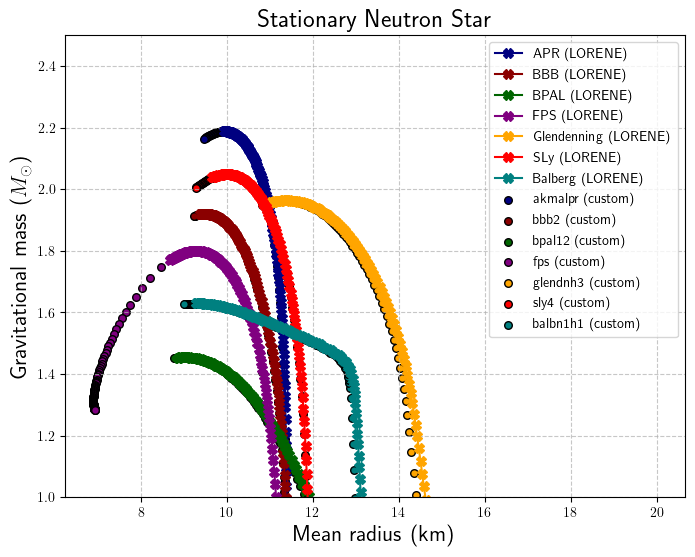

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from tqdm import tqdm
from scipy.integrate import solve_ivp
import pandas as pd
import os
import re
import csv

G = 6.6743e-8  # cm^3/g/s^2
c = 29979245800     # cm/s

# Array of EOS names
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
source_dir = '/home/sanjana/ashoka/thesis/EoS/'  # Directory containing EOS files

# Define markers and colors for different EOS
markers = ['X', 'X', 'X', 'X', 'X', 'X', 'X']
colors = ["navy", "darkred", "darkgreen", "purple", "orange", "red", "teal"]

eos_results = {}

# Loop over each EOS
for eos_name in eos_names:
    data = np.genfromtxt(f"{source_dir}eos_{eos_name}.txt", delimiter=None)
    baryon_density = data[:, 1]
    density = data[:, 2]
    pressure = data[:, 3]

    min_density = 2.4e14 #np.min(density) #1e14  # Lower bound on central density
    max_density = np.max(density)
    
    valid_indices = (density > 0) & (pressure > 0)
    density = density[valid_indices]
    pressure = pressure[valid_indices]
    baryon_density = baryon_density[valid_indices]
    
    log_density = np.log(density)
    log_pressure = np.log(pressure)

    '''
    log_pressure_to_log_density = CubicSpline(log_pressure, log_density)
    log_density_to_log_pressure = CubicSpline(log_density, log_pressure)
    '''

    log_pressure_to_log_density = interp1d(log_pressure, log_density, kind='cubic', bounds_error=True)
    log_density_to_log_pressure = interp1d(log_density, log_pressure, kind='cubic', bounds_error=True)

    def pressure_to_density(pressure):
        log_pressure = np.log(pressure)
        # Determine the valid range
        min_log_p, max_log_p = log_pressure_to_log_density.x[0], log_pressure_to_log_density.x[-1]
    
        # Clip values outside the interpolation range and show a warning
        if log_pressure < min_log_p or log_pressure > max_log_p:
            clipped_value = np.exp(np.clip(log_pressure, min_log_p, max_log_p))
            print(f"Warning: Extrapolation detected for pressure {pressure:.4e}, clipping to {clipped_value:.4e}.")
            log_pressure = np.clip(log_pressure, min_log_p, max_log_p)
    
        log_density = log_pressure_to_log_density(log_pressure)
        return np.exp(log_density)
    
    def density_to_pressure(density):
        log_density = np.log(density)
        # Determine the valid range
        min_log_rho, max_log_rho = log_density_to_log_pressure.x[0], log_density_to_log_pressure.x[-1]
    
        # Clip values outside the interpolation range and show a warning
        if log_density < min_log_rho or log_density > max_log_rho:
            clipped_value = np.exp(np.clip(log_density, min_log_rho, max_log_rho))
            print(f"Warning: Extrapolation detected for density {density:.4e}, clipping to {clipped_value:.4e}.")
            log_density = np.clip(log_density, min_log_rho, max_log_rho)
    
        log_pressure = log_density_to_log_pressure(log_density)
        return np.exp(log_pressure)

    def compute_derivatives(state_vars, radius, eos_type):
        mass, pressure = state_vars
        density = pressure_to_density(pressure)
        dm_dr = 4.0 * np.pi * (radius**2) * density
        dP_dr = -(((G * mass * density) / (radius**2)) * (1 + (pressure / (density * c * c))) *
                  (1 + ((4 * np.pi * pressure * (radius**3)) / (mass * c * c)))) / (1 - ((2 * G * mass) / (radius * c * c)))
        return [dm_dr, dP_dr]
    #'''
    def solve_neutron_star_structure(central_density, eos_type):
        central_pressure = density_to_pressure(central_density)
        state_variables_initial = [1e-4, central_pressure]
        radii = np.linspace(50, 2e6, 10000)
        solution = odeint(compute_derivatives, state_variables_initial, radii, args=(eos_type,), rtol=1e-5, atol=1e-5)
        mass_profile = solution[:, 0]
        pressure_profile = solution[:, 1]
        termination_index = np.argmax(pressure_profile < 1e-10 * central_pressure)
        if termination_index == 0:
            termination_index = -1
        final_radius = radii[termination_index]
        final_mass = mass_profile[termination_index]
        return final_radius, final_mass
    #'''
    '''
    def solve_neutron_star_structure(central_density, eos_type):
        initial_pressure = density_to_pressure(central_density)
        state_variables_initial = [1e-3, initial_pressure]
    
        def wrapper(r, y):
            return compute_derivatives(y, r, eos_type)
    
        # Use an implicit solver (Radau or BDF)  
        sol = solve_ivp(wrapper, [50, 2e6], state_variables_initial, method="LSODA", rtol=1e-5, atol=1e-5)
    
        radii = sol.t
        mass_profile = sol.y[0]
        pressure_profile = sol.y[1]
    
        termination_index = np.argmax(pressure_profile < 1e-10 * initial_pressure)
        if termination_index == 0:
            termination_index = -1
    
        final_radius = radii[termination_index]
        final_mass = mass_profile[termination_index]
        return final_radius, final_mass
    '''
    
    central_densities = np.linspace(min_density, max_density, 100)
    results = np.zeros([2, len(central_densities)])

    for i in tqdm(range(len(central_densities)), desc=f"Processing {eos_name}"):
        results[:, i] = solve_neutron_star_structure(central_densities[i], eos_name)

    radius = results[0,] / 1e5  # Convert to km
    mass = results[1,] / 1.989e33  # Convert to solar masses
    eos_results[eos_name] = (central_densities, radius, mass)

##############################################################################################

# Dictionary for pretty axis labels
units = {
    "Central enthalpy": r"Log Central enthalpy (c$^2$)",
    "Central proper baryon density": r"Log Central baryon density (g/cm$^3$)",
    "Gravitational mass": r"Gravitational mass ($M_\odot$)",
    "Mean radius": r"Mean radius (km)",
    "Moment of inertia": r"Moment of inertia (10$^{45}$ gcm$^2$)",
    "Compactness": r"Compactness (GM/Rc$^2$)"
}

# Define colors and markers for distinction
colors = ["navy", "darkred", "darkgreen", "purple", "orange", "red", "teal"]
marker_size = 7  # Reduce marker size here

#################################################################

# List of EOS files and their labels (Stationary Neutron Star)
eos_files_stationary = {
    "APR (LORENE)": "Nrotstar_(APR100)_(0.06-0.9)_stat_extracted_data.csv",
    "BBB (LORENE)": "Nrotstar_(BBB100)_(0.05-0.8)_stat_extracted_data.csv",
    "BPAL (LORENE)": "Nrotstar_(BPAL100)_(0.06-0.6)_stat_extracted_data.csv",
    "FPS (LORENE)": "Nrotstar_(FPS100)_(0.04-0.9)_stat_extracted_data.csv",
    "Glendenning (LORENE)": "Nrotstar_(Glendenning100)_(0.06-0.68)_stat_extracted_data.csv",
    "SLy (LORENE)": "Nrotstar_(SLy100)_(0.04-0.9)_stat_extracted_data.csv",
    "Balberg (LORENE)": "Nrotstar_(Balberg100)_(0.08-0.7)_stat_extracted_data.csv"
}

# Column pairs for plotting
columns = [
    ("Mean radius", "Gravitational mass"),
]

# Plot for stationary neutron stars
for x_col, y_col in columns:
    plt.figure(figsize=(8,6))

    for (eos, file), color, marker in zip(eos_files_stationary.items(), colors, markers):
        df = pd.read_csv(file)
        
        # Convert numeric columns properly
        for col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                pass  # Ignore non-numeric columns

        # Filter out invalid values
        df = df[(df[x_col] != "N/A") & (df[y_col] != "N/A")]
        df[x_col] = df[x_col].astype(float)
        df[y_col] = df[y_col].astype(float)

        # Plot data with reduced marker size
        plt.plot(df[x_col], df[y_col], marker=marker, linestyle="-", color=color, 
                 label=eos, markersize=marker_size)

    plt.xlabel(units.get(x_col, x_col), fontsize=16)
    plt.ylabel(units.get(y_col, y_col), fontsize=16)
    plt.title("Stationary Neutron Star", fontsize=18)
    plt.legend(title="EOS Models", fontsize=12)
    plt.grid(linestyle='--', alpha=0.7)

##############################################################################################
markers = ["o", "o", "o", "o", "o", "o", "o"]
#plt.figure()
#plt.title(r"Stationary NS Plot: Mass vs Radius")
#plt.ylabel(r"Mass of the Star [$M_\odot$]")
#plt.xlabel(r"Radius of the Star [km]")
for eos_name, (central_densities, radius, mass), marker, color in zip(eos_results.keys(), eos_results.values(), markers, colors):
    plt.scatter(radius, mass, label=f"{eos_name} (custom)", marker=marker, color=color, s=30, edgecolor="black")
plt.legend()
plt.ylim(1,2.5)
plt.savefig("MvsRStat_Comparison.pdf")
plt.show()

Processing balbn1h1: 100%|████████████████████| 500/500 [00:33<00:00, 14.92it/s]


Results for akmalpr saved to /home/sanjana/ashoka/thesis/output_lsoda/akmalpr_LSODA.csv
Results for bbb2 saved to /home/sanjana/ashoka/thesis/output_lsoda/bbb2_LSODA.csv
Results for bpal12 saved to /home/sanjana/ashoka/thesis/output_lsoda/bpal12_LSODA.csv
Results for fps saved to /home/sanjana/ashoka/thesis/output_lsoda/fps_LSODA.csv
Results for glendnh3 saved to /home/sanjana/ashoka/thesis/output_lsoda/glendnh3_LSODA.csv
Results for sly4 saved to /home/sanjana/ashoka/thesis/output_lsoda/sly4_LSODA.csv
Results for balbn1h1 saved to /home/sanjana/ashoka/thesis/output_lsoda/balbn1h1_LSODA.csv


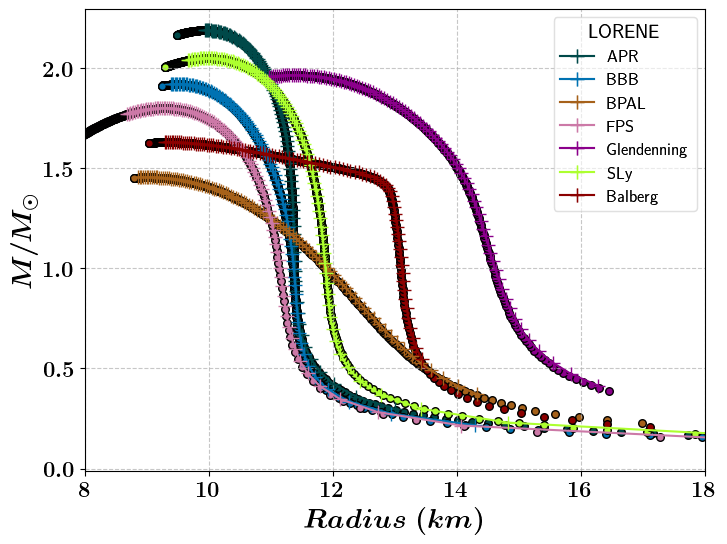

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from tqdm import tqdm
from scipy.integrate import solve_ivp
import pandas as pd
import os
import re
import csv

G = 6.6743e-8  # cm^3/g/s^2
c = 29979245800     # cm/s

# Array of EOS names
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
source_dir = '/home/sanjana/ashoka/thesis/EoS/'  # Directory containing EOS files

# Define markers and colors for different EOS
markers = ['+', '+', '+', '+', '+', '+', '+']
colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#ADFF2F", "#8B0000"]

eos_results = {}

# Loop over each EOS
for eos_name in eos_names:
    data = np.genfromtxt(f"{source_dir}eos_{eos_name}.txt", delimiter=None)
    baryon_density = data[:, 1]
    density = data[:, 2]
    pressure = data[:, 3]

    min_density = 2.4e14 #np.min(density) #1e14  # Lower bound on central density
    max_density = np.max(density)
    
    valid_indices = (density > 0) & (pressure > 0)
    density = density[valid_indices]
    pressure = pressure[valid_indices]
    baryon_density = baryon_density[valid_indices]
    
    log_density = np.log(density)
    log_pressure = np.log(pressure)
    '''
    log_pressure_to_log_density = CubicSpline(log_pressure, log_density)
    log_density_to_log_pressure = CubicSpline(log_density, log_pressure)

    '''
    log_pressure_to_log_density = interp1d(log_pressure, log_density, kind='linear', bounds_error=True)
    log_density_to_log_pressure = interp1d(log_density, log_pressure, kind='linear', bounds_error=True)
    #'''
    
    def pressure_to_density(pressure):
        log_pressure = np.log(pressure)
        # Determine the valid range
        min_log_p, max_log_p = log_pressure_to_log_density.x[0], log_pressure_to_log_density.x[-1]
    
        # Clip values outside the interpolation range and show a warning
        if log_pressure < min_log_p or log_pressure > max_log_p:
            clipped_value = np.exp(np.clip(log_pressure, min_log_p, max_log_p))
            print(f"Warning: Extrapolation detected for pressure {pressure:.4e}, clipping to {clipped_value:.4e}.")
            log_pressure = np.clip(log_pressure, min_log_p, max_log_p)
    
        log_density = log_pressure_to_log_density(log_pressure)
        return np.exp(log_density)
    
    def density_to_pressure(density):
        log_density = np.log(density)
        # Determine the valid range
        min_log_rho, max_log_rho = log_density_to_log_pressure.x[0], log_density_to_log_pressure.x[-1]
    
        # Clip values outside the interpolation range and show a warning
        if log_density < min_log_rho or log_density > max_log_rho:
            clipped_value = np.exp(np.clip(log_density, min_log_rho, max_log_rho))
            print(f"Warning: Extrapolation detected for density {density:.4e}, clipping to {clipped_value:.4e}.")
            log_density = np.clip(log_density, min_log_rho, max_log_rho)
    
        log_pressure = log_density_to_log_pressure(log_density)
        return np.exp(log_pressure)

    # TOV equations
    def compute_derivatives(r, state_vars, eos_type):
        mass, pressure = state_vars

        if pressure <= 1e-10 * density_to_pressure(min_density):  # Stop condition
            return [0, 0]

        density = pressure_to_density(pressure)
        dm_dr = 4.0 * np.pi * (r**2) * density
        dP_dr = -(((G * mass * density) / (r**2)) * (1 + (pressure / (density * c * c))) *
                  (1 + ((4 * np.pi * pressure * (r**3)) / (mass * c * c)))) / (1 - ((2 * G * mass) / (r * c * c)))
        return [dm_dr, dP_dr]

    # Stopping condition for solve_ivp
    def pressure_stop_condition(r, y, eos_type):
        return y[1] - 1e-10 * density_to_pressure(min_density)  # Stop when P < threshold

    pressure_stop_condition.terminal = True  # Stop integration
    pressure_stop_condition.direction = -1  # Stop when pressure is decreasing

    # Solve the neutron star structure
    def solve_neutron_star_structure(central_density, eos_type):
        initial_pressure = density_to_pressure(central_density)
        state_variables_initial = [1e-10, initial_pressure]  # Small initial mass

        sol = solve_ivp(compute_derivatives, [1e-2, 2e6], state_variables_initial, method="LSODA",
                        rtol=1e-5, atol=1e-5, args=(eos_type,), events=pressure_stop_condition)

        final_radius = sol.t[-1]
        final_mass = sol.y[0, -1]
        return final_radius, final_mass
    #'''
    '''
    def solve_neutron_star_structure(central_density, eos_type):
        initial_pressure = density_to_pressure(central_density)
        state_variables_initial = [1e-3, initial_pressure]
    
        def wrapper(r, y):
            return compute_derivatives(y, r, eos_type)
    
        # Use an implicit solver (Radau or BDF)  
        sol = solve_ivp(wrapper, [50, 2e6], state_variables_initial, method="LSODA", rtol=1e-5, atol=1e-5)
    
        radii = sol.t
        mass_profile = sol.y[0]
        pressure_profile = sol.y[1]
    
        termination_index = np.argmax(pressure_profile < 1e-10 * initial_pressure)
        if termination_index == 0:
            termination_index = -1
    
        final_radius = radii[termination_index]
        final_mass = mass_profile[termination_index]
        return final_radius, final_mass
    '''
    
    central_densities = np.linspace(min_density, max_density, 500)
    results = np.zeros([2, len(central_densities)])

    for i in tqdm(range(len(central_densities)), desc=f"Processing {eos_name}"):
        results[:, i] = solve_neutron_star_structure(central_densities[i], eos_name)

    radius = results[0,] / 1e5  # Convert to km
    mass = results[1,] / 1.989e33  # Convert to solar masses
    eos_results[eos_name] = (central_densities, radius, mass)

# Loop over each EOS to save its results to a CSV file
for eos_name, (central_densities, radius, mass) in eos_results.items():
    # Create a DataFrame to store the data
    df = pd.DataFrame({
        'Central Density (g/cm^3)': central_densities,
        'Radius (km)': radius,
        'Mass (M_sun)': mass
    })

    # Define the file path
    file_path = f"/home/sanjana/ashoka/thesis/output_lsoda/{eos_name}_LSODA.csv"
    
    # Save the DataFrame to a CSV file
    df.to_csv(file_path, index=False)

    print(f"Results for {eos_name} saved to {file_path}")

##############################################################################################

# Dictionary for pretty axis labels
units = {
    "Central enthalpy": r"Log Central enthalpy (c$^2$)",
    "Central proper baryon density": r"Log Central baryon density (g/cm$^3$)",
    "Gravitational mass": r"Gravitational mass ($M_\odot$)",
    "Mean radius": r"Mean radius (km)",
    "Moment of inertia": r"Moment of inertia (10$^{45}$ gcm$^2$)",
    "Compactness": r"Compactness (GM/Rc$^2$)"
}

# Define colors and markers for distinction
colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#ADFF2F", "#8B0000"]
marker_size = 10  # Reduce marker size here

#################################################################

# List of EOS files and their labels (Stationary Neutron Star)
eos_files_stationary = {
    "APR": "Nrotstar_(APR100)_(0.06-0.9)_stat_extracted_data.csv",
    "BBB": "Nrotstar_(BBB100)_(0.05-0.8)_stat_extracted_data.csv",
    "BPAL": "Nrotstar_(BPAL100)_(0.06-0.6)_stat_extracted_data.csv",
    "FPS": "Nrotstar_(FPS100)_(0.04-0.9)_stat_extracted_data.csv",
    "Glendenning": "Nrotstar_(Glendenning100)_(0.06-0.68)_stat_extracted_data.csv",
    "SLy": "Nrotstar_(SLy100)_(0.04-0.9)_stat_extracted_data.csv",
    "Balberg": "Nrotstar_(Balberg100)_(0.08-0.7)_stat_extracted_data.csv"
}

# Column pairs for plotting
columns = [
    ("Mean radius", "Gravitational mass"),
]
eos_handles = []
# Plot for stationary neutron stars
for x_col, y_col in columns:
    plt.figure(figsize=(8,6))

    for (eos, file), color, marker in zip(eos_files_stationary.items(), colors, markers):
        df = pd.read_csv(file)
        
        # Convert numeric columns properly
        for col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                pass  # Ignore non-numeric columns

        # Filter out invalid values
        df = df[(df[x_col] != "N/A") & (df[y_col] != "N/A")]
        df[x_col] = df[x_col].astype(float)
        df[y_col] = df[y_col].astype(float)

        # Plot data with reduced marker size
        line, = plt.plot(df[x_col], df[y_col], marker=marker, linestyle="-", color=color, 
                 label=eos, markersize=marker_size)
        eos_handles.append(line)

##############################################################################################
markers = ["o", "o", "o", "o", "o", "o", "o"]
#plt.figure()
#plt.title(r"Stationary NS Plot: Mass vs Radius")
#plt.ylabel(r"Mass of the Star [$M_\odot$]")
#plt.xlabel(r"Radius of the Star [km]")
for eos_name, (central_densities, radius, mass), marker, color in zip(eos_results.keys(), eos_results.values(), markers, colors):
    plt.scatter(radius, mass, label=f"{eos_name}", marker=marker, color=color, s=30, edgecolor="black")

plt.xlabel(r'$Radius \ (km)$', fontsize=20)
plt.ylabel(r'$M/M_\odot$', fontsize=20)
plt.xlim(8,18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
first_legend = plt.legend(handles=eos_handles, title="LORENE", fontsize=12, loc='upper right', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/M_vs_R_comp.pdf')
plt.show()

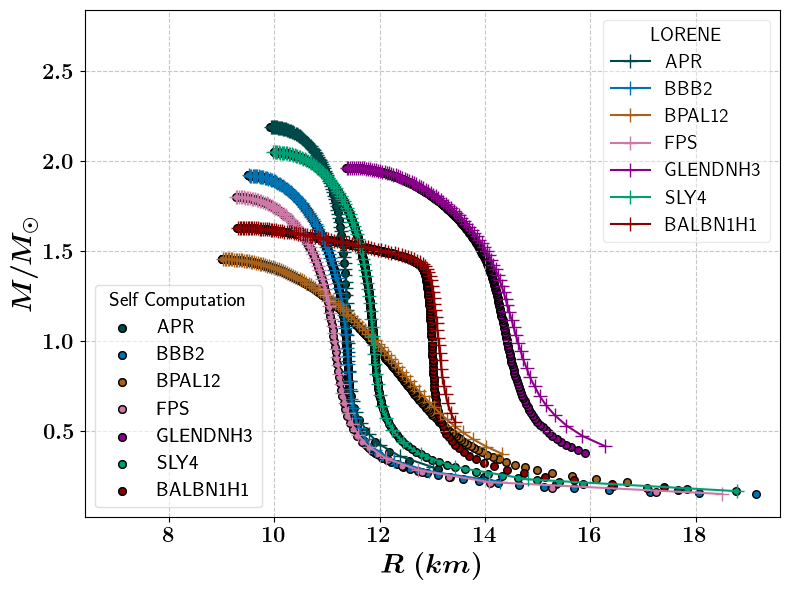

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Define colors, markers, and other plot settings
colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B", "#009E73", "#8B0000"]
markers = ['+', '+', '+', '+', '+', '+', '+']
marker_size = 10

# List of EOS files and their labels (Stationary Neutron Star)
eos_files_stationary = {
    "APR": "Nrotstar_(APR100)_(0.06-0.9)_stat_extracted_data.csv",
    "BBB2": "Nrotstar_(BBB100)_(0.05-0.8)_stat_extracted_data.csv",
    "BPAL12": "Nrotstar_(BPAL100)_(0.06-0.6)_stat_extracted_data.csv",
    "FPS": "Nrotstar_(FPS100)_(0.04-0.9)_stat_extracted_data.csv",
    "GLENDNH3": "Nrotstar_(Glendenning100)_(0.06-0.68)_stat_extracted_data.csv",
    "SLY4": "Nrotstar_(SLy100)_(0.04-0.9)_stat_extracted_data.csv",
    "BALBN1H1": "Nrotstar_(Balberg100)_(0.08-0.7)_stat_extracted_data.csv"
}

# Folder path for LSODA results
lsoda_folder = "/home/sanjana/ashoka/thesis/output_lsoda"

# Column pairs for plotting
columns = [
    ("Mean radius", "Gravitational mass"),
]
eos_handles = []

# Plot for stationary neutron stars (LORENE)
for x_col, y_col in columns:
    plt.figure(figsize=(8,6))

    # Loop over stationary EOS files and plot them
    for (eos, file), color, marker in zip(eos_files_stationary.items(), colors, markers):
        df = pd.read_csv(file)
        
        # Convert numeric columns properly
        for col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                pass  # Ignore non-numeric columns

        # Filter out invalid values
        df = df[(df[x_col] != "N/A") & (df[y_col] != "N/A")]
        df[x_col] = df[x_col].astype(float)
        df[y_col] = df[y_col].astype(float)

        # Apply the filtering logic to keep only increasing mass values
        mass_values_raw = df[y_col].values  # 'Gravitational mass'
        radius_values_raw = df[x_col].values  # 'Mean radius'

        # Apply the filtering logic to keep only increasing mass values
        valid_indices = [0]
        for i in range(1, len(mass_values_raw)):
            if mass_values_raw[i] > mass_values_raw[valid_indices[-1]]:
                valid_indices.append(i)

        # Apply the filter to both mass and radius values
        mass_values = mass_values_raw[valid_indices]
        radius_values = radius_values_raw[valid_indices]

        # Plot data with reduced marker size
        line, = plt.plot(radius_values, mass_values, marker=marker, linestyle="-", color=color, 
                         label=f"{eos}", markersize=marker_size)
        eos_handles.append(line)
                          
    eos_handles2 = []
                           
    # Loop over LSODA files in the folder and plot them
    lsoda_markers = ["o", "o", "o", "o", "o", "o", "o"]  # Use the same markers
    eos_names = ["apr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
    
    # Iterate over the eos_names and construct the correct file names
    for eos_name, marker, color in zip(eos_names, lsoda_markers, colors):
        # Construct the file name corresponding to each EOS name
        lsoda_file = f"{eos_name}_cspline_LSODA.csv"
        
        # Construct the full path for each file
        file_path = os.path.join(lsoda_folder, lsoda_file)
        
        df_lsoda = pd.read_csv(file_path)
        
        # Assuming the columns are "Radius" and "Mass"
        # Filter out invalid values
        df_lsoda = df_lsoda[(df_lsoda["Radius (km)"] != "N/A") & (df_lsoda["Mass (M_sun)"] != "N/A")]
        df_lsoda["Radius (km)"] = pd.to_numeric(df_lsoda["Radius (km)"])
        df_lsoda["Mass (M_sun)"] = pd.to_numeric(df_lsoda["Mass (M_sun)"])

        # Filter out invalid entries (NaN values)
        df_lsoda = df_lsoda.dropna(subset=["Radius (km)", "Mass (M_sun)"])

        # Extract raw mass and radius values
        mass_values_raw = df_lsoda["Mass (M_sun)"].values
        radius_values_raw = df_lsoda["Radius (km)"].values

        # Apply the filtering logic to keep only increasing mass values
        valid_indices = [0]
        for i in range(1, len(mass_values_raw)):
            if mass_values_raw[i] > mass_values_raw[valid_indices[-1]]:
                valid_indices.append(i)

        # Apply the filter to both mass and radius values
        mass_values = mass_values_raw[valid_indices]
        radius_values = radius_values_raw[valid_indices]

        # Plot the data for LSODA
        line2 = plt.scatter(radius_values, mass_values, label=f"{eos_name.upper()}",marker=marker, color=color, s=30, edgecolor="black")
        #line2, = plt.plot(radius_values, mass_values, label=f"{eos_name.upper()}",marker=marker, color=color, linewidth=2, markeredgecolor="black")
        eos_handles2.append(line2)
        
    plt.xlabel(r'$R\ (km)$', fontsize=20)
    plt.ylabel(r'$M/M_\odot$', fontsize=20)
    plt.xlim(8,18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(linestyle='--', alpha=0.7)
    
    # Legend handling
    first_legend = plt.legend(handles=eos_handles, title="LORENE", fontsize=14, loc='upper right', title_fontsize=14, framealpha=0.4)
    plt.gca().add_artist(first_legend)
    
    # Add another legend for LSODA results
    second_legend = plt.legend(handles=eos_handles2,title="Self Computation", fontsize=14, loc='lower left', title_fontsize=14, framealpha=0.4)
    plt.gca().add_artist(second_legend)
    plt.xlim(6.4, 19.6)
    plt.ylim(0.02, 2.84)
    plt.tight_layout()
    plt.savefig('/home/sanjana/ashoka/thesis/finalplots/M_vs_R_comp2.pdf')
    plt.savefig('/home/sanjana/ashoka/thesis/finalplots/M_vs_R_comp2.png',dpi=600)
    plt.show()

In [16]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from numba import njit
from tqdm import tqdm
import time
import multiprocessing
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import seaborn as sns
#'''
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
#'''
plt.rcParams['text.usetex'] = True

Processing balbn1h1: 100%|████████████████████| 100/100 [00:06<00:00, 14.98it/s]


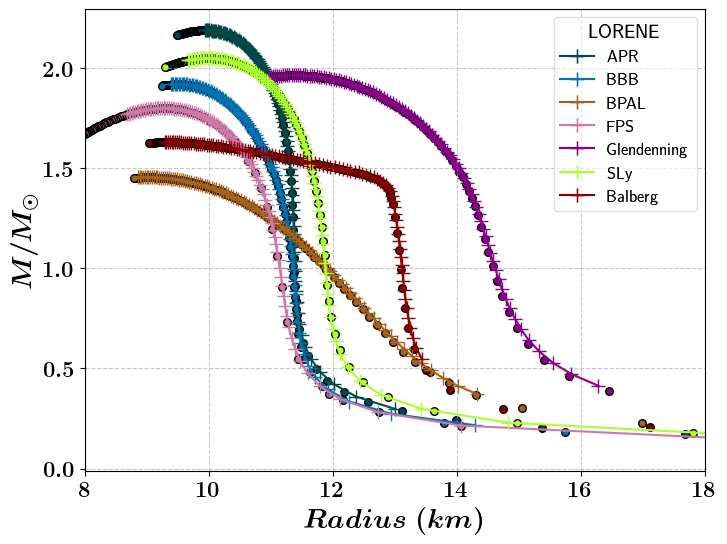

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from tqdm import tqdm
from scipy.integrate import solve_ivp
import pandas as pd
import os
import re
import csv

G = 6.6743e-8  # cm^3/g/s^2
c = 29979245800     # cm/s

# Array of EOS names
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
source_dir = '/home/sanjana/ashoka/thesis/EoS/'  # Directory containing EOS files

# Define markers and colors for different EOS
markers = ['+', '+', '+', '+', '+', '+', '+']
colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#ADFF2F", "#8B0000"]

eos_results = {}

# Loop over each EOS
for eos_name in eos_names:
    data = np.genfromtxt(f"{source_dir}eos_{eos_name}.txt", delimiter=None)
    baryon_density = data[:, 1]
    density = data[:, 2]
    pressure = data[:, 3]

    min_density = 2.4e14 #np.min(density) #1e14  # Lower bound on central density
    max_density = np.max(density)
    
    valid_indices = (density > 0) & (pressure > 0)
    density = density[valid_indices]
    pressure = pressure[valid_indices]
    baryon_density = baryon_density[valid_indices]
    
    log_density = np.log(density)
    log_pressure = np.log(pressure)

    '''
    log_pressure_to_log_density = CubicSpline(log_pressure, log_density)
    log_density_to_log_pressure = CubicSpline(log_density, log_pressure)
    '''

    log_pressure_to_log_density = interp1d(log_pressure, log_density, kind='linear', bounds_error=True)
    log_density_to_log_pressure = interp1d(log_density, log_pressure, kind='linear', bounds_error=True)

    def pressure_to_density(pressure):
        log_pressure = np.log(pressure)
        # Determine the valid range
        min_log_p, max_log_p = log_pressure_to_log_density.x[0], log_pressure_to_log_density.x[-1]
    
        # Clip values outside the interpolation range and show a warning
        if log_pressure < min_log_p or log_pressure > max_log_p:
            clipped_value = np.exp(np.clip(log_pressure, min_log_p, max_log_p))
            print(f"Warning: Extrapolation detected for pressure {pressure:.4e}, clipping to {clipped_value:.4e}.")
            log_pressure = np.clip(log_pressure, min_log_p, max_log_p)
    
        log_density = log_pressure_to_log_density(log_pressure)
        return np.exp(log_density)
    
    def density_to_pressure(density):
        log_density = np.log(density)
        # Determine the valid range
        min_log_rho, max_log_rho = log_density_to_log_pressure.x[0], log_density_to_log_pressure.x[-1]
    
        # Clip values outside the interpolation range and show a warning
        if log_density < min_log_rho or log_density > max_log_rho:
            clipped_value = np.exp(np.clip(log_density, min_log_rho, max_log_rho))
            print(f"Warning: Extrapolation detected for density {density:.4e}, clipping to {clipped_value:.4e}.")
            log_density = np.clip(log_density, min_log_rho, max_log_rho)
    
        log_pressure = log_density_to_log_pressure(log_density)
        return np.exp(log_pressure)

    # TOV equations
    def compute_derivatives(r, state_vars, eos_type):
        mass, pressure = state_vars

        if pressure <= 1e-10 * density_to_pressure(min_density):  # Stop condition
            return [0, 0]

        density = pressure_to_density(pressure)
        dm_dr = 4.0 * np.pi * (r**2) * density
        dP_dr = -(((G * mass * density) / (r**2)) * (1 + (pressure / (density * c * c))) *
                  (1 + ((4 * np.pi * pressure * (r**3)) / (mass * c * c)))) / (1 - ((2 * G * mass) / (r * c * c)))
        return [dm_dr, dP_dr]

    # Stopping condition for solve_ivp
    def pressure_stop_condition(r, y, eos_type):
        return y[1] - 1e-10 * density_to_pressure(min_density)  # Stop when P < threshold

    pressure_stop_condition.terminal = True  # Stop integration
    pressure_stop_condition.direction = -1  # Stop when pressure is decreasing

    # Solve the neutron star structure
    def solve_neutron_star_structure(central_density, eos_type):
        initial_pressure = density_to_pressure(central_density)
        state_variables_initial = [1e-10, initial_pressure]  # Small initial mass

        sol = solve_ivp(compute_derivatives, [1e-2, 2e6], state_variables_initial, method="LSODA",
                        rtol=1e-5, atol=1e-5, args=(eos_type,), events=pressure_stop_condition)

        final_radius = sol.t[-1]
        final_mass = sol.y[0, -1]
        return final_radius, final_mass
    #'''
    '''
    def solve_neutron_star_structure(central_density, eos_type):
        initial_pressure = density_to_pressure(central_density)
        state_variables_initial = [1e-3, initial_pressure]
    
        def wrapper(r, y):
            return compute_derivatives(y, r, eos_type)
    
        # Use an implicit solver (Radau or BDF)  
        sol = solve_ivp(wrapper, [50, 2e6], state_variables_initial, method="LSODA", rtol=1e-5, atol=1e-5)
    
        radii = sol.t
        mass_profile = sol.y[0]
        pressure_profile = sol.y[1]
    
        termination_index = np.argmax(pressure_profile < 1e-10 * initial_pressure)
        if termination_index == 0:
            termination_index = -1
    
        final_radius = radii[termination_index]
        final_mass = mass_profile[termination_index]
        return final_radius, final_mass
    '''
    
    central_densities = np.linspace(min_density, max_density, 100)
    results = np.zeros([2, len(central_densities)])

    for i in tqdm(range(len(central_densities)), desc=f"Processing {eos_name}"):
        results[:, i] = solve_neutron_star_structure(central_densities[i], eos_name)

    radius = results[0,] / 1e5  # Convert to km
    mass = results[1,] / 1.989e33  # Convert to solar masses
    eos_results[eos_name] = (central_densities, radius, mass)

##############################################################################################

# Dictionary for pretty axis labels
units = {
    "Central enthalpy": r"Log Central enthalpy (c$^2$)",
    "Central proper baryon density": r"Log Central baryon density (g/cm$^3$)",
    "Gravitational mass": r"Gravitational mass ($M_\odot$)",
    "Mean radius": r"Mean radius (km)",
    "Moment of inertia": r"Moment of inertia (10$^{45}$ gcm$^2$)",
    "Compactness": r"Compactness (GM/Rc$^2$)"
}

# Define colors and markers for distinction
colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#ADFF2F", "#8B0000"]
marker_size = 10  # Reduce marker size here

#################################################################

# List of EOS files and their labels (Stationary Neutron Star)
eos_files_stationary = {
    "APR": "Nrotstar_(APR100)_(0.06-0.9)_stat_extracted_data.csv",
    "BBB": "Nrotstar_(BBB100)_(0.05-0.8)_stat_extracted_data.csv",
    "BPAL": "Nrotstar_(BPAL100)_(0.06-0.6)_stat_extracted_data.csv",
    "FPS": "Nrotstar_(FPS100)_(0.04-0.9)_stat_extracted_data.csv",
    "Glendenning": "Nrotstar_(Glendenning100)_(0.06-0.68)_stat_extracted_data.csv",
    "SLy": "Nrotstar_(SLy100)_(0.04-0.9)_stat_extracted_data.csv",
    "Balberg": "Nrotstar_(Balberg100)_(0.08-0.7)_stat_extracted_data.csv"
}

# Column pairs for plotting
columns = [
    ("Mean radius", "Gravitational mass"),
]
eos_handles = []
# Plot for stationary neutron stars
for x_col, y_col in columns:
    plt.figure(figsize=(8,6))

    for (eos, file), color, marker in zip(eos_files_stationary.items(), colors, markers):
        df = pd.read_csv(file)
        
        # Convert numeric columns properly
        for col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                pass  # Ignore non-numeric columns

        # Filter out invalid values
        df = df[(df[x_col] != "N/A") & (df[y_col] != "N/A")]
        df[x_col] = df[x_col].astype(float)
        df[y_col] = df[y_col].astype(float)

        # Plot data with reduced marker size
        line, = plt.plot(df[x_col], df[y_col], marker=marker, linestyle="-", color=color, 
                 label=eos, markersize=marker_size)
        eos_handles.append(line)

##############################################################################################
markers = ["o", "o", "o", "o", "o", "o", "o"]
#plt.figure()
#plt.title(r"Stationary NS Plot: Mass vs Radius")
#plt.ylabel(r"Mass of the Star [$M_\odot$]")
#plt.xlabel(r"Radius of the Star [km]")
for eos_name, (central_densities, radius, mass), marker, color in zip(eos_results.keys(), eos_results.values(), markers, colors):
    plt.scatter(radius, mass, label=f"{eos_name}", marker=marker, color=color, s=30, edgecolor="black")

plt.xlabel(r'$Radius \ (km)$', fontsize=20)
plt.ylabel(r'$M/M_\odot$', fontsize=20)
plt.xlim(8,18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
first_legend = plt.legend(handles=eos_handles, title="LORENE", fontsize=12, loc='upper right', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/M_vs_R_comp.pdf')
plt.show()

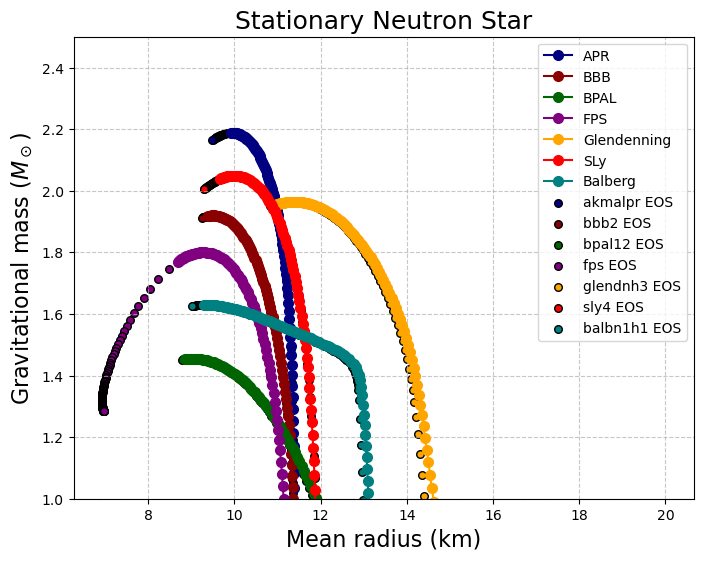

In [7]:
marker_size = 7  # Reduce marker size here
# Plot for stationary neutron stars
for x_col, y_col in columns:
    plt.figure(figsize=(8,6))

    for (eos, file), color, marker in zip(eos_files_stationary.items(), colors, markers):
        df = pd.read_csv(file)
        
        # Convert numeric columns properly
        for col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                pass  # Ignore non-numeric columns

        # Filter out invalid values
        df = df[(df[x_col] != "N/A") & (df[y_col] != "N/A")]
        df[x_col] = df[x_col].astype(float)
        df[y_col] = df[y_col].astype(float)

        # Plot data with reduced marker size
        plt.plot(df[x_col], df[y_col], marker=marker, linestyle="-", color=color, 
                 label=eos, markersize=marker_size)

    plt.xlabel(units.get(x_col, x_col), fontsize=16)
    plt.ylabel(units.get(y_col, y_col), fontsize=16)
    plt.title("Stationary Neutron Star", fontsize=18)
    plt.legend(title="EOS Models", fontsize=12)
    plt.grid(linestyle='--', alpha=0.7)

##############################################################################################
markers = ["o", "o", "o", "o", "o", "o", "o"]
#plt.figure()
#plt.title(r"Stationary NS Plot: Mass vs Radius")
#plt.ylabel(r"Mass of the Star [$M_\odot$]")
#plt.xlabel(r"Radius of the Star [km]")
for eos_name, (central_densities, radius, mass), marker, color in zip(eos_results.keys(), eos_results.values(), markers, colors):
    plt.scatter(radius, mass, label=f"{eos_name} EOS", marker=marker, color=color, s=30, edgecolor="black")
plt.legend()
plt.ylim(1,2.5)
plt.savefig("MvsRStat_Comparison_1M.png")
plt.show()

# DEBUG

<>:266: SyntaxWarning: invalid escape sequence '\o'
<>:266: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_704464/3552322655.py:266: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("Mass ($M_\odot$)", fontsize=16)
Processing akmalpr:   3%|▋                      | 3/100 [00:00<00:04, 23.51it/s]

Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Stopped at r=1783722.3071 cm due to pressure threshold.
Stopped at r=1546078.4937 cm due to pressure threshold.


Processing akmalpr:   9%|██                     | 9/100 [00:00<00:04, 20.60it/s]

Stopped at r=1405244.9043 cm due to pressure threshold.
Stopped at r=1316804.1329 cm due to pressure threshold.
Stopped at r=1259364.0056 cm due to pressure threshold.
Stopped at r=1220547.9880 cm due to pressure threshold.
Stopped at r=1193597.7719 cm due to pressure threshold.


Processing akmalpr:  12%|██▋                   | 12/100 [00:00<00:04, 19.58it/s]

Stopped at r=1174787.2578 cm due to pressure threshold.
Stopped at r=1161828.6515 cm due to pressure threshold.
Stopped at r=1152975.9881 cm due to pressure threshold.
Stopped at r=1147133.4959 cm due to pressure threshold.


Processing akmalpr:  16%|███▌                  | 16/100 [00:00<00:04, 19.05it/s]

Stopped at r=1143326.3371 cm due to pressure threshold.
Stopped at r=1140923.1004 cm due to pressure threshold.
Stopped at r=1139474.1083 cm due to pressure threshold.
Stopped at r=1138541.2673 cm due to pressure threshold.


Processing akmalpr:  21%|████▌                 | 21/100 [00:01<00:04, 19.64it/s]

Stopped at r=1137908.3653 cm due to pressure threshold.
Stopped at r=1137392.4119 cm due to pressure threshold.
Stopped at r=1136830.2739 cm due to pressure threshold.
Stopped at r=1136126.0157 cm due to pressure threshold.
Stopped at r=1135250.6695 cm due to pressure threshold.


Processing akmalpr:  25%|█████▌                | 25/100 [00:01<00:03, 19.19it/s]

Stopped at r=1134160.2234 cm due to pressure threshold.
Stopped at r=1132832.8945 cm due to pressure threshold.
Stopped at r=1131271.2979 cm due to pressure threshold.
Stopped at r=1129462.1491 cm due to pressure threshold.


Processing akmalpr:  29%|██████▍               | 29/100 [00:01<00:03, 19.14it/s]

Stopped at r=1127458.6906 cm due to pressure threshold.
Stopped at r=1125255.8738 cm due to pressure threshold.
Stopped at r=1122853.2206 cm due to pressure threshold.
Stopped at r=1120308.6033 cm due to pressure threshold.


Processing akmalpr:  34%|███████▍              | 34/100 [00:01<00:03, 19.56it/s]

Stopped at r=1117592.3947 cm due to pressure threshold.
Stopped at r=1114780.1969 cm due to pressure threshold.
Stopped at r=1111836.3782 cm due to pressure threshold.
Stopped at r=1108816.0028 cm due to pressure threshold.


Processing akmalpr:  36%|███████▉              | 36/100 [00:01<00:03, 18.76it/s]

Stopped at r=1105719.1945 cm due to pressure threshold.
Stopped at r=1102558.1429 cm due to pressure threshold.
Stopped at r=1099355.8997 cm due to pressure threshold.
Stopped at r=1096120.6774 cm due to pressure threshold.


Processing akmalpr:  41%|█████████             | 41/100 [00:02<00:03, 19.41it/s]

Stopped at r=1092852.4026 cm due to pressure threshold.
Stopped at r=1089558.8335 cm due to pressure threshold.
Stopped at r=1086268.2023 cm due to pressure threshold.
Stopped at r=1082969.3464 cm due to pressure threshold.


Processing akmalpr:  45%|█████████▉            | 45/100 [00:02<00:02, 19.64it/s]

Stopped at r=1079682.4664 cm due to pressure threshold.
Stopped at r=1076415.5735 cm due to pressure threshold.
Stopped at r=1073168.1343 cm due to pressure threshold.
Stopped at r=1069944.4620 cm due to pressure threshold.
Stopped at r=1066742.7772 cm due to pressure threshold.


Processing akmalpr:  50%|███████████           | 50/100 [00:02<00:02, 19.78it/s]

Stopped at r=1063565.1719 cm due to pressure threshold.
Stopped at r=1060425.5010 cm due to pressure threshold.
Stopped at r=1057308.5901 cm due to pressure threshold.
Stopped at r=1054250.3447 cm due to pressure threshold.


Processing akmalpr:  54%|███████████▉          | 54/100 [00:02<00:02, 18.75it/s]

Stopped at r=1051206.5285 cm due to pressure threshold.
Stopped at r=1048212.8146 cm due to pressure threshold.
Stopped at r=1045240.4495 cm due to pressure threshold.
Stopped at r=1042324.7043 cm due to pressure threshold.


Processing akmalpr:  58%|████████████▊         | 58/100 [00:02<00:02, 18.96it/s]

Stopped at r=1039458.1007 cm due to pressure threshold.
Stopped at r=1036611.5145 cm due to pressure threshold.
Stopped at r=1033811.6615 cm due to pressure threshold.
Stopped at r=1031069.2949 cm due to pressure threshold.


Processing akmalpr:  62%|█████████████▋        | 62/100 [00:03<00:02, 18.57it/s]

Stopped at r=1028373.3267 cm due to pressure threshold.
Stopped at r=1025709.6386 cm due to pressure threshold.
Stopped at r=1023064.8288 cm due to pressure threshold.
Stopped at r=1020488.1474 cm due to pressure threshold.


Processing akmalpr:  66%|██████████████▌       | 66/100 [00:03<00:01, 18.57it/s]

Stopped at r=1017946.9656 cm due to pressure threshold.
Stopped at r=1015441.9483 cm due to pressure threshold.
Stopped at r=1012959.2078 cm due to pressure threshold.
Stopped at r=1010556.9871 cm due to pressure threshold.


Processing akmalpr:  70%|███████████████▍      | 70/100 [00:03<00:01, 17.95it/s]

Stopped at r=1008188.2426 cm due to pressure threshold.
Stopped at r=1005826.6259 cm due to pressure threshold.
Stopped at r=1003502.4583 cm due to pressure threshold.
Stopped at r=1001206.4107 cm due to pressure threshold.


Processing akmalpr:  74%|████████████████▎     | 74/100 [00:03<00:01, 18.47it/s]

Stopped at r=998990.3574 cm due to pressure threshold.
Stopped at r=996852.8862 cm due to pressure threshold.
Stopped at r=994692.7044 cm due to pressure threshold.
Stopped at r=992531.9507 cm due to pressure threshold.


Processing akmalpr:  78%|█████████████████▏    | 78/100 [00:04<00:01, 17.21it/s]

Stopped at r=990405.0865 cm due to pressure threshold.
Stopped at r=988353.9632 cm due to pressure threshold.
Stopped at r=986358.3335 cm due to pressure threshold.
Stopped at r=984362.7437 cm due to pressure threshold.


Processing akmalpr:  82%|██████████████████    | 82/100 [00:04<00:01, 17.94it/s]

Stopped at r=982391.9516 cm due to pressure threshold.
Stopped at r=980445.3321 cm due to pressure threshold.
Stopped at r=978555.4673 cm due to pressure threshold.
Stopped at r=976685.7686 cm due to pressure threshold.


Processing akmalpr:  86%|██████████████████▉   | 86/100 [00:04<00:00, 18.38it/s]

Stopped at r=974828.1246 cm due to pressure threshold.
Stopped at r=972997.1210 cm due to pressure threshold.
Stopped at r=971197.5699 cm due to pressure threshold.
Stopped at r=969464.3601 cm due to pressure threshold.


Processing akmalpr:  90%|███████████████████▊  | 90/100 [00:04<00:00, 18.43it/s]

Stopped at r=967754.9477 cm due to pressure threshold.
Stopped at r=966056.1853 cm due to pressure threshold.
Stopped at r=964378.6283 cm due to pressure threshold.
Stopped at r=962691.0225 cm due to pressure threshold.


Processing akmalpr:  94%|████████████████████▋ | 94/100 [00:04<00:00, 17.55it/s]

Stopped at r=961048.9198 cm due to pressure threshold.
Stopped at r=959447.9556 cm due to pressure threshold.
Stopped at r=957861.7454 cm due to pressure threshold.
Stopped at r=956301.7968 cm due to pressure threshold.


Processing akmalpr:  98%|█████████████████████▌| 98/100 [00:05<00:00, 17.72it/s]

Stopped at r=954771.4638 cm due to pressure threshold.
Stopped at r=953275.5352 cm due to pressure threshold.
Stopped at r=951772.9680 cm due to pressure threshold.
Stopped at r=950309.0810 cm due to pressure threshold.


Processing akmalpr: 100%|█████████████████████| 100/100 [00:05<00:00, 18.75it/s]


Stopped at r=948854.5407 cm due to pressure threshold.


Processing bbb2:   4%|█                         | 4/100 [00:00<00:03, 27.69it/s]

Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Stopped at r=1573355.9070 cm due to pressure threshold.
Stopped at r=1361153.2781 cm due to pressure threshold.


Processing bbb2:   7%|█▊                        | 7/100 [00:00<00:04, 20.39it/s]

Stopped at r=1259403.8822 cm due to pressure threshold.
Stopped at r=1206698.6398 cm due to pressure threshold.
Stopped at r=1178086.6530 cm due to pressure threshold.
Stopped at r=1162103.7084 cm due to pressure threshold.


Processing bbb2:  12%|███                      | 12/100 [00:00<00:05, 17.31it/s]

Stopped at r=1153000.9004 cm due to pressure threshold.
Stopped at r=1147715.6870 cm due to pressure threshold.
Stopped at r=1144567.0622 cm due to pressure threshold.
Stopped at r=1142565.2363 cm due to pressure threshold.


Processing bbb2:  16%|████                     | 16/100 [00:00<00:05, 16.02it/s]

Stopped at r=1141150.1040 cm due to pressure threshold.
Stopped at r=1139984.3803 cm due to pressure threshold.
Stopped at r=1138834.6727 cm due to pressure threshold.
Stopped at r=1137590.8676 cm due to pressure threshold.


Processing bbb2:  20%|█████                    | 20/100 [00:01<00:04, 16.62it/s]

Stopped at r=1136193.6228 cm due to pressure threshold.
Stopped at r=1134619.0558 cm due to pressure threshold.
Stopped at r=1132836.3391 cm due to pressure threshold.
Stopped at r=1130831.4708 cm due to pressure threshold.


Processing bbb2:  25%|██████▎                  | 25/100 [00:01<00:04, 18.41it/s]

Stopped at r=1128643.3341 cm due to pressure threshold.
Stopped at r=1126248.6018 cm due to pressure threshold.
Stopped at r=1123672.5708 cm due to pressure threshold.
Stopped at r=1120930.6557 cm due to pressure threshold.
Stopped at r=1118022.7849 cm due to pressure threshold.


Processing bbb2:  29%|███████▏                 | 29/100 [00:01<00:03, 18.71it/s]

Stopped at r=1114978.2980 cm due to pressure threshold.
Stopped at r=1111807.6402 cm due to pressure threshold.
Stopped at r=1108524.1213 cm due to pressure threshold.
Stopped at r=1105146.3538 cm due to pressure threshold.


Processing bbb2:  33%|████████▎                | 33/100 [00:01<00:03, 18.83it/s]

Stopped at r=1101693.3903 cm due to pressure threshold.
Stopped at r=1098176.1263 cm due to pressure threshold.
Stopped at r=1094616.9189 cm due to pressure threshold.
Stopped at r=1090998.3235 cm due to pressure threshold.


Processing bbb2:  37%|█████████▎               | 37/100 [00:02<00:03, 19.06it/s]

Stopped at r=1087362.0116 cm due to pressure threshold.
Stopped at r=1083709.4881 cm due to pressure threshold.
Stopped at r=1080043.1593 cm due to pressure threshold.
Stopped at r=1076385.7890 cm due to pressure threshold.


Processing bbb2:  42%|██████████▌              | 42/100 [00:02<00:02, 19.49it/s]

Stopped at r=1072723.8466 cm due to pressure threshold.
Stopped at r=1069083.8342 cm due to pressure threshold.
Stopped at r=1065452.6524 cm due to pressure threshold.
Stopped at r=1061854.8900 cm due to pressure threshold.


Processing bbb2:  45%|███████████▎             | 45/100 [00:02<00:02, 19.72it/s]

Stopped at r=1058290.8514 cm due to pressure threshold.
Stopped at r=1054760.0138 cm due to pressure threshold.
Stopped at r=1051261.6790 cm due to pressure threshold.
Stopped at r=1047812.0476 cm due to pressure threshold.
Stopped at r=1044413.6656 cm due to pressure threshold.


Processing bbb2:  50%|████████████▌            | 50/100 [00:02<00:02, 19.83it/s]

Stopped at r=1041059.6518 cm due to pressure threshold.
Stopped at r=1037747.7646 cm due to pressure threshold.
Stopped at r=1034477.8198 cm due to pressure threshold.
Stopped at r=1031272.1551 cm due to pressure threshold.


Processing bbb2:  54%|█████████████▌           | 54/100 [00:02<00:02, 19.31it/s]

Stopped at r=1028109.5419 cm due to pressure threshold.
Stopped at r=1024991.7883 cm due to pressure threshold.
Stopped at r=1021936.8267 cm due to pressure threshold.
Stopped at r=1018910.9993 cm due to pressure threshold.


Processing bbb2:  58%|██████████████▍          | 58/100 [00:03<00:02, 19.03it/s]

Stopped at r=1015956.5985 cm due to pressure threshold.
Stopped at r=1013050.3346 cm due to pressure threshold.
Stopped at r=1010178.9078 cm due to pressure threshold.
Stopped at r=1007379.1718 cm due to pressure threshold.


Processing bbb2:  63%|███████████████▊         | 63/100 [00:03<00:01, 19.49it/s]

Stopped at r=1004610.3093 cm due to pressure threshold.
Stopped at r=1001887.1667 cm due to pressure threshold.
Stopped at r=999232.0588 cm due to pressure threshold.
Stopped at r=996617.3548 cm due to pressure threshold.


Processing bbb2:  67%|████████████████▊        | 67/100 [00:03<00:01, 18.44it/s]

Stopped at r=994055.8640 cm due to pressure threshold.
Stopped at r=991528.0732 cm due to pressure threshold.
Stopped at r=989055.9490 cm due to pressure threshold.
Stopped at r=986622.2707 cm due to pressure threshold.


Processing bbb2:  71%|█████████████████▊       | 71/100 [00:03<00:01, 18.54it/s]

Stopped at r=984230.6124 cm due to pressure threshold.
Stopped at r=981880.4877 cm due to pressure threshold.
Stopped at r=979574.5947 cm due to pressure threshold.
Stopped at r=977305.2748 cm due to pressure threshold.


Processing bbb2:  75%|██████████████████▊      | 75/100 [00:03<00:01, 19.07it/s]

Stopped at r=975068.9396 cm due to pressure threshold.
Stopped at r=972877.0882 cm due to pressure threshold.
Stopped at r=970701.2067 cm due to pressure threshold.
Stopped at r=968587.5456 cm due to pressure threshold.


Processing bbb2:  79%|███████████████████▊     | 79/100 [00:04<00:01, 19.00it/s]

Stopped at r=966497.9995 cm due to pressure threshold.
Stopped at r=964438.0053 cm due to pressure threshold.
Stopped at r=962427.2371 cm due to pressure threshold.
Stopped at r=960430.5337 cm due to pressure threshold.


Processing bbb2:  82%|████████████████████▌    | 82/100 [00:04<00:00, 19.53it/s]

Stopped at r=958476.9226 cm due to pressure threshold.
Stopped at r=956541.9220 cm due to pressure threshold.
Stopped at r=954646.2932 cm due to pressure threshold.
Stopped at r=952789.7825 cm due to pressure threshold.
Stopped at r=950950.2257 cm due to pressure threshold.


Processing bbb2:  87%|█████████████████████▊   | 87/100 [00:04<00:00, 19.56it/s]

Stopped at r=949150.0980 cm due to pressure threshold.
Stopped at r=947356.9568 cm due to pressure threshold.
Stopped at r=945607.1233 cm due to pressure threshold.
Stopped at r=943884.1636 cm due to pressure threshold.


Processing bbb2:  91%|██████████████████████▊  | 91/100 [00:04<00:00, 16.91it/s]

Stopped at r=942188.5463 cm due to pressure threshold.
Stopped at r=940521.3463 cm due to pressure threshold.
Stopped at r=938873.0794 cm due to pressure threshold.


Processing bbb2:  95%|███████████████████████▊ | 95/100 [00:05<00:00, 15.80it/s]

Stopped at r=937250.9473 cm due to pressure threshold.
Stopped at r=935650.1005 cm due to pressure threshold.
Stopped at r=934065.3207 cm due to pressure threshold.
Stopped at r=932513.8947 cm due to pressure threshold.


Processing bbb2:  99%|████████████████████████▊| 99/100 [00:05<00:00, 16.16it/s]

Stopped at r=930970.1417 cm due to pressure threshold.
Stopped at r=929456.2255 cm due to pressure threshold.
Stopped at r=927952.3540 cm due to pressure threshold.
Stopped at r=926464.2311 cm due to pressure threshold.


Processing bbb2: 100%|████████████████████████| 100/100 [00:05<00:00, 18.33it/s]


Stopped at r=924987.7000 cm due to pressure threshold.


Processing bpal12:   3%|▋                       | 3/100 [00:00<00:03, 29.50it/s]

Stopped at r=1684570.0107 cm due to pressure threshold.
Stopped at r=1483220.7640 cm due to pressure threshold.
Stopped at r=1409332.8137 cm due to pressure threshold.
Stopped at r=1370451.1411 cm due to pressure threshold.
Stopped at r=1344054.4097 cm due to pressure threshold.


Processing bpal12:   6%|█▍                      | 6/100 [00:00<00:03, 29.56it/s]

Stopped at r=1323145.3783 cm due to pressure threshold.


Processing bpal12:   9%|██▏                     | 9/100 [00:00<00:03, 24.72it/s]

Stopped at r=1305518.1803 cm due to pressure threshold.
Stopped at r=1290217.0875 cm due to pressure threshold.
Stopped at r=1276704.4950 cm due to pressure threshold.
Stopped at r=1264549.1025 cm due to pressure threshold.
Stopped at r=1253378.1456 cm due to pressure threshold.


Processing bpal12:  15%|███▍                   | 15/100 [00:00<00:03, 25.88it/s]

Stopped at r=1242917.1718 cm due to pressure threshold.
Stopped at r=1233061.6102 cm due to pressure threshold.
Stopped at r=1223657.8567 cm due to pressure threshold.
Stopped at r=1214651.7498 cm due to pressure threshold.
Stopped at r=1206005.2155 cm due to pressure threshold.
Stopped at r=1197653.8688 cm due to pressure threshold.


Processing bpal12:  21%|████▊                  | 21/100 [00:00<00:03, 25.33it/s]

Stopped at r=1189600.2815 cm due to pressure threshold.
Stopped at r=1181794.2735 cm due to pressure threshold.
Stopped at r=1174219.2850 cm due to pressure threshold.
Stopped at r=1166854.2542 cm due to pressure threshold.
Stopped at r=1159693.8639 cm due to pressure threshold.
Stopped at r=1152718.9892 cm due to pressure threshold.


Processing bpal12:  27%|██████▏                | 27/100 [00:01<00:02, 26.13it/s]

Stopped at r=1145918.9994 cm due to pressure threshold.
Stopped at r=1139293.0350 cm due to pressure threshold.
Stopped at r=1132815.9050 cm due to pressure threshold.
Stopped at r=1126521.5008 cm due to pressure threshold.
Stopped at r=1120346.8049 cm due to pressure threshold.
Stopped at r=1114297.2645 cm due to pressure threshold.


Processing bpal12:  33%|███████▌               | 33/100 [00:01<00:02, 26.23it/s]

Stopped at r=1108426.5174 cm due to pressure threshold.
Stopped at r=1102642.9542 cm due to pressure threshold.
Stopped at r=1097007.6155 cm due to pressure threshold.
Stopped at r=1091483.6514 cm due to pressure threshold.
Stopped at r=1086083.3892 cm due to pressure threshold.


Processing bpal12:  36%|████████▎              | 36/100 [00:01<00:02, 25.35it/s]

Stopped at r=1080790.5604 cm due to pressure threshold.
Stopped at r=1075612.5834 cm due to pressure threshold.
Stopped at r=1070542.6122 cm due to pressure threshold.
Stopped at r=1065590.3546 cm due to pressure threshold.


Processing bpal12:  39%|████████▉              | 39/100 [00:01<00:02, 25.83it/s]

Stopped at r=1060714.2675 cm due to pressure threshold.
Stopped at r=1055946.6158 cm due to pressure threshold.


Processing bpal12:  42%|█████████▋             | 42/100 [00:01<00:02, 25.17it/s]

Stopped at r=1051264.2765 cm due to pressure threshold.
Stopped at r=1046671.3654 cm due to pressure threshold.
Stopped at r=1042174.0432 cm due to pressure threshold.


Processing bpal12:  45%|██████████▎            | 45/100 [00:01<00:02, 24.48it/s]

Stopped at r=1037773.5419 cm due to pressure threshold.
Stopped at r=1033444.2257 cm due to pressure threshold.


Processing bpal12:  48%|███████████            | 48/100 [00:01<00:02, 23.91it/s]

Stopped at r=1029198.9614 cm due to pressure threshold.
Stopped at r=1025038.4557 cm due to pressure threshold.
Stopped at r=1020943.5998 cm due to pressure threshold.
Stopped at r=1016935.8210 cm due to pressure threshold.
Stopped at r=1012998.7903 cm due to pressure threshold.


Processing bpal12:  54%|████████████▍          | 54/100 [00:02<00:01, 25.49it/s]

Stopped at r=1009128.6026 cm due to pressure threshold.
Stopped at r=1005407.0841 cm due to pressure threshold.
Stopped at r=1001579.0506 cm due to pressure threshold.
Stopped at r=997920.4410 cm due to pressure threshold.
Stopped at r=994312.5542 cm due to pressure threshold.
Stopped at r=990769.9693 cm due to pressure threshold.


Processing bpal12:  57%|█████████████          | 57/100 [00:02<00:01, 25.27it/s]

Stopped at r=987310.1674 cm due to pressure threshold.
Stopped at r=983883.8430 cm due to pressure threshold.
Stopped at r=980500.3158 cm due to pressure threshold.
Stopped at r=977186.6019 cm due to pressure threshold.


Processing bpal12:  60%|█████████████▊         | 60/100 [00:02<00:01, 25.47it/s]

Stopped at r=973922.0633 cm due to pressure threshold.
Stopped at r=970720.6002 cm due to pressure threshold.


Processing bpal12:  66%|███████████████▏       | 66/100 [00:02<00:01, 26.22it/s]

Stopped at r=967596.8798 cm due to pressure threshold.
Stopped at r=964478.6543 cm due to pressure threshold.
Stopped at r=961429.1197 cm due to pressure threshold.
Stopped at r=958436.8839 cm due to pressure threshold.
Stopped at r=955474.8307 cm due to pressure threshold.
Stopped at r=952595.5933 cm due to pressure threshold.


Processing bpal12:  72%|████████████████▌      | 72/100 [00:02<00:01, 26.29it/s]

Stopped at r=949701.5234 cm due to pressure threshold.
Stopped at r=946882.6529 cm due to pressure threshold.
Stopped at r=944108.7140 cm due to pressure threshold.
Stopped at r=941369.2645 cm due to pressure threshold.
Stopped at r=938675.0819 cm due to pressure threshold.
Stopped at r=936015.5908 cm due to pressure threshold.


Processing bpal12:  78%|█████████████████▉     | 78/100 [00:03<00:00, 26.16it/s]

Stopped at r=933411.1196 cm due to pressure threshold.
Stopped at r=930821.5489 cm due to pressure threshold.
Stopped at r=928303.8032 cm due to pressure threshold.
Stopped at r=925814.8050 cm due to pressure threshold.
Stopped at r=923349.9733 cm due to pressure threshold.
Stopped at r=920902.4437 cm due to pressure threshold.


Processing bpal12:  81%|██████████████████▋    | 81/100 [00:03<00:00, 26.28it/s]

Stopped at r=918521.3808 cm due to pressure threshold.
Stopped at r=916143.7533 cm due to pressure threshold.
Stopped at r=913816.4244 cm due to pressure threshold.


Processing bpal12:  84%|███████████████████▎   | 84/100 [00:03<00:00, 25.01it/s]

Stopped at r=911511.6632 cm due to pressure threshold.
Stopped at r=909243.2352 cm due to pressure threshold.


Processing bpal12:  87%|████████████████████   | 87/100 [00:03<00:00, 24.95it/s]

Stopped at r=906994.6517 cm due to pressure threshold.
Stopped at r=904791.9356 cm due to pressure threshold.
Stopped at r=902613.6536 cm due to pressure threshold.
Stopped at r=900466.5132 cm due to pressure threshold.


Processing bpal12:  90%|████████████████████▋  | 90/100 [00:03<00:00, 25.48it/s]

Stopped at r=898152.4390 cm due to pressure threshold.
Stopped at r=896251.4229 cm due to pressure threshold.


Processing bpal12:  93%|█████████████████████▍ | 93/100 [00:03<00:00, 25.28it/s]

Stopped at r=894189.5046 cm due to pressure threshold.
Stopped at r=892155.0755 cm due to pressure threshold.
Stopped at r=890134.2010 cm due to pressure threshold.
Stopped at r=888158.3820 cm due to pressure threshold.


Processing bpal12:  96%|██████████████████████ | 96/100 [00:03<00:00, 25.57it/s]

Stopped at r=886224.1824 cm due to pressure threshold.
Stopped at r=884266.2365 cm due to pressure threshold.


Processing bpal12: 100%|██████████████████████| 100/100 [00:03<00:00, 25.63it/s]


Stopped at r=882357.9752 cm due to pressure threshold.
Stopped at r=880456.8144 cm due to pressure threshold.
Stopped at r=878595.7539 cm due to pressure threshold.


Processing fps:   0%|                                   | 0/100 [00:00<?, ?it/s]

Solve_ivp reached the maximum radius without stopping.


Processing fps:   3%|▊                          | 3/100 [00:00<00:03, 27.54it/s]

Stopped at r=1083834.6539 cm due to pressure threshold.
Stopped at r=992011.0543 cm due to pressure threshold.
Stopped at r=925152.5112 cm due to pressure threshold.
Stopped at r=879779.8138 cm due to pressure threshold.


Processing fps:   6%|█▌                         | 6/100 [00:00<00:03, 24.42it/s]

Stopped at r=847391.7799 cm due to pressure threshold.
Stopped at r=823147.7161 cm due to pressure threshold.
Stopped at r=804319.3191 cm due to pressure threshold.


Processing fps:   9%|██▍                        | 9/100 [00:00<00:03, 22.90it/s]

Stopped at r=789275.1239 cm due to pressure threshold.
Stopped at r=776982.3110 cm due to pressure threshold.
Stopped at r=766773.4838 cm due to pressure threshold.


Processing fps:  12%|███                       | 12/100 [00:00<00:03, 23.09it/s]

Stopped at r=758145.8399 cm due to pressure threshold.
Stopped at r=750781.9779 cm due to pressure threshold.


Processing fps:  15%|███▉                      | 15/100 [00:00<00:03, 22.34it/s]

Stopped at r=744443.1795 cm due to pressure threshold.
Stopped at r=738934.3741 cm due to pressure threshold.
Stopped at r=734099.5546 cm due to pressure threshold.


Processing fps:  18%|████▋                     | 18/100 [00:00<00:03, 22.65it/s]

Stopped at r=729849.6734 cm due to pressure threshold.
Stopped at r=726083.9226 cm due to pressure threshold.
Stopped at r=722730.9628 cm due to pressure threshold.
Stopped at r=719739.2911 cm due to pressure threshold.


Processing fps:  21%|█████▍                    | 21/100 [00:00<00:03, 22.85it/s]

Stopped at r=717061.5658 cm due to pressure threshold.
Stopped at r=714654.8144 cm due to pressure threshold.
Stopped at r=712482.3265 cm due to pressure threshold.


Processing fps:  24%|██████▏                   | 24/100 [00:01<00:03, 23.09it/s]

Stopped at r=710523.7707 cm due to pressure threshold.
Stopped at r=708745.7705 cm due to pressure threshold.
Stopped at r=707142.9312 cm due to pressure threshold.


Processing fps:  27%|███████                   | 27/100 [00:01<00:03, 22.93it/s]

Stopped at r=705680.9287 cm due to pressure threshold.
Stopped at r=704353.0114 cm due to pressure threshold.


Processing fps:  30%|███████▊                  | 30/100 [00:01<00:03, 21.76it/s]

Stopped at r=703149.2144 cm due to pressure threshold.
Stopped at r=702056.1161 cm due to pressure threshold.


Processing fps:  33%|████████▌                 | 33/100 [00:01<00:03, 21.74it/s]

Stopped at r=701050.3151 cm due to pressure threshold.
Stopped at r=700139.0839 cm due to pressure threshold.
Stopped at r=699314.0783 cm due to pressure threshold.
Stopped at r=698547.9135 cm due to pressure threshold.
Stopped at r=697865.1234 cm due to pressure threshold.


Processing fps:  36%|█████████▎                | 36/100 [00:01<00:03, 21.16it/s]

Stopped at r=697238.0356 cm due to pressure threshold.
Stopped at r=696664.4391 cm due to pressure threshold.
Stopped at r=696148.4571 cm due to pressure threshold.


Processing fps:  39%|██████████▏               | 39/100 [00:01<00:02, 21.54it/s]

Stopped at r=695676.0119 cm due to pressure threshold.
Stopped at r=695248.3651 cm due to pressure threshold.


Processing fps:  42%|██████████▉               | 42/100 [00:01<00:02, 21.81it/s]

Stopped at r=694864.6092 cm due to pressure threshold.
Stopped at r=694513.7992 cm due to pressure threshold.
Stopped at r=694198.5049 cm due to pressure threshold.


Processing fps:  45%|███████████▋              | 45/100 [00:02<00:02, 21.93it/s]

Stopped at r=693917.8891 cm due to pressure threshold.
Stopped at r=693668.2677 cm due to pressure threshold.


Processing fps:  48%|████████████▍             | 48/100 [00:02<00:02, 21.60it/s]

Stopped at r=693445.1440 cm due to pressure threshold.
Stopped at r=693248.5343 cm due to pressure threshold.
Stopped at r=693071.1777 cm due to pressure threshold.
Stopped at r=692923.5623 cm due to pressure threshold.
Stopped at r=692789.9850 cm due to pressure threshold.


Processing fps:  51%|█████████████▎            | 51/100 [00:02<00:02, 21.48it/s]

Stopped at r=692682.2578 cm due to pressure threshold.
Stopped at r=692574.0548 cm due to pressure threshold.
Stopped at r=692511.6874 cm due to pressure threshold.


Processing fps:  54%|██████████████            | 54/100 [00:02<00:02, 21.73it/s]

Stopped at r=692447.6935 cm due to pressure threshold.
Stopped at r=692404.6456 cm due to pressure threshold.


Processing fps:  57%|██████████████▊           | 57/100 [00:02<00:01, 21.65it/s]

Stopped at r=692370.1878 cm due to pressure threshold.
Stopped at r=692349.4032 cm due to pressure threshold.
Stopped at r=692339.7061 cm due to pressure threshold.


Processing fps:  60%|███████████████▌          | 60/100 [00:02<00:01, 21.58it/s]

Stopped at r=692344.2620 cm due to pressure threshold.
Stopped at r=692358.0262 cm due to pressure threshold.


Processing fps:  63%|████████████████▍         | 63/100 [00:02<00:01, 21.67it/s]

Stopped at r=692380.8084 cm due to pressure threshold.
Stopped at r=692415.8826 cm due to pressure threshold.
Stopped at r=692463.6349 cm due to pressure threshold.
Stopped at r=692509.4052 cm due to pressure threshold.
Stopped at r=692562.2104 cm due to pressure threshold.


Processing fps:  66%|█████████████████▏        | 66/100 [00:02<00:01, 21.94it/s]

Stopped at r=692629.8328 cm due to pressure threshold.
Stopped at r=692690.2606 cm due to pressure threshold.
Stopped at r=692775.9752 cm due to pressure threshold.


Processing fps:  69%|█████████████████▉        | 69/100 [00:03<00:01, 21.50it/s]

Stopped at r=692865.4298 cm due to pressure threshold.
Stopped at r=692953.6768 cm due to pressure threshold.


Processing fps:  72%|██████████████████▋       | 72/100 [00:03<00:01, 21.38it/s]

Stopped at r=693044.5481 cm due to pressure threshold.
Stopped at r=693145.8021 cm due to pressure threshold.
Stopped at r=693241.2552 cm due to pressure threshold.


Processing fps:  75%|███████████████████▌      | 75/100 [00:03<00:01, 21.13it/s]

Stopped at r=693352.6693 cm due to pressure threshold.
Stopped at r=693465.9737 cm due to pressure threshold.


Processing fps:  78%|████████████████████▎     | 78/100 [00:03<00:01, 20.72it/s]

Stopped at r=693574.2710 cm due to pressure threshold.
Stopped at r=693699.8804 cm due to pressure threshold.
Stopped at r=693821.4605 cm due to pressure threshold.
Stopped at r=693937.8987 cm due to pressure threshold.


Processing fps:  81%|█████████████████████     | 81/100 [00:03<00:00, 20.03it/s]

Stopped at r=694063.8390 cm due to pressure threshold.
Stopped at r=694190.8098 cm due to pressure threshold.
Stopped at r=694324.7355 cm due to pressure threshold.
Stopped at r=694456.3648 cm due to pressure threshold.


Processing fps:  86%|██████████████████████▎   | 86/100 [00:04<00:00, 17.88it/s]

Stopped at r=694595.2032 cm due to pressure threshold.
Stopped at r=694730.3847 cm due to pressure threshold.
Stopped at r=694873.9085 cm due to pressure threshold.


Processing fps:  90%|███████████████████████▍  | 90/100 [00:04<00:00, 16.65it/s]

Stopped at r=695013.0451 cm due to pressure threshold.
Stopped at r=695156.5758 cm due to pressure threshold.
Stopped at r=695299.8793 cm due to pressure threshold.
Stopped at r=695453.8288 cm due to pressure threshold.


Processing fps:  94%|████████████████████████▍ | 94/100 [00:04<00:00, 16.41it/s]

Stopped at r=695609.2270 cm due to pressure threshold.
Stopped at r=695741.4561 cm due to pressure threshold.
Stopped at r=695888.9622 cm due to pressure threshold.
Stopped at r=696044.2439 cm due to pressure threshold.


Processing fps:  97%|█████████████████████████▏| 97/100 [00:04<00:00, 18.13it/s]

Stopped at r=696195.7951 cm due to pressure threshold.
Stopped at r=696347.7331 cm due to pressure threshold.
Stopped at r=696498.2128 cm due to pressure threshold.
Stopped at r=696654.7511 cm due to pressure threshold.
Stopped at r=696808.9172 cm due to pressure threshold.


Processing fps: 100%|█████████████████████████| 100/100 [00:04<00:00, 20.71it/s]


Stopped at r=696959.5028 cm due to pressure threshold.


Processing glendnh3:   3%|▋                     | 3/100 [00:00<00:03, 26.80it/s]

Stopped at r=1597694.5619 cm due to pressure threshold.
Stopped at r=1542019.3042 cm due to pressure threshold.
Stopped at r=1508808.2313 cm due to pressure threshold.
Stopped at r=1487686.2769 cm due to pressure threshold.
Stopped at r=1473404.3676 cm due to pressure threshold.


Processing glendnh3:   6%|█▎                    | 6/100 [00:00<00:03, 27.62it/s]

Stopped at r=1463130.3188 cm due to pressure threshold.


Processing glendnh3:   9%|█▉                    | 9/100 [00:00<00:03, 27.76it/s]

Stopped at r=1455227.2694 cm due to pressure threshold.
Stopped at r=1448713.5989 cm due to pressure threshold.
Stopped at r=1443022.7830 cm due to pressure threshold.
Stopped at r=1437747.4043 cm due to pressure threshold.
Stopped at r=1432629.1783 cm due to pressure threshold.


Processing glendnh3:  12%|██▌                  | 12/100 [00:00<00:03, 25.95it/s]

Stopped at r=1427687.0959 cm due to pressure threshold.


Processing glendnh3:  15%|███▏                 | 15/100 [00:00<00:03, 25.90it/s]

Stopped at r=1423089.4746 cm due to pressure threshold.
Stopped at r=1418925.5829 cm due to pressure threshold.
Stopped at r=1414930.7457 cm due to pressure threshold.
Stopped at r=1410803.3043 cm due to pressure threshold.
Stopped at r=1406324.4421 cm due to pressure threshold.


Processing glendnh3:  18%|███▊                 | 18/100 [00:00<00:03, 26.33it/s]

Stopped at r=1401521.4371 cm due to pressure threshold.


Processing glendnh3:  21%|████▍                | 21/100 [00:00<00:03, 26.10it/s]

Stopped at r=1396476.3095 cm due to pressure threshold.
Stopped at r=1391238.5735 cm due to pressure threshold.
Stopped at r=1385847.3829 cm due to pressure threshold.
Stopped at r=1380305.5921 cm due to pressure threshold.
Stopped at r=1374657.1647 cm due to pressure threshold.


Processing glendnh3:  24%|█████                | 24/100 [00:00<00:02, 26.12it/s]

Stopped at r=1368898.2950 cm due to pressure threshold.


Processing glendnh3:  27%|█████▋               | 27/100 [00:01<00:02, 26.11it/s]

Stopped at r=1363080.9648 cm due to pressure threshold.
Stopped at r=1357214.9850 cm due to pressure threshold.
Stopped at r=1351321.5540 cm due to pressure threshold.
Stopped at r=1345412.8624 cm due to pressure threshold.
Stopped at r=1339517.7596 cm due to pressure threshold.


Processing glendnh3:  30%|██████▎              | 30/100 [00:01<00:02, 26.01it/s]

Stopped at r=1333645.4764 cm due to pressure threshold.


Processing glendnh3:  33%|██████▉              | 33/100 [00:01<00:02, 26.04it/s]

Stopped at r=1327791.7641 cm due to pressure threshold.
Stopped at r=1321910.5300 cm due to pressure threshold.
Stopped at r=1316122.2471 cm due to pressure threshold.
Stopped at r=1310472.8775 cm due to pressure threshold.
Stopped at r=1304869.5610 cm due to pressure threshold.


Processing glendnh3:  36%|███████▌             | 36/100 [00:01<00:02, 26.43it/s]

Stopped at r=1299345.9575 cm due to pressure threshold.


Processing glendnh3:  39%|████████▏            | 39/100 [00:01<00:02, 26.43it/s]

Stopped at r=1293918.9956 cm due to pressure threshold.
Stopped at r=1288682.9163 cm due to pressure threshold.
Stopped at r=1283482.1934 cm due to pressure threshold.
Stopped at r=1278355.6543 cm due to pressure threshold.
Stopped at r=1273333.6290 cm due to pressure threshold.


Processing glendnh3:  42%|████████▊            | 42/100 [00:01<00:02, 26.27it/s]

Stopped at r=1268415.6159 cm due to pressure threshold.


Processing glendnh3:  45%|█████████▍           | 45/100 [00:01<00:02, 25.15it/s]

Stopped at r=1263548.4614 cm due to pressure threshold.
Stopped at r=1258830.5927 cm due to pressure threshold.
Stopped at r=1254221.1642 cm due to pressure threshold.
Stopped at r=1249584.6640 cm due to pressure threshold.


Processing glendnh3:  48%|██████████           | 48/100 [00:01<00:02, 25.06it/s]

Stopped at r=1245105.5646 cm due to pressure threshold.
Stopped at r=1240662.1035 cm due to pressure threshold.


Processing glendnh3:  51%|██████████▋          | 51/100 [00:01<00:01, 24.95it/s]

Stopped at r=1236205.3799 cm due to pressure threshold.
Stopped at r=1231895.2646 cm due to pressure threshold.
Stopped at r=1227608.1578 cm due to pressure threshold.
Stopped at r=1223446.0052 cm due to pressure threshold.
Stopped at r=1219329.1241 cm due to pressure threshold.


Processing glendnh3:  54%|███████████▎         | 54/100 [00:02<00:01, 23.86it/s]

Stopped at r=1215243.6220 cm due to pressure threshold.
Stopped at r=1211284.1253 cm due to pressure threshold.
Stopped at r=1207370.3996 cm due to pressure threshold.


Processing glendnh3:  60%|████████████▌        | 60/100 [00:02<00:02, 17.69it/s]

Stopped at r=1203516.1522 cm due to pressure threshold.
Stopped at r=1199711.5819 cm due to pressure threshold.
Stopped at r=1195944.2944 cm due to pressure threshold.
Stopped at r=1192227.9327 cm due to pressure threshold.


Processing glendnh3:  65%|█████████████▋       | 65/100 [00:02<00:01, 18.74it/s]

Stopped at r=1188719.4046 cm due to pressure threshold.
Stopped at r=1185241.9787 cm due to pressure threshold.
Stopped at r=1181851.3377 cm due to pressure threshold.
Stopped at r=1178516.2644 cm due to pressure threshold.
Stopped at r=1175171.2880 cm due to pressure threshold.


Processing glendnh3:  70%|██████████████▋      | 70/100 [00:03<00:01, 20.38it/s]

Stopped at r=1172001.6423 cm due to pressure threshold.
Stopped at r=1168781.4399 cm due to pressure threshold.
Stopped at r=1165630.6303 cm due to pressure threshold.
Stopped at r=1162513.8593 cm due to pressure threshold.
Stopped at r=1159401.4288 cm due to pressure threshold.


Processing glendnh3:  76%|███████████████▉     | 76/100 [00:03<00:01, 22.88it/s]

Stopped at r=1156395.5638 cm due to pressure threshold.
Stopped at r=1153422.7516 cm due to pressure threshold.
Stopped at r=1150471.5663 cm due to pressure threshold.
Stopped at r=1147566.7592 cm due to pressure threshold.
Stopped at r=1144665.7476 cm due to pressure threshold.
Stopped at r=1141892.1924 cm due to pressure threshold.


Processing glendnh3:  82%|█████████████████▏   | 82/100 [00:03<00:00, 23.98it/s]

Stopped at r=1139043.6454 cm due to pressure threshold.
Stopped at r=1136285.4486 cm due to pressure threshold.
Stopped at r=1133545.4262 cm due to pressure threshold.
Stopped at r=1130873.8689 cm due to pressure threshold.
Stopped at r=1128187.8120 cm due to pressure threshold.
Stopped at r=1125584.1254 cm due to pressure threshold.


Processing glendnh3:  85%|█████████████████▊   | 85/100 [00:03<00:00, 23.30it/s]

Stopped at r=1122984.7753 cm due to pressure threshold.
Stopped at r=1120413.0052 cm due to pressure threshold.
Stopped at r=1117845.6744 cm due to pressure threshold.
Stopped at r=1115470.4471 cm due to pressure threshold.
Stopped at r=1112914.3867 cm due to pressure threshold.


Processing glendnh3:  91%|███████████████████  | 91/100 [00:03<00:00, 21.75it/s]

Stopped at r=1110479.2414 cm due to pressure threshold.
Stopped at r=1108043.3278 cm due to pressure threshold.
Stopped at r=1105692.1773 cm due to pressure threshold.
Stopped at r=1103335.7859 cm due to pressure threshold.
Stopped at r=1100988.0898 cm due to pressure threshold.


Processing glendnh3:  97%|████████████████████▎| 97/100 [00:04<00:00, 20.93it/s]

Stopped at r=1098700.1939 cm due to pressure threshold.
Stopped at r=1096397.5157 cm due to pressure threshold.
Stopped at r=1094184.2216 cm due to pressure threshold.
Stopped at r=1091969.8787 cm due to pressure threshold.
Stopped at r=1089784.8360 cm due to pressure threshold.


Processing glendnh3: 100%|████████████████████| 100/100 [00:04<00:00, 22.77it/s]


Stopped at r=1087618.6112 cm due to pressure threshold.
Stopped at r=1085467.4775 cm due to pressure threshold.
Stopped at r=1083315.2298 cm due to pressure threshold.


Processing sly4:   0%|                                  | 0/100 [00:00<?, ?it/s]

Solve_ivp reached the maximum radius without stopping.
Stopped at r=1799681.9053 cm due to pressure threshold.


Processing sly4:   3%|▊                         | 3/100 [00:00<00:05, 16.98it/s]

Stopped at r=1505776.7532 cm due to pressure threshold.
Stopped at r=1365597.6572 cm due to pressure threshold.


Processing sly4:   5%|█▎                        | 5/100 [00:00<00:05, 18.03it/s]

Stopped at r=1291537.9323 cm due to pressure threshold.
Stopped at r=1250109.9385 cm due to pressure threshold.


Processing sly4:   7%|█▊                        | 7/100 [00:00<00:05, 17.65it/s]

Stopped at r=1226130.4561 cm due to pressure threshold.
Stopped at r=1211908.6932 cm due to pressure threshold.


Processing sly4:  10%|██▌                      | 10/100 [00:00<00:04, 18.79it/s]

Stopped at r=1203286.3185 cm due to pressure threshold.
Stopped at r=1197858.4599 cm due to pressure threshold.
Stopped at r=1194216.6072 cm due to pressure threshold.


Processing sly4:  13%|███▎                     | 13/100 [00:00<00:04, 19.55it/s]

Stopped at r=1191506.7204 cm due to pressure threshold.
Stopped at r=1189205.6024 cm due to pressure threshold.


Processing sly4:  15%|███▊                     | 15/100 [00:00<00:04, 19.59it/s]

Stopped at r=1187007.0905 cm due to pressure threshold.
Stopped at r=1184714.8439 cm due to pressure threshold.


Processing sly4:  17%|████▎                    | 17/100 [00:00<00:04, 19.04it/s]

Stopped at r=1182248.6319 cm due to pressure threshold.
Stopped at r=1179546.1527 cm due to pressure threshold.


Processing sly4:  19%|████▊                    | 19/100 [00:01<00:04, 18.84it/s]

Stopped at r=1176584.7923 cm due to pressure threshold.
Stopped at r=1173378.5351 cm due to pressure threshold.


Processing sly4:  21%|█████▎                   | 21/100 [00:01<00:04, 18.82it/s]

Stopped at r=1169926.5398 cm due to pressure threshold.
Stopped at r=1166264.3661 cm due to pressure threshold.


Processing sly4:  23%|█████▊                   | 23/100 [00:01<00:04, 18.62it/s]

Stopped at r=1162402.0517 cm due to pressure threshold.
Stopped at r=1158385.1574 cm due to pressure threshold.


Processing sly4:  25%|██████▎                  | 25/100 [00:01<00:03, 18.80it/s]

Stopped at r=1154237.9571 cm due to pressure threshold.
Stopped at r=1149977.5078 cm due to pressure threshold.


Processing sly4:  27%|██████▊                  | 27/100 [00:01<00:03, 18.86it/s]

Stopped at r=1145632.1318 cm due to pressure threshold.
Stopped at r=1141221.4417 cm due to pressure threshold.


Processing sly4:  29%|███████▏                 | 29/100 [00:01<00:03, 19.03it/s]

Stopped at r=1136743.5349 cm due to pressure threshold.
Stopped at r=1132241.7260 cm due to pressure threshold.


Processing sly4:  31%|███████▊                 | 31/100 [00:01<00:03, 18.73it/s]

Stopped at r=1127731.1245 cm due to pressure threshold.
Stopped at r=1123206.8611 cm due to pressure threshold.


Processing sly4:  33%|████████▎                | 33/100 [00:01<00:03, 18.94it/s]

Stopped at r=1118696.0131 cm due to pressure threshold.
Stopped at r=1114203.3851 cm due to pressure threshold.


Processing sly4:  35%|████████▊                | 35/100 [00:01<00:03, 19.24it/s]

Stopped at r=1109744.3968 cm due to pressure threshold.
Stopped at r=1105308.0793 cm due to pressure threshold.


Processing sly4:  37%|█████████▎               | 37/100 [00:01<00:03, 18.98it/s]

Stopped at r=1100923.9010 cm due to pressure threshold.
Stopped at r=1096581.4113 cm due to pressure threshold.


Processing sly4:  40%|██████████               | 40/100 [00:02<00:03, 19.50it/s]

Stopped at r=1092285.4631 cm due to pressure threshold.
Stopped at r=1088047.9667 cm due to pressure threshold.
Stopped at r=1083868.4378 cm due to pressure threshold.
Stopped at r=1079744.9513 cm due to pressure threshold.


Processing sly4:  45%|███████████▎             | 45/100 [00:02<00:02, 19.87it/s]

Stopped at r=1075679.5863 cm due to pressure threshold.
Stopped at r=1071686.7995 cm due to pressure threshold.
Stopped at r=1067750.6456 cm due to pressure threshold.
Stopped at r=1063874.2035 cm due to pressure threshold.
Stopped at r=1060063.3117 cm due to pressure threshold.


Processing sly4:  49%|████████████▎            | 49/100 [00:02<00:02, 19.51it/s]

Stopped at r=1056327.4958 cm due to pressure threshold.
Stopped at r=1052649.2781 cm due to pressure threshold.
Stopped at r=1049028.4795 cm due to pressure threshold.
Stopped at r=1045480.8494 cm due to pressure threshold.
Stopped at r=1041993.3866 cm due to pressure threshold.


Processing sly4:  52%|█████████████            | 52/100 [00:02<00:02, 19.72it/s]

Stopped at r=1038571.5167 cm due to pressure threshold.
Stopped at r=1035213.0150 cm due to pressure threshold.


Processing sly4:  54%|█████████████▌           | 54/100 [00:02<00:02, 18.94it/s]

Stopped at r=1031904.9509 cm due to pressure threshold.
Stopped at r=1028666.4690 cm due to pressure threshold.


Processing sly4:  56%|██████████████           | 56/100 [00:02<00:02, 18.98it/s]

Stopped at r=1025488.1525 cm due to pressure threshold.
Stopped at r=1022356.8374 cm due to pressure threshold.


Processing sly4:  59%|██████████████▊          | 59/100 [00:03<00:02, 18.55it/s]

Stopped at r=1019287.2200 cm due to pressure threshold.
Stopped at r=1016279.0610 cm due to pressure threshold.


Processing sly4:  61%|███████████████▎         | 61/100 [00:03<00:02, 18.56it/s]

Stopped at r=1013315.6823 cm due to pressure threshold.
Stopped at r=1010421.9727 cm due to pressure threshold.


Processing sly4:  63%|███████████████▊         | 63/100 [00:03<00:02, 18.43it/s]

Stopped at r=1007577.4824 cm due to pressure threshold.
Stopped at r=1004770.3189 cm due to pressure threshold.


Processing sly4:  65%|████████████████▎        | 65/100 [00:03<00:01, 17.86it/s]

Stopped at r=1002024.0806 cm due to pressure threshold.
Stopped at r=999326.4674 cm due to pressure threshold.


Processing sly4:  67%|████████████████▊        | 67/100 [00:03<00:01, 18.03it/s]

Stopped at r=996679.7947 cm due to pressure threshold.
Stopped at r=994080.7754 cm due to pressure threshold.


Processing sly4:  69%|█████████████████▎       | 69/100 [00:03<00:01, 17.31it/s]

Stopped at r=991524.6227 cm due to pressure threshold.
Stopped at r=989007.0274 cm due to pressure threshold.
Stopped at r=986540.0330 cm due to pressure threshold.
Stopped at r=984119.7237 cm due to pressure threshold.


Processing sly4:  72%|██████████████████       | 72/100 [00:03<00:01, 18.21it/s]

Stopped at r=981738.9210 cm due to pressure threshold.
Stopped at r=979394.1012 cm due to pressure threshold.


Processing sly4:  74%|██████████████████▌      | 74/100 [00:03<00:01, 18.50it/s]

Stopped at r=977095.1305 cm due to pressure threshold.
Stopped at r=974833.7828 cm due to pressure threshold.


Processing sly4:  76%|███████████████████      | 76/100 [00:04<00:01, 18.88it/s]

Stopped at r=972611.9560 cm due to pressure threshold.
Stopped at r=970428.7718 cm due to pressure threshold.


Processing sly4:  78%|███████████████████▌     | 78/100 [00:04<00:01, 19.02it/s]

Stopped at r=968278.5979 cm due to pressure threshold.
Stopped at r=966165.5631 cm due to pressure threshold.


Processing sly4:  80%|████████████████████     | 80/100 [00:04<00:01, 19.00it/s]

Stopped at r=964094.5203 cm due to pressure threshold.
Stopped at r=962052.1061 cm due to pressure threshold.


Processing sly4:  82%|████████████████████▌    | 82/100 [00:04<00:00, 19.16it/s]

Stopped at r=960040.4222 cm due to pressure threshold.
Stopped at r=958064.6540 cm due to pressure threshold.


Processing sly4:  84%|█████████████████████    | 84/100 [00:04<00:00, 19.33it/s]

Stopped at r=956116.4416 cm due to pressure threshold.
Stopped at r=954201.8678 cm due to pressure threshold.


Processing sly4:  86%|█████████████████████▌   | 86/100 [00:04<00:00, 18.93it/s]

Stopped at r=952324.2698 cm due to pressure threshold.
Stopped at r=950472.5808 cm due to pressure threshold.


Processing sly4:  88%|██████████████████████   | 88/100 [00:04<00:00, 19.23it/s]

Stopped at r=948650.2061 cm due to pressure threshold.
Stopped at r=946857.8612 cm due to pressure threshold.


Processing sly4:  90%|██████████████████████▌  | 90/100 [00:04<00:00, 19.26it/s]

Stopped at r=945082.9989 cm due to pressure threshold.
Stopped at r=943336.9256 cm due to pressure threshold.


Processing sly4:  92%|███████████████████████  | 92/100 [00:04<00:00, 19.23it/s]

Stopped at r=941620.8142 cm due to pressure threshold.
Stopped at r=939938.9811 cm due to pressure threshold.


Processing sly4:  94%|███████████████████████▌ | 94/100 [00:04<00:00, 19.04it/s]

Stopped at r=938274.6193 cm due to pressure threshold.
Stopped at r=936638.2999 cm due to pressure threshold.


Processing sly4:  96%|████████████████████████ | 96/100 [00:05<00:00, 17.88it/s]

Stopped at r=935037.3838 cm due to pressure threshold.
Stopped at r=933456.1092 cm due to pressure threshold.


Processing sly4:  98%|████████████████████████▌| 98/100 [00:05<00:00, 18.07it/s]

Stopped at r=931888.8001 cm due to pressure threshold.
Stopped at r=930333.1613 cm due to pressure threshold.


Processing sly4: 100%|████████████████████████| 100/100 [00:05<00:00, 18.78it/s]


Stopped at r=928811.5133 cm due to pressure threshold.


Processing balbn1h1:   0%|                              | 0/100 [00:00<?, ?it/s]

Stopped at r=1760121.6677 cm due to pressure threshold.


Processing balbn1h1:   2%|▍                     | 2/100 [00:00<00:04, 19.98it/s]

Stopped at r=1449311.5611 cm due to pressure threshold.
Stopped at r=1364247.8607 cm due to pressure threshold.


Processing balbn1h1:   4%|▉                     | 4/100 [00:00<00:04, 19.62it/s]

Stopped at r=1330070.4500 cm due to pressure threshold.
Stopped at r=1314738.0358 cm due to pressure threshold.


Processing balbn1h1:   6%|█▎                    | 6/100 [00:00<00:04, 19.07it/s]

Stopped at r=1307638.7397 cm due to pressure threshold.
Stopped at r=1304115.5296 cm due to pressure threshold.


Processing balbn1h1:   8%|█▊                    | 8/100 [00:00<00:04, 19.00it/s]

Stopped at r=1301973.9959 cm due to pressure threshold.
Stopped at r=1300235.4357 cm due to pressure threshold.


Processing balbn1h1:  10%|██                   | 10/100 [00:00<00:04, 18.38it/s]

Stopped at r=1298297.8325 cm due to pressure threshold.
Stopped at r=1295922.6224 cm due to pressure threshold.


Processing balbn1h1:  13%|██▋                  | 13/100 [00:00<00:04, 19.25it/s]

Stopped at r=1293126.1768 cm due to pressure threshold.
Stopped at r=1290311.7489 cm due to pressure threshold.
Stopped at r=1288479.6839 cm due to pressure threshold.


Processing balbn1h1:  15%|███▏                 | 15/100 [00:00<00:04, 19.08it/s]

Stopped at r=1287274.6910 cm due to pressure threshold.


Processing balbn1h1:  17%|███▌                 | 17/100 [00:00<00:04, 18.94it/s]

Stopped at r=1286219.3648 cm due to pressure threshold.
Stopped at r=1285083.5116 cm due to pressure threshold.
Stopped at r=1283373.7890 cm due to pressure threshold.


Processing balbn1h1:  19%|███▉                 | 19/100 [00:00<00:04, 18.95it/s]

Stopped at r=1281054.2180 cm due to pressure threshold.


Processing balbn1h1:  21%|████▍                | 21/100 [00:01<00:04, 18.61it/s]

Stopped at r=1278091.5743 cm due to pressure threshold.
Stopped at r=1274611.4508 cm due to pressure threshold.
Stopped at r=1270556.6008 cm due to pressure threshold.


Processing balbn1h1:  23%|████▊                | 23/100 [00:01<00:04, 18.62it/s]

Stopped at r=1265947.1461 cm due to pressure threshold.


Processing balbn1h1:  25%|█████▎               | 25/100 [00:01<00:04, 18.14it/s]

Stopped at r=1260898.9534 cm due to pressure threshold.
Stopped at r=1255431.2671 cm due to pressure threshold.
Stopped at r=1249592.1543 cm due to pressure threshold.


Processing balbn1h1:  27%|█████▋               | 27/100 [00:01<00:04, 17.60it/s]

Stopped at r=1243393.3307 cm due to pressure threshold.


Processing balbn1h1:  29%|██████               | 29/100 [00:01<00:04, 17.21it/s]

Stopped at r=1236945.7881 cm due to pressure threshold.
Stopped at r=1230268.0975 cm due to pressure threshold.
Stopped at r=1223376.1139 cm due to pressure threshold.


Processing balbn1h1:  31%|██████▌              | 31/100 [00:01<00:03, 17.26it/s]

Stopped at r=1216351.9694 cm due to pressure threshold.


Processing balbn1h1:  33%|██████▉              | 33/100 [00:01<00:03, 17.50it/s]

Stopped at r=1209236.0758 cm due to pressure threshold.
Stopped at r=1202013.9821 cm due to pressure threshold.
Stopped at r=1194733.4428 cm due to pressure threshold.


Processing balbn1h1:  35%|███████▎             | 35/100 [00:01<00:03, 17.45it/s]

Stopped at r=1187478.6780 cm due to pressure threshold.


Processing balbn1h1:  37%|███████▊             | 37/100 [00:02<00:03, 17.58it/s]

Stopped at r=1180176.3668 cm due to pressure threshold.
Stopped at r=1172915.0867 cm due to pressure threshold.
Stopped at r=1165677.7526 cm due to pressure threshold.


Processing balbn1h1:  39%|████████▏            | 39/100 [00:02<00:03, 17.57it/s]

Stopped at r=1158529.4932 cm due to pressure threshold.


Processing balbn1h1:  41%|████████▌            | 41/100 [00:02<00:03, 17.31it/s]

Stopped at r=1151444.3026 cm due to pressure threshold.
Stopped at r=1144427.2042 cm due to pressure threshold.
Stopped at r=1137490.2116 cm due to pressure threshold.


Processing balbn1h1:  43%|█████████            | 43/100 [00:02<00:03, 16.99it/s]

Stopped at r=1130694.0211 cm due to pressure threshold.


Processing balbn1h1:  45%|█████████▍           | 45/100 [00:02<00:03, 17.07it/s]

Stopped at r=1123924.5583 cm due to pressure threshold.
Stopped at r=1117320.0111 cm due to pressure threshold.
Stopped at r=1110819.5190 cm due to pressure threshold.


Processing balbn1h1:  47%|█████████▊           | 47/100 [00:02<00:03, 17.01it/s]

Stopped at r=1104414.6273 cm due to pressure threshold.


Processing balbn1h1:  49%|██████████▎          | 49/100 [00:02<00:03, 16.94it/s]

Stopped at r=1098166.1479 cm due to pressure threshold.
Stopped at r=1092006.4146 cm due to pressure threshold.
Stopped at r=1085970.4724 cm due to pressure threshold.


Processing balbn1h1:  51%|██████████▋          | 51/100 [00:02<00:02, 16.92it/s]

Stopped at r=1080060.4029 cm due to pressure threshold.


Processing balbn1h1:  53%|███████████▏         | 53/100 [00:02<00:02, 17.39it/s]

Stopped at r=1074277.4522 cm due to pressure threshold.
Stopped at r=1068598.2329 cm due to pressure threshold.
Stopped at r=1063049.7185 cm due to pressure threshold.


Processing balbn1h1:  55%|███████████▌         | 55/100 [00:03<00:02, 17.59it/s]

Stopped at r=1057603.9236 cm due to pressure threshold.


Processing balbn1h1:  57%|███████████▉         | 57/100 [00:03<00:02, 17.82it/s]

Stopped at r=1052262.3379 cm due to pressure threshold.
Stopped at r=1047050.2142 cm due to pressure threshold.
Stopped at r=1041955.3070 cm due to pressure threshold.


Processing balbn1h1:  59%|████████████▍        | 59/100 [00:03<00:02, 17.93it/s]

Stopped at r=1036959.0842 cm due to pressure threshold.


Processing balbn1h1:  61%|████████████▊        | 61/100 [00:03<00:02, 17.44it/s]

Stopped at r=1032055.8239 cm due to pressure threshold.
Stopped at r=1027280.8807 cm due to pressure threshold.
Stopped at r=1022568.9567 cm due to pressure threshold.


Processing balbn1h1:  63%|█████████████▏       | 63/100 [00:03<00:02, 16.59it/s]

Stopped at r=1017994.9430 cm due to pressure threshold.


Processing balbn1h1:  65%|█████████████▋       | 65/100 [00:03<00:02, 16.78it/s]

Stopped at r=1013510.0452 cm due to pressure threshold.
Stopped at r=1009089.2076 cm due to pressure threshold.
Stopped at r=1004786.1473 cm due to pressure threshold.


Processing balbn1h1:  67%|██████████████       | 67/100 [00:03<00:01, 16.96it/s]

Stopped at r=1000570.9073 cm due to pressure threshold.


Processing balbn1h1:  69%|██████████████▍      | 69/100 [00:03<00:01, 17.00it/s]

Stopped at r=996444.4675 cm due to pressure threshold.
Stopped at r=992480.8726 cm due to pressure threshold.
Stopped at r=988634.3266 cm due to pressure threshold.


Processing balbn1h1:  71%|██████████████▉      | 71/100 [00:04<00:01, 17.15it/s]

Stopped at r=984918.0595 cm due to pressure threshold.


Processing balbn1h1:  73%|███████████████▎     | 73/100 [00:04<00:01, 17.09it/s]

Stopped at r=981254.9892 cm due to pressure threshold.
Stopped at r=977683.6759 cm due to pressure threshold.
Stopped at r=974205.1362 cm due to pressure threshold.


Processing balbn1h1:  75%|███████████████▊     | 75/100 [00:04<00:01, 17.25it/s]

Stopped at r=970779.1732 cm due to pressure threshold.


Processing balbn1h1:  77%|████████████████▏    | 77/100 [00:04<00:01, 17.49it/s]

Stopped at r=967407.3274 cm due to pressure threshold.
Stopped at r=964113.7164 cm due to pressure threshold.
Stopped at r=960871.5183 cm due to pressure threshold.


Processing balbn1h1:  79%|████████████████▌    | 79/100 [00:04<00:01, 17.35it/s]

Stopped at r=957691.6954 cm due to pressure threshold.


Processing balbn1h1:  81%|█████████████████    | 81/100 [00:04<00:01, 17.38it/s]

Stopped at r=954580.6076 cm due to pressure threshold.
Stopped at r=951487.4226 cm due to pressure threshold.
Stopped at r=948487.8612 cm due to pressure threshold.


Processing balbn1h1:  83%|█████████████████▍   | 83/100 [00:04<00:01, 16.69it/s]

Stopped at r=945527.6660 cm due to pressure threshold.


Processing balbn1h1:  85%|█████████████████▊   | 85/100 [00:04<00:00, 16.65it/s]

Stopped at r=942605.1694 cm due to pressure threshold.
Stopped at r=939734.4326 cm due to pressure threshold.
Stopped at r=936910.4629 cm due to pressure threshold.


Processing balbn1h1:  87%|██████████████████▎  | 87/100 [00:04<00:00, 17.02it/s]

Stopped at r=934128.0917 cm due to pressure threshold.


Processing balbn1h1:  89%|██████████████████▋  | 89/100 [00:05<00:00, 16.13it/s]

Stopped at r=931405.5686 cm due to pressure threshold.
Stopped at r=928720.8666 cm due to pressure threshold.
Stopped at r=926069.3802 cm due to pressure threshold.


Processing balbn1h1:  93%|███████████████████▌ | 93/100 [00:05<00:00, 16.60it/s]

Stopped at r=923488.1693 cm due to pressure threshold.
Stopped at r=920906.0199 cm due to pressure threshold.
Stopped at r=918395.7135 cm due to pressure threshold.
Stopped at r=915915.6643 cm due to pressure threshold.


Processing balbn1h1:  95%|███████████████████▉ | 95/100 [00:05<00:00, 16.41it/s]

Stopped at r=913467.8301 cm due to pressure threshold.
Stopped at r=911068.7878 cm due to pressure threshold.


Processing balbn1h1:  97%|████████████████████▎| 97/100 [00:05<00:00, 15.97it/s]

Stopped at r=908695.8965 cm due to pressure threshold.


Processing balbn1h1: 100%|████████████████████| 100/100 [00:05<00:00, 17.33it/s]

Stopped at r=906352.7435 cm due to pressure threshold.
Stopped at r=904061.7124 cm due to pressure threshold.
Stopped at r=901791.7971 cm due to pressure threshold.


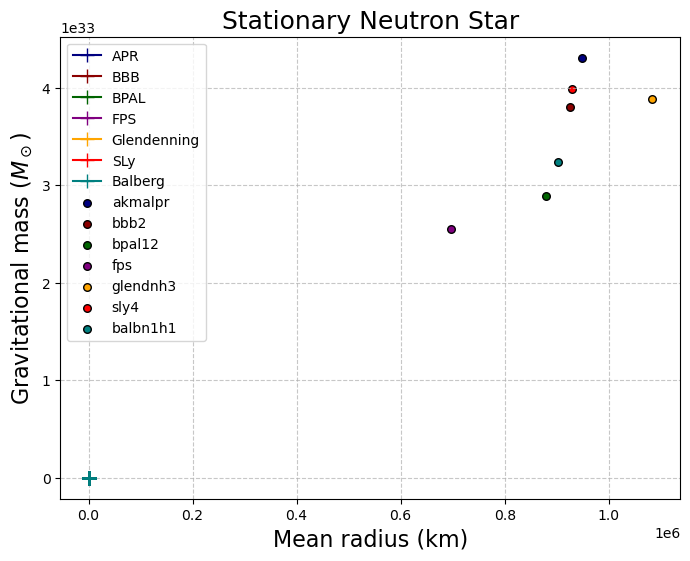

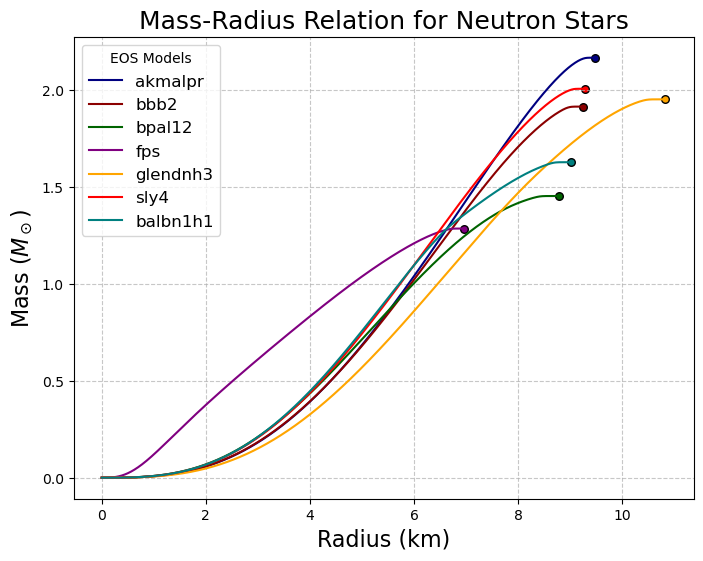

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from tqdm import tqdm
from scipy.integrate import solve_ivp
import pandas as pd
import os
import re
import csv

G = 6.6743e-8  # cm^3/g/s^2
c = 29979245800     # cm/s

# Array of EOS names
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
source_dir = '/home/sanjana/ashoka/thesis/EoS/'  # Directory containing EOS files

# Define markers and colors for different EOS
markers = ['+', '+', '+', '+', '+', '+', '+']
colors = ["navy", "darkred", "darkgreen", "purple", "orange", "red", "teal"]

eos_results = {}

# Loop over each EOS
for eos_name in eos_names:
    data = np.genfromtxt(f"{source_dir}eos_{eos_name}.txt", delimiter=None)
    baryon_density = data[:, 1]
    density = data[:, 2]
    pressure = data[:, 3]

    min_density = 2.4e14 #np.min(density) #1e14  # Lower bound on central density
    max_density = np.max(density)
    
    valid_indices = (density > 0) & (pressure > 0)
    density = density[valid_indices]
    pressure = pressure[valid_indices]
    baryon_density = baryon_density[valid_indices]
    
    log_density = np.log(density)
    log_pressure = np.log(pressure)

    log_pressure_to_log_density = CubicSpline(log_pressure, log_density, bc_type='natural')
    log_density_to_log_pressure = CubicSpline(log_density, log_pressure, bc_type='natural')

    def pressure_to_density(pressure):
        log_pressure = np.log(pressure)
        # Determine the valid range
        min_log_p, max_log_p = log_pressure_to_log_density.x[0], log_pressure_to_log_density.x[-1]
    
        # Clip values outside the interpolation range and show a warning
        if log_pressure < min_log_p or log_pressure > max_log_p:
            clipped_value = np.exp(np.clip(log_pressure, min_log_p, max_log_p))
            print(f"Warning: Extrapolation detected for pressure {pressure:.4e}, clipping to {clipped_value:.4e}.")
            log_pressure = np.clip(log_pressure, min_log_p, max_log_p)
    
        log_density = log_pressure_to_log_density(log_pressure)
        return np.exp(log_density)
    
    def density_to_pressure(density):
        log_density = np.log(density)
        # Determine the valid range
        min_log_rho, max_log_rho = log_density_to_log_pressure.x[0], log_density_to_log_pressure.x[-1]
    
        # Clip values outside the interpolation range and show a warning
        if log_density < min_log_rho or log_density > max_log_rho:
            clipped_value = np.exp(np.clip(log_density, min_log_rho, max_log_rho))
            print(f"Warning: Extrapolation detected for density {density:.4e}, clipping to {clipped_value:.4e}.")
            log_density = np.clip(log_density, min_log_rho, max_log_rho)
    
        log_pressure = log_density_to_log_pressure(log_density)
        return np.exp(log_pressure)

    # TOV equations
    def compute_derivatives(r, state_vars):
        mass, pressure = state_vars

        if pressure <= 1e-18 * density_to_pressure(min_density):  # Stop condition
            return [0, 0]

        density = pressure_to_density(pressure)
        dm_dr = 4.0 * np.pi * (r**2) * density
        dP_dr = -(((G * mass * density) / (r**2)) * (1 + (pressure / (density * c * c))) *
                  (1 + ((4 * np.pi * pressure * (r**3)) / (mass * c * c)))) / (1 - ((2 * G * mass) / (r * c * c)))
        return [dm_dr, dP_dr]

    # Stopping condition for solve_ivp
    def pressure_stop_condition(r, y):
        threshold_pressure = 1e-18 * density_to_pressure(min_density)
        #print(f"Threshold pressure: {threshold_pressure:.4e}")
        #print(f"Checking stop condition at r={r:.2f} cm: P={y[1]:.4e}, threshold={threshold_pressure:.4e}")
        return y[1] - threshold_pressure  # Stop when P < threshold

    pressure_stop_condition.terminal = True  # Stop integration
    pressure_stop_condition.direction = -1  # Stop when pressure is decreasing
    
    # Solve the neutron star structure
    def solve_neutron_star_structure(central_density, eos_type):
        initial_pressure = density_to_pressure(central_density)
        state_variables_initial = [1e-10, initial_pressure]  # Small initial mass

        sol = solve_ivp(compute_derivatives, [1e-2, 2e6], state_variables_initial, method="LSODA", rtol=1e-5, atol=1e-5, events=pressure_stop_condition, dense_output=True) 
        #sol = solve_ivp(compute_derivatives, [1e-2, 2e6], state_variables_initial, method="LSODA", rtol=1e-5, atol=1e-5, args=(eos_type,), events=lambda r, y: pressure_stop_condition(r, y, eos_type))

        '''
        if sol.status == 1:  # Event-triggered stop
            print(f"Stopped at r={sol.t_events[0][0]:.4f} cm due to pressure threshold.")
        else:
            print("Solve_ivp reached the maximum radius without stopping.")

        final_radius = sol.t[-1]
        final_mass = sol.y[0, -1]
        '''
        # Determine stopping radius
        if sol.status == 1 and sol.t_events[0].size > 0:  
            stopping_radius = sol.t_events[0][0]  # Stopping point due to pressure threshold
            print(f"Stopped at r={stopping_radius:.4f} cm due to pressure threshold.")
        else:
            stopping_radius = sol.t[-1]  # If not stopped by event, take last value
            print("Solve_ivp reached the maximum radius without stopping.")

        final_radius = stopping_radius  # cm
        final_mass = sol.y[0, -1]  # g
        # Generate a fine radius grid for smooth interpolation
        r_fine = np.linspace(sol.t[0], stopping_radius, 1000)  # 1000 points
        mass_smooth, pressure_smooth = sol.sol(r_fine)  # Interpolated values
    
        return final_radius, final_mass, r_fine, mass_smooth
        
        #return final_radius, final_mass
    #'''
    '''
    def solve_neutron_star_structure(central_density, eos_type):
        initial_pressure = density_to_pressure(central_density)
        state_variables_initial = [1e-3, initial_pressure]
    
        def wrapper(r, y):
            return compute_derivatives(y, r, eos_type)
    
        # Use an implicit solver (Radau or BDF)  
        sol = solve_ivp(wrapper, [50, 2e6], state_variables_initial, method="LSODA", rtol=1e-5, atol=1e-5)
    
        radii = sol.t
        mass_profile = sol.y[0]
        pressure_profile = sol.y[1]
    
        termination_index = np.argmax(pressure_profile < 1e-10 * initial_pressure)
        if termination_index == 0:
            termination_index = -1
    
        final_radius = radii[termination_index]
        final_mass = mass_profile[termination_index]
        return final_radius, final_mass
    '''
    
    central_densities = np.linspace(min_density, max_density, 100)
    results = np.zeros([2, len(central_densities)])
    '''
    for i in tqdm(range(len(central_densities)), desc=f"Processing {eos_name}"):
        results[:, i] = solve_neutron_star_structure(central_densities[i], eos_name)
    '''
    '''
    for i in tqdm(range(len(central_densities)), desc=f"Processing {eos_name}"):
        final_radius, final_mass, _, _ = solve_neutron_star_structure(central_densities[i], eos_name)
        results[:, i] = [final_radius, final_mass]  # Corrected storage
    '''

    for i in tqdm(range(len(central_densities)), desc=f"Processing {eos_name}"):
        final_radius, final_mass, r_fine, mass_smooth = solve_neutron_star_structure(central_densities[i], eos_name)
        results[:, i] = [final_radius, final_mass]  # Store radius & mass as before
    
    eos_results[eos_name] = (central_densities, results[0,] / 1e5, results[1,] / 1.989e33, r_fine, mass_smooth)

    radius = results[0,] / 1e5  # Convert to km
    mass = results[1,] / 1.989e33  # Convert to solar masses
    #eos_results[eos_name] = (central_densities, radius, mass)
    eos_results[eos_name] = (central_densities, final_radius, final_mass, r_fine, mass_smooth)

##############################################################################################

# Dictionary for pretty axis labels
units = {
    "Central enthalpy": r"Log Central enthalpy (c$^2$)",
    "Central proper baryon density": r"Log Central baryon density (g/cm$^3$)",
    "Gravitational mass": r"Gravitational mass ($M_\odot$)",
    "Mean radius": r"Mean radius (km)",
    "Moment of inertia": r"Moment of inertia (10$^{45}$ gcm$^2$)",
    "Compactness": r"Compactness (GM/Rc$^2$)"
}

# Define colors and markers for distinction
colors = ["navy", "darkred", "darkgreen", "purple", "orange", "red", "teal"]
marker_size = 10  # Reduce marker size here

#################################################################

# List of EOS files and their labels (Stationary Neutron Star)
eos_files_stationary = {
    "APR": "Nrotstar_(APR100)_(0.06-0.9)_stat_extracted_data.csv",
    "BBB": "Nrotstar_(BBB100)_(0.05-0.8)_stat_extracted_data.csv",
    "BPAL": "Nrotstar_(BPAL100)_(0.06-0.6)_stat_extracted_data.csv",
    "FPS": "Nrotstar_(FPS100)_(0.04-0.9)_stat_extracted_data.csv",
    "Glendenning": "Nrotstar_(Glendenning100)_(0.06-0.68)_stat_extracted_data.csv",
    "SLy": "Nrotstar_(SLy100)_(0.04-0.9)_stat_extracted_data.csv",
    "Balberg": "Nrotstar_(Balberg100)_(0.08-0.7)_stat_extracted_data.csv"
}

# Column pairs for plotting
columns = [
    ("Mean radius", "Gravitational mass"),
]

# Plot for stationary neutron stars
for x_col, y_col in columns:
    plt.figure(figsize=(8,6))

    for (eos, file), color, marker in zip(eos_files_stationary.items(), colors, markers):
        df = pd.read_csv(file)
        
        # Convert numeric columns properly
        for col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                pass  # Ignore non-numeric columns

        # Filter out invalid values
        df = df[(df[x_col] != "N/A") & (df[y_col] != "N/A")]
        df[x_col] = df[x_col].astype(float)
        df[y_col] = df[y_col].astype(float)

        # Plot data with reduced marker size
        plt.plot(df[x_col], df[y_col], marker=marker, linestyle="-", color=color, 
                 label=eos, markersize=marker_size)

    plt.xlabel(units.get(x_col, x_col), fontsize=16)
    plt.ylabel(units.get(y_col, y_col), fontsize=16)
    plt.title("Stationary Neutron Star", fontsize=18)
    plt.legend(title="EOS Models", fontsize=12)
    plt.grid(linestyle='--', alpha=0.7)

##############################################################################################
markers = ["o", "o", "o", "o", "o", "o", "o"]
#plt.figure()
#plt.title(r"Stationary NS Plot: Mass vs Radius")
#plt.ylabel(r"Mass of the Star [$M_\odot$]")
#plt.xlabel(r"Radius of the Star [km]")

for eos_name, (central_densities, radius, mass, r_fine, mass_smooth), color, marker in zip(eos_results.keys(), eos_results.values(), colors, markers):
#for eos_name, (central_densities, radius, mass), marker, color in zip(eos_results.keys(), eos_results.values(), markers, colors):
    plt.scatter(radius, mass, label=f"{eos_name}", marker=marker, color=color, s=30, edgecolor="black")
plt.legend()
plt.savefig("MvsRStat_Comparison_full.pdf")
plt.show()

plt.figure(figsize=(8, 6))

for eos_name, (central_densities, radius, mass, r_fine, mass_smooth), color, marker in zip(eos_results.keys(), eos_results.values(), colors, markers):
    plt.plot(r_fine / 1e5, mass_smooth / 1.989e33, '-', color=color, label=f"{eos_name}")  # Smooth curve
    plt.scatter(radius / 1e5, mass / 1.989e33, marker=marker, color=color, s=30, edgecolor="black")  # Final points

plt.legend(title="EOS Models", fontsize=12)
plt.xlabel("Radius (km)", fontsize=16)
plt.ylabel("Mass ($M_\odot$)", fontsize=16)
plt.title("Mass-Radius Relation for Neutron Stars", fontsize=18)
plt.grid(linestyle="--", alpha=0.7)

plt.savefig("MvsRStat_Comparison_Smooth.pdf")
plt.show()

Processing akmalpr:   1%|▏                    | 10/1000 [00:00<00:20, 47.97it/s]

Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.


Processing akmalpr:   2%|▎                    | 15/1000 [00:00<00:21, 45.46it/s]

Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Stopped at r=1972864.4341 cm due to pressure threshold.
Stopped at r=1931346.7195 cm due to pressure threshold.


Processing akmalpr:   2%|▍                    | 20/1000 [00:00<00:29, 33.60it/s]

Stopped at r=1892442.7163 cm due to pressure threshold.
Stopped at r=1856049.5414 cm due to pressure threshold.
Stopped at r=1821760.0388 cm due to pressure threshold.
Stopped at r=1789320.6364 cm due to pressure threshold.
Stopped at r=1758993.7582 cm due to pressure threshold.
Stopped at r=1730478.4553 cm due to pressure threshold.


Processing akmalpr:   3%|▌                    | 28/1000 [00:00<00:32, 29.71it/s]

Stopped at r=1703490.1277 cm due to pressure threshold.
Stopped at r=1678022.3049 cm due to pressure threshold.
Stopped at r=1653885.9865 cm due to pressure threshold.
Stopped at r=1630866.2060 cm due to pressure threshold.
Stopped at r=1609285.4196 cm due to pressure threshold.
Stopped at r=1588718.0565 cm due to pressure threshold.


Processing akmalpr:   4%|▋                    | 35/1000 [00:01<00:34, 28.26it/s]

Stopped at r=1569349.3661 cm due to pressure threshold.
Stopped at r=1551033.2626 cm due to pressure threshold.
Stopped at r=1533563.6857 cm due to pressure threshold.
Stopped at r=1516843.6384 cm due to pressure threshold.
Stopped at r=1500978.1383 cm due to pressure threshold.
Stopped at r=1485931.2975 cm due to pressure threshold.


Processing akmalpr:   4%|▊                    | 41/1000 [00:01<00:35, 26.81it/s]

Stopped at r=1471603.0461 cm due to pressure threshold.
Stopped at r=1457959.2635 cm due to pressure threshold.
Stopped at r=1444814.3554 cm due to pressure threshold.
Stopped at r=1432364.5290 cm due to pressure threshold.
Stopped at r=1420617.3114 cm due to pressure threshold.
Stopped at r=1409378.0294 cm due to pressure threshold.


Processing akmalpr:   5%|▉                    | 47/1000 [00:01<00:36, 26.20it/s]

Stopped at r=1398613.7213 cm due to pressure threshold.
Stopped at r=1388156.8544 cm due to pressure threshold.
Stopped at r=1378315.1539 cm due to pressure threshold.
Stopped at r=1368755.1135 cm due to pressure threshold.
Stopped at r=1359772.4872 cm due to pressure threshold.
Stopped at r=1351110.3328 cm due to pressure threshold.


Processing akmalpr:   5%|█                    | 53/1000 [00:01<00:36, 25.92it/s]

Stopped at r=1342784.4006 cm due to pressure threshold.
Stopped at r=1334848.5515 cm due to pressure threshold.
Stopped at r=1327295.0011 cm due to pressure threshold.
Stopped at r=1320108.8756 cm due to pressure threshold.
Stopped at r=1312984.1269 cm due to pressure threshold.
Stopped at r=1306413.3074 cm due to pressure threshold.


Processing akmalpr:   6%|█▏                   | 59/1000 [00:02<00:36, 25.80it/s]

Stopped at r=1299985.5302 cm due to pressure threshold.
Stopped at r=1293881.4057 cm due to pressure threshold.
Stopped at r=1287821.0416 cm due to pressure threshold.
Stopped at r=1282210.8514 cm due to pressure threshold.
Stopped at r=1276841.2883 cm due to pressure threshold.
Stopped at r=1270698.9178 cm due to pressure threshold.


Processing akmalpr:   6%|█▎                   | 62/1000 [00:02<00:37, 24.74it/s]

Stopped at r=1266649.7335 cm due to pressure threshold.
Stopped at r=1260796.2953 cm due to pressure threshold.
Stopped at r=1257333.5287 cm due to pressure threshold.
Stopped at r=1252818.6526 cm due to pressure threshold.
Stopped at r=1248547.6632 cm due to pressure threshold.


Processing akmalpr:   7%|█▍                   | 68/1000 [00:02<00:39, 23.40it/s]

Stopped at r=1244416.1546 cm due to pressure threshold.
Stopped at r=1240469.7916 cm due to pressure threshold.
Stopped at r=1236640.1397 cm due to pressure threshold.
Stopped at r=1232917.6243 cm due to pressure threshold.
Stopped at r=1229351.2213 cm due to pressure threshold.


Processing akmalpr:   7%|█▌                   | 74/1000 [00:02<00:41, 22.19it/s]

Stopped at r=1225917.0780 cm due to pressure threshold.
Stopped at r=1222560.4128 cm due to pressure threshold.
Stopped at r=1219424.2266 cm due to pressure threshold.
Stopped at r=1216390.2725 cm due to pressure threshold.
Stopped at r=1213349.3567 cm due to pressure threshold.


Processing akmalpr:   8%|█▌                   | 77/1000 [00:02<00:41, 22.30it/s]

Stopped at r=1210516.8171 cm due to pressure threshold.
Stopped at r=1207733.6933 cm due to pressure threshold.
Stopped at r=1205011.2672 cm due to pressure threshold.
Stopped at r=1202434.5553 cm due to pressure threshold.
Stopped at r=1199928.8739 cm due to pressure threshold.


Processing akmalpr:   8%|█▋                   | 83/1000 [00:03<00:39, 23.03it/s]

Stopped at r=1197520.1975 cm due to pressure threshold.
Stopped at r=1195180.6688 cm due to pressure threshold.
Stopped at r=1193047.1055 cm due to pressure threshold.
Stopped at r=1190800.6917 cm due to pressure threshold.
Stopped at r=1188828.0415 cm due to pressure threshold.


Processing akmalpr:   9%|█▊                   | 89/1000 [00:03<00:39, 22.79it/s]

Stopped at r=1186737.3347 cm due to pressure threshold.
Stopped at r=1184751.6732 cm due to pressure threshold.
Stopped at r=1183212.3336 cm due to pressure threshold.
Stopped at r=1181122.2854 cm due to pressure threshold.
Stopped at r=1179424.7191 cm due to pressure threshold.


Processing akmalpr:   9%|█▉                   | 92/1000 [00:03<00:40, 22.22it/s]

Stopped at r=1177697.7282 cm due to pressure threshold.
Stopped at r=1176093.5930 cm due to pressure threshold.
Stopped at r=1174511.0764 cm due to pressure threshold.
Stopped at r=1172980.2890 cm due to pressure threshold.
Stopped at r=1171551.0471 cm due to pressure threshold.


Processing akmalpr:  10%|██                   | 98/1000 [00:03<00:39, 22.80it/s]

Stopped at r=1170153.3110 cm due to pressure threshold.
Stopped at r=1168812.8032 cm due to pressure threshold.
Stopped at r=1167537.9639 cm due to pressure threshold.
Stopped at r=1166272.6788 cm due to pressure threshold.
Stopped at r=1165056.9868 cm due to pressure threshold.


Processing akmalpr:  10%|██                  | 104/1000 [00:04<00:38, 23.36it/s]

Stopped at r=1163909.1206 cm due to pressure threshold.
Stopped at r=1162823.6585 cm due to pressure threshold.
Stopped at r=1161746.6471 cm due to pressure threshold.
Stopped at r=1160698.0761 cm due to pressure threshold.
Stopped at r=1159696.0494 cm due to pressure threshold.


Processing akmalpr:  11%|██▏                 | 107/1000 [00:04<00:40, 22.04it/s]

Stopped at r=1158751.8659 cm due to pressure threshold.
Stopped at r=1157842.9704 cm due to pressure threshold.
Stopped at r=1156936.8392 cm due to pressure threshold.
Stopped at r=1156293.5651 cm due to pressure threshold.


Processing akmalpr:  11%|██▎                 | 113/1000 [00:04<00:39, 22.69it/s]

Stopped at r=1155285.3127 cm due to pressure threshold.
Stopped at r=1154498.9787 cm due to pressure threshold.
Stopped at r=1153773.7529 cm due to pressure threshold.
Stopped at r=1153090.4966 cm due to pressure threshold.
Stopped at r=1152302.0469 cm due to pressure threshold.


Processing akmalpr:  12%|██▎                 | 116/1000 [00:04<00:39, 22.63it/s]

Stopped at r=1151642.8824 cm due to pressure threshold.
Stopped at r=1150992.5547 cm due to pressure threshold.
Stopped at r=1150377.1826 cm due to pressure threshold.
Stopped at r=1149811.1577 cm due to pressure threshold.
Stopped at r=1149222.8540 cm due to pressure threshold.


Processing akmalpr:  12%|██▍                 | 122/1000 [00:04<00:39, 22.03it/s]

Stopped at r=1148669.0981 cm due to pressure threshold.
Stopped at r=1148150.2153 cm due to pressure threshold.
Stopped at r=1147637.5021 cm due to pressure threshold.
Stopped at r=1147218.5671 cm due to pressure threshold.
Stopped at r=1146712.8217 cm due to pressure threshold.


Processing akmalpr:  13%|██▌                 | 128/1000 [00:05<00:38, 22.60it/s]

Stopped at r=1146260.2016 cm due to pressure threshold.
Stopped at r=1145853.9797 cm due to pressure threshold.
Stopped at r=1145457.5675 cm due to pressure threshold.
Stopped at r=1145065.2193 cm due to pressure threshold.
Stopped at r=1144666.5184 cm due to pressure threshold.


Processing akmalpr:  13%|██▌                 | 131/1000 [00:05<00:38, 22.82it/s]

Stopped at r=1144341.5143 cm due to pressure threshold.
Stopped at r=1144012.0874 cm due to pressure threshold.
Stopped at r=1143685.3469 cm due to pressure threshold.
Stopped at r=1143379.5217 cm due to pressure threshold.
Stopped at r=1143081.4278 cm due to pressure threshold.


Processing akmalpr:  14%|██▋                 | 137/1000 [00:05<00:41, 20.82it/s]

Stopped at r=1142801.2718 cm due to pressure threshold.
Stopped at r=1142538.9133 cm due to pressure threshold.
Stopped at r=1142270.3310 cm due to pressure threshold.
Stopped at r=1142066.5966 cm due to pressure threshold.


Processing akmalpr:  14%|██▊                 | 140/1000 [00:05<00:41, 20.65it/s]

Stopped at r=1141803.5819 cm due to pressure threshold.
Stopped at r=1141586.2678 cm due to pressure threshold.
Stopped at r=1141365.1603 cm due to pressure threshold.
Stopped at r=1141161.6139 cm due to pressure threshold.
Stopped at r=1140974.6754 cm due to pressure threshold.


Processing akmalpr:  15%|██▉                 | 146/1000 [00:05<00:38, 22.06it/s]

Stopped at r=1140794.2651 cm due to pressure threshold.
Stopped at r=1140620.2208 cm due to pressure threshold.
Stopped at r=1140463.0928 cm due to pressure threshold.
Stopped at r=1140305.7833 cm due to pressure threshold.
Stopped at r=1140135.8532 cm due to pressure threshold.


Processing akmalpr:  15%|███                 | 152/1000 [00:06<00:37, 22.79it/s]

Stopped at r=1140036.8043 cm due to pressure threshold.
Stopped at r=1139890.4661 cm due to pressure threshold.
Stopped at r=1139744.2878 cm due to pressure threshold.
Stopped at r=1139617.9016 cm due to pressure threshold.
Stopped at r=1139493.2997 cm due to pressure threshold.


Processing akmalpr:  16%|███▏                | 158/1000 [00:06<00:35, 23.90it/s]

Stopped at r=1139413.8697 cm due to pressure threshold.
Stopped at r=1139302.8191 cm due to pressure threshold.
Stopped at r=1139199.5397 cm due to pressure threshold.
Stopped at r=1139084.1248 cm due to pressure threshold.
Stopped at r=1138966.7904 cm due to pressure threshold.
Stopped at r=1138890.9091 cm due to pressure threshold.


Processing akmalpr:  16%|███▎                | 164/1000 [00:06<00:34, 24.39it/s]

Stopped at r=1138808.2183 cm due to pressure threshold.
Stopped at r=1138718.2960 cm due to pressure threshold.
Stopped at r=1138642.7960 cm due to pressure threshold.
Stopped at r=1138569.9945 cm due to pressure threshold.
Stopped at r=1138501.1926 cm due to pressure threshold.
Stopped at r=1138431.2747 cm due to pressure threshold.


Processing akmalpr:  17%|███▎                | 167/1000 [00:06<00:39, 20.93it/s]

Stopped at r=1138365.5940 cm due to pressure threshold.
Stopped at r=1138300.9387 cm due to pressure threshold.
Stopped at r=1138239.2302 cm due to pressure threshold.
Stopped at r=1138170.0061 cm due to pressure threshold.


Processing akmalpr:  17%|███▍                | 173/1000 [00:07<00:37, 21.91it/s]

Stopped at r=1138125.5573 cm due to pressure threshold.
Stopped at r=1138065.4147 cm due to pressure threshold.
Stopped at r=1137993.9666 cm due to pressure threshold.
Stopped at r=1137947.8457 cm due to pressure threshold.
Stopped at r=1137885.8401 cm due to pressure threshold.


Processing akmalpr:  18%|███▌                | 176/1000 [00:07<00:37, 21.91it/s]

Stopped at r=1137725.9679 cm due to pressure threshold.
Stopped at r=1137581.0069 cm due to pressure threshold.
Stopped at r=1137721.9859 cm due to pressure threshold.
Stopped at r=1137672.3719 cm due to pressure threshold.
Stopped at r=1137624.4215 cm due to pressure threshold.


Processing akmalpr:  18%|███▋                | 182/1000 [00:07<00:37, 22.04it/s]

Stopped at r=1137571.8279 cm due to pressure threshold.
Stopped at r=1137508.2350 cm due to pressure threshold.
Stopped at r=1137466.9305 cm due to pressure threshold.
Stopped at r=1137420.6300 cm due to pressure threshold.
Stopped at r=1137383.9973 cm due to pressure threshold.


Processing akmalpr:  19%|███▊                | 188/1000 [00:07<00:35, 22.73it/s]

Stopped at r=1137297.1505 cm due to pressure threshold.
Stopped at r=1137262.2321 cm due to pressure threshold.
Stopped at r=1137206.5713 cm due to pressure threshold.
Stopped at r=1137156.2513 cm due to pressure threshold.
Stopped at r=1137091.1730 cm due to pressure threshold.


Processing akmalpr:  19%|███▊                | 191/1000 [00:07<00:35, 22.75it/s]

Stopped at r=1137023.7697 cm due to pressure threshold.
Stopped at r=1136979.7861 cm due to pressure threshold.
Stopped at r=1136912.4149 cm due to pressure threshold.
Stopped at r=1136867.9404 cm due to pressure threshold.
Stopped at r=1136807.0227 cm due to pressure threshold.


Processing akmalpr:  20%|███▉                | 197/1000 [00:08<00:34, 23.07it/s]

Stopped at r=1136735.6399 cm due to pressure threshold.
Stopped at r=1136679.0334 cm due to pressure threshold.
Stopped at r=1136613.6763 cm due to pressure threshold.
Stopped at r=1136550.3272 cm due to pressure threshold.
Stopped at r=1136480.1050 cm due to pressure threshold.


Processing akmalpr:  20%|████                | 203/1000 [00:08<00:35, 22.37it/s]

Stopped at r=1136420.6179 cm due to pressure threshold.
Stopped at r=1136330.7948 cm due to pressure threshold.
Stopped at r=1136252.2425 cm due to pressure threshold.
Stopped at r=1136180.3881 cm due to pressure threshold.
Stopped at r=1136105.4922 cm due to pressure threshold.


Processing akmalpr:  21%|████                | 206/1000 [00:08<00:36, 21.78it/s]

Stopped at r=1136032.7658 cm due to pressure threshold.
Stopped at r=1135944.4275 cm due to pressure threshold.
Stopped at r=1135862.7822 cm due to pressure threshold.
Stopped at r=1135785.9723 cm due to pressure threshold.
Stopped at r=1135713.3789 cm due to pressure threshold.


Processing akmalpr:  21%|████▏               | 212/1000 [00:08<00:33, 23.19it/s]

Stopped at r=1135612.7658 cm due to pressure threshold.
Stopped at r=1135520.4045 cm due to pressure threshold.
Stopped at r=1135426.8048 cm due to pressure threshold.
Stopped at r=1135339.7134 cm due to pressure threshold.
Stopped at r=1135234.3274 cm due to pressure threshold.


Processing akmalpr:  22%|████▎               | 218/1000 [00:09<00:33, 23.32it/s]

Stopped at r=1135138.7482 cm due to pressure threshold.
Stopped at r=1135035.5190 cm due to pressure threshold.
Stopped at r=1134931.3488 cm due to pressure threshold.
Stopped at r=1134826.4870 cm due to pressure threshold.
Stopped at r=1134703.4224 cm due to pressure threshold.
Stopped at r=1134609.1054 cm due to pressure threshold.


Processing akmalpr:  22%|████▍               | 224/1000 [00:09<00:32, 24.16it/s]

Stopped at r=1134496.4277 cm due to pressure threshold.
Stopped at r=1134382.8763 cm due to pressure threshold.
Stopped at r=1134260.4744 cm due to pressure threshold.
Stopped at r=1134138.2835 cm due to pressure threshold.
Stopped at r=1134017.4955 cm due to pressure threshold.
Stopped at r=1133891.4422 cm due to pressure threshold.


Processing akmalpr:  23%|████▌               | 230/1000 [00:09<00:31, 24.64it/s]

Stopped at r=1133767.8822 cm due to pressure threshold.
Stopped at r=1133636.9189 cm due to pressure threshold.
Stopped at r=1133508.5459 cm due to pressure threshold.
Stopped at r=1133371.8137 cm due to pressure threshold.
Stopped at r=1133252.4039 cm due to pressure threshold.
Stopped at r=1133111.1870 cm due to pressure threshold.


Processing akmalpr:  24%|████▋               | 236/1000 [00:09<00:31, 24.47it/s]

Stopped at r=1132963.7965 cm due to pressure threshold.
Stopped at r=1132815.9277 cm due to pressure threshold.
Stopped at r=1132684.6950 cm due to pressure threshold.
Stopped at r=1132530.5181 cm due to pressure threshold.
Stopped at r=1132396.3649 cm due to pressure threshold.


Processing akmalpr:  24%|████▊               | 239/1000 [00:09<00:30, 24.69it/s]

Stopped at r=1132242.4673 cm due to pressure threshold.
Stopped at r=1132092.8773 cm due to pressure threshold.
Stopped at r=1131937.9555 cm due to pressure threshold.
Stopped at r=1131767.8630 cm due to pressure threshold.
Stopped at r=1131601.9984 cm due to pressure threshold.
Stopped at r=1131445.3087 cm due to pressure threshold.


Processing akmalpr:  24%|████▉               | 245/1000 [00:10<00:30, 24.41it/s]

Stopped at r=1131279.6440 cm due to pressure threshold.
Stopped at r=1131116.9034 cm due to pressure threshold.
Stopped at r=1130941.9490 cm due to pressure threshold.
Stopped at r=1130767.9259 cm due to pressure threshold.
Stopped at r=1130595.3645 cm due to pressure threshold.


Processing akmalpr:  25%|█████               | 251/1000 [00:10<00:31, 24.07it/s]

Stopped at r=1130421.1173 cm due to pressure threshold.
Stopped at r=1130243.3608 cm due to pressure threshold.
Stopped at r=1130066.7676 cm due to pressure threshold.
Stopped at r=1129901.8556 cm due to pressure threshold.
Stopped at r=1129696.7540 cm due to pressure threshold.


Processing akmalpr:  26%|█████▏              | 257/1000 [00:10<00:31, 23.67it/s]

Stopped at r=1129510.7449 cm due to pressure threshold.
Stopped at r=1129321.0830 cm due to pressure threshold.
Stopped at r=1129173.2927 cm due to pressure threshold.
Stopped at r=1128973.4259 cm due to pressure threshold.
Stopped at r=1128797.8704 cm due to pressure threshold.


Processing akmalpr:  26%|█████▏              | 260/1000 [00:10<00:31, 23.83it/s]

Stopped at r=1128536.3312 cm due to pressure threshold.
Stopped at r=1128366.6786 cm due to pressure threshold.
Stopped at r=1128122.1814 cm due to pressure threshold.
Stopped at r=1127951.4433 cm due to pressure threshold.
Stopped at r=1127739.1134 cm due to pressure threshold.


Processing akmalpr:  27%|█████▎              | 266/1000 [00:11<00:31, 22.98it/s]

Stopped at r=1127529.1797 cm due to pressure threshold.
Stopped at r=1127318.8529 cm due to pressure threshold.
Stopped at r=1127114.6252 cm due to pressure threshold.
Stopped at r=1126904.7184 cm due to pressure threshold.
Stopped at r=1126685.3157 cm due to pressure threshold.


Processing akmalpr:  27%|█████▍              | 269/1000 [00:11<00:33, 21.95it/s]

Stopped at r=1126472.9290 cm due to pressure threshold.
Stopped at r=1126255.0903 cm due to pressure threshold.
Stopped at r=1126032.2562 cm due to pressure threshold.
Stopped at r=1125798.5594 cm due to pressure threshold.


Processing akmalpr:  28%|█████▌              | 275/1000 [00:11<00:36, 19.88it/s]

Stopped at r=1125570.4670 cm due to pressure threshold.
Stopped at r=1125344.1782 cm due to pressure threshold.
Stopped at r=1125118.6153 cm due to pressure threshold.
Stopped at r=1124886.4825 cm due to pressure threshold.


Processing akmalpr:  28%|█████▌              | 278/1000 [00:11<00:35, 20.57it/s]

Stopped at r=1124656.5978 cm due to pressure threshold.
Stopped at r=1124420.1776 cm due to pressure threshold.
Stopped at r=1124183.5202 cm due to pressure threshold.
Stopped at r=1123938.5450 cm due to pressure threshold.
Stopped at r=1123697.0815 cm due to pressure threshold.


Processing akmalpr:  28%|█████▋              | 284/1000 [00:11<00:31, 22.39it/s]

Stopped at r=1123455.0861 cm due to pressure threshold.
Stopped at r=1123213.2432 cm due to pressure threshold.
Stopped at r=1122985.0085 cm due to pressure threshold.
Stopped at r=1122735.6165 cm due to pressure threshold.
Stopped at r=1122481.3670 cm due to pressure threshold.
Stopped at r=1122230.5274 cm due to pressure threshold.


Processing akmalpr:  29%|█████▊              | 290/1000 [00:12<00:29, 23.69it/s]

Stopped at r=1121977.4428 cm due to pressure threshold.
Stopped at r=1121725.7542 cm due to pressure threshold.
Stopped at r=1121476.7810 cm due to pressure threshold.
Stopped at r=1121216.2483 cm due to pressure threshold.
Stopped at r=1120958.6699 cm due to pressure threshold.
Stopped at r=1120701.3036 cm due to pressure threshold.


Processing akmalpr:  30%|█████▉              | 296/1000 [00:12<00:29, 23.52it/s]

Stopped at r=1120432.9323 cm due to pressure threshold.
Stopped at r=1120174.1093 cm due to pressure threshold.
Stopped at r=1119921.0518 cm due to pressure threshold.
Stopped at r=1119664.8939 cm due to pressure threshold.
Stopped at r=1119393.0784 cm due to pressure threshold.


Processing akmalpr:  30%|██████              | 302/1000 [00:12<00:29, 23.38it/s]

Stopped at r=1119131.3886 cm due to pressure threshold.
Stopped at r=1118867.7243 cm due to pressure threshold.
Stopped at r=1118600.9636 cm due to pressure threshold.
Stopped at r=1118325.8096 cm due to pressure threshold.
Stopped at r=1118060.9376 cm due to pressure threshold.


Processing akmalpr:  30%|██████              | 305/1000 [00:12<00:30, 23.11it/s]

Stopped at r=1117723.4229 cm due to pressure threshold.
Stopped at r=1117517.0147 cm due to pressure threshold.
Stopped at r=1117237.4405 cm due to pressure threshold.
Stopped at r=1116968.1400 cm due to pressure threshold.
Stopped at r=1116691.8276 cm due to pressure threshold.


Processing akmalpr:  31%|██████▏             | 311/1000 [00:13<00:30, 22.43it/s]

Stopped at r=1116415.4661 cm due to pressure threshold.
Stopped at r=1116144.6861 cm due to pressure threshold.
Stopped at r=1115861.8646 cm due to pressure threshold.
Stopped at r=1115575.3172 cm due to pressure threshold.
Stopped at r=1115290.4700 cm due to pressure threshold.


Processing akmalpr:  32%|██████▎             | 317/1000 [00:13<00:30, 22.45it/s]

Stopped at r=1115003.6238 cm due to pressure threshold.
Stopped at r=1114720.3734 cm due to pressure threshold.
Stopped at r=1114433.2033 cm due to pressure threshold.
Stopped at r=1114141.5953 cm due to pressure threshold.
Stopped at r=1113850.5585 cm due to pressure threshold.


Processing akmalpr:  32%|██████▍             | 320/1000 [00:13<00:30, 22.04it/s]

Stopped at r=1113556.3684 cm due to pressure threshold.
Stopped at r=1113263.7437 cm due to pressure threshold.
Stopped at r=1112970.3643 cm due to pressure threshold.
Stopped at r=1112678.6640 cm due to pressure threshold.
Stopped at r=1112392.0533 cm due to pressure threshold.


Processing akmalpr:  33%|██████▌             | 326/1000 [00:13<00:29, 22.51it/s]

Stopped at r=1112089.7284 cm due to pressure threshold.
Stopped at r=1111809.5863 cm due to pressure threshold.
Stopped at r=1111504.8506 cm due to pressure threshold.
Stopped at r=1111205.0864 cm due to pressure threshold.
Stopped at r=1110909.2867 cm due to pressure threshold.


Processing akmalpr:  33%|██████▋             | 332/1000 [00:14<00:28, 23.29it/s]

Stopped at r=1110609.8927 cm due to pressure threshold.
Stopped at r=1110303.5900 cm due to pressure threshold.
Stopped at r=1110002.1085 cm due to pressure threshold.
Stopped at r=1109700.0318 cm due to pressure threshold.
Stopped at r=1109398.1053 cm due to pressure threshold.


Processing akmalpr:  34%|██████▋             | 335/1000 [00:14<00:28, 23.68it/s]

Stopped at r=1109095.2396 cm due to pressure threshold.
Stopped at r=1108792.2976 cm due to pressure threshold.
Stopped at r=1108487.9451 cm due to pressure threshold.
Stopped at r=1108189.7213 cm due to pressure threshold.
Stopped at r=1107878.8808 cm due to pressure threshold.


Processing akmalpr:  34%|██████▊             | 341/1000 [00:14<00:27, 23.71it/s]

Stopped at r=1107575.7725 cm due to pressure threshold.
Stopped at r=1107267.9910 cm due to pressure threshold.
Stopped at r=1106963.1091 cm due to pressure threshold.
Stopped at r=1106655.3168 cm due to pressure threshold.
Stopped at r=1106344.1869 cm due to pressure threshold.


Processing akmalpr:  34%|██████▉             | 344/1000 [00:14<00:29, 21.88it/s]

Stopped at r=1106035.1541 cm due to pressure threshold.
Stopped at r=1105729.7884 cm due to pressure threshold.
Stopped at r=1105428.1634 cm due to pressure threshold.
Stopped at r=1105121.1648 cm due to pressure threshold.


Processing akmalpr:  35%|███████             | 350/1000 [00:14<00:31, 20.39it/s]

Stopped at r=1104808.1267 cm due to pressure threshold.
Stopped at r=1104495.7499 cm due to pressure threshold.
Stopped at r=1104183.2340 cm due to pressure threshold.
Stopped at r=1103870.6481 cm due to pressure threshold.
Stopped at r=1103551.6833 cm due to pressure threshold.


Processing akmalpr:  35%|███████             | 353/1000 [00:15<00:31, 20.71it/s]

Stopped at r=1103232.0178 cm due to pressure threshold.
Stopped at r=1102921.9807 cm due to pressure threshold.
Stopped at r=1102606.6611 cm due to pressure threshold.
Stopped at r=1102292.2138 cm due to pressure threshold.


Processing akmalpr:  36%|███████▏            | 359/1000 [00:15<00:31, 20.29it/s]

Stopped at r=1101976.0949 cm due to pressure threshold.
Stopped at r=1101657.8057 cm due to pressure threshold.
Stopped at r=1101344.6605 cm due to pressure threshold.
Stopped at r=1101034.4510 cm due to pressure threshold.
Stopped at r=1100710.4115 cm due to pressure threshold.


Processing akmalpr:  36%|███████▎            | 365/1000 [00:15<00:29, 21.33it/s]

Stopped at r=1100395.1338 cm due to pressure threshold.
Stopped at r=1100074.3310 cm due to pressure threshold.
Stopped at r=1099756.6268 cm due to pressure threshold.
Stopped at r=1099431.9103 cm due to pressure threshold.
Stopped at r=1099115.7788 cm due to pressure threshold.


Processing akmalpr:  37%|███████▎            | 368/1000 [00:15<00:29, 21.40it/s]

Stopped at r=1098796.4724 cm due to pressure threshold.
Stopped at r=1098473.1633 cm due to pressure threshold.
Stopped at r=1098154.2406 cm due to pressure threshold.
Stopped at r=1097833.3634 cm due to pressure threshold.
Stopped at r=1097519.8730 cm due to pressure threshold.


Processing akmalpr:  37%|███████▍            | 374/1000 [00:16<00:28, 22.14it/s]

Stopped at r=1097195.7663 cm due to pressure threshold.
Stopped at r=1096874.8933 cm due to pressure threshold.
Stopped at r=1096552.9642 cm due to pressure threshold.
Stopped at r=1096230.3774 cm due to pressure threshold.
Stopped at r=1095936.4603 cm due to pressure threshold.


Processing akmalpr:  38%|███████▌            | 380/1000 [00:16<00:27, 22.35it/s]

Stopped at r=1095579.5213 cm due to pressure threshold.
Stopped at r=1095262.7004 cm due to pressure threshold.
Stopped at r=1094929.7838 cm due to pressure threshold.
Stopped at r=1094610.4715 cm due to pressure threshold.
Stopped at r=1094288.4704 cm due to pressure threshold.


Processing akmalpr:  38%|███████▋            | 383/1000 [00:16<00:27, 22.74it/s]

Stopped at r=1093958.5535 cm due to pressure threshold.
Stopped at r=1093630.9419 cm due to pressure threshold.
Stopped at r=1093305.3393 cm due to pressure threshold.
Stopped at r=1092982.6770 cm due to pressure threshold.
Stopped at r=1092652.4687 cm due to pressure threshold.


Processing akmalpr:  39%|███████▊            | 389/1000 [00:16<00:26, 23.17it/s]

Stopped at r=1092329.2980 cm due to pressure threshold.
Stopped at r=1092002.8658 cm due to pressure threshold.
Stopped at r=1091680.2303 cm due to pressure threshold.
Stopped at r=1091350.4555 cm due to pressure threshold.
Stopped at r=1091021.5462 cm due to pressure threshold.


Processing akmalpr:  40%|███████▉            | 395/1000 [00:16<00:27, 22.39it/s]

Stopped at r=1090694.8164 cm due to pressure threshold.
Stopped at r=1090370.9971 cm due to pressure threshold.
Stopped at r=1090042.3182 cm due to pressure threshold.
Stopped at r=1089718.3922 cm due to pressure threshold.
Stopped at r=1089391.9858 cm due to pressure threshold.


Processing akmalpr:  40%|███████▉            | 398/1000 [00:17<00:27, 21.87it/s]

Stopped at r=1089069.9969 cm due to pressure threshold.
Stopped at r=1088744.3878 cm due to pressure threshold.
Stopped at r=1088416.4300 cm due to pressure threshold.
Stopped at r=1088090.6896 cm due to pressure threshold.
Stopped at r=1087758.5228 cm due to pressure threshold.


Processing akmalpr:  40%|████████            | 404/1000 [00:17<00:26, 22.91it/s]

Stopped at r=1087442.8335 cm due to pressure threshold.
Stopped at r=1087103.6794 cm due to pressure threshold.
Stopped at r=1086791.2664 cm due to pressure threshold.
Stopped at r=1086455.5644 cm due to pressure threshold.
Stopped at r=1086129.7314 cm due to pressure threshold.


Processing akmalpr:  41%|████████▏           | 407/1000 [00:17<00:26, 22.76it/s]

Stopped at r=1085807.6438 cm due to pressure threshold.
Stopped at r=1085482.5235 cm due to pressure threshold.
Stopped at r=1085153.8974 cm due to pressure threshold.
Stopped at r=1084828.3332 cm due to pressure threshold.


Processing akmalpr:  41%|████████▎           | 413/1000 [00:17<00:28, 20.94it/s]

Stopped at r=1084499.0683 cm due to pressure threshold.
Stopped at r=1084176.2965 cm due to pressure threshold.
Stopped at r=1083859.3338 cm due to pressure threshold.
Stopped at r=1083526.9557 cm due to pressure threshold.
Stopped at r=1083201.0131 cm due to pressure threshold.


Processing akmalpr:  42%|████████▍           | 419/1000 [00:18<00:27, 21.39it/s]

Stopped at r=1082879.7245 cm due to pressure threshold.
Stopped at r=1082551.6795 cm due to pressure threshold.
Stopped at r=1082223.4595 cm due to pressure threshold.
Stopped at r=1081898.0067 cm due to pressure threshold.
Stopped at r=1081576.7016 cm due to pressure threshold.


Processing akmalpr:  42%|████████▍           | 422/1000 [00:18<00:27, 21.28it/s]

Stopped at r=1081250.7618 cm due to pressure threshold.
Stopped at r=1080925.5364 cm due to pressure threshold.
Stopped at r=1080599.5251 cm due to pressure threshold.
Stopped at r=1080268.9799 cm due to pressure threshold.
Stopped at r=1079946.5015 cm due to pressure threshold.


Processing akmalpr:  43%|████████▌           | 428/1000 [00:18<00:28, 20.11it/s]

Stopped at r=1079618.2021 cm due to pressure threshold.
Stopped at r=1079292.4410 cm due to pressure threshold.
Stopped at r=1078967.9023 cm due to pressure threshold.
Stopped at r=1078645.1325 cm due to pressure threshold.


Processing akmalpr:  43%|████████▌           | 431/1000 [00:18<00:28, 20.00it/s]

Stopped at r=1078321.1097 cm due to pressure threshold.
Stopped at r=1077994.6012 cm due to pressure threshold.
Stopped at r=1077664.5517 cm due to pressure threshold.
Stopped at r=1077336.6362 cm due to pressure threshold.
Stopped at r=1077012.0942 cm due to pressure threshold.


Processing akmalpr:  44%|████████▋           | 437/1000 [00:18<00:27, 20.26it/s]

Stopped at r=1076688.3878 cm due to pressure threshold.
Stopped at r=1076368.9360 cm due to pressure threshold.
Stopped at r=1076052.3019 cm due to pressure threshold.
Stopped at r=1075718.3406 cm due to pressure threshold.
Stopped at r=1075400.6347 cm due to pressure threshold.


Processing akmalpr:  44%|████████▊           | 443/1000 [00:19<00:25, 21.81it/s]

Stopped at r=1075077.4361 cm due to pressure threshold.
Stopped at r=1074761.9526 cm due to pressure threshold.
Stopped at r=1074435.2938 cm due to pressure threshold.
Stopped at r=1074118.5914 cm due to pressure threshold.
Stopped at r=1073797.0315 cm due to pressure threshold.


Processing akmalpr:  45%|████████▉           | 446/1000 [00:19<00:24, 22.17it/s]

Stopped at r=1073494.3933 cm due to pressure threshold.
Stopped at r=1073172.8811 cm due to pressure threshold.
Stopped at r=1072853.4766 cm due to pressure threshold.
Stopped at r=1072517.0291 cm due to pressure threshold.
Stopped at r=1072195.6785 cm due to pressure threshold.


Processing akmalpr:  45%|█████████           | 452/1000 [00:19<00:25, 21.63it/s]

Stopped at r=1071874.3162 cm due to pressure threshold.
Stopped at r=1071554.5756 cm due to pressure threshold.
Stopped at r=1071238.1406 cm due to pressure threshold.
Stopped at r=1070916.4834 cm due to pressure threshold.
Stopped at r=1070589.4350 cm due to pressure threshold.


Processing akmalpr:  46%|█████████▏          | 458/1000 [00:19<00:25, 20.96it/s]

Stopped at r=1070277.7532 cm due to pressure threshold.
Stopped at r=1069961.6533 cm due to pressure threshold.
Stopped at r=1069645.1050 cm due to pressure threshold.
Stopped at r=1069326.4236 cm due to pressure threshold.
Stopped at r=1069009.4789 cm due to pressure threshold.


Processing akmalpr:  46%|█████████▏          | 461/1000 [00:20<00:25, 21.21it/s]

Stopped at r=1068693.1736 cm due to pressure threshold.
Stopped at r=1068372.9674 cm due to pressure threshold.
Stopped at r=1068055.5952 cm due to pressure threshold.
Stopped at r=1067736.3170 cm due to pressure threshold.
Stopped at r=1067424.5626 cm due to pressure threshold.


Processing akmalpr:  47%|█████████▎          | 467/1000 [00:20<00:24, 21.70it/s]

Stopped at r=1067106.4055 cm due to pressure threshold.
Stopped at r=1066791.3993 cm due to pressure threshold.
Stopped at r=1066473.7696 cm due to pressure threshold.
Stopped at r=1066160.6257 cm due to pressure threshold.
Stopped at r=1065842.9092 cm due to pressure threshold.


Processing akmalpr:  47%|█████████▍          | 473/1000 [00:20<00:24, 21.27it/s]

Stopped at r=1065530.1247 cm due to pressure threshold.
Stopped at r=1065213.4560 cm due to pressure threshold.
Stopped at r=1064896.5773 cm due to pressure threshold.
Stopped at r=1064582.7439 cm due to pressure threshold.
Stopped at r=1064271.4388 cm due to pressure threshold.


Processing akmalpr:  48%|█████████▌          | 476/1000 [00:20<00:25, 20.77it/s]

Stopped at r=1063958.3055 cm due to pressure threshold.
Stopped at r=1063646.2070 cm due to pressure threshold.
Stopped at r=1063331.8303 cm due to pressure threshold.
Stopped at r=1063020.9763 cm due to pressure threshold.
Stopped at r=1062705.3623 cm due to pressure threshold.


Processing akmalpr:  48%|█████████▋          | 482/1000 [00:21<00:24, 21.05it/s]

Stopped at r=1062387.6593 cm due to pressure threshold.
Stopped at r=1062095.5338 cm due to pressure threshold.
Stopped at r=1061768.6867 cm due to pressure threshold.
Stopped at r=1061450.5319 cm due to pressure threshold.
Stopped at r=1061153.8749 cm due to pressure threshold.


Processing akmalpr:  49%|█████████▊          | 488/1000 [00:21<00:22, 22.36it/s]

Stopped at r=1060832.9577 cm due to pressure threshold.
Stopped at r=1060519.8189 cm due to pressure threshold.
Stopped at r=1060205.4192 cm due to pressure threshold.
Stopped at r=1059875.5943 cm due to pressure threshold.
Stopped at r=1059589.3152 cm due to pressure threshold.


Processing akmalpr:  49%|█████████▊          | 491/1000 [00:21<00:23, 21.46it/s]

Stopped at r=1059280.2883 cm due to pressure threshold.
Stopped at r=1058972.9688 cm due to pressure threshold.
Stopped at r=1058663.7122 cm due to pressure threshold.
Stopped at r=1058352.9238 cm due to pressure threshold.


Processing akmalpr:  50%|█████████▉          | 497/1000 [00:21<00:22, 22.00it/s]

Stopped at r=1058011.7278 cm due to pressure threshold.
Stopped at r=1057736.4339 cm due to pressure threshold.
Stopped at r=1057428.4664 cm due to pressure threshold.
Stopped at r=1057122.4385 cm due to pressure threshold.
Stopped at r=1056811.9700 cm due to pressure threshold.


Processing akmalpr:  50%|██████████          | 500/1000 [00:21<00:23, 21.72it/s]

Stopped at r=1056509.8163 cm due to pressure threshold.
Stopped at r=1056204.8452 cm due to pressure threshold.
Stopped at r=1055896.9258 cm due to pressure threshold.
Stopped at r=1055595.1745 cm due to pressure threshold.
Stopped at r=1055288.4376 cm due to pressure threshold.


Processing akmalpr:  51%|██████████          | 506/1000 [00:22<00:24, 20.58it/s]

Stopped at r=1054987.5332 cm due to pressure threshold.
Stopped at r=1054681.5921 cm due to pressure threshold.
Stopped at r=1054378.7418 cm due to pressure threshold.
Stopped at r=1054077.2259 cm due to pressure threshold.


Processing akmalpr:  51%|██████████▏         | 509/1000 [00:22<00:24, 20.29it/s]

Stopped at r=1053780.8092 cm due to pressure threshold.
Stopped at r=1053474.7819 cm due to pressure threshold.
Stopped at r=1053172.3591 cm due to pressure threshold.
Stopped at r=1052882.6733 cm due to pressure threshold.
Stopped at r=1052572.1009 cm due to pressure threshold.


Processing akmalpr:  52%|██████████▎         | 515/1000 [00:22<00:23, 20.41it/s]

Stopped at r=1052276.4440 cm due to pressure threshold.
Stopped at r=1051974.0250 cm due to pressure threshold.
Stopped at r=1051676.7596 cm due to pressure threshold.
Stopped at r=1051376.9356 cm due to pressure threshold.
Stopped at r=1051083.3695 cm due to pressure threshold.


Processing akmalpr:  52%|██████████▍         | 521/1000 [00:22<00:21, 21.94it/s]

Stopped at r=1050779.7660 cm due to pressure threshold.
Stopped at r=1050483.3667 cm due to pressure threshold.
Stopped at r=1050189.8259 cm due to pressure threshold.
Stopped at r=1049889.4808 cm due to pressure threshold.
Stopped at r=1049599.6033 cm due to pressure threshold.


Processing akmalpr:  52%|██████████▍         | 524/1000 [00:23<00:22, 21.15it/s]

Stopped at r=1049298.3007 cm due to pressure threshold.
Stopped at r=1049005.0602 cm due to pressure threshold.
Stopped at r=1048715.3902 cm due to pressure threshold.
Stopped at r=1048414.3561 cm due to pressure threshold.


Processing akmalpr:  53%|██████████▌         | 530/1000 [00:23<00:22, 20.88it/s]

Stopped at r=1048121.5497 cm due to pressure threshold.
Stopped at r=1047834.4012 cm due to pressure threshold.
Stopped at r=1047539.3798 cm due to pressure threshold.
Stopped at r=1047237.1774 cm due to pressure threshold.
Stopped at r=1046944.8115 cm due to pressure threshold.


Processing akmalpr:  53%|██████████▋         | 533/1000 [00:23<00:22, 20.93it/s]

Stopped at r=1046650.4365 cm due to pressure threshold.
Stopped at r=1046357.9559 cm due to pressure threshold.
Stopped at r=1046068.6548 cm due to pressure threshold.
Stopped at r=1045775.2619 cm due to pressure threshold.
Stopped at r=1045480.7106 cm due to pressure threshold.


Processing akmalpr:  54%|██████████▊         | 539/1000 [00:23<00:21, 21.12it/s]

Stopped at r=1045188.7058 cm due to pressure threshold.
Stopped at r=1044897.0338 cm due to pressure threshold.
Stopped at r=1044615.0774 cm due to pressure threshold.
Stopped at r=1044315.8335 cm due to pressure threshold.
Stopped at r=1044027.5299 cm due to pressure threshold.


Processing akmalpr:  55%|██████████▉         | 545/1000 [00:24<00:21, 20.85it/s]

Stopped at r=1043735.8447 cm due to pressure threshold.
Stopped at r=1043448.1520 cm due to pressure threshold.
Stopped at r=1043160.7433 cm due to pressure threshold.
Stopped at r=1042872.8192 cm due to pressure threshold.
Stopped at r=1042579.2164 cm due to pressure threshold.


Processing akmalpr:  55%|██████████▉         | 548/1000 [00:24<00:21, 21.18it/s]

Stopped at r=1042291.0458 cm due to pressure threshold.
Stopped at r=1042005.6919 cm due to pressure threshold.
Stopped at r=1041717.2513 cm due to pressure threshold.
Stopped at r=1041429.1367 cm due to pressure threshold.
Stopped at r=1041141.8406 cm due to pressure threshold.


Processing akmalpr:  55%|███████████         | 551/1000 [00:24<00:20, 21.56it/s]

Stopped at r=1040853.7304 cm due to pressure threshold.
Stopped at r=1040567.5023 cm due to pressure threshold.
Stopped at r=1040281.9665 cm due to pressure threshold.


Processing akmalpr:  56%|███████████         | 556/1000 [00:24<00:24, 18.32it/s]

Stopped at r=1039996.5743 cm due to pressure threshold.
Stopped at r=1039711.5423 cm due to pressure threshold.
Stopped at r=1039428.2672 cm due to pressure threshold.
Stopped at r=1039144.2429 cm due to pressure threshold.


Processing akmalpr:  56%|███████████▏        | 562/1000 [00:24<00:21, 19.98it/s]

Stopped at r=1038863.2506 cm due to pressure threshold.
Stopped at r=1038580.2230 cm due to pressure threshold.
Stopped at r=1038301.5563 cm due to pressure threshold.
Stopped at r=1038015.8403 cm due to pressure threshold.
Stopped at r=1037730.1288 cm due to pressure threshold.


Processing akmalpr:  56%|███████████▎        | 565/1000 [00:25<00:20, 21.02it/s]

Stopped at r=1037450.1303 cm due to pressure threshold.
Stopped at r=1037169.2502 cm due to pressure threshold.
Stopped at r=1036886.6536 cm due to pressure threshold.
Stopped at r=1036610.8536 cm due to pressure threshold.
Stopped at r=1036331.9289 cm due to pressure threshold.


Processing akmalpr:  57%|███████████▍        | 571/1000 [00:25<00:19, 22.38it/s]

Stopped at r=1036055.5648 cm due to pressure threshold.
Stopped at r=1035776.6461 cm due to pressure threshold.
Stopped at r=1035500.3159 cm due to pressure threshold.
Stopped at r=1035219.8383 cm due to pressure threshold.
Stopped at r=1034949.4445 cm due to pressure threshold.


Processing akmalpr:  58%|███████████▌        | 577/1000 [00:25<00:18, 22.82it/s]

Stopped at r=1034687.8091 cm due to pressure threshold.
Stopped at r=1034413.1149 cm due to pressure threshold.
Stopped at r=1034124.5216 cm due to pressure threshold.
Stopped at r=1033847.5632 cm due to pressure threshold.
Stopped at r=1033570.3427 cm due to pressure threshold.


Processing akmalpr:  58%|███████████▌        | 580/1000 [00:25<00:19, 21.98it/s]

Stopped at r=1033303.4149 cm due to pressure threshold.
Stopped at r=1033033.1445 cm due to pressure threshold.
Stopped at r=1032758.4224 cm due to pressure threshold.
Stopped at r=1032491.7776 cm due to pressure threshold.
Stopped at r=1032216.1389 cm due to pressure threshold.


Processing akmalpr:  59%|███████████▋        | 586/1000 [00:25<00:18, 21.90it/s]

Stopped at r=1031945.4802 cm due to pressure threshold.
Stopped at r=1031673.8360 cm due to pressure threshold.
Stopped at r=1031406.9016 cm due to pressure threshold.
Stopped at r=1031137.9752 cm due to pressure threshold.
Stopped at r=1030869.3564 cm due to pressure threshold.


Processing akmalpr:  59%|███████████▊        | 592/1000 [00:26<00:18, 21.86it/s]

Stopped at r=1030601.3095 cm due to pressure threshold.
Stopped at r=1030332.6287 cm due to pressure threshold.
Stopped at r=1030068.1027 cm due to pressure threshold.
Stopped at r=1029796.3449 cm due to pressure threshold.
Stopped at r=1029528.7332 cm due to pressure threshold.


Processing akmalpr:  60%|███████████▉        | 595/1000 [00:26<00:19, 20.64it/s]

Stopped at r=1029260.9163 cm due to pressure threshold.
Stopped at r=1028995.2652 cm due to pressure threshold.
Stopped at r=1028729.6934 cm due to pressure threshold.
Stopped at r=1028463.8145 cm due to pressure threshold.


Processing akmalpr:  60%|████████████        | 601/1000 [00:26<00:19, 20.57it/s]

Stopped at r=1028199.4479 cm due to pressure threshold.
Stopped at r=1027931.9280 cm due to pressure threshold.
Stopped at r=1027668.9940 cm due to pressure threshold.
Stopped at r=1027404.4461 cm due to pressure threshold.
Stopped at r=1027138.3530 cm due to pressure threshold.


Processing akmalpr:  60%|████████████        | 604/1000 [00:26<00:19, 20.77it/s]

Stopped at r=1026870.2465 cm due to pressure threshold.
Stopped at r=1026609.4458 cm due to pressure threshold.
Stopped at r=1026346.0558 cm due to pressure threshold.
Stopped at r=1026081.6695 cm due to pressure threshold.
Stopped at r=1025816.5099 cm due to pressure threshold.


Processing akmalpr:  61%|████████████▏       | 610/1000 [00:27<00:19, 20.43it/s]

Stopped at r=1025553.7899 cm due to pressure threshold.
Stopped at r=1025292.4357 cm due to pressure threshold.
Stopped at r=1025030.4777 cm due to pressure threshold.
Stopped at r=1024767.4632 cm due to pressure threshold.
Stopped at r=1024506.6321 cm due to pressure threshold.


Processing akmalpr:  61%|████████████▎       | 613/1000 [00:27<00:18, 20.71it/s]

Stopped at r=1024244.6868 cm due to pressure threshold.
Stopped at r=1023985.0937 cm due to pressure threshold.
Stopped at r=1023726.2171 cm due to pressure threshold.
Stopped at r=1023466.4897 cm due to pressure threshold.


Processing akmalpr:  62%|████████████▍       | 619/1000 [00:27<00:19, 19.79it/s]

Stopped at r=1023207.1894 cm due to pressure threshold.
Stopped at r=1022948.4783 cm due to pressure threshold.
Stopped at r=1022689.4735 cm due to pressure threshold.
Stopped at r=1022432.6317 cm due to pressure threshold.


Processing akmalpr:  62%|████████████▍       | 624/1000 [00:27<00:18, 20.12it/s]

Stopped at r=1022173.3598 cm due to pressure threshold.
Stopped at r=1021916.1710 cm due to pressure threshold.
Stopped at r=1021657.2571 cm due to pressure threshold.
Stopped at r=1021397.4188 cm due to pressure threshold.
Stopped at r=1021141.3830 cm due to pressure threshold.


Processing akmalpr:  63%|████████████▌       | 627/1000 [00:28<00:18, 20.64it/s]

Stopped at r=1020885.5068 cm due to pressure threshold.
Stopped at r=1020631.9494 cm due to pressure threshold.
Stopped at r=1020374.3364 cm due to pressure threshold.
Stopped at r=1020119.4231 cm due to pressure threshold.
Stopped at r=1019868.8998 cm due to pressure threshold.


Processing akmalpr:  63%|████████████▋       | 633/1000 [00:28<00:18, 20.26it/s]

Stopped at r=1019616.0371 cm due to pressure threshold.
Stopped at r=1019361.5576 cm due to pressure threshold.
Stopped at r=1019104.1288 cm due to pressure threshold.
Stopped at r=1018855.4240 cm due to pressure threshold.
Stopped at r=1018603.3300 cm due to pressure threshold.


Processing akmalpr:  64%|████████████▊       | 639/1000 [00:28<00:16, 21.30it/s]

Stopped at r=1018352.3676 cm due to pressure threshold.
Stopped at r=1018100.5647 cm due to pressure threshold.
Stopped at r=1017852.7076 cm due to pressure threshold.
Stopped at r=1017599.8324 cm due to pressure threshold.
Stopped at r=1017353.3662 cm due to pressure threshold.


Processing akmalpr:  64%|████████████▊       | 642/1000 [00:28<00:16, 21.60it/s]

Stopped at r=1017102.9883 cm due to pressure threshold.
Stopped at r=1016854.3678 cm due to pressure threshold.
Stopped at r=1016606.4697 cm due to pressure threshold.
Stopped at r=1016359.2173 cm due to pressure threshold.
Stopped at r=1016112.8830 cm due to pressure threshold.


Processing akmalpr:  65%|████████████▉       | 648/1000 [00:28<00:16, 21.33it/s]

Stopped at r=1015872.4243 cm due to pressure threshold.
Stopped at r=1015621.7216 cm due to pressure threshold.
Stopped at r=1015377.5307 cm due to pressure threshold.
Stopped at r=1015129.7951 cm due to pressure threshold.
Stopped at r=1014885.1537 cm due to pressure threshold.


Processing akmalpr:  65%|█████████████       | 654/1000 [00:29<00:15, 21.99it/s]

Stopped at r=1014638.5945 cm due to pressure threshold.
Stopped at r=1014393.6029 cm due to pressure threshold.
Stopped at r=1014150.5759 cm due to pressure threshold.
Stopped at r=1013907.0083 cm due to pressure threshold.
Stopped at r=1013664.4708 cm due to pressure threshold.


Processing akmalpr:  66%|█████████████▏      | 657/1000 [00:29<00:16, 21.35it/s]

Stopped at r=1013422.6239 cm due to pressure threshold.
Stopped at r=1013186.4673 cm due to pressure threshold.
Stopped at r=1012943.6939 cm due to pressure threshold.
Stopped at r=1012697.8663 cm due to pressure threshold.
Stopped at r=1012457.1079 cm due to pressure threshold.


Processing akmalpr:  66%|█████████████▎      | 663/1000 [00:29<00:15, 21.18it/s]

Stopped at r=1012217.4216 cm due to pressure threshold.
Stopped at r=1011978.1052 cm due to pressure threshold.
Stopped at r=1011745.1971 cm due to pressure threshold.
Stopped at r=1011498.7140 cm due to pressure threshold.
Stopped at r=1011258.7515 cm due to pressure threshold.


Processing akmalpr:  67%|█████████████▍      | 669/1000 [00:29<00:14, 22.53it/s]

Stopped at r=1011022.8087 cm due to pressure threshold.
Stopped at r=1010785.1348 cm due to pressure threshold.
Stopped at r=1010546.9266 cm due to pressure threshold.
Stopped at r=1010312.2873 cm due to pressure threshold.
Stopped at r=1010073.7836 cm due to pressure threshold.


Processing akmalpr:  67%|█████████████▍      | 672/1000 [00:30<00:14, 22.89it/s]

Stopped at r=1009839.0245 cm due to pressure threshold.
Stopped at r=1009601.2112 cm due to pressure threshold.
Stopped at r=1009367.3711 cm due to pressure threshold.
Stopped at r=1009129.6613 cm due to pressure threshold.
Stopped at r=1008896.0951 cm due to pressure threshold.


Processing akmalpr:  68%|█████████████▌      | 678/1000 [00:30<00:14, 21.79it/s]

Stopped at r=1008663.4070 cm due to pressure threshold.
Stopped at r=1008429.6106 cm due to pressure threshold.
Stopped at r=1008193.1202 cm due to pressure threshold.
Stopped at r=1007959.3778 cm due to pressure threshold.
Stopped at r=1007725.8570 cm due to pressure threshold.


Processing akmalpr:  68%|█████████████▋      | 684/1000 [00:30<00:14, 22.01it/s]

Stopped at r=1007494.4735 cm due to pressure threshold.
Stopped at r=1007259.8543 cm due to pressure threshold.
Stopped at r=1007031.2605 cm due to pressure threshold.
Stopped at r=1006792.6754 cm due to pressure threshold.
Stopped at r=1006561.7064 cm due to pressure threshold.


Processing akmalpr:  69%|█████████████▋      | 687/1000 [00:30<00:13, 22.55it/s]

Stopped at r=1006327.5076 cm due to pressure threshold.
Stopped at r=1006094.9455 cm due to pressure threshold.
Stopped at r=1005861.1618 cm due to pressure threshold.
Stopped at r=1005628.0461 cm due to pressure threshold.
Stopped at r=1005395.3042 cm due to pressure threshold.


Processing akmalpr:  69%|█████████████▊      | 693/1000 [00:31<00:13, 23.37it/s]

Stopped at r=1005164.2086 cm due to pressure threshold.
Stopped at r=1004931.9521 cm due to pressure threshold.
Stopped at r=1004701.3190 cm due to pressure threshold.
Stopped at r=1004466.4337 cm due to pressure threshold.
Stopped at r=1004236.8061 cm due to pressure threshold.


Processing akmalpr:  70%|█████████████▉      | 699/1000 [00:31<00:13, 22.69it/s]

Stopped at r=1004004.8050 cm due to pressure threshold.
Stopped at r=1003772.2684 cm due to pressure threshold.
Stopped at r=1003542.2841 cm due to pressure threshold.
Stopped at r=1003313.3638 cm due to pressure threshold.
Stopped at r=1003084.6879 cm due to pressure threshold.


Processing akmalpr:  70%|██████████████      | 702/1000 [00:31<00:13, 21.78it/s]

Stopped at r=1002854.9677 cm due to pressure threshold.
Stopped at r=1002625.8956 cm due to pressure threshold.
Stopped at r=1002396.9830 cm due to pressure threshold.
Stopped at r=1002168.4335 cm due to pressure threshold.
Stopped at r=1001946.0965 cm due to pressure threshold.


Processing akmalpr:  71%|██████████████▏     | 708/1000 [00:31<00:13, 21.62it/s]

Stopped at r=1001721.1986 cm due to pressure threshold.
Stopped at r=1001495.4633 cm due to pressure threshold.
Stopped at r=1001272.1273 cm due to pressure threshold.
Stopped at r=1001050.0306 cm due to pressure threshold.
Stopped at r=1000825.4459 cm due to pressure threshold.


Processing akmalpr:  71%|██████████████▏     | 711/1000 [00:31<00:13, 21.93it/s]

Stopped at r=1000606.1434 cm due to pressure threshold.
Stopped at r=1000384.3294 cm due to pressure threshold.
Stopped at r=1000163.8830 cm due to pressure threshold.
Stopped at r=999946.9338 cm due to pressure threshold.


Processing akmalpr:  72%|██████████████▎     | 717/1000 [00:32<00:13, 21.75it/s]

Stopped at r=999728.7206 cm due to pressure threshold.
Stopped at r=999514.1450 cm due to pressure threshold.
Stopped at r=999297.2600 cm due to pressure threshold.
Stopped at r=999078.2356 cm due to pressure threshold.
Stopped at r=998862.6276 cm due to pressure threshold.


Processing akmalpr:  72%|██████████████▍     | 723/1000 [00:32<00:12, 21.80it/s]

Stopped at r=998648.8135 cm due to pressure threshold.
Stopped at r=998437.3880 cm due to pressure threshold.
Stopped at r=998223.1493 cm due to pressure threshold.
Stopped at r=998009.9902 cm due to pressure threshold.
Stopped at r=997796.7059 cm due to pressure threshold.


Processing akmalpr:  73%|██████████████▌     | 726/1000 [00:32<00:12, 21.69it/s]

Stopped at r=997585.6292 cm due to pressure threshold.
Stopped at r=997373.5736 cm due to pressure threshold.
Stopped at r=997155.2130 cm due to pressure threshold.
Stopped at r=996941.7572 cm due to pressure threshold.
Stopped at r=996731.0847 cm due to pressure threshold.


Processing akmalpr:  73%|██████████████▋     | 732/1000 [00:32<00:12, 21.29it/s]

Stopped at r=996517.4541 cm due to pressure threshold.
Stopped at r=996304.5526 cm due to pressure threshold.
Stopped at r=996092.4684 cm due to pressure threshold.
Stopped at r=995879.7882 cm due to pressure threshold.


Processing akmalpr:  74%|██████████████▋     | 735/1000 [00:32<00:12, 21.66it/s]

Stopped at r=995671.1995 cm due to pressure threshold.
Stopped at r=995454.3165 cm due to pressure threshold.
Stopped at r=995241.6699 cm due to pressure threshold.
Stopped at r=995026.4299 cm due to pressure threshold.
Stopped at r=994815.9930 cm due to pressure threshold.


Processing akmalpr:  74%|██████████████▊     | 741/1000 [00:33<00:11, 21.93it/s]

Stopped at r=994597.7605 cm due to pressure threshold.
Stopped at r=994386.1310 cm due to pressure threshold.
Stopped at r=994171.3393 cm due to pressure threshold.
Stopped at r=993955.1767 cm due to pressure threshold.
Stopped at r=993740.3857 cm due to pressure threshold.


Processing akmalpr:  75%|██████████████▉     | 747/1000 [00:33<00:11, 22.60it/s]

Stopped at r=993527.4820 cm due to pressure threshold.
Stopped at r=993312.8120 cm due to pressure threshold.
Stopped at r=993097.2185 cm due to pressure threshold.
Stopped at r=992887.5021 cm due to pressure threshold.
Stopped at r=992674.4328 cm due to pressure threshold.


Processing akmalpr:  75%|███████████████     | 750/1000 [00:33<00:11, 22.15it/s]

Stopped at r=992462.3834 cm due to pressure threshold.
Stopped at r=992255.9471 cm due to pressure threshold.
Stopped at r=992036.6584 cm due to pressure threshold.
Stopped at r=991825.3505 cm due to pressure threshold.
Stopped at r=991615.8808 cm due to pressure threshold.


Processing akmalpr:  76%|███████████████     | 756/1000 [00:33<00:12, 19.83it/s]

Stopped at r=991415.1107 cm due to pressure threshold.
Stopped at r=991203.9187 cm due to pressure threshold.
Stopped at r=990995.3413 cm due to pressure threshold.
Stopped at r=990785.6848 cm due to pressure threshold.


Processing akmalpr:  76%|███████████████▏    | 759/1000 [00:34<00:11, 20.35it/s]

Stopped at r=990577.4998 cm due to pressure threshold.
Stopped at r=990371.2689 cm due to pressure threshold.
Stopped at r=990163.5528 cm due to pressure threshold.
Stopped at r=989956.9754 cm due to pressure threshold.
Stopped at r=989752.8027 cm due to pressure threshold.


Processing akmalpr:  76%|███████████████▎    | 765/1000 [00:34<00:10, 21.64it/s]

Stopped at r=989549.6077 cm due to pressure threshold.
Stopped at r=989341.7701 cm due to pressure threshold.
Stopped at r=989136.9184 cm due to pressure threshold.
Stopped at r=988938.8632 cm due to pressure threshold.
Stopped at r=988737.2878 cm due to pressure threshold.


Processing akmalpr:  77%|███████████████▎    | 768/1000 [00:34<00:10, 21.67it/s]

Stopped at r=988536.7978 cm due to pressure threshold.
Stopped at r=988337.6985 cm due to pressure threshold.
Stopped at r=988137.0943 cm due to pressure threshold.
Stopped at r=987937.8637 cm due to pressure threshold.


Processing akmalpr:  77%|███████████████▍    | 774/1000 [00:34<00:11, 19.68it/s]

Stopped at r=987737.0926 cm due to pressure threshold.
Stopped at r=987537.7639 cm due to pressure threshold.
Stopped at r=987338.4985 cm due to pressure threshold.
Stopped at r=987137.5414 cm due to pressure threshold.
Stopped at r=986946.0625 cm due to pressure threshold.


Processing akmalpr:  78%|███████████████▌    | 780/1000 [00:35<00:10, 21.29it/s]

Stopped at r=986742.8646 cm due to pressure threshold.
Stopped at r=986546.4045 cm due to pressure threshold.
Stopped at r=986350.1187 cm due to pressure threshold.
Stopped at r=986154.2050 cm due to pressure threshold.
Stopped at r=985956.2269 cm due to pressure threshold.


Processing akmalpr:  78%|███████████████▋    | 783/1000 [00:35<00:09, 21.99it/s]

Stopped at r=985759.2136 cm due to pressure threshold.
Stopped at r=985561.6770 cm due to pressure threshold.
Stopped at r=985362.6275 cm due to pressure threshold.
Stopped at r=985165.9804 cm due to pressure threshold.
Stopped at r=984969.2475 cm due to pressure threshold.


Processing akmalpr:  79%|███████████████▊    | 789/1000 [00:35<00:09, 21.64it/s]

Stopped at r=984771.0023 cm due to pressure threshold.
Stopped at r=984575.8405 cm due to pressure threshold.
Stopped at r=984378.8718 cm due to pressure threshold.
Stopped at r=984181.7709 cm due to pressure threshold.


Processing akmalpr:  79%|███████████████▊    | 792/1000 [00:35<00:11, 18.49it/s]

Stopped at r=983981.3131 cm due to pressure threshold.
Stopped at r=983786.4933 cm due to pressure threshold.
Stopped at r=983587.2748 cm due to pressure threshold.
Stopped at r=983391.6346 cm due to pressure threshold.


Processing akmalpr:  80%|███████████████▉    | 796/1000 [00:35<00:11, 17.70it/s]

Stopped at r=983193.6538 cm due to pressure threshold.
Stopped at r=982998.1688 cm due to pressure threshold.
Stopped at r=982803.5863 cm due to pressure threshold.
Stopped at r=982607.4122 cm due to pressure threshold.


Processing akmalpr:  80%|████████████████    | 800/1000 [00:36<00:12, 16.09it/s]

Stopped at r=982412.3162 cm due to pressure threshold.
Stopped at r=982216.6055 cm due to pressure threshold.
Stopped at r=982018.0115 cm due to pressure threshold.
Stopped at r=981826.7879 cm due to pressure threshold.


Processing akmalpr:  80%|████████████████    | 804/1000 [00:36<00:11, 16.81it/s]

Stopped at r=981632.9128 cm due to pressure threshold.
Stopped at r=981439.3322 cm due to pressure threshold.
Stopped at r=981246.6050 cm due to pressure threshold.
Stopped at r=981053.2128 cm due to pressure threshold.


Processing akmalpr:  81%|████████████████▏   | 810/1000 [00:36<00:09, 19.08it/s]

Stopped at r=980861.6987 cm due to pressure threshold.
Stopped at r=980670.5863 cm due to pressure threshold.
Stopped at r=980481.7810 cm due to pressure threshold.
Stopped at r=980290.0677 cm due to pressure threshold.
Stopped at r=980100.6142 cm due to pressure threshold.


Processing akmalpr:  81%|████████████████▎   | 813/1000 [00:36<00:09, 20.07it/s]

Stopped at r=979911.3248 cm due to pressure threshold.
Stopped at r=979722.9198 cm due to pressure threshold.
Stopped at r=979534.6559 cm due to pressure threshold.
Stopped at r=979346.8383 cm due to pressure threshold.
Stopped at r=979159.4678 cm due to pressure threshold.


Processing akmalpr:  82%|████████████████▍   | 819/1000 [00:37<00:08, 22.11it/s]

Stopped at r=978972.3488 cm due to pressure threshold.
Stopped at r=978785.6188 cm due to pressure threshold.
Stopped at r=978599.1172 cm due to pressure threshold.
Stopped at r=978415.4581 cm due to pressure threshold.
Stopped at r=978227.1572 cm due to pressure threshold.


Processing akmalpr:  82%|████████████████▌   | 825/1000 [00:37<00:07, 23.34it/s]

Stopped at r=978043.0501 cm due to pressure threshold.
Stopped at r=977858.1249 cm due to pressure threshold.
Stopped at r=977671.9393 cm due to pressure threshold.
Stopped at r=977466.8926 cm due to pressure threshold.
Stopped at r=977306.5719 cm due to pressure threshold.


Processing akmalpr:  83%|████████████████▌   | 828/1000 [00:37<00:07, 23.56it/s]

Stopped at r=977118.3873 cm due to pressure threshold.
Stopped at r=976936.4953 cm due to pressure threshold.
Stopped at r=976751.1316 cm due to pressure threshold.
Stopped at r=976569.5295 cm due to pressure threshold.
Stopped at r=976368.1805 cm due to pressure threshold.


Processing akmalpr:  83%|████████████████▋   | 834/1000 [00:37<00:06, 23.91it/s]

Stopped at r=976203.5718 cm due to pressure threshold.
Stopped at r=976020.0924 cm due to pressure threshold.
Stopped at r=975836.1847 cm due to pressure threshold.
Stopped at r=975652.6917 cm due to pressure threshold.
Stopped at r=975469.1212 cm due to pressure threshold.


Processing akmalpr:  84%|████████████████▊   | 840/1000 [00:38<00:07, 22.42it/s]

Stopped at r=975285.6040 cm due to pressure threshold.
Stopped at r=975102.6298 cm due to pressure threshold.
Stopped at r=974930.8426 cm due to pressure threshold.
Stopped at r=974730.4713 cm due to pressure threshold.
Stopped at r=974549.4432 cm due to pressure threshold.


Processing akmalpr:  84%|████████████████▊   | 843/1000 [00:38<00:07, 21.42it/s]

Stopped at r=974368.6018 cm due to pressure threshold.
Stopped at r=974186.0131 cm due to pressure threshold.
Stopped at r=974003.0092 cm due to pressure threshold.
Stopped at r=973822.0706 cm due to pressure threshold.
Stopped at r=973641.6621 cm due to pressure threshold.


Processing akmalpr:  85%|████████████████▉   | 849/1000 [00:38<00:06, 21.94it/s]

Stopped at r=973457.4827 cm due to pressure threshold.
Stopped at r=973277.2284 cm due to pressure threshold.
Stopped at r=973097.5161 cm due to pressure threshold.
Stopped at r=972916.4497 cm due to pressure threshold.
Stopped at r=972736.9624 cm due to pressure threshold.


Processing akmalpr:  86%|█████████████████   | 855/1000 [00:38<00:06, 20.88it/s]

Stopped at r=972557.7750 cm due to pressure threshold.
Stopped at r=972384.2869 cm due to pressure threshold.
Stopped at r=972205.2301 cm due to pressure threshold.
Stopped at r=972025.3603 cm due to pressure threshold.
Stopped at r=971845.5919 cm due to pressure threshold.


Processing akmalpr:  86%|█████████████████▏  | 858/1000 [00:38<00:06, 21.43it/s]

Stopped at r=971668.3485 cm due to pressure threshold.
Stopped at r=971492.7636 cm due to pressure threshold.
Stopped at r=971315.7747 cm due to pressure threshold.
Stopped at r=971147.6501 cm due to pressure threshold.
Stopped at r=970970.9571 cm due to pressure threshold.


Processing akmalpr:  86%|█████████████████▎  | 864/1000 [00:39<00:06, 22.44it/s]

Stopped at r=970797.8899 cm due to pressure threshold.
Stopped at r=970623.5565 cm due to pressure threshold.
Stopped at r=970455.2466 cm due to pressure threshold.
Stopped at r=970276.6547 cm due to pressure threshold.
Stopped at r=970103.8040 cm due to pressure threshold.


Processing akmalpr:  87%|█████████████████▍  | 870/1000 [00:39<00:05, 23.02it/s]

Stopped at r=969934.0951 cm due to pressure threshold.
Stopped at r=969763.4246 cm due to pressure threshold.
Stopped at r=969589.7871 cm due to pressure threshold.
Stopped at r=969421.5225 cm due to pressure threshold.
Stopped at r=969250.0463 cm due to pressure threshold.


Processing akmalpr:  87%|█████████████████▍  | 873/1000 [00:39<00:05, 23.19it/s]

Stopped at r=969079.1675 cm due to pressure threshold.
Stopped at r=968910.1407 cm due to pressure threshold.
Stopped at r=968741.4563 cm due to pressure threshold.
Stopped at r=968572.8116 cm due to pressure threshold.
Stopped at r=968404.5167 cm due to pressure threshold.


Processing akmalpr:  88%|█████████████████▌  | 879/1000 [00:39<00:05, 23.55it/s]

Stopped at r=968236.1920 cm due to pressure threshold.
Stopped at r=968067.8509 cm due to pressure threshold.
Stopped at r=967903.3512 cm due to pressure threshold.
Stopped at r=967733.4921 cm due to pressure threshold.
Stopped at r=967566.1727 cm due to pressure threshold.


Processing akmalpr:  88%|█████████████████▋  | 885/1000 [00:40<00:04, 23.75it/s]

Stopped at r=967396.5410 cm due to pressure threshold.
Stopped at r=967229.9035 cm due to pressure threshold.
Stopped at r=967062.4443 cm due to pressure threshold.
Stopped at r=966900.5499 cm due to pressure threshold.
Stopped at r=966729.7065 cm due to pressure threshold.


Processing akmalpr:  89%|█████████████████▊  | 888/1000 [00:40<00:04, 23.37it/s]

Stopped at r=966561.5658 cm due to pressure threshold.
Stopped at r=966392.7210 cm due to pressure threshold.
Stopped at r=966227.7165 cm due to pressure threshold.
Stopped at r=966058.3360 cm due to pressure threshold.
Stopped at r=965884.4712 cm due to pressure threshold.


Processing akmalpr:  89%|█████████████████▉  | 894/1000 [00:40<00:05, 21.05it/s]

Stopped at r=965723.5404 cm due to pressure threshold.
Stopped at r=965553.3364 cm due to pressure threshold.
Stopped at r=965387.9636 cm due to pressure threshold.
Stopped at r=965218.9787 cm due to pressure threshold.


Processing akmalpr:  90%|█████████████████▉  | 897/1000 [00:40<00:05, 19.69it/s]

Stopped at r=965048.5723 cm due to pressure threshold.
Stopped at r=964880.9049 cm due to pressure threshold.
Stopped at r=964713.6197 cm due to pressure threshold.
Stopped at r=964544.6003 cm due to pressure threshold.


Processing akmalpr:  90%|██████████████████  | 903/1000 [00:40<00:04, 19.77it/s]

Stopped at r=964377.3598 cm due to pressure threshold.
Stopped at r=964211.5099 cm due to pressure threshold.
Stopped at r=964044.1690 cm due to pressure threshold.
Stopped at r=963878.5231 cm due to pressure threshold.
Stopped at r=963710.4448 cm due to pressure threshold.


Processing akmalpr:  91%|██████████████████▏ | 907/1000 [00:41<00:04, 18.69it/s]

Stopped at r=963541.8814 cm due to pressure threshold.
Stopped at r=963376.0606 cm due to pressure threshold.
Stopped at r=963209.4043 cm due to pressure threshold.
Stopped at r=963048.8385 cm due to pressure threshold.


Processing akmalpr:  91%|██████████████████▏ | 910/1000 [00:41<00:04, 20.04it/s]

Stopped at r=962879.8997 cm due to pressure threshold.
Stopped at r=962713.9920 cm due to pressure threshold.
Stopped at r=962550.7587 cm due to pressure threshold.
Stopped at r=962384.6783 cm due to pressure threshold.
Stopped at r=962219.2704 cm due to pressure threshold.


Processing akmalpr:  92%|██████████████████▎ | 916/1000 [00:41<00:03, 21.80it/s]

Stopped at r=962055.1418 cm due to pressure threshold.
Stopped at r=961890.3042 cm due to pressure threshold.
Stopped at r=961729.3298 cm due to pressure threshold.
Stopped at r=961567.0953 cm due to pressure threshold.
Stopped at r=961405.6868 cm due to pressure threshold.


Processing akmalpr:  92%|██████████████████▍ | 922/1000 [00:41<00:03, 21.80it/s]

Stopped at r=961242.7070 cm due to pressure threshold.
Stopped at r=961080.5370 cm due to pressure threshold.
Stopped at r=960920.3211 cm due to pressure threshold.
Stopped at r=960759.1092 cm due to pressure threshold.
Stopped at r=960598.4673 cm due to pressure threshold.


Processing akmalpr:  92%|██████████████████▌ | 925/1000 [00:41<00:03, 22.52it/s]

Stopped at r=960437.5006 cm due to pressure threshold.
Stopped at r=960278.8042 cm due to pressure threshold.
Stopped at r=960117.9269 cm due to pressure threshold.
Stopped at r=959959.0013 cm due to pressure threshold.
Stopped at r=959800.4212 cm due to pressure threshold.


Processing akmalpr:  93%|██████████████████▌ | 931/1000 [00:42<00:02, 23.39it/s]

Stopped at r=959643.5831 cm due to pressure threshold.
Stopped at r=959485.1915 cm due to pressure threshold.
Stopped at r=959328.8034 cm due to pressure threshold.
Stopped at r=959169.1413 cm due to pressure threshold.
Stopped at r=959011.6408 cm due to pressure threshold.


Processing akmalpr:  94%|██████████████████▋ | 937/1000 [00:42<00:02, 23.67it/s]

Stopped at r=958855.5915 cm due to pressure threshold.
Stopped at r=958698.3514 cm due to pressure threshold.
Stopped at r=958543.2746 cm due to pressure threshold.
Stopped at r=958389.6309 cm due to pressure threshold.
Stopped at r=958231.8027 cm due to pressure threshold.


Processing akmalpr:  94%|██████████████████▊ | 940/1000 [00:42<00:02, 23.10it/s]

Stopped at r=958074.7589 cm due to pressure threshold.
Stopped at r=957920.0065 cm due to pressure threshold.
Stopped at r=957765.0894 cm due to pressure threshold.
Stopped at r=957610.2294 cm due to pressure threshold.
Stopped at r=957455.5852 cm due to pressure threshold.


Processing akmalpr:  95%|██████████████████▉ | 946/1000 [00:42<00:02, 23.56it/s]

Stopped at r=957301.0954 cm due to pressure threshold.
Stopped at r=957147.0574 cm due to pressure threshold.
Stopped at r=956993.5980 cm due to pressure threshold.
Stopped at r=956839.1128 cm due to pressure threshold.
Stopped at r=956686.3767 cm due to pressure threshold.


Processing akmalpr:  95%|███████████████████ | 952/1000 [00:43<00:02, 23.82it/s]

Stopped at r=956530.5736 cm due to pressure threshold.
Stopped at r=956380.7392 cm due to pressure threshold.
Stopped at r=956227.3590 cm due to pressure threshold.
Stopped at r=956076.0867 cm due to pressure threshold.
Stopped at r=955922.5284 cm due to pressure threshold.


Processing akmalpr:  96%|███████████████████ | 955/1000 [00:43<00:01, 23.80it/s]

Stopped at r=955767.5104 cm due to pressure threshold.
Stopped at r=955619.8347 cm due to pressure threshold.
Stopped at r=955465.8878 cm due to pressure threshold.
Stopped at r=955313.0476 cm due to pressure threshold.
Stopped at r=955159.9212 cm due to pressure threshold.


Processing akmalpr:  96%|███████████████████▏| 961/1000 [00:43<00:01, 24.16it/s]

Stopped at r=955010.8783 cm due to pressure threshold.
Stopped at r=954870.8296 cm due to pressure threshold.
Stopped at r=954717.0909 cm due to pressure threshold.
Stopped at r=954566.3058 cm due to pressure threshold.
Stopped at r=954417.4497 cm due to pressure threshold.


Processing akmalpr:  97%|███████████████████▎| 967/1000 [00:43<00:01, 23.61it/s]

Stopped at r=954268.2028 cm due to pressure threshold.
Stopped at r=954119.8793 cm due to pressure threshold.
Stopped at r=953970.8202 cm due to pressure threshold.
Stopped at r=953822.2090 cm due to pressure threshold.
Stopped at r=953672.5534 cm due to pressure threshold.


Processing akmalpr:  97%|███████████████████▍| 970/1000 [00:43<00:01, 21.69it/s]

Stopped at r=953523.4854 cm due to pressure threshold.
Stopped at r=953374.4486 cm due to pressure threshold.
Stopped at r=953227.4994 cm due to pressure threshold.
Stopped at r=953073.3350 cm due to pressure threshold.
Stopped at r=952929.6148 cm due to pressure threshold.


Processing akmalpr:  98%|███████████████████▌| 976/1000 [00:44<00:01, 22.53it/s]

Stopped at r=952768.8166 cm due to pressure threshold.
Stopped at r=952630.1062 cm due to pressure threshold.
Stopped at r=952482.9594 cm due to pressure threshold.
Stopped at r=952336.5142 cm due to pressure threshold.
Stopped at r=952189.2741 cm due to pressure threshold.


Processing akmalpr:  98%|███████████████████▌| 979/1000 [00:44<00:00, 21.02it/s]

Stopped at r=952040.5781 cm due to pressure threshold.
Stopped at r=951893.0296 cm due to pressure threshold.
Stopped at r=951747.2691 cm due to pressure threshold.
Stopped at r=951600.4708 cm due to pressure threshold.


Processing akmalpr:  98%|███████████████████▋| 985/1000 [00:44<00:00, 19.97it/s]

Stopped at r=951453.5612 cm due to pressure threshold.
Stopped at r=951306.7222 cm due to pressure threshold.
Stopped at r=951160.2975 cm due to pressure threshold.
Stopped at r=951012.5085 cm due to pressure threshold.


Processing akmalpr:  99%|███████████████████▊| 988/1000 [00:44<00:00, 20.51it/s]

Stopped at r=950865.9664 cm due to pressure threshold.
Stopped at r=950721.7616 cm due to pressure threshold.
Stopped at r=950577.3796 cm due to pressure threshold.
Stopped at r=950432.2473 cm due to pressure threshold.
Stopped at r=950282.8927 cm due to pressure threshold.


Processing akmalpr:  99%|███████████████████▉| 994/1000 [00:45<00:00, 20.72it/s]

Stopped at r=950138.5851 cm due to pressure threshold.
Stopped at r=949994.9099 cm due to pressure threshold.
Stopped at r=949849.6241 cm due to pressure threshold.
Stopped at r=949707.3250 cm due to pressure threshold.


Processing akmalpr: 100%|███████████████████▉| 997/1000 [00:45<00:00, 19.84it/s]

Stopped at r=949562.6294 cm due to pressure threshold.
Stopped at r=949419.2508 cm due to pressure threshold.
Stopped at r=949275.2970 cm due to pressure threshold.
Stopped at r=949131.7414 cm due to pressure threshold.
Stopped at r=948987.5215 cm due to pressure threshold.


Processing akmalpr: 100%|███████████████████| 1000/1000 [00:45<00:00, 22.05it/s]


Stopped at r=948842.1333 cm due to pressure threshold.


Processing bbb2:   1%|▏                        | 7/1000 [00:00<00:16, 60.69it/s]

Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.


Processing bbb2:   2%|▍                       | 20/1000 [00:00<00:19, 50.73it/s]

Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.


Processing bbb2:   3%|▌                       | 26/1000 [00:00<00:25, 38.17it/s]

Solve_ivp reached the maximum radius without stopping.
Stopped at r=1939546.9492 cm due to pressure threshold.
Stopped at r=1880323.2779 cm due to pressure threshold.
Stopped at r=1825923.9205 cm due to pressure threshold.
Stopped at r=1775931.2894 cm due to pressure threshold.


Processing bbb2:   3%|▋                       | 31/1000 [00:00<00:30, 32.25it/s]

Stopped at r=1730351.5231 cm due to pressure threshold.
Stopped at r=1688373.8421 cm due to pressure threshold.
Stopped at r=1649819.6593 cm due to pressure threshold.
Stopped at r=1614393.4973 cm due to pressure threshold.
Stopped at r=1581855.9372 cm due to pressure threshold.


Processing bbb2:   4%|▊                       | 35/1000 [00:00<00:31, 30.47it/s]

Stopped at r=1552516.5246 cm due to pressure threshold.
Stopped at r=1524246.4062 cm due to pressure threshold.
Stopped at r=1498804.9862 cm due to pressure threshold.
Stopped at r=1475218.9099 cm due to pressure threshold.
Stopped at r=1453479.5071 cm due to pressure threshold.
Stopped at r=1433689.5072 cm due to pressure threshold.


Processing bbb2:   4%|▉                       | 39/1000 [00:01<00:33, 29.02it/s]

Stopped at r=1414674.5753 cm due to pressure threshold.
Stopped at r=1397288.1093 cm due to pressure threshold.
Stopped at r=1381232.2604 cm due to pressure threshold.
Stopped at r=1366332.4741 cm due to pressure threshold.
Stopped at r=1352455.6255 cm due to pressure threshold.


Processing bbb2:   5%|█                       | 46/1000 [00:01<00:35, 27.22it/s]

Stopped at r=1339506.2980 cm due to pressure threshold.
Stopped at r=1327484.9063 cm due to pressure threshold.
Stopped at r=1316240.3324 cm due to pressure threshold.
Stopped at r=1305685.0413 cm due to pressure threshold.
Stopped at r=1295904.3573 cm due to pressure threshold.
Stopped at r=1286775.6747 cm due to pressure threshold.


Processing bbb2:   5%|█▏                      | 52/1000 [00:01<00:36, 25.77it/s]

Stopped at r=1278206.2833 cm due to pressure threshold.
Stopped at r=1270135.9866 cm due to pressure threshold.
Stopped at r=1262646.5137 cm due to pressure threshold.
Stopped at r=1255631.2894 cm due to pressure threshold.
Stopped at r=1249008.3711 cm due to pressure threshold.


Processing bbb2:   6%|█▍                      | 58/1000 [00:01<00:38, 24.35it/s]

Stopped at r=1242807.6059 cm due to pressure threshold.
Stopped at r=1237007.5018 cm due to pressure threshold.
Stopped at r=1231534.2585 cm due to pressure threshold.
Stopped at r=1226408.9574 cm due to pressure threshold.
Stopped at r=1221575.3895 cm due to pressure threshold.


Processing bbb2:   6%|█▌                      | 64/1000 [00:02<00:36, 25.37it/s]

Stopped at r=1217076.2093 cm due to pressure threshold.
Stopped at r=1212791.4006 cm due to pressure threshold.
Stopped at r=1208791.8084 cm due to pressure threshold.
Stopped at r=1204997.5521 cm due to pressure threshold.
Stopped at r=1201465.3509 cm due to pressure threshold.
Stopped at r=1198122.9373 cm due to pressure threshold.


Processing bbb2:   7%|█▌                      | 67/1000 [00:02<00:39, 23.37it/s]

Stopped at r=1194968.9085 cm due to pressure threshold.
Stopped at r=1191982.3392 cm due to pressure threshold.
Stopped at r=1189182.4464 cm due to pressure threshold.
Stopped at r=1186647.9535 cm due to pressure threshold.
Stopped at r=1184017.4119 cm due to pressure threshold.


Processing bbb2:   7%|█▊                      | 73/1000 [00:02<00:47, 19.34it/s]

Stopped at r=1181660.2357 cm due to pressure threshold.
Stopped at r=1179416.7807 cm due to pressure threshold.
Stopped at r=1177313.9019 cm due to pressure threshold.
Stopped at r=1175348.1142 cm due to pressure threshold.


Processing bbb2:   8%|█▊                      | 76/1000 [00:02<00:44, 20.80it/s]

Stopped at r=1173479.3498 cm due to pressure threshold.
Stopped at r=1171713.8609 cm due to pressure threshold.
Stopped at r=1170021.7528 cm due to pressure threshold.
Stopped at r=1168451.5645 cm due to pressure threshold.
Stopped at r=1166977.1032 cm due to pressure threshold.


Processing bbb2:   8%|█▉                      | 82/1000 [00:03<00:41, 21.92it/s]

Stopped at r=1165577.8894 cm due to pressure threshold.
Stopped at r=1164241.4950 cm due to pressure threshold.
Stopped at r=1162985.6286 cm due to pressure threshold.
Stopped at r=1161783.3532 cm due to pressure threshold.
Stopped at r=1160661.0344 cm due to pressure threshold.


Processing bbb2:   9%|██                      | 88/1000 [00:03<00:42, 21.45it/s]

Stopped at r=1159602.8261 cm due to pressure threshold.
Stopped at r=1158581.6353 cm due to pressure threshold.
Stopped at r=1157627.8212 cm due to pressure threshold.
Stopped at r=1156698.2850 cm due to pressure threshold.
Stopped at r=1155921.6862 cm due to pressure threshold.


Processing bbb2:   9%|██▏                     | 91/1000 [00:03<00:42, 21.37it/s]

Stopped at r=1155056.2445 cm due to pressure threshold.
Stopped at r=1154285.9738 cm due to pressure threshold.
Stopped at r=1153563.7068 cm due to pressure threshold.
Stopped at r=1152863.9609 cm due to pressure threshold.
Stopped at r=1152230.9344 cm due to pressure threshold.


Processing bbb2:  10%|██▎                     | 97/1000 [00:03<00:43, 20.99it/s]

Stopped at r=1151580.0158 cm due to pressure threshold.
Stopped at r=1150992.3744 cm due to pressure threshold.
Stopped at r=1150441.0975 cm due to pressure threshold.
Stopped at r=1149912.5827 cm due to pressure threshold.


Processing bbb2:  10%|██▎                    | 100/1000 [00:03<00:46, 19.45it/s]

Stopped at r=1149425.3173 cm due to pressure threshold.
Stopped at r=1148936.0673 cm due to pressure threshold.
Stopped at r=1148488.8610 cm due to pressure threshold.
Stopped at r=1148072.3560 cm due to pressure threshold.
Stopped at r=1147670.0527 cm due to pressure threshold.


Processing bbb2:  11%|██▍                    | 106/1000 [00:04<00:40, 22.07it/s]

Stopped at r=1147285.8721 cm due to pressure threshold.
Stopped at r=1146923.6097 cm due to pressure threshold.
Stopped at r=1146576.1176 cm due to pressure threshold.
Stopped at r=1146242.8608 cm due to pressure threshold.
Stopped at r=1145925.8129 cm due to pressure threshold.
Stopped at r=1145627.4041 cm due to pressure threshold.


Processing bbb2:  11%|██▌                    | 112/1000 [00:04<00:38, 23.02it/s]

Stopped at r=1145338.9645 cm due to pressure threshold.
Stopped at r=1145067.8863 cm due to pressure threshold.
Stopped at r=1144810.0594 cm due to pressure threshold.
Stopped at r=1144561.2058 cm due to pressure threshold.
Stopped at r=1144320.7237 cm due to pressure threshold.


Processing bbb2:  12%|██▋                    | 118/1000 [00:04<00:36, 24.12it/s]

Stopped at r=1144099.9428 cm due to pressure threshold.
Stopped at r=1143877.8145 cm due to pressure threshold.
Stopped at r=1143661.3299 cm due to pressure threshold.
Stopped at r=1143467.6507 cm due to pressure threshold.
Stopped at r=1143265.3505 cm due to pressure threshold.
Stopped at r=1143092.7084 cm due to pressure threshold.


Processing bbb2:  12%|██▊                    | 124/1000 [00:04<00:37, 23.08it/s]

Stopped at r=1142906.6449 cm due to pressure threshold.
Stopped at r=1142727.4785 cm due to pressure threshold.
Stopped at r=1142568.5206 cm due to pressure threshold.
Stopped at r=1142407.1982 cm due to pressure threshold.
Stopped at r=1142250.6337 cm due to pressure threshold.


Processing bbb2:  13%|██▉                    | 130/1000 [00:05<00:36, 24.11it/s]

Stopped at r=1142106.3880 cm due to pressure threshold.
Stopped at r=1141963.1017 cm due to pressure threshold.
Stopped at r=1141822.9523 cm due to pressure threshold.
Stopped at r=1141689.0353 cm due to pressure threshold.
Stopped at r=1141549.9069 cm due to pressure threshold.
Stopped at r=1141414.4155 cm due to pressure threshold.


Processing bbb2:  13%|███                    | 133/1000 [00:05<00:35, 24.22it/s]

Stopped at r=1141297.3474 cm due to pressure threshold.
Stopped at r=1141170.6693 cm due to pressure threshold.
Stopped at r=1141059.3262 cm due to pressure threshold.
Stopped at r=1140927.9356 cm due to pressure threshold.
Stopped at r=1140810.8451 cm due to pressure threshold.


Processing bbb2:  14%|███▏                   | 139/1000 [00:05<00:34, 25.03it/s]

Stopped at r=1140688.1055 cm due to pressure threshold.
Stopped at r=1140570.6077 cm due to pressure threshold.
Stopped at r=1140459.4315 cm due to pressure threshold.
Stopped at r=1140342.2071 cm due to pressure threshold.
Stopped at r=1140225.7888 cm due to pressure threshold.
Stopped at r=1140110.8691 cm due to pressure threshold.


Processing bbb2:  14%|███▎                   | 145/1000 [00:05<00:33, 25.67it/s]

Stopped at r=1140001.2802 cm due to pressure threshold.
Stopped at r=1139889.7061 cm due to pressure threshold.
Stopped at r=1139776.8239 cm due to pressure threshold.
Stopped at r=1139662.0531 cm due to pressure threshold.
Stopped at r=1139551.4248 cm due to pressure threshold.
Stopped at r=1139440.2018 cm due to pressure threshold.


Processing bbb2:  15%|███▍                   | 151/1000 [00:05<00:32, 25.99it/s]

Stopped at r=1139323.2549 cm due to pressure threshold.
Stopped at r=1139207.2096 cm due to pressure threshold.
Stopped at r=1139098.1095 cm due to pressure threshold.
Stopped at r=1138988.2766 cm due to pressure threshold.
Stopped at r=1138854.7462 cm due to pressure threshold.
Stopped at r=1138747.8953 cm due to pressure threshold.


Processing bbb2:  16%|███▌                   | 157/1000 [00:06<00:34, 24.34it/s]

Stopped at r=1138621.0267 cm due to pressure threshold.
Stopped at r=1138509.6892 cm due to pressure threshold.
Stopped at r=1138382.8487 cm due to pressure threshold.
Stopped at r=1138260.9572 cm due to pressure threshold.
Stopped at r=1138137.6691 cm due to pressure threshold.


Processing bbb2:  16%|███▋                   | 163/1000 [00:06<00:34, 24.00it/s]

Stopped at r=1138014.5300 cm due to pressure threshold.
Stopped at r=1137885.2712 cm due to pressure threshold.
Stopped at r=1137767.5280 cm due to pressure threshold.
Stopped at r=1137641.7540 cm due to pressure threshold.
Stopped at r=1137511.1009 cm due to pressure threshold.
Stopped at r=1137379.4272 cm due to pressure threshold.


Processing bbb2:  17%|███▉                   | 169/1000 [00:06<00:33, 25.03it/s]

Stopped at r=1137247.2855 cm due to pressure threshold.
Stopped at r=1137111.0862 cm due to pressure threshold.
Stopped at r=1137014.6154 cm due to pressure threshold.
Stopped at r=1136837.3944 cm due to pressure threshold.
Stopped at r=1136695.0707 cm due to pressure threshold.
Stopped at r=1136547.6006 cm due to pressure threshold.


Processing bbb2:  18%|████                   | 175/1000 [00:06<00:35, 23.56it/s]

Stopped at r=1136417.1492 cm due to pressure threshold.
Stopped at r=1136308.6838 cm due to pressure threshold.
Stopped at r=1136129.0016 cm due to pressure threshold.
Stopped at r=1135977.4228 cm due to pressure threshold.
Stopped at r=1135827.2057 cm due to pressure threshold.


Processing bbb2:  18%|████▏                  | 181/1000 [00:07<00:33, 24.34it/s]

Stopped at r=1135674.6685 cm due to pressure threshold.
Stopped at r=1135513.8911 cm due to pressure threshold.
Stopped at r=1135364.3001 cm due to pressure threshold.
Stopped at r=1135205.0821 cm due to pressure threshold.
Stopped at r=1135044.2908 cm due to pressure threshold.
Stopped at r=1134880.7906 cm due to pressure threshold.


Processing bbb2:  19%|████▎                  | 187/1000 [00:07<00:32, 24.70it/s]

Stopped at r=1134716.8016 cm due to pressure threshold.
Stopped at r=1134550.0763 cm due to pressure threshold.
Stopped at r=1134381.3731 cm due to pressure threshold.
Stopped at r=1134211.1603 cm due to pressure threshold.
Stopped at r=1134039.0019 cm due to pressure threshold.
Stopped at r=1133864.9128 cm due to pressure threshold.


Processing bbb2:  19%|████▍                  | 193/1000 [00:07<00:31, 25.43it/s]

Stopped at r=1133688.0086 cm due to pressure threshold.
Stopped at r=1133509.0057 cm due to pressure threshold.
Stopped at r=1133328.5761 cm due to pressure threshold.
Stopped at r=1133144.6071 cm due to pressure threshold.
Stopped at r=1132944.8252 cm due to pressure threshold.
Stopped at r=1132774.6366 cm due to pressure threshold.


Processing bbb2:  20%|████▌                  | 199/1000 [00:07<00:31, 25.72it/s]

Stopped at r=1132579.8360 cm due to pressure threshold.
Stopped at r=1132394.0493 cm due to pressure threshold.
Stopped at r=1132201.0897 cm due to pressure threshold.
Stopped at r=1132006.0340 cm due to pressure threshold.
Stopped at r=1131808.5800 cm due to pressure threshold.
Stopped at r=1131613.1608 cm due to pressure threshold.


Processing bbb2:  20%|████▋                  | 205/1000 [00:08<00:31, 25.48it/s]

Stopped at r=1131409.3362 cm due to pressure threshold.
Stopped at r=1131206.2044 cm due to pressure threshold.
Stopped at r=1131000.8284 cm due to pressure threshold.
Stopped at r=1130793.7869 cm due to pressure threshold.
Stopped at r=1130584.5400 cm due to pressure threshold.
Stopped at r=1130373.3294 cm due to pressure threshold.


Processing bbb2:  21%|████▊                  | 208/1000 [00:08<00:33, 23.74it/s]

Stopped at r=1130160.1578 cm due to pressure threshold.
Stopped at r=1129945.0328 cm due to pressure threshold.
Stopped at r=1129723.1257 cm due to pressure threshold.
Stopped at r=1129506.5445 cm due to pressure threshold.
Stopped at r=1129286.1052 cm due to pressure threshold.


Processing bbb2:  21%|████▉                  | 214/1000 [00:08<00:31, 24.69it/s]

Stopped at r=1129059.8031 cm due to pressure threshold.
Stopped at r=1128848.3947 cm due to pressure threshold.
Stopped at r=1128601.7817 cm due to pressure threshold.
Stopped at r=1128375.3474 cm due to pressure threshold.
Stopped at r=1128143.6655 cm due to pressure threshold.
Stopped at r=1127924.2010 cm due to pressure threshold.


Processing bbb2:  22%|█████                  | 220/1000 [00:08<00:31, 24.97it/s]

Stopped at r=1127677.1435 cm due to pressure threshold.
Stopped at r=1127470.5961 cm due to pressure threshold.
Stopped at r=1127207.8226 cm due to pressure threshold.
Stopped at r=1126966.1117 cm due to pressure threshold.
Stopped at r=1126722.6216 cm due to pressure threshold.
Stopped at r=1126479.3462 cm due to pressure threshold.


Processing bbb2:  23%|█████▏                 | 226/1000 [00:09<00:30, 25.17it/s]

Stopped at r=1126234.7925 cm due to pressure threshold.
Stopped at r=1125993.8458 cm due to pressure threshold.
Stopped at r=1125744.9324 cm due to pressure threshold.
Stopped at r=1125494.4846 cm due to pressure threshold.
Stopped at r=1125264.3831 cm due to pressure threshold.
Stopped at r=1124981.0149 cm due to pressure threshold.


Processing bbb2:  23%|█████▎                 | 232/1000 [00:09<00:30, 24.90it/s]

Stopped at r=1124725.2621 cm due to pressure threshold.
Stopped at r=1124467.3787 cm due to pressure threshold.
Stopped at r=1124210.2010 cm due to pressure threshold.
Stopped at r=1123946.7716 cm due to pressure threshold.
Stopped at r=1123684.1551 cm due to pressure threshold.


Processing bbb2:  24%|█████▍                 | 238/1000 [00:09<00:30, 24.88it/s]

Stopped at r=1123421.8174 cm due to pressure threshold.
Stopped at r=1123155.8328 cm due to pressure threshold.
Stopped at r=1122887.9664 cm due to pressure threshold.
Stopped at r=1122618.7583 cm due to pressure threshold.
Stopped at r=1122348.8493 cm due to pressure threshold.
Stopped at r=1122075.3195 cm due to pressure threshold.


Processing bbb2:  24%|█████▌                 | 244/1000 [00:09<00:30, 25.07it/s]

Stopped at r=1121799.1491 cm due to pressure threshold.
Stopped at r=1121522.4302 cm due to pressure threshold.
Stopped at r=1121246.8823 cm due to pressure threshold.
Stopped at r=1120965.1690 cm due to pressure threshold.
Stopped at r=1120692.1331 cm due to pressure threshold.
Stopped at r=1120405.5974 cm due to pressure threshold.


Processing bbb2:  25%|█████▊                 | 250/1000 [00:09<00:29, 25.09it/s]

Stopped at r=1120123.2306 cm due to pressure threshold.
Stopped at r=1119838.7027 cm due to pressure threshold.
Stopped at r=1119547.2498 cm due to pressure threshold.
Stopped at r=1119278.6569 cm due to pressure threshold.
Stopped at r=1118994.9725 cm due to pressure threshold.
Stopped at r=1118687.3607 cm due to pressure threshold.


Processing bbb2:  26%|█████▉                 | 256/1000 [00:10<00:30, 24.36it/s]

Stopped at r=1118392.7810 cm due to pressure threshold.
Stopped at r=1118097.8294 cm due to pressure threshold.
Stopped at r=1117802.6691 cm due to pressure threshold.
Stopped at r=1117506.5474 cm due to pressure threshold.
Stopped at r=1117207.6111 cm due to pressure threshold.


Processing bbb2:  26%|█████▉                 | 259/1000 [00:10<00:32, 22.62it/s]

Stopped at r=1116907.5753 cm due to pressure threshold.
Stopped at r=1116606.9070 cm due to pressure threshold.
Stopped at r=1116304.5011 cm due to pressure threshold.
Stopped at r=1116000.9591 cm due to pressure threshold.
Stopped at r=1115696.4198 cm due to pressure threshold.


Processing bbb2:  26%|██████                 | 265/1000 [00:10<00:30, 23.76it/s]

Stopped at r=1115390.4016 cm due to pressure threshold.
Stopped at r=1115083.8415 cm due to pressure threshold.
Stopped at r=1114775.2762 cm due to pressure threshold.
Stopped at r=1114464.5990 cm due to pressure threshold.
Stopped at r=1114153.8927 cm due to pressure threshold.
Stopped at r=1113840.8784 cm due to pressure threshold.


Processing bbb2:  27%|██████▏                | 271/1000 [00:10<00:29, 24.38it/s]

Stopped at r=1113527.8133 cm due to pressure threshold.
Stopped at r=1113213.3042 cm due to pressure threshold.
Stopped at r=1112897.6555 cm due to pressure threshold.
Stopped at r=1112580.8778 cm due to pressure threshold.
Stopped at r=1112262.9837 cm due to pressure threshold.
Stopped at r=1111944.5271 cm due to pressure threshold.


Processing bbb2:  28%|██████▎                | 277/1000 [00:11<00:29, 24.83it/s]

Stopped at r=1111624.7772 cm due to pressure threshold.
Stopped at r=1111294.4648 cm due to pressure threshold.
Stopped at r=1110979.5240 cm due to pressure threshold.
Stopped at r=1110656.8777 cm due to pressure threshold.
Stopped at r=1110332.4143 cm due to pressure threshold.
Stopped at r=1110007.7496 cm due to pressure threshold.


Processing bbb2:  28%|██████▌                | 283/1000 [00:11<00:29, 24.01it/s]

Stopped at r=1109680.6985 cm due to pressure threshold.
Stopped at r=1109353.1726 cm due to pressure threshold.
Stopped at r=1109026.3532 cm due to pressure threshold.
Stopped at r=1108698.0231 cm due to pressure threshold.
Stopped at r=1108368.5131 cm due to pressure threshold.
Stopped at r=1108028.2691 cm due to pressure threshold.


Processing bbb2:  29%|██████▋                | 289/1000 [00:11<00:28, 24.85it/s]

Stopped at r=1107705.7760 cm due to pressure threshold.
Stopped at r=1107363.6096 cm due to pressure threshold.
Stopped at r=1107036.1230 cm due to pressure threshold.
Stopped at r=1106701.9877 cm due to pressure threshold.
Stopped at r=1106366.6582 cm due to pressure threshold.
Stopped at r=1106030.0953 cm due to pressure threshold.


Processing bbb2:  30%|██████▊                | 295/1000 [00:11<00:28, 24.92it/s]

Stopped at r=1105693.1550 cm due to pressure threshold.
Stopped at r=1105355.4140 cm due to pressure threshold.
Stopped at r=1105016.3760 cm due to pressure threshold.
Stopped at r=1104677.4863 cm due to pressure threshold.
Stopped at r=1104337.6372 cm due to pressure threshold.


Processing bbb2:  30%|██████▊                | 298/1000 [00:11<00:30, 23.02it/s]

Stopped at r=1103997.0894 cm due to pressure threshold.
Stopped at r=1103655.6149 cm due to pressure threshold.
Stopped at r=1103314.4743 cm due to pressure threshold.
Stopped at r=1102970.5067 cm due to pressure threshold.


Processing bbb2:  30%|██████▉                | 304/1000 [00:12<00:30, 22.84it/s]

Stopped at r=1102627.4608 cm due to pressure threshold.
Stopped at r=1102283.8267 cm due to pressure threshold.
Stopped at r=1101940.9934 cm due to pressure threshold.
Stopped at r=1101596.6083 cm due to pressure threshold.
Stopped at r=1101249.6641 cm due to pressure threshold.


Processing bbb2:  31%|███████▏               | 310/1000 [00:12<00:28, 23.96it/s]

Stopped at r=1100905.3493 cm due to pressure threshold.
Stopped at r=1100549.3150 cm due to pressure threshold.
Stopped at r=1100201.2406 cm due to pressure threshold.
Stopped at r=1099853.4761 cm due to pressure threshold.
Stopped at r=1099496.6369 cm due to pressure threshold.
Stopped at r=1099159.4741 cm due to pressure threshold.


Processing bbb2:  32%|███████▎               | 316/1000 [00:12<00:28, 24.39it/s]

Stopped at r=1098809.8275 cm due to pressure threshold.
Stopped at r=1098456.3216 cm due to pressure threshold.
Stopped at r=1098110.3166 cm due to pressure threshold.
Stopped at r=1097755.5938 cm due to pressure threshold.
Stopped at r=1097401.6124 cm due to pressure threshold.


Processing bbb2:  32%|███████▍               | 322/1000 [00:12<00:27, 24.83it/s]

Stopped at r=1097049.2388 cm due to pressure threshold.
Stopped at r=1096695.1167 cm due to pressure threshold.
Stopped at r=1096345.7065 cm due to pressure threshold.
Stopped at r=1095990.9576 cm due to pressure threshold.
Stopped at r=1095636.5082 cm due to pressure threshold.
Stopped at r=1095278.8265 cm due to pressure threshold.


Processing bbb2:  33%|███████▌               | 328/1000 [00:13<00:26, 25.02it/s]

Stopped at r=1094923.9153 cm due to pressure threshold.
Stopped at r=1094568.3841 cm due to pressure threshold.
Stopped at r=1094220.1583 cm due to pressure threshold.
Stopped at r=1093856.2238 cm due to pressure threshold.
Stopped at r=1093499.4628 cm due to pressure threshold.
Stopped at r=1093142.2090 cm due to pressure threshold.


Processing bbb2:  33%|███████▌               | 331/1000 [00:13<00:28, 23.72it/s]

Stopped at r=1092785.0973 cm due to pressure threshold.
Stopped at r=1092427.2634 cm due to pressure threshold.
Stopped at r=1092070.5125 cm due to pressure threshold.
Stopped at r=1091714.0111 cm due to pressure threshold.
Stopped at r=1091353.5230 cm due to pressure threshold.


Processing bbb2:  34%|███████▊               | 337/1000 [00:13<00:27, 23.98it/s]

Stopped at r=1090991.7971 cm due to pressure threshold.
Stopped at r=1090633.4578 cm due to pressure threshold.
Stopped at r=1090276.9849 cm due to pressure threshold.
Stopped at r=1089917.4310 cm due to pressure threshold.
Stopped at r=1089540.8611 cm due to pressure threshold.


Processing bbb2:  34%|███████▉               | 343/1000 [00:13<00:27, 23.61it/s]

Stopped at r=1089197.4720 cm due to pressure threshold.
Stopped at r=1088836.9444 cm due to pressure threshold.
Stopped at r=1088469.7736 cm due to pressure threshold.
Stopped at r=1088114.4222 cm due to pressure threshold.
Stopped at r=1087751.3880 cm due to pressure threshold.


Processing bbb2:  35%|███████▉               | 346/1000 [00:14<00:28, 23.05it/s]

Stopped at r=1087392.6913 cm due to pressure threshold.
Stopped at r=1087031.0540 cm due to pressure threshold.
Stopped at r=1086669.0086 cm due to pressure threshold.
Stopped at r=1086306.0365 cm due to pressure threshold.
Stopped at r=1085946.4689 cm due to pressure threshold.


Processing bbb2:  35%|████████               | 352/1000 [00:14<00:27, 23.69it/s]

Stopped at r=1085586.5145 cm due to pressure threshold.
Stopped at r=1085222.5249 cm due to pressure threshold.
Stopped at r=1084860.4872 cm due to pressure threshold.
Stopped at r=1084497.2368 cm due to pressure threshold.
Stopped at r=1084131.0132 cm due to pressure threshold.
Stopped at r=1083771.2560 cm due to pressure threshold.


Processing bbb2:  36%|████████▏              | 358/1000 [00:14<00:26, 23.91it/s]

Stopped at r=1083410.2978 cm due to pressure threshold.
Stopped at r=1083044.5911 cm due to pressure threshold.
Stopped at r=1082683.3548 cm due to pressure threshold.
Stopped at r=1082320.4951 cm due to pressure threshold.
Stopped at r=1081956.5036 cm due to pressure threshold.


Processing bbb2:  36%|████████▎              | 361/1000 [00:14<00:26, 24.12it/s]

Stopped at r=1081595.8050 cm due to pressure threshold.
Stopped at r=1081231.9986 cm due to pressure threshold.
Stopped at r=1080866.7075 cm due to pressure threshold.
Stopped at r=1080502.1757 cm due to pressure threshold.


Processing bbb2:  37%|████████▍              | 367/1000 [00:14<00:28, 22.52it/s]

Stopped at r=1080140.7294 cm due to pressure threshold.
Stopped at r=1079778.0799 cm due to pressure threshold.
Stopped at r=1079417.0404 cm due to pressure threshold.
Stopped at r=1079055.0995 cm due to pressure threshold.
Stopped at r=1078689.6573 cm due to pressure threshold.
Stopped at r=1078321.4476 cm due to pressure threshold.


Processing bbb2:  37%|████████▌              | 373/1000 [00:15<00:26, 24.01it/s]

Stopped at r=1077964.4026 cm due to pressure threshold.
Stopped at r=1077601.7499 cm due to pressure threshold.
Stopped at r=1077240.3740 cm due to pressure threshold.
Stopped at r=1076885.8289 cm due to pressure threshold.
Stopped at r=1076513.3036 cm due to pressure threshold.
Stopped at r=1076153.2203 cm due to pressure threshold.


Processing bbb2:  38%|████████▋              | 379/1000 [00:15<00:25, 23.95it/s]

Stopped at r=1075789.7646 cm due to pressure threshold.
Stopped at r=1075426.9747 cm due to pressure threshold.
Stopped at r=1075063.2077 cm due to pressure threshold.
Stopped at r=1074701.0172 cm due to pressure threshold.
Stopped at r=1074338.6765 cm due to pressure threshold.


Processing bbb2:  38%|████████▊              | 385/1000 [00:15<00:24, 24.75it/s]

Stopped at r=1073976.3399 cm due to pressure threshold.
Stopped at r=1073613.7248 cm due to pressure threshold.
Stopped at r=1073250.7084 cm due to pressure threshold.
Stopped at r=1072888.6290 cm due to pressure threshold.
Stopped at r=1072526.7193 cm due to pressure threshold.
Stopped at r=1072164.9723 cm due to pressure threshold.


Processing bbb2:  39%|████████▉              | 391/1000 [00:15<00:23, 25.41it/s]

Stopped at r=1071803.3861 cm due to pressure threshold.
Stopped at r=1071441.9620 cm due to pressure threshold.
Stopped at r=1071080.7040 cm due to pressure threshold.
Stopped at r=1070719.6178 cm due to pressure threshold.
Stopped at r=1070358.7090 cm due to pressure threshold.
Stopped at r=1069997.9812 cm due to pressure threshold.


Processing bbb2:  40%|█████████▏             | 397/1000 [00:16<00:23, 25.55it/s]

Stopped at r=1069637.4435 cm due to pressure threshold.
Stopped at r=1069277.9700 cm due to pressure threshold.
Stopped at r=1068917.6478 cm due to pressure threshold.
Stopped at r=1068557.6671 cm due to pressure threshold.
Stopped at r=1068195.5473 cm due to pressure threshold.
Stopped at r=1067838.3858 cm due to pressure threshold.


Processing bbb2:  40%|█████████▎             | 403/1000 [00:16<00:24, 24.76it/s]

Stopped at r=1067479.6761 cm due to pressure threshold.
Stopped at r=1067120.1149 cm due to pressure threshold.
Stopped at r=1066760.9846 cm due to pressure threshold.
Stopped at r=1066402.1485 cm due to pressure threshold.
Stopped at r=1066043.4140 cm due to pressure threshold.


Processing bbb2:  41%|█████████▎             | 406/1000 [00:16<00:25, 23.69it/s]

Stopped at r=1065685.1290 cm due to pressure threshold.
Stopped at r=1065327.9880 cm due to pressure threshold.
Stopped at r=1064969.2288 cm due to pressure threshold.
Stopped at r=1064611.7110 cm due to pressure threshold.
Stopped at r=1064254.3615 cm due to pressure threshold.


Processing bbb2:  41%|█████████▍             | 412/1000 [00:16<00:24, 24.46it/s]

Stopped at r=1063897.3857 cm due to pressure threshold.
Stopped at r=1063540.7695 cm due to pressure threshold.
Stopped at r=1063185.0526 cm due to pressure threshold.
Stopped at r=1062828.9072 cm due to pressure threshold.
Stopped at r=1062470.6856 cm due to pressure threshold.
Stopped at r=1062118.0065 cm due to pressure threshold.


Processing bbb2:  42%|█████████▌             | 418/1000 [00:16<00:23, 24.88it/s]

Stopped at r=1061762.4928 cm due to pressure threshold.
Stopped at r=1061407.5113 cm due to pressure threshold.
Stopped at r=1061052.7266 cm due to pressure threshold.
Stopped at r=1060696.3434 cm due to pressure threshold.
Stopped at r=1060342.6906 cm due to pressure threshold.
Stopped at r=1059988.9114 cm due to pressure threshold.


Processing bbb2:  42%|█████████▊             | 424/1000 [00:17<00:23, 24.84it/s]

Stopped at r=1059635.7435 cm due to pressure threshold.
Stopped at r=1059282.7926 cm due to pressure threshold.
Stopped at r=1058931.4338 cm due to pressure threshold.
Stopped at r=1058580.7368 cm due to pressure threshold.
Stopped at r=1058228.2098 cm due to pressure threshold.


Processing bbb2:  43%|█████████▉             | 430/1000 [00:17<00:23, 24.04it/s]

Stopped at r=1057870.0158 cm due to pressure threshold.
Stopped at r=1057518.9165 cm due to pressure threshold.
Stopped at r=1057167.8258 cm due to pressure threshold.
Stopped at r=1056817.0205 cm due to pressure threshold.
Stopped at r=1056469.8294 cm due to pressure threshold.


Processing bbb2:  44%|██████████             | 436/1000 [00:17<00:22, 24.61it/s]

Stopped at r=1056129.7302 cm due to pressure threshold.
Stopped at r=1055769.4571 cm due to pressure threshold.
Stopped at r=1055422.1263 cm due to pressure threshold.
Stopped at r=1055072.4146 cm due to pressure threshold.
Stopped at r=1054724.7529 cm due to pressure threshold.
Stopped at r=1054379.2021 cm due to pressure threshold.


Processing bbb2:  44%|██████████             | 439/1000 [00:17<00:22, 24.80it/s]

Stopped at r=1054031.3042 cm due to pressure threshold.
Stopped at r=1053685.2475 cm due to pressure threshold.
Stopped at r=1053344.7749 cm due to pressure threshold.
Stopped at r=1052986.4878 cm due to pressure threshold.
Stopped at r=1052640.8046 cm due to pressure threshold.


Processing bbb2:  44%|██████████▏            | 445/1000 [00:18<00:22, 24.77it/s]

Stopped at r=1052295.2600 cm due to pressure threshold.
Stopped at r=1051950.4347 cm due to pressure threshold.
Stopped at r=1051611.5124 cm due to pressure threshold.
Stopped at r=1051268.3262 cm due to pressure threshold.
Stopped at r=1050921.9104 cm due to pressure threshold.


Processing bbb2:  45%|██████████▎            | 451/1000 [00:18<00:22, 24.35it/s]

Stopped at r=1050576.3997 cm due to pressure threshold.
Stopped at r=1050236.6926 cm due to pressure threshold.
Stopped at r=1049890.2938 cm due to pressure threshold.
Stopped at r=1049556.2390 cm due to pressure threshold.
Stopped at r=1049205.6911 cm due to pressure threshold.


Processing bbb2:  45%|██████████▍            | 454/1000 [00:18<00:22, 24.51it/s]

Stopped at r=1048864.8531 cm due to pressure threshold.
Stopped at r=1048524.4219 cm due to pressure threshold.
Stopped at r=1048186.4489 cm due to pressure threshold.
Stopped at r=1047846.7273 cm due to pressure threshold.
Stopped at r=1047507.0775 cm due to pressure threshold.


Processing bbb2:  46%|██████████▌            | 460/1000 [00:18<00:22, 23.96it/s]

Stopped at r=1047162.1262 cm due to pressure threshold.
Stopped at r=1046826.5872 cm due to pressure threshold.
Stopped at r=1046488.6900 cm due to pressure threshold.
Stopped at r=1046156.0521 cm due to pressure threshold.
Stopped at r=1045814.0391 cm due to pressure threshold.


Processing bbb2:  47%|██████████▋            | 466/1000 [00:18<00:21, 24.48it/s]

Stopped at r=1045477.2982 cm due to pressure threshold.
Stopped at r=1045141.4597 cm due to pressure threshold.
Stopped at r=1044806.4736 cm due to pressure threshold.
Stopped at r=1044470.1767 cm due to pressure threshold.
Stopped at r=1044134.4318 cm due to pressure threshold.


Processing bbb2:  47%|██████████▊            | 469/1000 [00:19<00:22, 24.09it/s]

Stopped at r=1043799.9744 cm due to pressure threshold.
Stopped at r=1043466.2266 cm due to pressure threshold.
Stopped at r=1043131.2402 cm due to pressure threshold.
Stopped at r=1042799.6557 cm due to pressure threshold.
Stopped at r=1042467.8882 cm due to pressure threshold.


Processing bbb2:  48%|██████████▉            | 475/1000 [00:19<00:22, 23.55it/s]

Stopped at r=1042135.0103 cm due to pressure threshold.
Stopped at r=1041803.3059 cm due to pressure threshold.
Stopped at r=1041472.9533 cm due to pressure threshold.
Stopped at r=1041142.0101 cm due to pressure threshold.
Stopped at r=1040811.4288 cm due to pressure threshold.


Processing bbb2:  48%|███████████            | 481/1000 [00:19<00:22, 23.49it/s]

Stopped at r=1040482.4621 cm due to pressure threshold.
Stopped at r=1040152.8474 cm due to pressure threshold.
Stopped at r=1039822.8571 cm due to pressure threshold.
Stopped at r=1039495.3722 cm due to pressure threshold.
Stopped at r=1039167.5592 cm due to pressure threshold.


Processing bbb2:  48%|███████████▏           | 484/1000 [00:19<00:22, 22.73it/s]

Stopped at r=1038839.4276 cm due to pressure threshold.
Stopped at r=1038512.6401 cm due to pressure threshold.
Stopped at r=1038186.8962 cm due to pressure threshold.
Stopped at r=1037860.5263 cm due to pressure threshold.
Stopped at r=1037535.2162 cm due to pressure threshold.


Processing bbb2:  49%|███████████▎           | 490/1000 [00:19<00:21, 23.52it/s]

Stopped at r=1037207.5957 cm due to pressure threshold.
Stopped at r=1036884.9540 cm due to pressure threshold.
Stopped at r=1036561.3796 cm due to pressure threshold.
Stopped at r=1036238.1842 cm due to pressure threshold.
Stopped at r=1035914.1573 cm due to pressure threshold.


Processing bbb2:  50%|███████████▍           | 496/1000 [00:20<00:20, 24.36it/s]

Stopped at r=1035592.2820 cm due to pressure threshold.
Stopped at r=1035270.2463 cm due to pressure threshold.
Stopped at r=1034948.6038 cm due to pressure threshold.
Stopped at r=1034628.4531 cm due to pressure threshold.
Stopped at r=1034311.1102 cm due to pressure threshold.
Stopped at r=1033997.3771 cm due to pressure threshold.


Processing bbb2:  50%|███████████▌           | 502/1000 [00:20<00:20, 23.80it/s]

Stopped at r=1033669.0917 cm due to pressure threshold.
Stopped at r=1033348.6629 cm due to pressure threshold.
Stopped at r=1033029.7607 cm due to pressure threshold.
Stopped at r=1032711.7752 cm due to pressure threshold.
Stopped at r=1032394.2559 cm due to pressure threshold.


Processing bbb2:  51%|███████████▋           | 508/1000 [00:20<00:20, 24.40it/s]

Stopped at r=1032076.5452 cm due to pressure threshold.
Stopped at r=1031759.0749 cm due to pressure threshold.
Stopped at r=1031442.6315 cm due to pressure threshold.
Stopped at r=1031126.7351 cm due to pressure threshold.
Stopped at r=1030811.3655 cm due to pressure threshold.
Stopped at r=1030496.5014 cm due to pressure threshold.


Processing bbb2:  51%|███████████▊           | 514/1000 [00:20<00:19, 24.55it/s]

Stopped at r=1030182.1358 cm due to pressure threshold.
Stopped at r=1029868.2707 cm due to pressure threshold.
Stopped at r=1029554.9101 cm due to pressure threshold.
Stopped at r=1029242.0565 cm due to pressure threshold.
Stopped at r=1028929.6996 cm due to pressure threshold.
Stopped at r=1028618.3647 cm due to pressure threshold.


Processing bbb2:  52%|███████████▉           | 517/1000 [00:21<00:21, 22.88it/s]

Stopped at r=1028307.1071 cm due to pressure threshold.
Stopped at r=1027996.1216 cm due to pressure threshold.
Stopped at r=1027685.8069 cm due to pressure threshold.
Stopped at r=1027375.8362 cm due to pressure threshold.
Stopped at r=1027068.6524 cm due to pressure threshold.


Processing bbb2:  52%|████████████           | 523/1000 [00:21<00:21, 21.98it/s]

Stopped at r=1026757.1618 cm due to pressure threshold.
Stopped at r=1026448.5251 cm due to pressure threshold.
Stopped at r=1026140.4509 cm due to pressure threshold.
Stopped at r=1025832.4922 cm due to pressure threshold.


Processing bbb2:  53%|████████████           | 526/1000 [00:21<00:22, 20.94it/s]

Stopped at r=1025525.4267 cm due to pressure threshold.
Stopped at r=1025218.8533 cm due to pressure threshold.
Stopped at r=1024912.7611 cm due to pressure threshold.
Stopped at r=1024607.1494 cm due to pressure threshold.
Stopped at r=1024302.0401 cm due to pressure threshold.


Processing bbb2:  53%|████████████▏          | 532/1000 [00:21<00:20, 22.80it/s]

Stopped at r=1023997.8400 cm due to pressure threshold.
Stopped at r=1023693.6408 cm due to pressure threshold.
Stopped at r=1023390.4202 cm due to pressure threshold.
Stopped at r=1023086.8802 cm due to pressure threshold.
Stopped at r=1022783.5688 cm due to pressure threshold.


Processing bbb2:  54%|████████████▎          | 538/1000 [00:22<00:19, 23.77it/s]

Stopped at r=1022481.2035 cm due to pressure threshold.
Stopped at r=1022180.0853 cm due to pressure threshold.
Stopped at r=1021878.4436 cm due to pressure threshold.
Stopped at r=1021577.6650 cm due to pressure threshold.
Stopped at r=1021277.4413 cm due to pressure threshold.
Stopped at r=1020984.2881 cm due to pressure threshold.


Processing bbb2:  54%|████████████▌          | 544/1000 [00:22<00:18, 24.25it/s]

Stopped at r=1020678.1392 cm due to pressure threshold.
Stopped at r=1020380.5176 cm due to pressure threshold.
Stopped at r=1020079.9333 cm due to pressure threshold.
Stopped at r=1019783.4468 cm due to pressure threshold.
Stopped at r=1019486.1826 cm due to pressure threshold.


Processing bbb2:  55%|████████████▋          | 550/1000 [00:22<00:18, 24.38it/s]

Stopped at r=1019189.8106 cm due to pressure threshold.
Stopped at r=1018893.5320 cm due to pressure threshold.
Stopped at r=1018598.0322 cm due to pressure threshold.
Stopped at r=1018301.8821 cm due to pressure threshold.
Stopped at r=1018007.7965 cm due to pressure threshold.
Stopped at r=1017713.0717 cm due to pressure threshold.


Processing bbb2:  55%|████████████▋          | 553/1000 [00:22<00:18, 24.64it/s]

Stopped at r=1017420.6202 cm due to pressure threshold.
Stopped at r=1017126.6562 cm due to pressure threshold.
Stopped at r=1016834.0263 cm due to pressure threshold.
Stopped at r=1016542.3192 cm due to pressure threshold.
Stopped at r=1016249.7490 cm due to pressure threshold.


Processing bbb2:  56%|████████████▊          | 559/1000 [00:22<00:17, 24.67it/s]

Stopped at r=1015959.0115 cm due to pressure threshold.
Stopped at r=1015668.5945 cm due to pressure threshold.
Stopped at r=1015379.6224 cm due to pressure threshold.
Stopped at r=1015084.1861 cm due to pressure threshold.
Stopped at r=1014799.4744 cm due to pressure threshold.


Processing bbb2:  56%|████████████▉          | 565/1000 [00:23<00:17, 24.66it/s]

Stopped at r=1014510.7465 cm due to pressure threshold.
Stopped at r=1014223.4111 cm due to pressure threshold.
Stopped at r=1013930.1852 cm due to pressure threshold.
Stopped at r=1013643.9800 cm due to pressure threshold.
Stopped at r=1013362.5570 cm due to pressure threshold.


Processing bbb2:  57%|█████████████          | 568/1000 [00:23<00:17, 24.78it/s]

Stopped at r=1013070.7018 cm due to pressure threshold.
Stopped at r=1012786.3830 cm due to pressure threshold.
Stopped at r=1012500.4294 cm due to pressure threshold.
Stopped at r=1012215.6030 cm due to pressure threshold.
Stopped at r=1011930.4827 cm due to pressure threshold.


Processing bbb2:  57%|█████████████▏         | 574/1000 [00:23<00:17, 23.89it/s]

Stopped at r=1011646.8243 cm due to pressure threshold.
Stopped at r=1011364.5227 cm due to pressure threshold.
Stopped at r=1011078.4137 cm due to pressure threshold.
Stopped at r=1010796.7478 cm due to pressure threshold.
Stopped at r=1010514.6437 cm due to pressure threshold.


Processing bbb2:  58%|█████████████▎         | 580/1000 [00:23<00:17, 24.37it/s]

Stopped at r=1010234.0108 cm due to pressure threshold.
Stopped at r=1009952.8613 cm due to pressure threshold.
Stopped at r=1009674.3502 cm due to pressure threshold.
Stopped at r=1009391.6784 cm due to pressure threshold.
Stopped at r=1009114.3792 cm due to pressure threshold.
Stopped at r=1008835.5864 cm due to pressure threshold.


Processing bbb2:  59%|█████████████▍         | 586/1000 [00:23<00:16, 24.70it/s]

Stopped at r=1008557.2776 cm due to pressure threshold.
Stopped at r=1008277.7895 cm due to pressure threshold.
Stopped at r=1008000.2232 cm due to pressure threshold.
Stopped at r=1007727.6143 cm due to pressure threshold.
Stopped at r=1007447.5945 cm due to pressure threshold.


Processing bbb2:  59%|█████████████▌         | 592/1000 [00:24<00:16, 24.72it/s]

Stopped at r=1007171.7643 cm due to pressure threshold.
Stopped at r=1006894.9585 cm due to pressure threshold.
Stopped at r=1006620.6671 cm due to pressure threshold.
Stopped at r=1006345.9847 cm due to pressure threshold.
Stopped at r=1006071.4407 cm due to pressure threshold.
Stopped at r=1005800.4253 cm due to pressure threshold.


Processing bbb2:  60%|█████████████▋         | 595/1000 [00:24<00:16, 24.56it/s]

Stopped at r=1005526.6273 cm due to pressure threshold.
Stopped at r=1005254.2914 cm due to pressure threshold.
Stopped at r=1004981.7990 cm due to pressure threshold.
Stopped at r=1004708.9279 cm due to pressure threshold.
Stopped at r=1004437.4198 cm due to pressure threshold.


Processing bbb2:  60%|█████████████▊         | 601/1000 [00:24<00:16, 24.60it/s]

Stopped at r=1004171.3442 cm due to pressure threshold.
Stopped at r=1003896.3990 cm due to pressure threshold.
Stopped at r=1003626.7445 cm due to pressure threshold.
Stopped at r=1003357.5338 cm due to pressure threshold.
Stopped at r=1003088.4884 cm due to pressure threshold.
Stopped at r=1002821.1332 cm due to pressure threshold.


Processing bbb2:  61%|█████████████▉         | 607/1000 [00:24<00:15, 24.56it/s]

Stopped at r=1002553.3613 cm due to pressure threshold.
Stopped at r=1002286.0850 cm due to pressure threshold.
Stopped at r=1002019.3482 cm due to pressure threshold.
Stopped at r=1001752.0257 cm due to pressure threshold.
Stopped at r=1001486.0387 cm due to pressure threshold.


Processing bbb2:  61%|██████████████         | 613/1000 [00:25<00:15, 24.66it/s]

Stopped at r=1001220.8375 cm due to pressure threshold.
Stopped at r=1000956.0206 cm due to pressure threshold.
Stopped at r=1000694.0765 cm due to pressure threshold.
Stopped at r=1000429.1517 cm due to pressure threshold.
Stopped at r=1000164.0662 cm due to pressure threshold.


Processing bbb2:  62%|██████████████▏        | 616/1000 [00:25<00:15, 24.83it/s]

Stopped at r=999900.4701 cm due to pressure threshold.
Stopped at r=999647.7040 cm due to pressure threshold.
Stopped at r=999377.9126 cm due to pressure threshold.
Stopped at r=999117.8111 cm due to pressure threshold.
Stopped at r=998855.7200 cm due to pressure threshold.


Processing bbb2:  62%|██████████████▎        | 622/1000 [00:25<00:15, 24.43it/s]

Stopped at r=998585.0752 cm due to pressure threshold.
Stopped at r=998334.1871 cm due to pressure threshold.
Stopped at r=998074.8760 cm due to pressure threshold.
Stopped at r=997817.0084 cm due to pressure threshold.
Stopped at r=997556.8229 cm due to pressure threshold.
Stopped at r=997298.8632 cm due to pressure threshold.


Processing bbb2:  63%|██████████████▍        | 628/1000 [00:25<00:15, 24.43it/s]

Stopped at r=997040.1281 cm due to pressure threshold.
Stopped at r=996783.0672 cm due to pressure threshold.
Stopped at r=996527.5534 cm due to pressure threshold.
Stopped at r=996269.4540 cm due to pressure threshold.
Stopped at r=996016.1718 cm due to pressure threshold.


Processing bbb2:  63%|██████████████▌        | 634/1000 [00:25<00:14, 24.66it/s]

Stopped at r=995758.8231 cm due to pressure threshold.
Stopped at r=995502.4513 cm due to pressure threshold.
Stopped at r=995249.1097 cm due to pressure threshold.
Stopped at r=994995.2957 cm due to pressure threshold.
Stopped at r=994741.4404 cm due to pressure threshold.


Processing bbb2:  64%|██████████████▋        | 637/1000 [00:26<00:14, 24.65it/s]

Stopped at r=994488.7143 cm due to pressure threshold.
Stopped at r=994235.6762 cm due to pressure threshold.
Stopped at r=993985.6735 cm due to pressure threshold.
Stopped at r=993731.6028 cm due to pressure threshold.
Stopped at r=993478.7764 cm due to pressure threshold.


Processing bbb2:  64%|██████████████▊        | 643/1000 [00:26<00:14, 24.46it/s]

Stopped at r=993226.2105 cm due to pressure threshold.
Stopped at r=992979.3156 cm due to pressure threshold.
Stopped at r=992728.9458 cm due to pressure threshold.
Stopped at r=992478.3859 cm due to pressure threshold.
Stopped at r=992231.4927 cm due to pressure threshold.


Processing bbb2:  65%|██████████████▉        | 649/1000 [00:26<00:14, 24.49it/s]

Stopped at r=991993.7376 cm due to pressure threshold.
Stopped at r=991733.3989 cm due to pressure threshold.
Stopped at r=991489.4288 cm due to pressure threshold.
Stopped at r=991240.2877 cm due to pressure threshold.
Stopped at r=990992.1769 cm due to pressure threshold.


Processing bbb2:  66%|███████████████        | 655/1000 [00:26<00:14, 24.59it/s]

Stopped at r=990745.9143 cm due to pressure threshold.
Stopped at r=990499.7822 cm due to pressure threshold.
Stopped at r=990256.5477 cm due to pressure threshold.
Stopped at r=990009.5543 cm due to pressure threshold.
Stopped at r=989764.4369 cm due to pressure threshold.
Stopped at r=989519.5605 cm due to pressure threshold.


Processing bbb2:  66%|███████████████▏       | 661/1000 [00:27<00:13, 24.77it/s]

Stopped at r=989275.5898 cm due to pressure threshold.
Stopped at r=989032.0614 cm due to pressure threshold.
Stopped at r=988789.0307 cm due to pressure threshold.
Stopped at r=988546.4127 cm due to pressure threshold.
Stopped at r=988304.2271 cm due to pressure threshold.
Stopped at r=988062.4692 cm due to pressure threshold.


Processing bbb2:  67%|███████████████▎       | 667/1000 [00:27<00:13, 24.97it/s]

Stopped at r=987821.1401 cm due to pressure threshold.
Stopped at r=987580.2097 cm due to pressure threshold.
Stopped at r=987339.7603 cm due to pressure threshold.
Stopped at r=987099.7073 cm due to pressure threshold.
Stopped at r=986860.0861 cm due to pressure threshold.
Stopped at r=986620.8832 cm due to pressure threshold.


Processing bbb2:  67%|███████████████▍       | 670/1000 [00:27<00:13, 23.72it/s]

Stopped at r=986382.5279 cm due to pressure threshold.
Stopped at r=986144.1314 cm due to pressure threshold.
Stopped at r=985906.2738 cm due to pressure threshold.
Stopped at r=985668.6474 cm due to pressure threshold.
Stopped at r=985431.6919 cm due to pressure threshold.


Processing bbb2:  68%|███████████████▌       | 676/1000 [00:27<00:13, 24.30it/s]

Stopped at r=985196.7441 cm due to pressure threshold.
Stopped at r=984958.2594 cm due to pressure threshold.
Stopped at r=984722.2242 cm due to pressure threshold.
Stopped at r=984486.6495 cm due to pressure threshold.
Stopped at r=984251.4875 cm due to pressure threshold.
Stopped at r=984016.6821 cm due to pressure threshold.


Processing bbb2:  68%|███████████████▋       | 682/1000 [00:27<00:13, 24.17it/s]

Stopped at r=983782.0098 cm due to pressure threshold.
Stopped at r=983548.0435 cm due to pressure threshold.
Stopped at r=983314.4850 cm due to pressure threshold.
Stopped at r=983081.3237 cm due to pressure threshold.
Stopped at r=982848.5583 cm due to pressure threshold.


Processing bbb2:  69%|███████████████▊       | 688/1000 [00:28<00:12, 24.26it/s]

Stopped at r=982616.2022 cm due to pressure threshold.
Stopped at r=982384.5311 cm due to pressure threshold.
Stopped at r=982152.9759 cm due to pressure threshold.
Stopped at r=981921.7030 cm due to pressure threshold.
Stopped at r=981690.7895 cm due to pressure threshold.


Processing bbb2:  69%|███████████████▉       | 691/1000 [00:28<00:12, 24.29it/s]

Stopped at r=981460.3282 cm due to pressure threshold.
Stopped at r=981230.2675 cm due to pressure threshold.
Stopped at r=981000.6192 cm due to pressure threshold.
Stopped at r=980771.5069 cm due to pressure threshold.
Stopped at r=980542.8357 cm due to pressure threshold.
Stopped at r=980314.3270 cm due to pressure threshold.


Processing bbb2:  70%|████████████████       | 700/1000 [00:28<00:12, 24.84it/s]

Stopped at r=980085.4695 cm due to pressure threshold.
Stopped at r=979859.2126 cm due to pressure threshold.
Stopped at r=979630.8952 cm due to pressure threshold.
Stopped at r=979404.4637 cm due to pressure threshold.
Stopped at r=979177.3332 cm due to pressure threshold.
Stopped at r=978950.9268 cm due to pressure threshold.


Processing bbb2:  70%|████████████████▏      | 703/1000 [00:28<00:12, 24.66it/s]

Stopped at r=978724.9993 cm due to pressure threshold.
Stopped at r=978499.5828 cm due to pressure threshold.
Stopped at r=978274.5462 cm due to pressure threshold.
Stopped at r=978050.0193 cm due to pressure threshold.
Stopped at r=977825.9489 cm due to pressure threshold.


Processing bbb2:  71%|████████████████▎      | 709/1000 [00:29<00:11, 24.67it/s]

Stopped at r=977603.1374 cm due to pressure threshold.
Stopped at r=977374.6664 cm due to pressure threshold.
Stopped at r=977154.7718 cm due to pressure threshold.
Stopped at r=976932.5837 cm due to pressure threshold.
Stopped at r=976709.7001 cm due to pressure threshold.
Stopped at r=976492.7385 cm due to pressure threshold.


Processing bbb2:  72%|████████████████▍      | 715/1000 [00:29<00:12, 22.52it/s]

Stopped at r=976266.8372 cm due to pressure threshold.
Stopped at r=976045.5820 cm due to pressure threshold.
Stopped at r=975824.9821 cm due to pressure threshold.
Stopped at r=975604.5109 cm due to pressure threshold.


Processing bbb2:  72%|████████████████▌      | 721/1000 [00:29<00:11, 23.52it/s]

Stopped at r=975384.2122 cm due to pressure threshold.
Stopped at r=975164.5032 cm due to pressure threshold.
Stopped at r=974943.5280 cm due to pressure threshold.
Stopped at r=974727.4888 cm due to pressure threshold.
Stopped at r=974504.6380 cm due to pressure threshold.
Stopped at r=974285.4830 cm due to pressure threshold.


Processing bbb2:  72%|████████████████▋      | 724/1000 [00:29<00:11, 23.77it/s]

Stopped at r=974067.6075 cm due to pressure threshold.
Stopped at r=973849.7502 cm due to pressure threshold.
Stopped at r=973632.8609 cm due to pressure threshold.
Stopped at r=973416.1387 cm due to pressure threshold.
Stopped at r=973201.5468 cm due to pressure threshold.


Processing bbb2:  73%|████████████████▊      | 730/1000 [00:29<00:11, 24.06it/s]

Stopped at r=972988.4608 cm due to pressure threshold.
Stopped at r=972769.2163 cm due to pressure threshold.
Stopped at r=972558.8073 cm due to pressure threshold.
Stopped at r=972339.2498 cm due to pressure threshold.
Stopped at r=972123.9797 cm due to pressure threshold.


Processing bbb2:  74%|████████████████▉      | 736/1000 [00:30<00:10, 24.28it/s]

Stopped at r=971909.1067 cm due to pressure threshold.
Stopped at r=971695.7768 cm due to pressure threshold.
Stopped at r=971480.9660 cm due to pressure threshold.
Stopped at r=971269.7122 cm due to pressure threshold.
Stopped at r=971056.0586 cm due to pressure threshold.


Processing bbb2:  74%|█████████████████      | 742/1000 [00:30<00:10, 24.53it/s]

Stopped at r=970841.2501 cm due to pressure threshold.
Stopped at r=970629.2382 cm due to pressure threshold.
Stopped at r=970417.5771 cm due to pressure threshold.
Stopped at r=970206.3037 cm due to pressure threshold.
Stopped at r=969994.9109 cm due to pressure threshold.
Stopped at r=969785.5431 cm due to pressure threshold.


Processing bbb2:  74%|█████████████████▏     | 745/1000 [00:30<00:10, 24.05it/s]

Stopped at r=969575.5713 cm due to pressure threshold.
Stopped at r=969364.4474 cm due to pressure threshold.
Stopped at r=969154.9480 cm due to pressure threshold.
Stopped at r=968945.2061 cm due to pressure threshold.
Stopped at r=968735.8905 cm due to pressure threshold.


Processing bbb2:  75%|█████████████████▎     | 751/1000 [00:30<00:10, 23.75it/s]

Stopped at r=968526.1089 cm due to pressure threshold.
Stopped at r=968317.5182 cm due to pressure threshold.
Stopped at r=968109.2669 cm due to pressure threshold.
Stopped at r=967901.1877 cm due to pressure threshold.
Stopped at r=967694.5655 cm due to pressure threshold.


Processing bbb2:  75%|█████████████████▎     | 754/1000 [00:30<00:10, 22.74it/s]

Stopped at r=967486.8180 cm due to pressure threshold.
Stopped at r=967279.9259 cm due to pressure threshold.
Stopped at r=967073.4763 cm due to pressure threshold.
Stopped at r=966868.1629 cm due to pressure threshold.


Processing bbb2:  76%|█████████████████▍     | 760/1000 [00:31<00:10, 22.94it/s]

Stopped at r=966659.8489 cm due to pressure threshold.
Stopped at r=966454.4077 cm due to pressure threshold.
Stopped at r=966251.8476 cm due to pressure threshold.
Stopped at r=966047.1916 cm due to pressure threshold.
Stopped at r=965842.7103 cm due to pressure threshold.


Processing bbb2:  77%|█████████████████▌     | 766/1000 [00:31<00:10, 22.94it/s]

Stopped at r=965638.6041 cm due to pressure threshold.
Stopped at r=965435.6943 cm due to pressure threshold.
Stopped at r=965232.5446 cm due to pressure threshold.
Stopped at r=965027.6642 cm due to pressure threshold.
Stopped at r=964825.2302 cm due to pressure threshold.


Processing bbb2:  77%|█████████████████▋     | 769/1000 [00:31<00:09, 23.10it/s]

Stopped at r=964622.2865 cm due to pressure threshold.
Stopped at r=964420.3693 cm due to pressure threshold.
Stopped at r=964218.5365 cm due to pressure threshold.
Stopped at r=964017.1476 cm due to pressure threshold.
Stopped at r=963815.6087 cm due to pressure threshold.


Processing bbb2:  78%|█████████████████▊     | 775/1000 [00:31<00:09, 23.89it/s]

Stopped at r=963615.5257 cm due to pressure threshold.
Stopped at r=963414.9947 cm due to pressure threshold.
Stopped at r=963214.7420 cm due to pressure threshold.
Stopped at r=963014.8401 cm due to pressure threshold.
Stopped at r=962815.3273 cm due to pressure threshold.


Processing bbb2:  78%|█████████████████▉     | 781/1000 [00:32<00:09, 24.27it/s]

Stopped at r=962616.0653 cm due to pressure threshold.
Stopped at r=962417.1157 cm due to pressure threshold.
Stopped at r=962218.4902 cm due to pressure threshold.
Stopped at r=962019.5084 cm due to pressure threshold.
Stopped at r=961821.4346 cm due to pressure threshold.


Processing bbb2:  78%|██████████████████     | 784/1000 [00:32<00:08, 24.37it/s]

Stopped at r=961623.6072 cm due to pressure threshold.
Stopped at r=961428.0690 cm due to pressure threshold.
Stopped at r=961230.3124 cm due to pressure threshold.
Stopped at r=961032.7657 cm due to pressure threshold.
Stopped at r=960837.7155 cm due to pressure threshold.


Processing bbb2:  79%|██████████████████▏    | 790/1000 [00:32<00:08, 24.09it/s]

Stopped at r=960639.7862 cm due to pressure threshold.
Stopped at r=960446.4549 cm due to pressure threshold.
Stopped at r=960249.9346 cm due to pressure threshold.
Stopped at r=960053.6196 cm due to pressure threshold.
Stopped at r=959860.9911 cm due to pressure threshold.


Processing bbb2:  80%|██████████████████▎    | 796/1000 [00:32<00:08, 24.49it/s]

Stopped at r=959665.2188 cm due to pressure threshold.
Stopped at r=959471.1625 cm due to pressure threshold.
Stopped at r=959268.8571 cm due to pressure threshold.
Stopped at r=959083.6197 cm due to pressure threshold.
Stopped at r=958890.3382 cm due to pressure threshold.


Processing bbb2:  80%|██████████████████▍    | 802/1000 [00:32<00:08, 24.70it/s]

Stopped at r=958696.8507 cm due to pressure threshold.
Stopped at r=958505.4248 cm due to pressure threshold.
Stopped at r=958312.1393 cm due to pressure threshold.
Stopped at r=958119.7887 cm due to pressure threshold.
Stopped at r=957927.8811 cm due to pressure threshold.
Stopped at r=957734.9154 cm due to pressure threshold.


Processing bbb2:  80%|██████████████████▌    | 805/1000 [00:33<00:07, 24.54it/s]

Stopped at r=957544.6816 cm due to pressure threshold.
Stopped at r=957353.8135 cm due to pressure threshold.
Stopped at r=957162.1469 cm due to pressure threshold.
Stopped at r=956973.6886 cm due to pressure threshold.
Stopped at r=956787.9641 cm due to pressure threshold.


Processing bbb2:  81%|██████████████████▋    | 811/1000 [00:33<00:07, 24.67it/s]

Stopped at r=956595.0520 cm due to pressure threshold.
Stopped at r=956402.8748 cm due to pressure threshold.
Stopped at r=956217.2697 cm due to pressure threshold.
Stopped at r=956026.4952 cm due to pressure threshold.
Stopped at r=955837.9569 cm due to pressure threshold.


Processing bbb2:  82%|██████████████████▊    | 817/1000 [00:33<00:07, 24.07it/s]

Stopped at r=955648.7185 cm due to pressure threshold.
Stopped at r=955459.9720 cm due to pressure threshold.
Stopped at r=955273.1574 cm due to pressure threshold.
Stopped at r=955087.2300 cm due to pressure threshold.
Stopped at r=954903.7932 cm due to pressure threshold.


Processing bbb2:  82%|██████████████████▊    | 820/1000 [00:33<00:07, 24.23it/s]

Stopped at r=954712.3041 cm due to pressure threshold.
Stopped at r=954526.7717 cm due to pressure threshold.
Stopped at r=954341.0084 cm due to pressure threshold.
Stopped at r=954155.2075 cm due to pressure threshold.
Stopped at r=953969.9551 cm due to pressure threshold.


Processing bbb2:  83%|██████████████████▉    | 826/1000 [00:33<00:07, 24.50it/s]

Stopped at r=953784.6829 cm due to pressure threshold.
Stopped at r=953600.3559 cm due to pressure threshold.
Stopped at r=953414.9481 cm due to pressure threshold.
Stopped at r=953234.1731 cm due to pressure threshold.
Stopped at r=953047.1136 cm due to pressure threshold.


Processing bbb2:  83%|███████████████████▏   | 832/1000 [00:34<00:06, 24.36it/s]

Stopped at r=952868.7141 cm due to pressure threshold.
Stopped at r=952682.0017 cm due to pressure threshold.
Stopped at r=952498.3263 cm due to pressure threshold.
Stopped at r=952314.9245 cm due to pressure threshold.
Stopped at r=952132.4049 cm due to pressure threshold.


Processing bbb2:  84%|███████████████████▏   | 835/1000 [00:34<00:06, 24.31it/s]

Stopped at r=951949.7413 cm due to pressure threshold.
Stopped at r=951767.9587 cm due to pressure threshold.
Stopped at r=951586.4496 cm due to pressure threshold.
Stopped at r=951404.9305 cm due to pressure threshold.
Stopped at r=951223.6261 cm due to pressure threshold.


Processing bbb2:  84%|███████████████████▎   | 841/1000 [00:34<00:06, 24.38it/s]

Stopped at r=951042.3134 cm due to pressure threshold.
Stopped at r=950861.6793 cm due to pressure threshold.
Stopped at r=950681.3996 cm due to pressure threshold.
Stopped at r=950501.3290 cm due to pressure threshold.
Stopped at r=950321.6098 cm due to pressure threshold.
Stopped at r=950142.1696 cm due to pressure threshold.


Processing bbb2:  85%|███████████████████▍   | 847/1000 [00:34<00:06, 24.72it/s]

Stopped at r=949963.0175 cm due to pressure threshold.
Stopped at r=949784.1503 cm due to pressure threshold.
Stopped at r=949605.5677 cm due to pressure threshold.
Stopped at r=949427.2367 cm due to pressure threshold.
Stopped at r=949249.1575 cm due to pressure threshold.
Stopped at r=949071.4325 cm due to pressure threshold.


Processing bbb2:  85%|███████████████████▌   | 853/1000 [00:35<00:05, 24.59it/s]

Stopped at r=948894.0389 cm due to pressure threshold.
Stopped at r=948716.8927 cm due to pressure threshold.
Stopped at r=948540.0092 cm due to pressure threshold.
Stopped at r=948363.4029 cm due to pressure threshold.
Stopped at r=948187.4957 cm due to pressure threshold.


Processing bbb2:  86%|███████████████████▊   | 859/1000 [00:35<00:05, 24.55it/s]

Stopped at r=948011.4387 cm due to pressure threshold.
Stopped at r=947835.9917 cm due to pressure threshold.
Stopped at r=947660.0576 cm due to pressure threshold.
Stopped at r=947484.8649 cm due to pressure threshold.
Stopped at r=947309.9491 cm due to pressure threshold.


Processing bbb2:  86%|███████████████████▊   | 862/1000 [00:35<00:05, 24.54it/s]

Stopped at r=947134.9704 cm due to pressure threshold.
Stopped at r=946960.7643 cm due to pressure threshold.
Stopped at r=946786.4628 cm due to pressure threshold.
Stopped at r=946612.6185 cm due to pressure threshold.
Stopped at r=946439.0310 cm due to pressure threshold.


Processing bbb2:  87%|███████████████████▉   | 868/1000 [00:35<00:05, 24.55it/s]

Stopped at r=946266.1208 cm due to pressure threshold.
Stopped at r=946093.7190 cm due to pressure threshold.
Stopped at r=945920.2782 cm due to pressure threshold.
Stopped at r=945747.8387 cm due to pressure threshold.
Stopped at r=945575.2474 cm due to pressure threshold.


Processing bbb2:  87%|████████████████████   | 874/1000 [00:35<00:05, 23.47it/s]

Stopped at r=945403.6066 cm due to pressure threshold.
Stopped at r=945230.5482 cm due to pressure threshold.
Stopped at r=945060.3363 cm due to pressure threshold.
Stopped at r=944888.6021 cm due to pressure threshold.
Stopped at r=944717.6605 cm due to pressure threshold.


Processing bbb2:  88%|████████████████████▏  | 880/1000 [00:36<00:04, 24.08it/s]

Stopped at r=944547.2091 cm due to pressure threshold.
Stopped at r=944377.0368 cm due to pressure threshold.
Stopped at r=944205.8808 cm due to pressure threshold.
Stopped at r=944035.8879 cm due to pressure threshold.
Stopped at r=943866.1935 cm due to pressure threshold.
Stopped at r=943696.8931 cm due to pressure threshold.


Processing bbb2:  88%|████████████████████▎  | 883/1000 [00:36<00:04, 24.20it/s]

Stopped at r=943527.6740 cm due to pressure threshold.
Stopped at r=943358.8012 cm due to pressure threshold.
Stopped at r=943190.2049 cm due to pressure threshold.
Stopped at r=943021.8829 cm due to pressure threshold.
Stopped at r=942853.9424 cm due to pressure threshold.


Processing bbb2:  89%|████████████████████▍  | 889/1000 [00:36<00:04, 24.39it/s]

Stopped at r=942686.0436 cm due to pressure threshold.
Stopped at r=942518.5319 cm due to pressure threshold.
Stopped at r=942350.9522 cm due to pressure threshold.
Stopped at r=942184.2152 cm due to pressure threshold.
Stopped at r=942017.2836 cm due to pressure threshold.


Processing bbb2:  90%|████████████████████▌  | 895/1000 [00:36<00:04, 24.29it/s]

Stopped at r=941850.6962 cm due to pressure threshold.
Stopped at r=941684.4544 cm due to pressure threshold.
Stopped at r=941518.4747 cm due to pressure threshold.
Stopped at r=941352.5235 cm due to pressure threshold.
Stopped at r=941186.9256 cm due to pressure threshold.


Processing bbb2:  90%|████████████████████▋  | 898/1000 [00:36<00:04, 24.00it/s]

Stopped at r=941021.6884 cm due to pressure threshold.
Stopped at r=940856.7090 cm due to pressure threshold.
Stopped at r=940691.9943 cm due to pressure threshold.
Stopped at r=940527.8225 cm due to pressure threshold.
Stopped at r=940363.5650 cm due to pressure threshold.


Processing bbb2:  90%|████████████████████▊  | 904/1000 [00:37<00:03, 24.28it/s]

Stopped at r=940200.1511 cm due to pressure threshold.
Stopped at r=940035.9117 cm due to pressure threshold.
Stopped at r=939871.9655 cm due to pressure threshold.
Stopped at r=939707.3444 cm due to pressure threshold.
Stopped at r=939546.0810 cm due to pressure threshold.


Processing bbb2:  91%|████████████████████▉  | 910/1000 [00:37<00:03, 24.28it/s]

Stopped at r=939382.9190 cm due to pressure threshold.
Stopped at r=939220.6581 cm due to pressure threshold.
Stopped at r=939057.3539 cm due to pressure threshold.
Stopped at r=938896.0272 cm due to pressure threshold.
Stopped at r=938735.0274 cm due to pressure threshold.


Processing bbb2:  91%|████████████████████▉  | 913/1000 [00:37<00:03, 24.33it/s]

Stopped at r=938573.5805 cm due to pressure threshold.
Stopped at r=938412.4679 cm due to pressure threshold.
Stopped at r=938251.2803 cm due to pressure threshold.
Stopped at r=938090.3986 cm due to pressure threshold.
Stopped at r=937930.1227 cm due to pressure threshold.


Processing bbb2:  92%|█████████████████████▏ | 919/1000 [00:37<00:03, 24.24it/s]

Stopped at r=937769.1008 cm due to pressure threshold.
Stopped at r=937609.5438 cm due to pressure threshold.
Stopped at r=937449.7896 cm due to pressure threshold.
Stopped at r=937286.8051 cm due to pressure threshold.
Stopped at r=937127.4992 cm due to pressure threshold.


Processing bbb2:  92%|█████████████████████▎ | 925/1000 [00:37<00:03, 24.06it/s]

Stopped at r=936967.7717 cm due to pressure threshold.
Stopped at r=936808.7042 cm due to pressure threshold.
Stopped at r=936649.8582 cm due to pressure threshold.
Stopped at r=936491.6750 cm due to pressure threshold.
Stopped at r=936332.9508 cm due to pressure threshold.


Processing bbb2:  93%|█████████████████████▎ | 928/1000 [00:38<00:02, 24.08it/s]

Stopped at r=936174.9627 cm due to pressure threshold.
Stopped at r=936016.2996 cm due to pressure threshold.
Stopped at r=935862.9267 cm due to pressure threshold.
Stopped at r=935702.4960 cm due to pressure threshold.
Stopped at r=935544.3512 cm due to pressure threshold.


Processing bbb2:  93%|█████████████████████▍ | 934/1000 [00:38<00:02, 24.05it/s]

Stopped at r=935392.8251 cm due to pressure threshold.
Stopped at r=935232.0767 cm due to pressure threshold.
Stopped at r=935073.8330 cm due to pressure threshold.
Stopped at r=934918.6393 cm due to pressure threshold.
Stopped at r=934761.9395 cm due to pressure threshold.


Processing bbb2:  94%|█████████████████████▌ | 940/1000 [00:38<00:02, 23.87it/s]

Stopped at r=934605.7718 cm due to pressure threshold.
Stopped at r=934449.6253 cm due to pressure threshold.
Stopped at r=934293.5613 cm due to pressure threshold.
Stopped at r=934140.1890 cm due to pressure threshold.
Stopped at r=933985.5391 cm due to pressure threshold.


Processing bbb2:  94%|█████████████████████▋ | 943/1000 [00:38<00:02, 23.94it/s]

Stopped at r=933827.1036 cm due to pressure threshold.
Stopped at r=933671.0289 cm due to pressure threshold.
Stopped at r=933517.7822 cm due to pressure threshold.
Stopped at r=933363.2448 cm due to pressure threshold.
Stopped at r=933209.2627 cm due to pressure threshold.


Processing bbb2:  95%|█████████████████████▊ | 949/1000 [00:39<00:02, 23.13it/s]

Stopped at r=933055.1729 cm due to pressure threshold.
Stopped at r=932900.9571 cm due to pressure threshold.
Stopped at r=932748.6507 cm due to pressure threshold.
Stopped at r=932595.3511 cm due to pressure threshold.
Stopped at r=932441.8831 cm due to pressure threshold.


Processing bbb2:  96%|█████████████████████▉ | 955/1000 [00:39<00:01, 23.14it/s]

Stopped at r=932288.1824 cm due to pressure threshold.
Stopped at r=932135.0650 cm due to pressure threshold.
Stopped at r=931982.9438 cm due to pressure threshold.
Stopped at r=931829.6818 cm due to pressure threshold.
Stopped at r=931677.4982 cm due to pressure threshold.


Processing bbb2:  96%|██████████████████████ | 958/1000 [00:39<00:01, 22.86it/s]

Stopped at r=931523.7697 cm due to pressure threshold.
Stopped at r=931374.6749 cm due to pressure threshold.
Stopped at r=931219.8308 cm due to pressure threshold.
Stopped at r=931067.4695 cm due to pressure threshold.
Stopped at r=930920.7839 cm due to pressure threshold.


Processing bbb2:  96%|██████████████████████▏| 964/1000 [00:39<00:01, 23.10it/s]

Stopped at r=930764.5139 cm due to pressure threshold.
Stopped at r=930613.4218 cm due to pressure threshold.
Stopped at r=930464.9458 cm due to pressure threshold.
Stopped at r=930312.2477 cm due to pressure threshold.
Stopped at r=930166.0652 cm due to pressure threshold.


Processing bbb2:  97%|██████████████████████▎| 970/1000 [00:39<00:01, 23.90it/s]

Stopped at r=930012.0000 cm due to pressure threshold.
Stopped at r=929860.1870 cm due to pressure threshold.
Stopped at r=929711.5609 cm due to pressure threshold.
Stopped at r=929557.1417 cm due to pressure threshold.
Stopped at r=929409.6115 cm due to pressure threshold.


Processing bbb2:  97%|██████████████████████▍| 973/1000 [00:40<00:01, 24.00it/s]

Stopped at r=929259.9344 cm due to pressure threshold.
Stopped at r=929110.3975 cm due to pressure threshold.
Stopped at r=928961.0515 cm due to pressure threshold.
Stopped at r=928812.4726 cm due to pressure threshold.
Stopped at r=928663.3543 cm due to pressure threshold.


Processing bbb2:  98%|██████████████████████▌| 979/1000 [00:40<00:00, 24.09it/s]

Stopped at r=928514.2588 cm due to pressure threshold.
Stopped at r=928367.3007 cm due to pressure threshold.
Stopped at r=928218.6668 cm due to pressure threshold.
Stopped at r=928070.3064 cm due to pressure threshold.
Stopped at r=927921.4869 cm due to pressure threshold.


Processing bbb2:  98%|██████████████████████▋| 985/1000 [00:40<00:00, 23.04it/s]

Stopped at r=927773.2263 cm due to pressure threshold.
Stopped at r=927625.7012 cm due to pressure threshold.
Stopped at r=927477.5538 cm due to pressure threshold.
Stopped at r=927330.2287 cm due to pressure threshold.
Stopped at r=927182.5991 cm due to pressure threshold.


Processing bbb2:  99%|██████████████████████▋| 988/1000 [00:40<00:00, 23.38it/s]

Stopped at r=927034.0776 cm due to pressure threshold.
Stopped at r=926886.6967 cm due to pressure threshold.
Stopped at r=926739.8967 cm due to pressure threshold.
Stopped at r=926593.0890 cm due to pressure threshold.
Stopped at r=926446.2238 cm due to pressure threshold.


Processing bbb2:  99%|██████████████████████▊| 994/1000 [00:40<00:00, 23.90it/s]

Stopped at r=926300.2626 cm due to pressure threshold.
Stopped at r=926153.1888 cm due to pressure threshold.
Stopped at r=926006.8199 cm due to pressure threshold.
Stopped at r=925860.4618 cm due to pressure threshold.
Stopped at r=925714.5164 cm due to pressure threshold.


Processing bbb2: 100%|██████████████████████| 1000/1000 [00:41<00:00, 24.29it/s]


Stopped at r=925568.5304 cm due to pressure threshold.
Stopped at r=925423.6047 cm due to pressure threshold.
Stopped at r=925278.0795 cm due to pressure threshold.
Stopped at r=925132.5854 cm due to pressure threshold.
Stopped at r=924987.2752 cm due to pressure threshold.


Processing bpal12:   0%|                       | 4/1000 [00:00<00:32, 30.34it/s]

Stopped at r=1684898.1591 cm due to pressure threshold.
Stopped at r=1652130.5769 cm due to pressure threshold.
Stopped at r=1623525.3835 cm due to pressure threshold.
Stopped at r=1598316.3857 cm due to pressure threshold.
Stopped at r=1576017.3879 cm due to pressure threshold.
Stopped at r=1556167.7243 cm due to pressure threshold.


Processing bpal12:   1%|▏                     | 11/1000 [00:00<00:33, 29.24it/s]

Stopped at r=1538513.9454 cm due to pressure threshold.
Stopped at r=1522751.2591 cm due to pressure threshold.
Stopped at r=1508513.5777 cm due to pressure threshold.
Stopped at r=1495727.5312 cm due to pressure threshold.
Stopped at r=1484200.6573 cm due to pressure threshold.
Stopped at r=1473750.1585 cm due to pressure threshold.


Processing bpal12:   2%|▎                     | 17/1000 [00:00<00:34, 28.68it/s]

Stopped at r=1464217.0037 cm due to pressure threshold.
Stopped at r=1455472.7006 cm due to pressure threshold.
Stopped at r=1447468.2101 cm due to pressure threshold.
Stopped at r=1440064.2751 cm due to pressure threshold.
Stopped at r=1433296.2973 cm due to pressure threshold.
Stopped at r=1426879.1795 cm due to pressure threshold.


Processing bpal12:   2%|▌                     | 23/1000 [00:00<00:33, 28.76it/s]

Stopped at r=1420950.7949 cm due to pressure threshold.
Stopped at r=1415418.3019 cm due to pressure threshold.
Stopped at r=1410233.1500 cm due to pressure threshold.
Stopped at r=1405361.0015 cm due to pressure threshold.
Stopped at r=1400775.5596 cm due to pressure threshold.
Stopped at r=1396432.6563 cm due to pressure threshold.


Processing bpal12:   3%|▋                     | 29/1000 [00:01<00:33, 28.76it/s]

Stopped at r=1392317.7492 cm due to pressure threshold.
Stopped at r=1388393.5760 cm due to pressure threshold.
Stopped at r=1384664.5824 cm due to pressure threshold.
Stopped at r=1381119.5298 cm due to pressure threshold.
Stopped at r=1377690.4554 cm due to pressure threshold.
Stopped at r=1374420.4624 cm due to pressure threshold.


Processing bpal12:   4%|▊                     | 35/1000 [00:01<00:35, 27.11it/s]

Stopped at r=1371275.3399 cm due to pressure threshold.
Stopped at r=1368242.4770 cm due to pressure threshold.
Stopped at r=1365316.3763 cm due to pressure threshold.
Stopped at r=1362503.9059 cm due to pressure threshold.
Stopped at r=1359766.0062 cm due to pressure threshold.
Stopped at r=1357110.0043 cm due to pressure threshold.


Processing bpal12:   4%|▉                     | 41/1000 [00:01<00:35, 27.33it/s]

Stopped at r=1354536.8910 cm due to pressure threshold.
Stopped at r=1352037.7277 cm due to pressure threshold.
Stopped at r=1349599.9420 cm due to pressure threshold.
Stopped at r=1347217.7107 cm due to pressure threshold.
Stopped at r=1344892.7103 cm due to pressure threshold.
Stopped at r=1342619.3982 cm due to pressure threshold.


Processing bpal12:   5%|█                     | 47/1000 [00:01<00:34, 27.97it/s]

Stopped at r=1340393.4184 cm due to pressure threshold.
Stopped at r=1338211.2543 cm due to pressure threshold.
Stopped at r=1336066.4168 cm due to pressure threshold.
Stopped at r=1333964.3983 cm due to pressure threshold.
Stopped at r=1331903.0029 cm due to pressure threshold.
Stopped at r=1329880.4757 cm due to pressure threshold.


Processing bpal12:   5%|█▏                    | 53/1000 [00:01<00:33, 27.96it/s]

Stopped at r=1327895.3390 cm due to pressure threshold.
Stopped at r=1325955.1629 cm due to pressure threshold.
Stopped at r=1324015.7621 cm due to pressure threshold.
Stopped at r=1322150.5491 cm due to pressure threshold.
Stopped at r=1320269.3579 cm due to pressure threshold.
Stopped at r=1318441.0414 cm due to pressure threshold.


Processing bpal12:   6%|█▎                    | 59/1000 [00:02<00:33, 28.18it/s]

Stopped at r=1316641.3193 cm due to pressure threshold.
Stopped at r=1314870.9006 cm due to pressure threshold.
Stopped at r=1313128.8255 cm due to pressure threshold.
Stopped at r=1311401.4035 cm due to pressure threshold.
Stopped at r=1309708.0803 cm due to pressure threshold.
Stopped at r=1308040.3411 cm due to pressure threshold.


Processing bpal12:   6%|█▍                    | 65/1000 [00:02<00:34, 27.09it/s]

Stopped at r=1306392.7184 cm due to pressure threshold.
Stopped at r=1304774.0500 cm due to pressure threshold.
Stopped at r=1303170.8738 cm due to pressure threshold.
Stopped at r=1301603.4060 cm due to pressure threshold.
Stopped at r=1300048.8833 cm due to pressure threshold.
Stopped at r=1298509.8391 cm due to pressure threshold.


Processing bpal12:   7%|█▌                    | 71/1000 [00:02<00:34, 27.32it/s]

Stopped at r=1296995.2690 cm due to pressure threshold.
Stopped at r=1295496.6433 cm due to pressure threshold.
Stopped at r=1294018.7328 cm due to pressure threshold.
Stopped at r=1292560.7603 cm due to pressure threshold.
Stopped at r=1291121.7313 cm due to pressure threshold.
Stopped at r=1289701.1167 cm due to pressure threshold.


Processing bpal12:   8%|█▋                    | 77/1000 [00:02<00:33, 27.69it/s]

Stopped at r=1288298.2511 cm due to pressure threshold.
Stopped at r=1286916.8712 cm due to pressure threshold.
Stopped at r=1285536.9048 cm due to pressure threshold.
Stopped at r=1284183.4135 cm due to pressure threshold.
Stopped at r=1282847.7088 cm due to pressure threshold.
Stopped at r=1281531.1215 cm due to pressure threshold.


Processing bpal12:   8%|█▊                    | 83/1000 [00:02<00:32, 27.80it/s]

Stopped at r=1280210.5164 cm due to pressure threshold.
Stopped at r=1278915.6212 cm due to pressure threshold.
Stopped at r=1277632.9623 cm due to pressure threshold.
Stopped at r=1276360.3125 cm due to pressure threshold.
Stopped at r=1275106.4230 cm due to pressure threshold.
Stopped at r=1273864.6983 cm due to pressure threshold.


Processing bpal12:   9%|█▉                    | 89/1000 [00:03<00:33, 27.03it/s]

Stopped at r=1272635.5447 cm due to pressure threshold.
Stopped at r=1271416.7847 cm due to pressure threshold.
Stopped at r=1270210.9907 cm due to pressure threshold.
Stopped at r=1269015.0024 cm due to pressure threshold.
Stopped at r=1267828.9714 cm due to pressure threshold.
Stopped at r=1266656.2911 cm due to pressure threshold.


Processing bpal12:  10%|██                    | 95/1000 [00:03<00:33, 27.33it/s]

Stopped at r=1265493.8937 cm due to pressure threshold.
Stopped at r=1264339.0039 cm due to pressure threshold.
Stopped at r=1263028.9615 cm due to pressure threshold.
Stopped at r=1262060.1264 cm due to pressure threshold.
Stopped at r=1260935.5475 cm due to pressure threshold.
Stopped at r=1259817.9986 cm due to pressure threshold.


Processing bpal12:  10%|██                   | 101/1000 [00:03<00:32, 27.45it/s]

Stopped at r=1258708.7873 cm due to pressure threshold.
Stopped at r=1257607.8646 cm due to pressure threshold.
Stopped at r=1256514.7002 cm due to pressure threshold.
Stopped at r=1255429.3314 cm due to pressure threshold.
Stopped at r=1254351.6744 cm due to pressure threshold.
Stopped at r=1253278.1070 cm due to pressure threshold.


Processing bpal12:  11%|██▏                  | 107/1000 [00:03<00:32, 27.47it/s]

Stopped at r=1252215.0720 cm due to pressure threshold.
Stopped at r=1251158.7047 cm due to pressure threshold.
Stopped at r=1250109.4075 cm due to pressure threshold.
Stopped at r=1249067.2126 cm due to pressure threshold.
Stopped at r=1248027.4138 cm due to pressure threshold.
Stopped at r=1246996.7788 cm due to pressure threshold.


Processing bpal12:  11%|██▎                  | 113/1000 [00:04<00:32, 27.45it/s]

Stopped at r=1245972.4776 cm due to pressure threshold.
Stopped at r=1244954.2730 cm due to pressure threshold.
Stopped at r=1243942.0018 cm due to pressure threshold.
Stopped at r=1242935.4704 cm due to pressure threshold.
Stopped at r=1241934.6108 cm due to pressure threshold.
Stopped at r=1240939.1438 cm due to pressure threshold.


Processing bpal12:  12%|██▍                  | 119/1000 [00:04<00:33, 26.47it/s]

Stopped at r=1239948.9938 cm due to pressure threshold.
Stopped at r=1238963.0469 cm due to pressure threshold.
Stopped at r=1237982.4420 cm due to pressure threshold.
Stopped at r=1237007.3043 cm due to pressure threshold.
Stopped at r=1236037.0543 cm due to pressure threshold.
Stopped at r=1235071.2466 cm due to pressure threshold.


Processing bpal12:  12%|██▋                  | 125/1000 [00:04<00:32, 26.94it/s]

Stopped at r=1234111.0503 cm due to pressure threshold.
Stopped at r=1233156.4270 cm due to pressure threshold.
Stopped at r=1232199.1438 cm due to pressure threshold.
Stopped at r=1231253.3914 cm due to pressure threshold.
Stopped at r=1230311.2915 cm due to pressure threshold.
Stopped at r=1229371.4633 cm due to pressure threshold.


Processing bpal12:  13%|██▊                  | 131/1000 [00:04<00:33, 26.33it/s]

Stopped at r=1228439.3817 cm due to pressure threshold.
Stopped at r=1227509.0204 cm due to pressure threshold.
Stopped at r=1226588.7902 cm due to pressure threshold.
Stopped at r=1225665.4861 cm due to pressure threshold.
Stopped at r=1224746.3930 cm due to pressure threshold.
Stopped at r=1223832.9250 cm due to pressure threshold.


Processing bpal12:  14%|██▉                  | 137/1000 [00:04<00:32, 26.77it/s]

Stopped at r=1222922.1882 cm due to pressure threshold.
Stopped at r=1222016.9002 cm due to pressure threshold.
Stopped at r=1221110.4807 cm due to pressure threshold.
Stopped at r=1220210.7194 cm due to pressure threshold.
Stopped at r=1219314.4040 cm due to pressure threshold.
Stopped at r=1218424.5614 cm due to pressure threshold.


Processing bpal12:  14%|███                  | 143/1000 [00:05<00:31, 27.06it/s]

Stopped at r=1217532.2696 cm due to pressure threshold.
Stopped at r=1216645.8559 cm due to pressure threshold.
Stopped at r=1215763.7406 cm due to pressure threshold.
Stopped at r=1214885.8758 cm due to pressure threshold.
Stopped at r=1214013.2712 cm due to pressure threshold.
Stopped at r=1213164.7605 cm due to pressure threshold.


Processing bpal12:  15%|███▏                 | 149/1000 [00:05<00:31, 26.96it/s]

Stopped at r=1212274.5422 cm due to pressure threshold.
Stopped at r=1211411.7065 cm due to pressure threshold.
Stopped at r=1210551.6255 cm due to pressure threshold.
Stopped at r=1209695.1371 cm due to pressure threshold.
Stopped at r=1208841.4514 cm due to pressure threshold.
Stopped at r=1207991.4926 cm due to pressure threshold.


Processing bpal12:  16%|███▎                 | 155/1000 [00:05<00:31, 27.24it/s]

Stopped at r=1207144.6016 cm due to pressure threshold.
Stopped at r=1206299.2310 cm due to pressure threshold.
Stopped at r=1205460.6139 cm due to pressure threshold.
Stopped at r=1204622.8122 cm due to pressure threshold.
Stopped at r=1203789.8795 cm due to pressure threshold.
Stopped at r=1202956.2323 cm due to pressure threshold.


Processing bpal12:  16%|███▍                 | 161/1000 [00:05<00:31, 26.91it/s]

Stopped at r=1202127.9241 cm due to pressure threshold.
Stopped at r=1201298.7840 cm due to pressure threshold.
Stopped at r=1200476.4794 cm due to pressure threshold.
Stopped at r=1199657.4656 cm due to pressure threshold.
Stopped at r=1198839.3805 cm due to pressure threshold.
Stopped at r=1198024.5068 cm due to pressure threshold.


Processing bpal12:  17%|███▌                 | 167/1000 [00:06<00:30, 27.32it/s]

Stopped at r=1197218.3051 cm due to pressure threshold.
Stopped at r=1196407.2155 cm due to pressure threshold.
Stopped at r=1195599.2348 cm due to pressure threshold.
Stopped at r=1194794.1169 cm due to pressure threshold.
Stopped at r=1193992.4134 cm due to pressure threshold.
Stopped at r=1193193.3788 cm due to pressure threshold.


Processing bpal12:  17%|███▋                 | 173/1000 [00:06<00:30, 27.33it/s]

Stopped at r=1192397.1031 cm due to pressure threshold.
Stopped at r=1191603.3780 cm due to pressure threshold.
Stopped at r=1190812.3005 cm due to pressure threshold.
Stopped at r=1190023.8118 cm due to pressure threshold.
Stopped at r=1189237.9248 cm due to pressure threshold.
Stopped at r=1188454.6310 cm due to pressure threshold.


Processing bpal12:  18%|███▊                 | 179/1000 [00:06<00:29, 27.44it/s]

Stopped at r=1187674.7437 cm due to pressure threshold.
Stopped at r=1186895.9478 cm due to pressure threshold.
Stopped at r=1186119.7022 cm due to pressure threshold.
Stopped at r=1185345.2478 cm due to pressure threshold.
Stopped at r=1184574.2108 cm due to pressure threshold.
Stopped at r=1183805.6036 cm due to pressure threshold.


Processing bpal12:  18%|███▉                 | 185/1000 [00:06<00:30, 27.06it/s]

Stopped at r=1183039.2561 cm due to pressure threshold.
Stopped at r=1182275.3797 cm due to pressure threshold.
Stopped at r=1181513.8708 cm due to pressure threshold.
Stopped at r=1180754.6757 cm due to pressure threshold.
Stopped at r=1179997.6485 cm due to pressure threshold.
Stopped at r=1179243.0237 cm due to pressure threshold.


Processing bpal12:  19%|████                 | 191/1000 [00:06<00:29, 27.25it/s]

Stopped at r=1178491.3736 cm due to pressure threshold.
Stopped at r=1177741.7980 cm due to pressure threshold.
Stopped at r=1176995.0436 cm due to pressure threshold.
Stopped at r=1176242.8304 cm due to pressure threshold.
Stopped at r=1175498.6655 cm due to pressure threshold.
Stopped at r=1174756.9488 cm due to pressure threshold.


Processing bpal12:  20%|████▏                | 197/1000 [00:07<00:29, 27.02it/s]

Stopped at r=1174025.0269 cm due to pressure threshold.
Stopped at r=1173280.5483 cm due to pressure threshold.
Stopped at r=1172542.6581 cm due to pressure threshold.
Stopped at r=1171808.1075 cm due to pressure threshold.
Stopped at r=1171075.7566 cm due to pressure threshold.
Stopped at r=1170345.4601 cm due to pressure threshold.


Processing bpal12:  20%|████▎                | 203/1000 [00:07<00:29, 27.22it/s]

Stopped at r=1169618.0120 cm due to pressure threshold.
Stopped at r=1168891.0573 cm due to pressure threshold.
Stopped at r=1168166.4382 cm due to pressure threshold.
Stopped at r=1167443.8868 cm due to pressure threshold.
Stopped at r=1166723.3174 cm due to pressure threshold.
Stopped at r=1166004.6994 cm due to pressure threshold.


Processing bpal12:  21%|████▍                | 209/1000 [00:07<00:29, 26.80it/s]

Stopped at r=1165288.0407 cm due to pressure threshold.
Stopped at r=1164571.2942 cm due to pressure threshold.
Stopped at r=1163857.9846 cm due to pressure threshold.
Stopped at r=1163148.2630 cm due to pressure threshold.
Stopped at r=1162438.4318 cm due to pressure threshold.
Stopped at r=1161731.0444 cm due to pressure threshold.


Processing bpal12:  22%|████▌                | 215/1000 [00:07<00:29, 26.89it/s]

Stopped at r=1161025.6175 cm due to pressure threshold.
Stopped at r=1160322.0187 cm due to pressure threshold.
Stopped at r=1159620.2662 cm due to pressure threshold.
Stopped at r=1158921.1242 cm due to pressure threshold.
Stopped at r=1158237.3788 cm due to pressure threshold.
Stopped at r=1157540.0429 cm due to pressure threshold.


Processing bpal12:  22%|████▋                | 221/1000 [00:08<00:28, 26.95it/s]

Stopped at r=1156846.0122 cm due to pressure threshold.
Stopped at r=1156149.9196 cm due to pressure threshold.
Stopped at r=1155458.0975 cm due to pressure threshold.
Stopped at r=1154768.6340 cm due to pressure threshold.
Stopped at r=1154080.8337 cm due to pressure threshold.
Stopped at r=1153392.2261 cm due to pressure threshold.


Processing bpal12:  23%|████▊                | 227/1000 [00:08<00:29, 26.63it/s]

Stopped at r=1152711.5997 cm due to pressure threshold.
Stopped at r=1152026.8802 cm due to pressure threshold.
Stopped at r=1151346.9301 cm due to pressure threshold.
Stopped at r=1150673.2502 cm due to pressure threshold.
Stopped at r=1149995.3459 cm due to pressure threshold.
Stopped at r=1149319.4290 cm due to pressure threshold.


Processing bpal12:  23%|████▉                | 233/1000 [00:08<00:28, 26.57it/s]

Stopped at r=1148644.7044 cm due to pressure threshold.
Stopped at r=1147974.8267 cm due to pressure threshold.
Stopped at r=1147305.5012 cm due to pressure threshold.
Stopped at r=1146637.5565 cm due to pressure threshold.
Stopped at r=1145972.1840 cm due to pressure threshold.
Stopped at r=1145307.4905 cm due to pressure threshold.


Processing bpal12:  24%|█████                | 239/1000 [00:08<00:28, 27.02it/s]

Stopped at r=1144645.6831 cm due to pressure threshold.
Stopped at r=1143982.8994 cm due to pressure threshold.
Stopped at r=1143323.1763 cm due to pressure threshold.
Stopped at r=1142664.9056 cm due to pressure threshold.
Stopped at r=1142011.8644 cm due to pressure threshold.
Stopped at r=1141355.8983 cm due to pressure threshold.


Processing bpal12:  24%|█████▏               | 245/1000 [00:08<00:27, 27.16it/s]

Stopped at r=1140701.5292 cm due to pressure threshold.
Stopped at r=1140049.4460 cm due to pressure threshold.
Stopped at r=1139399.0816 cm due to pressure threshold.
Stopped at r=1138750.3106 cm due to pressure threshold.
Stopped at r=1138103.1144 cm due to pressure threshold.
Stopped at r=1137457.4988 cm due to pressure threshold.


Processing bpal12:  25%|█████▎               | 251/1000 [00:09<00:27, 27.08it/s]

Stopped at r=1136813.4906 cm due to pressure threshold.
Stopped at r=1136171.0551 cm due to pressure threshold.
Stopped at r=1135530.1645 cm due to pressure threshold.
Stopped at r=1134890.8231 cm due to pressure threshold.
Stopped at r=1134253.0256 cm due to pressure threshold.
Stopped at r=1133616.7671 cm due to pressure threshold.


Processing bpal12:  26%|█████▍               | 257/1000 [00:09<00:27, 26.69it/s]

Stopped at r=1132982.0418 cm due to pressure threshold.
Stopped at r=1132348.8436 cm due to pressure threshold.
Stopped at r=1131717.1671 cm due to pressure threshold.
Stopped at r=1131087.0091 cm due to pressure threshold.
Stopped at r=1130458.3671 cm due to pressure threshold.
Stopped at r=1129831.2384 cm due to pressure threshold.


Processing bpal12:  26%|█████▌               | 263/1000 [00:09<00:27, 26.79it/s]

Stopped at r=1129205.6170 cm due to pressure threshold.
Stopped at r=1128581.4954 cm due to pressure threshold.
Stopped at r=1127958.8665 cm due to pressure threshold.
Stopped at r=1127337.7231 cm due to pressure threshold.
Stopped at r=1126718.0587 cm due to pressure threshold.
Stopped at r=1126099.8682 cm due to pressure threshold.


Processing bpal12:  27%|█████▋               | 269/1000 [00:09<00:27, 27.03it/s]

Stopped at r=1125483.4240 cm due to pressure threshold.
Stopped at r=1124867.9495 cm due to pressure threshold.
Stopped at r=1124253.9508 cm due to pressure threshold.
Stopped at r=1123641.3485 cm due to pressure threshold.
Stopped at r=1123029.4321 cm due to pressure threshold.
Stopped at r=1122419.7512 cm due to pressure threshold.


Processing bpal12:  28%|█████▊               | 275/1000 [00:10<00:26, 26.96it/s]

Stopped at r=1121811.4861 cm due to pressure threshold.
Stopped at r=1121204.6289 cm due to pressure threshold.
Stopped at r=1120599.1711 cm due to pressure threshold.
Stopped at r=1119995.1013 cm due to pressure threshold.
Stopped at r=1119392.4004 cm due to pressure threshold.
Stopped at r=1118791.1163 cm due to pressure threshold.


Processing bpal12:  28%|█████▉               | 281/1000 [00:10<00:27, 26.47it/s]

Stopped at r=1118195.1400 cm due to pressure threshold.
Stopped at r=1117596.9119 cm due to pressure threshold.
Stopped at r=1116998.6874 cm due to pressure threshold.
Stopped at r=1116402.5382 cm due to pressure threshold.
Stopped at r=1115808.2952 cm due to pressure threshold.
Stopped at r=1115214.2867 cm due to pressure threshold.


Processing bpal12:  29%|██████               | 287/1000 [00:10<00:26, 26.60it/s]

Stopped at r=1114621.9341 cm due to pressure threshold.
Stopped at r=1114031.0950 cm due to pressure threshold.
Stopped at r=1113440.9424 cm due to pressure threshold.
Stopped at r=1112852.0287 cm due to pressure threshold.
Stopped at r=1112264.5029 cm due to pressure threshold.
Stopped at r=1111679.3946 cm due to pressure threshold.


Processing bpal12:  29%|██████▏              | 293/1000 [00:10<00:26, 26.35it/s]

Stopped at r=1111095.4661 cm due to pressure threshold.
Stopped at r=1110511.8569 cm due to pressure threshold.
Stopped at r=1109930.0074 cm due to pressure threshold.
Stopped at r=1109349.4884 cm due to pressure threshold.
Stopped at r=1108770.2294 cm due to pressure threshold.
Stopped at r=1108192.9121 cm due to pressure threshold.


Processing bpal12:  30%|██████▎              | 299/1000 [00:11<00:26, 26.45it/s]

Stopped at r=1107616.0953 cm due to pressure threshold.
Stopped at r=1107040.5397 cm due to pressure threshold.
Stopped at r=1106466.0328 cm due to pressure threshold.
Stopped at r=1105892.8707 cm due to pressure threshold.
Stopped at r=1105321.6141 cm due to pressure threshold.
Stopped at r=1104713.9937 cm due to pressure threshold.


Processing bpal12:  30%|██████▍              | 305/1000 [00:11<00:27, 25.64it/s]

Stopped at r=1104182.2072 cm due to pressure threshold.
Stopped at r=1103614.1949 cm due to pressure threshold.
Stopped at r=1103046.9328 cm due to pressure threshold.
Stopped at r=1102482.2113 cm due to pressure threshold.
Stopped at r=1101918.3216 cm due to pressure threshold.


Processing bpal12:  31%|██████▌              | 311/1000 [00:11<00:26, 25.61it/s]

Stopped at r=1101355.0660 cm due to pressure threshold.
Stopped at r=1100792.8222 cm due to pressure threshold.
Stopped at r=1100232.9959 cm due to pressure threshold.
Stopped at r=1099674.2622 cm due to pressure threshold.
Stopped at r=1099115.8823 cm due to pressure threshold.
Stopped at r=1098558.7100 cm due to pressure threshold.


Processing bpal12:  32%|██████▋              | 317/1000 [00:11<00:26, 26.11it/s]

Stopped at r=1098011.6054 cm due to pressure threshold.
Stopped at r=1097449.8509 cm due to pressure threshold.
Stopped at r=1096896.7064 cm due to pressure threshold.
Stopped at r=1096351.7313 cm due to pressure threshold.
Stopped at r=1095800.6232 cm due to pressure threshold.
Stopped at r=1095249.7052 cm due to pressure threshold.


Processing bpal12:  32%|██████▊              | 323/1000 [00:11<00:25, 26.36it/s]

Stopped at r=1094701.1337 cm due to pressure threshold.
Stopped at r=1094153.0650 cm due to pressure threshold.
Stopped at r=1093605.4894 cm due to pressure threshold.
Stopped at r=1093060.2075 cm due to pressure threshold.
Stopped at r=1092514.2797 cm due to pressure threshold.
Stopped at r=1091971.3578 cm due to pressure threshold.


Processing bpal12:  33%|██████▉              | 329/1000 [00:12<00:25, 26.39it/s]

Stopped at r=1091429.8290 cm due to pressure threshold.
Stopped at r=1090889.4482 cm due to pressure threshold.
Stopped at r=1090352.8064 cm due to pressure threshold.
Stopped at r=1089811.9019 cm due to pressure threshold.
Stopped at r=1089278.5847 cm due to pressure threshold.
Stopped at r=1088740.1009 cm due to pressure threshold.


Processing bpal12:  34%|███████              | 335/1000 [00:12<00:25, 26.42it/s]

Stopped at r=1088212.0479 cm due to pressure threshold.
Stopped at r=1087678.1046 cm due to pressure threshold.
Stopped at r=1087145.3823 cm due to pressure threshold.
Stopped at r=1086612.8965 cm due to pressure threshold.
Stopped at r=1086081.7599 cm due to pressure threshold.
Stopped at r=1085551.4283 cm due to pressure threshold.


Processing bpal12:  34%|███████▏             | 341/1000 [00:12<00:24, 26.55it/s]

Stopped at r=1085022.0869 cm due to pressure threshold.
Stopped at r=1084495.7196 cm due to pressure threshold.
Stopped at r=1083968.2279 cm due to pressure threshold.
Stopped at r=1083444.4788 cm due to pressure threshold.
Stopped at r=1082920.2506 cm due to pressure threshold.
Stopped at r=1082399.7964 cm due to pressure threshold.


Processing bpal12:  35%|███████▎             | 347/1000 [00:12<00:24, 26.59it/s]

Stopped at r=1081878.2751 cm due to pressure threshold.
Stopped at r=1081358.9170 cm due to pressure threshold.
Stopped at r=1080836.5859 cm due to pressure threshold.
Stopped at r=1080319.1723 cm due to pressure threshold.
Stopped at r=1079801.7015 cm due to pressure threshold.
Stopped at r=1079285.8812 cm due to pressure threshold.


Processing bpal12:  35%|███████▍             | 353/1000 [00:13<00:24, 26.57it/s]

Stopped at r=1078773.2911 cm due to pressure threshold.
Stopped at r=1078258.8442 cm due to pressure threshold.
Stopped at r=1077745.9915 cm due to pressure threshold.
Stopped at r=1077234.2166 cm due to pressure threshold.
Stopped at r=1076723.5756 cm due to pressure threshold.
Stopped at r=1076214.0775 cm due to pressure threshold.


Processing bpal12:  36%|███████▌             | 359/1000 [00:13<00:24, 26.50it/s]

Stopped at r=1075705.6819 cm due to pressure threshold.
Stopped at r=1075198.3697 cm due to pressure threshold.
Stopped at r=1074692.1205 cm due to pressure threshold.
Stopped at r=1074186.9263 cm due to pressure threshold.
Stopped at r=1073682.7902 cm due to pressure threshold.
Stopped at r=1073180.8172 cm due to pressure threshold.


Processing bpal12:  36%|███████▋             | 365/1000 [00:13<00:23, 26.90it/s]

Stopped at r=1072678.2923 cm due to pressure threshold.
Stopped at r=1072176.9554 cm due to pressure threshold.
Stopped at r=1071676.6841 cm due to pressure threshold.
Stopped at r=1071177.4534 cm due to pressure threshold.
Stopped at r=1070679.2416 cm due to pressure threshold.
Stopped at r=1070182.0240 cm due to pressure threshold.


Processing bpal12:  37%|███████▊             | 371/1000 [00:13<00:23, 27.04it/s]

Stopped at r=1069685.8183 cm due to pressure threshold.
Stopped at r=1069190.6411 cm due to pressure threshold.
Stopped at r=1068696.4389 cm due to pressure threshold.
Stopped at r=1068203.2311 cm due to pressure threshold.
Stopped at r=1067711.0192 cm due to pressure threshold.
Stopped at r=1067219.4845 cm due to pressure threshold.


Processing bpal12:  38%|███████▉             | 377/1000 [00:13<00:23, 26.69it/s]

Stopped at r=1066729.3575 cm due to pressure threshold.
Stopped at r=1066240.2444 cm due to pressure threshold.
Stopped at r=1065752.3604 cm due to pressure threshold.
Stopped at r=1065265.0447 cm due to pressure threshold.
Stopped at r=1064779.0424 cm due to pressure threshold.
Stopped at r=1064293.9473 cm due to pressure threshold.


Processing bpal12:  38%|████████             | 383/1000 [00:14<00:23, 26.15it/s]

Stopped at r=1063809.9961 cm due to pressure threshold.
Stopped at r=1063325.5376 cm due to pressure threshold.
Stopped at r=1062843.1695 cm due to pressure threshold.
Stopped at r=1062361.8118 cm due to pressure threshold.
Stopped at r=1061881.4527 cm due to pressure threshold.
Stopped at r=1061402.0849 cm due to pressure threshold.


Processing bpal12:  39%|████████▏            | 389/1000 [00:14<00:23, 26.47it/s]

Stopped at r=1060923.7012 cm due to pressure threshold.
Stopped at r=1060446.2961 cm due to pressure threshold.
Stopped at r=1059969.8647 cm due to pressure threshold.
Stopped at r=1059494.4020 cm due to pressure threshold.
Stopped at r=1059019.9013 cm due to pressure threshold.
Stopped at r=1058546.3545 cm due to pressure threshold.


Processing bpal12:  40%|████████▎            | 395/1000 [00:14<00:22, 26.74it/s]

Stopped at r=1058073.7427 cm due to pressure threshold.
Stopped at r=1057602.1100 cm due to pressure threshold.
Stopped at r=1057131.4236 cm due to pressure threshold.
Stopped at r=1056661.6687 cm due to pressure threshold.
Stopped at r=1056192.9404 cm due to pressure threshold.
Stopped at r=1055724.9257 cm due to pressure threshold.


Processing bpal12:  40%|████████▍            | 401/1000 [00:14<00:22, 26.57it/s]

Stopped at r=1055257.9804 cm due to pressure threshold.
Stopped at r=1054792.2128 cm due to pressure threshold.
Stopped at r=1054327.3314 cm due to pressure threshold.
Stopped at r=1053863.2530 cm due to pressure threshold.
Stopped at r=1053400.1887 cm due to pressure threshold.
Stopped at r=1052938.1776 cm due to pressure threshold.


Processing bpal12:  41%|████████▌            | 407/1000 [00:15<00:22, 26.63it/s]

Stopped at r=1052473.8164 cm due to pressure threshold.
Stopped at r=1052013.1329 cm due to pressure threshold.
Stopped at r=1051553.3510 cm due to pressure threshold.
Stopped at r=1051094.4792 cm due to pressure threshold.
Stopped at r=1050636.5897 cm due to pressure threshold.
Stopped at r=1050193.6431 cm due to pressure threshold.


Processing bpal12:  41%|████████▋            | 413/1000 [00:15<00:22, 26.33it/s]

Stopped at r=1049722.6250 cm due to pressure threshold.
Stopped at r=1049277.1451 cm due to pressure threshold.
Stopped at r=1048816.5915 cm due to pressure threshold.
Stopped at r=1048363.0786 cm due to pressure threshold.
Stopped at r=1047909.4081 cm due to pressure threshold.
Stopped at r=1047455.7757 cm due to pressure threshold.


Processing bpal12:  42%|████████▊            | 419/1000 [00:15<00:21, 26.56it/s]

Stopped at r=1047006.6525 cm due to pressure threshold.
Stopped at r=1046554.2943 cm due to pressure threshold.
Stopped at r=1046105.2554 cm due to pressure threshold.
Stopped at r=1045656.6950 cm due to pressure threshold.
Stopped at r=1045208.9697 cm due to pressure threshold.
Stopped at r=1044761.5387 cm due to pressure threshold.


Processing bpal12:  42%|████████▉            | 425/1000 [00:15<00:22, 26.06it/s]

Stopped at r=1044315.6065 cm due to pressure threshold.
Stopped at r=1043870.5482 cm due to pressure threshold.
Stopped at r=1043426.3392 cm due to pressure threshold.
Stopped at r=1042982.9850 cm due to pressure threshold.
Stopped at r=1042541.4844 cm due to pressure threshold.
Stopped at r=1042098.4852 cm due to pressure threshold.


Processing bpal12:  43%|█████████            | 431/1000 [00:16<00:21, 26.36it/s]

Stopped at r=1041658.2550 cm due to pressure threshold.
Stopped at r=1041218.1840 cm due to pressure threshold.
Stopped at r=1040778.5739 cm due to pressure threshold.
Stopped at r=1040340.7316 cm due to pressure threshold.
Stopped at r=1039903.3372 cm due to pressure threshold.
Stopped at r=1039467.3942 cm due to pressure threshold.


Processing bpal12:  44%|█████████▏           | 437/1000 [00:16<00:21, 26.29it/s]

Stopped at r=1039003.3924 cm due to pressure threshold.
Stopped at r=1038596.6100 cm due to pressure threshold.
Stopped at r=1038161.8215 cm due to pressure threshold.
Stopped at r=1037728.4828 cm due to pressure threshold.
Stopped at r=1037295.5795 cm due to pressure threshold.
Stopped at r=1036865.1325 cm due to pressure threshold.


Processing bpal12:  44%|█████████▎           | 443/1000 [00:16<00:20, 26.64it/s]

Stopped at r=1036434.5659 cm due to pressure threshold.
Stopped at r=1036004.0337 cm due to pressure threshold.
Stopped at r=1035574.6043 cm due to pressure threshold.
Stopped at r=1035145.7670 cm due to pressure threshold.
Stopped at r=1034718.5075 cm due to pressure threshold.
Stopped at r=1034291.6722 cm due to pressure threshold.


Processing bpal12:  45%|█████████▍           | 449/1000 [00:16<00:20, 26.40it/s]

Stopped at r=1033866.4916 cm due to pressure threshold.
Stopped at r=1033440.8730 cm due to pressure threshold.
Stopped at r=1033016.1792 cm due to pressure threshold.
Stopped at r=1032592.0577 cm due to pressure threshold.
Stopped at r=1032169.8971 cm due to pressure threshold.
Stopped at r=1031748.3646 cm due to pressure threshold.


Processing bpal12:  46%|█████████▌           | 455/1000 [00:16<00:20, 26.49it/s]

Stopped at r=1031331.7303 cm due to pressure threshold.
Stopped at r=1030910.8766 cm due to pressure threshold.
Stopped at r=1030490.8719 cm due to pressure threshold.
Stopped at r=1030071.7276 cm due to pressure threshold.
Stopped at r=1029653.4391 cm due to pressure threshold.
Stopped at r=1029236.0371 cm due to pressure threshold.


Processing bpal12:  46%|█████████▋           | 461/1000 [00:17<00:20, 26.81it/s]

Stopped at r=1028819.3987 cm due to pressure threshold.
Stopped at r=1028403.6985 cm due to pressure threshold.
Stopped at r=1027987.6597 cm due to pressure threshold.
Stopped at r=1027573.6467 cm due to pressure threshold.
Stopped at r=1027160.1391 cm due to pressure threshold.
Stopped at r=1026747.4964 cm due to pressure threshold.


Processing bpal12:  47%|█████████▊           | 467/1000 [00:17<00:19, 26.90it/s]

Stopped at r=1026335.9021 cm due to pressure threshold.
Stopped at r=1025923.6009 cm due to pressure threshold.
Stopped at r=1025513.1457 cm due to pressure threshold.
Stopped at r=1025103.5116 cm due to pressure threshold.
Stopped at r=1024694.6761 cm due to pressure threshold.
Stopped at r=1024286.6267 cm due to pressure threshold.


Processing bpal12:  47%|█████████▊           | 470/1000 [00:17<00:19, 26.68it/s]

Stopped at r=1023879.3556 cm due to pressure threshold.
Stopped at r=1023472.8571 cm due to pressure threshold.
Stopped at r=1023067.1275 cm due to pressure threshold.
Stopped at r=1022662.1658 cm due to pressure threshold.
Stopped at r=1022257.9734 cm due to pressure threshold.


Processing bpal12:  48%|█████████▉           | 476/1000 [00:17<00:22, 23.26it/s]

Stopped at r=1021854.5610 cm due to pressure threshold.
Stopped at r=1021452.6576 cm due to pressure threshold.
Stopped at r=1021050.4081 cm due to pressure threshold.
Stopped at r=1020649.0416 cm due to pressure threshold.
Stopped at r=1020248.4517 cm due to pressure threshold.


Processing bpal12:  48%|██████████           | 482/1000 [00:17<00:20, 24.88it/s]

Stopped at r=1019848.6175 cm due to pressure threshold.
Stopped at r=1019449.5204 cm due to pressure threshold.
Stopped at r=1019051.1104 cm due to pressure threshold.
Stopped at r=1018653.5300 cm due to pressure threshold.
Stopped at r=1018256.6247 cm due to pressure threshold.
Stopped at r=1017860.4425 cm due to pressure threshold.


Processing bpal12:  49%|██████████▏          | 488/1000 [00:18<00:21, 24.00it/s]

Stopped at r=1017464.9968 cm due to pressure threshold.
Stopped at r=1017070.0105 cm due to pressure threshold.
Stopped at r=1016676.0899 cm due to pressure threshold.
Stopped at r=1016282.8982 cm due to pressure threshold.
Stopped at r=1015890.4406 cm due to pressure threshold.
Stopped at r=1015499.4497 cm due to pressure threshold.


Processing bpal12:  49%|██████████▎          | 494/1000 [00:18<00:20, 24.64it/s]

Stopped at r=1015108.1416 cm due to pressure threshold.
Stopped at r=1014717.6560 cm due to pressure threshold.
Stopped at r=1014327.8968 cm due to pressure threshold.
Stopped at r=1013938.8557 cm due to pressure threshold.
Stopped at r=1013550.5247 cm due to pressure threshold.
Stopped at r=1013162.8969 cm due to pressure threshold.


Processing bpal12:  50%|██████████▌          | 500/1000 [00:18<00:19, 25.55it/s]

Stopped at r=1012775.9668 cm due to pressure threshold.
Stopped at r=1012389.7314 cm due to pressure threshold.
Stopped at r=1012004.1868 cm due to pressure threshold.
Stopped at r=1011619.3245 cm due to pressure threshold.
Stopped at r=1011235.2555 cm due to pressure threshold.
Stopped at r=1010851.6771 cm due to pressure threshold.


Processing bpal12:  51%|██████████▋          | 506/1000 [00:18<00:18, 26.10it/s]

Stopped at r=1010468.9009 cm due to pressure threshold.
Stopped at r=1010086.7924 cm due to pressure threshold.
Stopped at r=1009705.3634 cm due to pressure threshold.
Stopped at r=1009324.2777 cm due to pressure threshold.
Stopped at r=1008944.1735 cm due to pressure threshold.
Stopped at r=1008564.7492 cm due to pressure threshold.


Processing bpal12:  51%|██████████▊          | 512/1000 [00:19<00:18, 26.44it/s]

Stopped at r=1008185.9151 cm due to pressure threshold.
Stopped at r=1007808.2253 cm due to pressure threshold.
Stopped at r=1007430.8770 cm due to pressure threshold.
Stopped at r=1007054.1938 cm due to pressure threshold.
Stopped at r=1006678.2088 cm due to pressure threshold.
Stopped at r=1006302.8196 cm due to pressure threshold.


Processing bpal12:  52%|██████████▉          | 518/1000 [00:19<00:18, 25.52it/s]

Stopped at r=1005928.1366 cm due to pressure threshold.
Stopped at r=1005554.1138 cm due to pressure threshold.
Stopped at r=1005180.7566 cm due to pressure threshold.
Stopped at r=1004808.0696 cm due to pressure threshold.
Stopped at r=1004436.0564 cm due to pressure threshold.


Processing bpal12:  52%|███████████          | 524/1000 [00:19<00:18, 25.31it/s]

Stopped at r=1004064.7192 cm due to pressure threshold.
Stopped at r=1003694.1455 cm due to pressure threshold.
Stopped at r=1003324.1360 cm due to pressure threshold.
Stopped at r=1002953.7943 cm due to pressure threshold.
Stopped at r=1002584.9442 cm due to pressure threshold.
Stopped at r=1002216.7537 cm due to pressure threshold.


Processing bpal12:  53%|███████████▏         | 530/1000 [00:19<00:17, 26.12it/s]

Stopped at r=1001849.2186 cm due to pressure threshold.
Stopped at r=1001482.3351 cm due to pressure threshold.
Stopped at r=1001116.1001 cm due to pressure threshold.
Stopped at r=1000750.5110 cm due to pressure threshold.
Stopped at r=1000385.5660 cm due to pressure threshold.
Stopped at r=1000021.2635 cm due to pressure threshold.


Processing bpal12:  54%|███████████▎         | 536/1000 [00:20<00:17, 26.54it/s]

Stopped at r=999657.6019 cm due to pressure threshold.
Stopped at r=999294.5800 cm due to pressure threshold.
Stopped at r=998932.1959 cm due to pressure threshold.
Stopped at r=998570.4476 cm due to pressure threshold.
Stopped at r=998209.3312 cm due to pressure threshold.
Stopped at r=997848.8467 cm due to pressure threshold.


Processing bpal12:  54%|███████████▍         | 542/1000 [00:20<00:17, 25.88it/s]

Stopped at r=997488.9902 cm due to pressure threshold.
Stopped at r=997129.7567 cm due to pressure threshold.
Stopped at r=996771.1415 cm due to pressure threshold.
Stopped at r=996413.1643 cm due to pressure threshold.
Stopped at r=996055.8132 cm due to pressure threshold.
Stopped at r=995699.0804 cm due to pressure threshold.


Processing bpal12:  55%|███████████▍         | 545/1000 [00:20<00:17, 26.11it/s]

Stopped at r=995342.9615 cm due to pressure threshold.
Stopped at r=994987.4540 cm due to pressure threshold.
Stopped at r=994632.5795 cm due to pressure threshold.
Stopped at r=994278.2628 cm due to pressure threshold.
Stopped at r=993924.5868 cm due to pressure threshold.


Processing bpal12:  55%|███████████▌         | 551/1000 [00:20<00:18, 24.27it/s]

Stopped at r=993571.5418 cm due to pressure threshold.
Stopped at r=993219.1574 cm due to pressure threshold.
Stopped at r=992867.5094 cm due to pressure threshold.
Stopped at r=992516.3887 cm due to pressure threshold.
Stopped at r=992165.8298 cm due to pressure threshold.


Processing bpal12:  56%|███████████▋         | 557/1000 [00:20<00:17, 25.35it/s]

Stopped at r=991815.8474 cm due to pressure threshold.
Stopped at r=991466.5363 cm due to pressure threshold.
Stopped at r=991117.8767 cm due to pressure threshold.
Stopped at r=990767.5189 cm due to pressure threshold.
Stopped at r=990419.7956 cm due to pressure threshold.


Processing bpal12:  56%|███████████▊         | 560/1000 [00:21<00:18, 23.21it/s]

Stopped at r=990072.6634 cm due to pressure threshold.
Stopped at r=989726.1218 cm due to pressure threshold.
Stopped at r=989380.1716 cm due to pressure threshold.
Stopped at r=989034.8201 cm due to pressure threshold.
Stopped at r=988690.1056 cm due to pressure threshold.


Processing bpal12:  57%|███████████▉         | 566/1000 [00:21<00:17, 24.11it/s]

Stopped at r=988353.9416 cm due to pressure threshold.
Stopped at r=988001.7949 cm due to pressure threshold.
Stopped at r=987658.7493 cm due to pressure threshold.
Stopped at r=987323.4583 cm due to pressure threshold.
Stopped at r=986977.7127 cm due to pressure threshold.
Stopped at r=986637.3061 cm due to pressure threshold.


Processing bpal12:  57%|████████████         | 572/1000 [00:21<00:17, 25.17it/s]

Stopped at r=986292.0963 cm due to pressure threshold.
Stopped at r=985953.4665 cm due to pressure threshold.
Stopped at r=985613.4236 cm due to pressure threshold.
Stopped at r=985275.8518 cm due to pressure threshold.
Stopped at r=984935.6472 cm due to pressure threshold.
Stopped at r=984597.6253 cm due to pressure threshold.


Processing bpal12:  58%|████████████▏        | 578/1000 [00:21<00:16, 25.63it/s]

Stopped at r=984259.6488 cm due to pressure threshold.
Stopped at r=983923.0375 cm due to pressure threshold.
Stopped at r=983587.1831 cm due to pressure threshold.
Stopped at r=983251.2702 cm due to pressure threshold.
Stopped at r=982916.0269 cm due to pressure threshold.
Stopped at r=982581.4132 cm due to pressure threshold.


Processing bpal12:  58%|████████████▎        | 584/1000 [00:22<00:16, 25.58it/s]

Stopped at r=982247.3492 cm due to pressure threshold.
Stopped at r=981913.8384 cm due to pressure threshold.
Stopped at r=981580.8830 cm due to pressure threshold.
Stopped at r=981248.8383 cm due to pressure threshold.
Stopped at r=980917.7950 cm due to pressure threshold.
Stopped at r=980584.9865 cm due to pressure threshold.


Processing bpal12:  59%|████████████▍        | 590/1000 [00:22<00:16, 24.90it/s]

Stopped at r=980254.8530 cm due to pressure threshold.
Stopped at r=979925.2353 cm due to pressure threshold.
Stopped at r=979595.3038 cm due to pressure threshold.
Stopped at r=979265.3467 cm due to pressure threshold.
Stopped at r=978937.1153 cm due to pressure threshold.


Processing bpal12:  60%|████████████▌        | 596/1000 [00:22<00:17, 23.51it/s]

Stopped at r=978609.1840 cm due to pressure threshold.
Stopped at r=978281.7646 cm due to pressure threshold.
Stopped at r=977955.3679 cm due to pressure threshold.
Stopped at r=977606.8990 cm due to pressure threshold.
Stopped at r=977307.3532 cm due to pressure threshold.


Processing bpal12:  60%|████████████▋        | 602/1000 [00:22<00:16, 23.95it/s]

Stopped at r=976977.3910 cm due to pressure threshold.
Stopped at r=976652.4489 cm due to pressure threshold.
Stopped at r=976328.2366 cm due to pressure threshold.
Stopped at r=976004.4030 cm due to pressure threshold.
Stopped at r=975680.8860 cm due to pressure threshold.
Stopped at r=975359.4289 cm due to pressure threshold.


Processing bpal12:  61%|████████████▊        | 608/1000 [00:23<00:16, 24.21it/s]

Stopped at r=975036.9834 cm due to pressure threshold.
Stopped at r=974714.7704 cm due to pressure threshold.
Stopped at r=974393.9335 cm due to pressure threshold.
Stopped at r=974073.8368 cm due to pressure threshold.
Stopped at r=973753.4188 cm due to pressure threshold.
Stopped at r=973433.6324 cm due to pressure threshold.


Processing bpal12:  61%|████████████▉        | 614/1000 [00:23<00:15, 24.73it/s]

Stopped at r=973115.5671 cm due to pressure threshold.
Stopped at r=972796.9628 cm due to pressure threshold.
Stopped at r=972479.0782 cm due to pressure threshold.
Stopped at r=972161.7941 cm due to pressure threshold.
Stopped at r=971844.3310 cm due to pressure threshold.
Stopped at r=971528.7412 cm due to pressure threshold.


Processing bpal12:  62%|█████████████        | 620/1000 [00:23<00:15, 24.02it/s]

Stopped at r=971215.8213 cm due to pressure threshold.
Stopped at r=970900.8829 cm due to pressure threshold.
Stopped at r=970585.2246 cm due to pressure threshold.
Stopped at r=970271.4899 cm due to pressure threshold.
Stopped at r=969957.2442 cm due to pressure threshold.
Stopped at r=969643.6931 cm due to pressure threshold.


Processing bpal12:  63%|█████████████▏       | 626/1000 [00:23<00:14, 25.14it/s]

Stopped at r=969330.6833 cm due to pressure threshold.
Stopped at r=969018.2115 cm due to pressure threshold.
Stopped at r=968706.2796 cm due to pressure threshold.
Stopped at r=968394.8876 cm due to pressure threshold.
Stopped at r=968084.0239 cm due to pressure threshold.
Stopped at r=967773.7091 cm due to pressure threshold.


Processing bpal12:  63%|█████████████▎       | 632/1000 [00:23<00:14, 25.41it/s]

Stopped at r=967463.8953 cm due to pressure threshold.
Stopped at r=967154.5779 cm due to pressure threshold.
Stopped at r=966845.7849 cm due to pressure threshold.
Stopped at r=966537.5916 cm due to pressure threshold.
Stopped at r=966229.1716 cm due to pressure threshold.
Stopped at r=965921.7532 cm due to pressure threshold.


Processing bpal12:  64%|█████████████▎       | 635/1000 [00:24<00:15, 22.96it/s]

Stopped at r=965614.8860 cm due to pressure threshold.
Stopped at r=965308.8378 cm due to pressure threshold.
Stopped at r=965003.0400 cm due to pressure threshold.
Stopped at r=964697.7366 cm due to pressure threshold.


Processing bpal12:  64%|█████████████▍       | 641/1000 [00:24<00:15, 23.07it/s]

Stopped at r=964392.9267 cm due to pressure threshold.
Stopped at r=964088.6084 cm due to pressure threshold.
Stopped at r=963784.7799 cm due to pressure threshold.
Stopped at r=963481.4388 cm due to pressure threshold.
Stopped at r=963178.5827 cm due to pressure threshold.
Stopped at r=962875.9400 cm due to pressure threshold.


Processing bpal12:  65%|█████████████▌       | 647/1000 [00:24<00:14, 24.55it/s]

Stopped at r=962574.0869 cm due to pressure threshold.
Stopped at r=962272.7247 cm due to pressure threshold.
Stopped at r=961971.8537 cm due to pressure threshold.
Stopped at r=961671.4772 cm due to pressure threshold.
Stopped at r=961372.2508 cm due to pressure threshold.
Stopped at r=961072.5931 cm due to pressure threshold.


Processing bpal12:  65%|█████████████▋       | 653/1000 [00:24<00:13, 24.89it/s]

Stopped at r=960773.5029 cm due to pressure threshold.
Stopped at r=960474.9117 cm due to pressure threshold.
Stopped at r=960176.8110 cm due to pressure threshold.
Stopped at r=959879.1919 cm due to pressure threshold.
Stopped at r=959582.0462 cm due to pressure threshold.


Processing bpal12:  66%|█████████████▊       | 659/1000 [00:25<00:13, 25.15it/s]

Stopped at r=959285.3690 cm due to pressure threshold.
Stopped at r=958989.1502 cm due to pressure threshold.
Stopped at r=958693.4472 cm due to pressure threshold.
Stopped at r=958398.1354 cm due to pressure threshold.
Stopped at r=958103.3239 cm due to pressure threshold.
Stopped at r=957808.9716 cm due to pressure threshold.


Processing bpal12:  66%|█████████████▉       | 662/1000 [00:25<00:14, 23.70it/s]

Stopped at r=957515.0789 cm due to pressure threshold.
Stopped at r=957221.6464 cm due to pressure threshold.
Stopped at r=956928.6730 cm due to pressure threshold.
Stopped at r=956636.1671 cm due to pressure threshold.
Stopped at r=956344.1191 cm due to pressure threshold.


Processing bpal12:  67%|██████████████       | 668/1000 [00:25<00:13, 23.88it/s]

Stopped at r=956052.5270 cm due to pressure threshold.
Stopped at r=955761.3904 cm due to pressure threshold.
Stopped at r=955470.7082 cm due to pressure threshold.
Stopped at r=955180.4796 cm due to pressure threshold.
Stopped at r=954890.7015 cm due to pressure threshold.


Processing bpal12:  67%|██████████████▏      | 674/1000 [00:25<00:13, 24.93it/s]

Stopped at r=954601.3741 cm due to pressure threshold.
Stopped at r=954312.4958 cm due to pressure threshold.
Stopped at r=954024.0650 cm due to pressure threshold.
Stopped at r=953736.0846 cm due to pressure threshold.
Stopped at r=953448.5490 cm due to pressure threshold.
Stopped at r=953161.4559 cm due to pressure threshold.


Processing bpal12:  68%|██████████████▎      | 680/1000 [00:25<00:12, 25.65it/s]

Stopped at r=952874.8037 cm due to pressure threshold.
Stopped at r=952588.5926 cm due to pressure threshold.
Stopped at r=952302.6394 cm due to pressure threshold.
Stopped at r=952017.2981 cm due to pressure threshold.
Stopped at r=951732.3963 cm due to pressure threshold.
Stopped at r=951448.5246 cm due to pressure threshold.


Processing bpal12:  69%|██████████████▍      | 686/1000 [00:26<00:12, 25.90it/s]

Stopped at r=951164.5726 cm due to pressure threshold.
Stopped at r=950881.1341 cm due to pressure threshold.
Stopped at r=950597.3141 cm due to pressure threshold.
Stopped at r=950314.5528 cm due to pressure threshold.
Stopped at r=950032.2360 cm due to pressure threshold.
Stopped at r=949750.3590 cm due to pressure threshold.


Processing bpal12:  69%|██████████████▌      | 692/1000 [00:26<00:12, 25.52it/s]

Stopped at r=949468.9191 cm due to pressure threshold.
Stopped at r=949187.9139 cm due to pressure threshold.
Stopped at r=948907.3418 cm due to pressure threshold.
Stopped at r=948627.4994 cm due to pressure threshold.
Stopped at r=948347.8120 cm due to pressure threshold.
Stopped at r=948068.5487 cm due to pressure threshold.


Processing bpal12:  70%|██████████████▋      | 698/1000 [00:26<00:11, 25.67it/s]

Stopped at r=947789.7016 cm due to pressure threshold.
Stopped at r=947511.2564 cm due to pressure threshold.
Stopped at r=947233.3072 cm due to pressure threshold.
Stopped at r=946955.7438 cm due to pressure threshold.
Stopped at r=946678.6018 cm due to pressure threshold.
Stopped at r=946401.8830 cm due to pressure threshold.


Processing bpal12:  70%|██████████████▊      | 704/1000 [00:26<00:11, 25.86it/s]

Stopped at r=946125.5892 cm due to pressure threshold.
Stopped at r=945849.7213 cm due to pressure threshold.
Stopped at r=945574.2815 cm due to pressure threshold.
Stopped at r=945299.2696 cm due to pressure threshold.
Stopped at r=945024.6857 cm due to pressure threshold.
Stopped at r=944750.5949 cm due to pressure threshold.


Processing bpal12:  71%|██████████████▉      | 710/1000 [00:27<00:11, 24.91it/s]

Stopped at r=944476.8483 cm due to pressure threshold.
Stopped at r=944202.7401 cm due to pressure threshold.
Stopped at r=943929.7260 cm due to pressure threshold.
Stopped at r=943657.1321 cm due to pressure threshold.
Stopped at r=943384.9554 cm due to pressure threshold.


Processing bpal12:  72%|███████████████      | 716/1000 [00:27<00:11, 24.62it/s]

Stopped at r=943113.1937 cm due to pressure threshold.
Stopped at r=942841.8454 cm due to pressure threshold.
Stopped at r=942570.9090 cm due to pressure threshold.
Stopped at r=942300.3831 cm due to pressure threshold.
Stopped at r=942030.2668 cm due to pressure threshold.
Stopped at r=941760.5589 cm due to pressure threshold.


Processing bpal12:  72%|███████████████▏     | 722/1000 [00:27<00:10, 25.38it/s]

Stopped at r=941491.2586 cm due to pressure threshold.
Stopped at r=941222.3651 cm due to pressure threshold.
Stopped at r=940953.8775 cm due to pressure threshold.
Stopped at r=940685.7949 cm due to pressure threshold.
Stopped at r=940418.1167 cm due to pressure threshold.
Stopped at r=940150.8418 cm due to pressure threshold.


Processing bpal12:  73%|███████████████▎     | 728/1000 [00:27<00:10, 25.15it/s]

Stopped at r=939883.9691 cm due to pressure threshold.
Stopped at r=939617.4975 cm due to pressure threshold.
Stopped at r=939351.4240 cm due to pressure threshold.
Stopped at r=939085.7498 cm due to pressure threshold.
Stopped at r=938820.4688 cm due to pressure threshold.
Stopped at r=938555.5866 cm due to pressure threshold.


Processing bpal12:  73%|███████████████▍     | 734/1000 [00:28<00:10, 25.79it/s]

Stopped at r=938291.1081 cm due to pressure threshold.
Stopped at r=938027.0262 cm due to pressure threshold.
Stopped at r=937763.3348 cm due to pressure threshold.
Stopped at r=937500.0358 cm due to pressure threshold.
Stopped at r=937237.1261 cm due to pressure threshold.
Stopped at r=936974.6024 cm due to pressure threshold.


Processing bpal12:  74%|███████████████▌     | 740/1000 [00:28<00:10, 25.81it/s]

Stopped at r=936712.5320 cm due to pressure threshold.
Stopped at r=936450.7155 cm due to pressure threshold.
Stopped at r=936189.3548 cm due to pressure threshold.
Stopped at r=935928.3866 cm due to pressure threshold.
Stopped at r=935667.8240 cm due to pressure threshold.
Stopped at r=935407.6780 cm due to pressure threshold.


Processing bpal12:  75%|███████████████▋     | 746/1000 [00:28<00:09, 25.93it/s]

Stopped at r=935148.0062 cm due to pressure threshold.
Stopped at r=934888.6518 cm due to pressure threshold.
Stopped at r=934629.6722 cm due to pressure threshold.
Stopped at r=934371.0154 cm due to pressure threshold.
Stopped at r=934112.7832 cm due to pressure threshold.
Stopped at r=933854.9526 cm due to pressure threshold.


Processing bpal12:  75%|███████████████▊     | 752/1000 [00:28<00:09, 26.06it/s]

Stopped at r=933597.5422 cm due to pressure threshold.
Stopped at r=933338.7605 cm due to pressure threshold.
Stopped at r=933081.9347 cm due to pressure threshold.
Stopped at r=932825.4833 cm due to pressure threshold.
Stopped at r=932569.4055 cm due to pressure threshold.
Stopped at r=932313.7009 cm due to pressure threshold.


Processing bpal12:  76%|███████████████▉     | 758/1000 [00:29<00:09, 26.24it/s]

Stopped at r=932058.3694 cm due to pressure threshold.
Stopped at r=931803.4123 cm due to pressure threshold.
Stopped at r=931548.8346 cm due to pressure threshold.
Stopped at r=931294.6556 cm due to pressure threshold.
Stopped at r=931040.9465 cm due to pressure threshold.
Stopped at r=930788.1347 cm due to pressure threshold.


Processing bpal12:  76%|███████████████▉     | 761/1000 [00:29<00:09, 26.18it/s]

Stopped at r=930533.8899 cm due to pressure threshold.
Stopped at r=930281.0676 cm due to pressure threshold.
Stopped at r=930035.8859 cm due to pressure threshold.
Stopped at r=929780.1250 cm due to pressure threshold.
Stopped at r=929527.2245 cm due to pressure threshold.


Processing bpal12:  77%|████████████████     | 767/1000 [00:29<00:09, 25.48it/s]

Stopped at r=929278.8422 cm due to pressure threshold.
Stopped at r=929022.4210 cm due to pressure threshold.
Stopped at r=928779.2092 cm due to pressure threshold.
Stopped at r=928522.6843 cm due to pressure threshold.
Stopped at r=928272.7068 cm due to pressure threshold.
Stopped at r=928023.4252 cm due to pressure threshold.


Processing bpal12:  77%|████████████████▏    | 773/1000 [00:29<00:08, 25.61it/s]

Stopped at r=927773.8616 cm due to pressure threshold.
Stopped at r=927525.0118 cm due to pressure threshold.
Stopped at r=927276.5387 cm due to pressure threshold.
Stopped at r=927028.5616 cm due to pressure threshold.
Stopped at r=926780.7043 cm due to pressure threshold.
Stopped at r=926533.2470 cm due to pressure threshold.


Processing bpal12:  78%|████████████████▎    | 779/1000 [00:29<00:08, 25.84it/s]

Stopped at r=926286.1884 cm due to pressure threshold.
Stopped at r=926039.5076 cm due to pressure threshold.
Stopped at r=925793.1765 cm due to pressure threshold.
Stopped at r=925547.1940 cm due to pressure threshold.
Stopped at r=925301.3841 cm due to pressure threshold.
Stopped at r=925056.0183 cm due to pressure threshold.


Processing bpal12:  78%|████████████████▍    | 785/1000 [00:30<00:08, 25.93it/s]

Stopped at r=924811.0396 cm due to pressure threshold.
Stopped at r=924566.4080 cm due to pressure threshold.
Stopped at r=924322.1200 cm due to pressure threshold.
Stopped at r=924078.1765 cm due to pressure threshold.
Stopped at r=923834.5784 cm due to pressure threshold.
Stopped at r=923591.3254 cm due to pressure threshold.


Processing bpal12:  79%|████████████████▌    | 791/1000 [00:30<00:08, 25.32it/s]

Stopped at r=923348.6912 cm due to pressure threshold.
Stopped at r=923106.9065 cm due to pressure threshold.
Stopped at r=922863.3559 cm due to pressure threshold.
Stopped at r=922622.6124 cm due to pressure threshold.
Stopped at r=922380.3430 cm due to pressure threshold.
Stopped at r=922140.1172 cm due to pressure threshold.


Processing bpal12:  80%|████████████████▋    | 797/1000 [00:30<00:08, 25.30it/s]

Stopped at r=921898.9432 cm due to pressure threshold.
Stopped at r=921657.2929 cm due to pressure threshold.
Stopped at r=921417.3517 cm due to pressure threshold.
Stopped at r=921177.6317 cm due to pressure threshold.
Stopped at r=920938.1681 cm due to pressure threshold.
Stopped at r=920698.9850 cm due to pressure threshold.


Processing bpal12:  80%|████████████████▊    | 803/1000 [00:30<00:07, 25.56it/s]

Stopped at r=920460.2655 cm due to pressure threshold.
Stopped at r=920222.8662 cm due to pressure threshold.
Stopped at r=919965.9776 cm due to pressure threshold.
Stopped at r=919746.1433 cm due to pressure threshold.
Stopped at r=919508.6746 cm due to pressure threshold.
Stopped at r=919271.0653 cm due to pressure threshold.


Processing bpal12:  81%|████████████████▉    | 809/1000 [00:31<00:07, 25.68it/s]

Stopped at r=919034.1683 cm due to pressure threshold.
Stopped at r=918797.6523 cm due to pressure threshold.
Stopped at r=918561.4201 cm due to pressure threshold.
Stopped at r=918325.4309 cm due to pressure threshold.
Stopped at r=918089.7147 cm due to pressure threshold.
Stopped at r=917855.1461 cm due to pressure threshold.


Processing bpal12:  82%|█████████████████    | 815/1000 [00:31<00:07, 25.50it/s]

Stopped at r=917620.3218 cm due to pressure threshold.
Stopped at r=917386.1579 cm due to pressure threshold.
Stopped at r=917151.2546 cm due to pressure threshold.
Stopped at r=916917.4493 cm due to pressure threshold.
Stopped at r=916690.3668 cm due to pressure threshold.
Stopped at r=916450.9622 cm due to pressure threshold.


Processing bpal12:  82%|█████████████████▏   | 821/1000 [00:31<00:06, 25.71it/s]

Stopped at r=916218.0158 cm due to pressure threshold.
Stopped at r=915985.4292 cm due to pressure threshold.
Stopped at r=915753.0448 cm due to pressure threshold.
Stopped at r=915520.7234 cm due to pressure threshold.
Stopped at r=915289.4362 cm due to pressure threshold.
Stopped at r=915058.1337 cm due to pressure threshold.


Processing bpal12:  83%|█████████████████▎   | 827/1000 [00:31<00:06, 26.03it/s]

Stopped at r=914829.7769 cm due to pressure threshold.
Stopped at r=914599.6067 cm due to pressure threshold.
Stopped at r=914368.2008 cm due to pressure threshold.
Stopped at r=914138.5711 cm due to pressure threshold.
Stopped at r=913908.7044 cm due to pressure threshold.
Stopped at r=913680.3185 cm due to pressure threshold.


Processing bpal12:  83%|█████████████████▍   | 833/1000 [00:31<00:06, 26.28it/s]

Stopped at r=913450.5602 cm due to pressure threshold.
Stopped at r=913221.2566 cm due to pressure threshold.
Stopped at r=912993.2443 cm due to pressure threshold.
Stopped at r=912764.6856 cm due to pressure threshold.
Stopped at r=912536.6654 cm due to pressure threshold.
Stopped at r=912309.0023 cm due to pressure threshold.


Processing bpal12:  84%|█████████████████▌   | 839/1000 [00:32<00:06, 25.98it/s]

Stopped at r=912081.6649 cm due to pressure threshold.
Stopped at r=911854.6494 cm due to pressure threshold.
Stopped at r=911627.9574 cm due to pressure threshold.
Stopped at r=911401.5882 cm due to pressure threshold.
Stopped at r=911175.5409 cm due to pressure threshold.
Stopped at r=910949.8157 cm due to pressure threshold.


Processing bpal12:  84%|█████████████████▋   | 845/1000 [00:32<00:06, 25.02it/s]

Stopped at r=910724.4042 cm due to pressure threshold.
Stopped at r=910499.3112 cm due to pressure threshold.
Stopped at r=910274.5441 cm due to pressure threshold.
Stopped at r=910050.0834 cm due to pressure threshold.
Stopped at r=909825.9294 cm due to pressure threshold.


Processing bpal12:  85%|█████████████████▊   | 851/1000 [00:32<00:06, 24.70it/s]

Stopped at r=909602.0743 cm due to pressure threshold.
Stopped at r=909378.5235 cm due to pressure threshold.
Stopped at r=909155.2905 cm due to pressure threshold.
Stopped at r=908932.3565 cm due to pressure threshold.
Stopped at r=908709.7291 cm due to pressure threshold.


Processing bpal12:  86%|█████████████████▉   | 857/1000 [00:32<00:05, 25.36it/s]

Stopped at r=908487.4076 cm due to pressure threshold.
Stopped at r=908265.3901 cm due to pressure threshold.
Stopped at r=908043.6733 cm due to pressure threshold.
Stopped at r=907822.2544 cm due to pressure threshold.
Stopped at r=907601.1310 cm due to pressure threshold.
Stopped at r=907380.3022 cm due to pressure threshold.


Processing bpal12:  86%|██████████████████   | 863/1000 [00:33<00:05, 25.30it/s]

Stopped at r=907159.7679 cm due to pressure threshold.
Stopped at r=906939.5289 cm due to pressure threshold.
Stopped at r=906719.5859 cm due to pressure threshold.
Stopped at r=906499.9394 cm due to pressure threshold.
Stopped at r=906280.5890 cm due to pressure threshold.
Stopped at r=906061.5343 cm due to pressure threshold.


Processing bpal12:  87%|██████████████████▏  | 866/1000 [00:33<00:05, 24.89it/s]

Stopped at r=905842.7737 cm due to pressure threshold.
Stopped at r=905624.3044 cm due to pressure threshold.
Stopped at r=905406.1010 cm due to pressure threshold.
Stopped at r=905188.2349 cm due to pressure threshold.
Stopped at r=904970.6483 cm due to pressure threshold.


Processing bpal12:  87%|██████████████████▎  | 872/1000 [00:33<00:05, 23.90it/s]

Stopped at r=904753.3418 cm due to pressure threshold.
Stopped at r=904536.3216 cm due to pressure threshold.
Stopped at r=904319.5884 cm due to pressure threshold.
Stopped at r=904103.1422 cm due to pressure threshold.
Stopped at r=903886.9814 cm due to pressure threshold.


Processing bpal12:  88%|██████████████████▍  | 878/1000 [00:33<00:04, 24.98it/s]

Stopped at r=903671.1080 cm due to pressure threshold.
Stopped at r=903455.5182 cm due to pressure threshold.
Stopped at r=903240.2130 cm due to pressure threshold.
Stopped at r=903025.1928 cm due to pressure threshold.
Stopped at r=902810.4566 cm due to pressure threshold.
Stopped at r=902596.0032 cm due to pressure threshold.


Processing bpal12:  88%|██████████████████▌  | 884/1000 [00:33<00:04, 25.33it/s]

Stopped at r=902381.8389 cm due to pressure threshold.
Stopped at r=902167.9541 cm due to pressure threshold.
Stopped at r=901954.3492 cm due to pressure threshold.
Stopped at r=901741.0236 cm due to pressure threshold.
Stopped at r=901527.9788 cm due to pressure threshold.
Stopped at r=901315.2112 cm due to pressure threshold.


Processing bpal12:  89%|██████████████████▋  | 890/1000 [00:34<00:04, 25.65it/s]

Stopped at r=901102.7219 cm due to pressure threshold.
Stopped at r=900890.5104 cm due to pressure threshold.
Stopped at r=900678.5763 cm due to pressure threshold.
Stopped at r=900466.9192 cm due to pressure threshold.
Stopped at r=900255.5389 cm due to pressure threshold.
Stopped at r=900044.4349 cm due to pressure threshold.


Processing bpal12:  90%|██████████████████▊  | 896/1000 [00:34<00:04, 25.38it/s]

Stopped at r=899833.6069 cm due to pressure threshold.
Stopped at r=899623.0611 cm due to pressure threshold.
Stopped at r=899412.7928 cm due to pressure threshold.
Stopped at r=899202.7999 cm due to pressure threshold.
Stopped at r=898993.0819 cm due to pressure threshold.
Stopped at r=898783.6383 cm due to pressure threshold.


Processing bpal12:  90%|██████████████████▉  | 902/1000 [00:34<00:03, 25.95it/s]

Stopped at r=898574.4688 cm due to pressure threshold.
Stopped at r=898365.5729 cm due to pressure threshold.
Stopped at r=898156.9502 cm due to pressure threshold.
Stopped at r=897948.6002 cm due to pressure threshold.
Stopped at r=897740.4150 cm due to pressure threshold.
Stopped at r=897532.6043 cm due to pressure threshold.


Processing bpal12:  91%|███████████████████  | 908/1000 [00:34<00:03, 25.81it/s]

Stopped at r=897325.0650 cm due to pressure threshold.
Stopped at r=897118.1083 cm due to pressure threshold.
Stopped at r=896911.1236 cm due to pressure threshold.
Stopped at r=896704.4072 cm due to pressure threshold.
Stopped at r=896497.9608 cm due to pressure threshold.
Stopped at r=896291.7857 cm due to pressure threshold.


Processing bpal12:  91%|███████████████████▏ | 914/1000 [00:35<00:03, 25.74it/s]

Stopped at r=896085.8819 cm due to pressure threshold.
Stopped at r=895880.2513 cm due to pressure threshold.
Stopped at r=895674.8951 cm due to pressure threshold.
Stopped at r=895469.8136 cm due to pressure threshold.
Stopped at r=895265.0073 cm due to pressure threshold.
Stopped at r=895060.5377 cm due to pressure threshold.


Processing bpal12:  92%|███████████████████▎ | 920/1000 [00:35<00:03, 25.84it/s]

Stopped at r=894856.2731 cm due to pressure threshold.
Stopped at r=894652.2786 cm due to pressure threshold.
Stopped at r=894447.8971 cm due to pressure threshold.
Stopped at r=894244.3632 cm due to pressure threshold.
Stopped at r=894041.1009 cm due to pressure threshold.
Stopped at r=893838.1088 cm due to pressure threshold.


Processing bpal12:  93%|███████████████████▍ | 926/1000 [00:35<00:03, 24.57it/s]

Stopped at r=893635.3856 cm due to pressure threshold.
Stopped at r=893432.9306 cm due to pressure threshold.
Stopped at r=893230.7430 cm due to pressure threshold.
Stopped at r=893028.8225 cm due to pressure threshold.
Stopped at r=892827.1685 cm due to pressure threshold.


Processing bpal12:  93%|███████████████████▌ | 929/1000 [00:35<00:02, 24.58it/s]

Stopped at r=892626.0301 cm due to pressure threshold.
Stopped at r=892424.9218 cm due to pressure threshold.
Stopped at r=892224.0760 cm due to pressure threshold.
Stopped at r=892023.4926 cm due to pressure threshold.
Stopped at r=891823.1418 cm due to pressure threshold.
Stopped at r=891623.0986 cm due to pressure threshold.


Processing bpal12:  94%|███████████████████▋ | 938/1000 [00:36<00:02, 24.14it/s]

Stopped at r=891423.3272 cm due to pressure threshold.
Stopped at r=891223.8006 cm due to pressure threshold.
Stopped at r=891024.5352 cm due to pressure threshold.
Stopped at r=890825.5323 cm due to pressure threshold.
Stopped at r=890626.7937 cm due to pressure threshold.
Stopped at r=890428.3167 cm due to pressure threshold.


Processing bpal12:  94%|███████████████████▊ | 944/1000 [00:36<00:02, 24.71it/s]

Stopped at r=890230.1048 cm due to pressure threshold.
Stopped at r=890032.1581 cm due to pressure threshold.
Stopped at r=889834.4769 cm due to pressure threshold.
Stopped at r=889637.0613 cm due to pressure threshold.
Stopped at r=889439.9111 cm due to pressure threshold.
Stopped at r=889243.0260 cm due to pressure threshold.


Processing bpal12:  95%|███████████████████▉ | 950/1000 [00:36<00:02, 24.50it/s]

Stopped at r=889046.4588 cm due to pressure threshold.
Stopped at r=888850.0895 cm due to pressure threshold.
Stopped at r=888653.3768 cm due to pressure threshold.
Stopped at r=888457.4539 cm due to pressure threshold.
Stopped at r=888261.7888 cm due to pressure threshold.
Stopped at r=888066.3792 cm due to pressure threshold.


Processing bpal12:  96%|████████████████████ | 956/1000 [00:36<00:01, 25.06it/s]

Stopped at r=887871.2230 cm due to pressure threshold.
Stopped at r=887676.3186 cm due to pressure threshold.
Stopped at r=887481.6642 cm due to pressure threshold.
Stopped at r=887287.2585 cm due to pressure threshold.
Stopped at r=887093.0999 cm due to pressure threshold.
Stopped at r=886899.1870 cm due to pressure threshold.


Processing bpal12:  96%|████████████████████▏| 962/1000 [00:37<00:01, 25.13it/s]

Stopped at r=886705.5185 cm due to pressure threshold.
Stopped at r=886512.0931 cm due to pressure threshold.
Stopped at r=886318.9096 cm due to pressure threshold.
Stopped at r=886125.9668 cm due to pressure threshold.
Stopped at r=885933.2634 cm due to pressure threshold.
Stopped at r=885740.7983 cm due to pressure threshold.


Processing bpal12:  96%|████████████████████▎| 965/1000 [00:37<00:01, 23.61it/s]

Stopped at r=885548.5703 cm due to pressure threshold.
Stopped at r=885356.5782 cm due to pressure threshold.
Stopped at r=885164.8209 cm due to pressure threshold.
Stopped at r=884973.2971 cm due to pressure threshold.
Stopped at r=884782.0057 cm due to pressure threshold.


Processing bpal12:  97%|████████████████████▍| 971/1000 [00:37<00:01, 23.76it/s]

Stopped at r=884590.9454 cm due to pressure threshold.
Stopped at r=884400.1150 cm due to pressure threshold.
Stopped at r=884209.5132 cm due to pressure threshold.
Stopped at r=884019.1386 cm due to pressure threshold.
Stopped at r=883828.9900 cm due to pressure threshold.


Processing bpal12:  98%|████████████████████▌| 977/1000 [00:37<00:00, 24.32it/s]

Stopped at r=883639.0642 cm due to pressure threshold.
Stopped at r=883449.3613 cm due to pressure threshold.
Stopped at r=883259.8808 cm due to pressure threshold.
Stopped at r=883070.6284 cm due to pressure threshold.
Stopped at r=882881.5976 cm due to pressure threshold.


Processing bpal12:  98%|████████████████████▋| 983/1000 [00:37<00:00, 25.00it/s]

Stopped at r=882692.7870 cm due to pressure threshold.
Stopped at r=882504.1937 cm due to pressure threshold.
Stopped at r=882315.8154 cm due to pressure threshold.
Stopped at r=882127.6528 cm due to pressure threshold.
Stopped at r=881939.7037 cm due to pressure threshold.
Stopped at r=881751.9657 cm due to pressure threshold.


Processing bpal12:  99%|████████████████████▋| 986/1000 [00:38<00:00, 23.87it/s]

Stopped at r=881564.4367 cm due to pressure threshold.
Stopped at r=881377.0818 cm due to pressure threshold.
Stopped at r=881190.0094 cm due to pressure threshold.
Stopped at r=881003.1107 cm due to pressure threshold.
Stopped at r=880816.4182 cm due to pressure threshold.


Processing bpal12:  99%|████████████████████▊| 992/1000 [00:38<00:00, 24.75it/s]

Stopped at r=880629.9355 cm due to pressure threshold.
Stopped at r=880443.6657 cm due to pressure threshold.
Stopped at r=880257.6123 cm due to pressure threshold.
Stopped at r=880071.7762 cm due to pressure threshold.
Stopped at r=879886.2080 cm due to pressure threshold.
Stopped at r=879700.7830 cm due to pressure threshold.


Processing bpal12: 100%|████████████████████▉| 998/1000 [00:38<00:00, 25.07it/s]

Stopped at r=879515.5593 cm due to pressure threshold.
Stopped at r=879330.5291 cm due to pressure threshold.
Stopped at r=879145.6760 cm due to pressure threshold.
Stopped at r=878961.0359 cm due to pressure threshold.
Stopped at r=878776.5576 cm due to pressure threshold.
Stopped at r=878592.2993 cm due to pressure threshold.


Processing fps:   0%|                          | 4/1000 [00:00<00:28, 34.99it/s]

Solve_ivp reached the maximum radius without stopping.
Stopped at r=1467930.0713 cm due to pressure threshold.
Stopped at r=1218099.5081 cm due to pressure threshold.
Stopped at r=1154854.3554 cm due to pressure threshold.
Stopped at r=1132275.9328 cm due to pressure threshold.
Stopped at r=1122306.9548 cm due to pressure threshold.


Processing fps:   1%|▎                        | 12/1000 [00:00<00:34, 28.92it/s]

Stopped at r=1115438.3496 cm due to pressure threshold.
Stopped at r=1108749.9696 cm due to pressure threshold.
Stopped at r=1101460.6846 cm due to pressure threshold.
Stopped at r=1093361.9558 cm due to pressure threshold.
Stopped at r=1084632.6856 cm due to pressure threshold.
Stopped at r=1075502.8596 cm due to pressure threshold.


Processing fps:   2%|▍                        | 15/1000 [00:00<00:35, 27.99it/s]

Stopped at r=1066082.6757 cm due to pressure threshold.
Stopped at r=1056631.3441 cm due to pressure threshold.
Stopped at r=1047144.0454 cm due to pressure threshold.
Stopped at r=1037688.8508 cm due to pressure threshold.
Stopped at r=1028355.8558 cm due to pressure threshold.


Processing fps:   2%|▌                        | 21/1000 [00:00<00:37, 26.40it/s]

Stopped at r=1019216.7332 cm due to pressure threshold.
Stopped at r=1010334.6476 cm due to pressure threshold.
Stopped at r=1001744.1961 cm due to pressure threshold.
Stopped at r=993468.0786 cm due to pressure threshold.
Stopped at r=985509.6974 cm due to pressure threshold.
Stopped at r=977866.0071 cm due to pressure threshold.


Processing fps:   3%|▋                        | 27/1000 [00:00<00:37, 26.25it/s]

Stopped at r=970508.5622 cm due to pressure threshold.
Stopped at r=963463.5665 cm due to pressure threshold.
Stopped at r=956694.7316 cm due to pressure threshold.
Stopped at r=950186.3438 cm due to pressure threshold.
Stopped at r=943935.5935 cm due to pressure threshold.
Stopped at r=937934.5961 cm due to pressure threshold.


Processing fps:   3%|▊                        | 33/1000 [00:01<00:38, 25.23it/s]

Stopped at r=932175.3211 cm due to pressure threshold.
Stopped at r=926624.8026 cm due to pressure threshold.
Stopped at r=921283.5140 cm due to pressure threshold.
Stopped at r=916151.1408 cm due to pressure threshold.
Stopped at r=911201.9059 cm due to pressure threshold.


Processing fps:   4%|▉                        | 39/1000 [00:01<00:37, 25.49it/s]

Stopped at r=906432.8051 cm due to pressure threshold.
Stopped at r=901842.5473 cm due to pressure threshold.
Stopped at r=897412.1820 cm due to pressure threshold.
Stopped at r=893133.3713 cm due to pressure threshold.
Stopped at r=888999.6697 cm due to pressure threshold.


Processing fps:   4%|█▏                       | 45/1000 [00:01<00:37, 25.35it/s]

Stopped at r=885013.4698 cm due to pressure threshold.
Stopped at r=881150.2042 cm due to pressure threshold.
Stopped at r=877415.3290 cm due to pressure threshold.
Stopped at r=873807.8872 cm due to pressure threshold.
Stopped at r=870306.8935 cm due to pressure threshold.
Stopped at r=866923.3551 cm due to pressure threshold.


Processing fps:   5%|█▎                       | 51/1000 [00:01<00:36, 25.79it/s]

Stopped at r=863644.4017 cm due to pressure threshold.
Stopped at r=860460.6844 cm due to pressure threshold.
Stopped at r=857373.1001 cm due to pressure threshold.
Stopped at r=854380.2979 cm due to pressure threshold.
Stopped at r=851473.7096 cm due to pressure threshold.
Stopped at r=848646.6680 cm due to pressure threshold.


Processing fps:   6%|█▍                       | 57/1000 [00:02<00:36, 26.10it/s]

Stopped at r=845898.7859 cm due to pressure threshold.
Stopped at r=843230.8795 cm due to pressure threshold.
Stopped at r=840633.1532 cm due to pressure threshold.
Stopped at r=838105.3004 cm due to pressure threshold.
Stopped at r=835657.3122 cm due to pressure threshold.
Stopped at r=833261.3194 cm due to pressure threshold.


Processing fps:   6%|█▌                       | 63/1000 [00:02<00:36, 25.90it/s]

Stopped at r=830891.7069 cm due to pressure threshold.
Stopped at r=828659.7628 cm due to pressure threshold.
Stopped at r=826447.7831 cm due to pressure threshold.
Stopped at r=824291.2094 cm due to pressure threshold.
Stopped at r=822190.9826 cm due to pressure threshold.
Stopped at r=820136.8212 cm due to pressure threshold.


Processing fps:   7%|█▋                       | 69/1000 [00:02<00:36, 25.79it/s]

Stopped at r=818138.7388 cm due to pressure threshold.
Stopped at r=816185.9485 cm due to pressure threshold.
Stopped at r=814276.2279 cm due to pressure threshold.
Stopped at r=812412.2849 cm due to pressure threshold.
Stopped at r=810590.9674 cm due to pressure threshold.
Stopped at r=808813.5694 cm due to pressure threshold.


Processing fps:   7%|█▊                       | 72/1000 [00:02<00:40, 23.03it/s]

Stopped at r=807074.3205 cm due to pressure threshold.
Stopped at r=805371.2189 cm due to pressure threshold.
Stopped at r=803706.5032 cm due to pressure threshold.
Stopped at r=802086.0000 cm due to pressure threshold.
Stopped at r=800489.1426 cm due to pressure threshold.


Processing fps:   8%|█▉                       | 78/1000 [00:03<00:38, 23.69it/s]

Stopped at r=798940.3195 cm due to pressure threshold.
Stopped at r=797412.5703 cm due to pressure threshold.
Stopped at r=795918.2937 cm due to pressure threshold.
Stopped at r=794459.5776 cm due to pressure threshold.
Stopped at r=793029.1893 cm due to pressure threshold.
Stopped at r=791624.5176 cm due to pressure threshold.


Processing fps:   8%|██                       | 84/1000 [00:03<00:37, 24.54it/s]

Stopped at r=790250.2280 cm due to pressure threshold.
Stopped at r=788902.3087 cm due to pressure threshold.
Stopped at r=787585.1198 cm due to pressure threshold.
Stopped at r=786289.4414 cm due to pressure threshold.
Stopped at r=785021.0390 cm due to pressure threshold.
Stopped at r=783777.3865 cm due to pressure threshold.


Processing fps:   9%|██▎                      | 90/1000 [00:03<00:36, 25.04it/s]

Stopped at r=782555.2157 cm due to pressure threshold.
Stopped at r=781357.9053 cm due to pressure threshold.
Stopped at r=780177.3585 cm due to pressure threshold.
Stopped at r=779024.5666 cm due to pressure threshold.
Stopped at r=777888.1808 cm due to pressure threshold.
Stopped at r=776781.6282 cm due to pressure threshold.


Processing fps:  10%|██▍                      | 96/1000 [00:03<00:35, 25.14it/s]

Stopped at r=775687.7940 cm due to pressure threshold.
Stopped at r=774616.4732 cm due to pressure threshold.
Stopped at r=773543.2420 cm due to pressure threshold.
Stopped at r=772526.3219 cm due to pressure threshold.
Stopped at r=771508.4667 cm due to pressure threshold.
Stopped at r=770507.5590 cm due to pressure threshold.


Processing fps:  10%|██▍                     | 102/1000 [00:03<00:35, 25.48it/s]

Stopped at r=769523.6916 cm due to pressure threshold.
Stopped at r=768558.1986 cm due to pressure threshold.
Stopped at r=767606.3469 cm due to pressure threshold.
Stopped at r=766676.2899 cm due to pressure threshold.
Stopped at r=765754.3409 cm due to pressure threshold.
Stopped at r=764855.9956 cm due to pressure threshold.


Processing fps:  11%|██▌                     | 108/1000 [00:04<00:35, 25.45it/s]

Stopped at r=763968.1118 cm due to pressure threshold.
Stopped at r=763093.5489 cm due to pressure threshold.
Stopped at r=762236.7180 cm due to pressure threshold.
Stopped at r=761391.3248 cm due to pressure threshold.
Stopped at r=760560.6776 cm due to pressure threshold.
Stopped at r=759743.4081 cm due to pressure threshold.


Processing fps:  11%|██▋                     | 114/1000 [00:04<00:35, 25.27it/s]

Stopped at r=758934.6915 cm due to pressure threshold.
Stopped at r=758142.8000 cm due to pressure threshold.
Stopped at r=757362.3364 cm due to pressure threshold.
Stopped at r=756593.1288 cm due to pressure threshold.
Stopped at r=755833.6930 cm due to pressure threshold.
Stopped at r=755086.1378 cm due to pressure threshold.


Processing fps:  12%|██▉                     | 120/1000 [00:04<00:35, 24.98it/s]

Stopped at r=754355.2561 cm due to pressure threshold.
Stopped at r=753632.2892 cm due to pressure threshold.
Stopped at r=752918.7829 cm due to pressure threshold.
Stopped at r=752216.9930 cm due to pressure threshold.
Stopped at r=751523.0120 cm due to pressure threshold.


Processing fps:  13%|███                     | 126/1000 [00:04<00:34, 25.25it/s]

Stopped at r=750847.5004 cm due to pressure threshold.
Stopped at r=750172.3908 cm due to pressure threshold.
Stopped at r=749513.1836 cm due to pressure threshold.
Stopped at r=748858.3314 cm due to pressure threshold.
Stopped at r=748215.5202 cm due to pressure threshold.
Stopped at r=747581.0339 cm due to pressure threshold.


Processing fps:  13%|███▏                    | 132/1000 [00:05<00:34, 25.23it/s]

Stopped at r=746956.1511 cm due to pressure threshold.
Stopped at r=746342.4055 cm due to pressure threshold.
Stopped at r=745733.9407 cm due to pressure threshold.
Stopped at r=745135.3644 cm due to pressure threshold.
Stopped at r=744536.7619 cm due to pressure threshold.
Stopped at r=743962.5456 cm due to pressure threshold.


Processing fps:  14%|███▎                    | 138/1000 [00:05<00:33, 25.40it/s]

Stopped at r=743389.7677 cm due to pressure threshold.
Stopped at r=742817.3391 cm due to pressure threshold.
Stopped at r=742261.6603 cm due to pressure threshold.
Stopped at r=741711.6413 cm due to pressure threshold.
Stopped at r=741170.1450 cm due to pressure threshold.
Stopped at r=740631.7689 cm due to pressure threshold.


Processing fps:  14%|███▍                    | 144/1000 [00:05<00:34, 24.72it/s]

Stopped at r=740099.6053 cm due to pressure threshold.
Stopped at r=739581.3860 cm due to pressure threshold.
Stopped at r=739064.1539 cm due to pressure threshold.
Stopped at r=738555.6192 cm due to pressure threshold.
Stopped at r=738053.8092 cm due to pressure threshold.


Processing fps:  15%|███▌                    | 150/1000 [00:05<00:34, 24.93it/s]

Stopped at r=737558.1413 cm due to pressure threshold.
Stopped at r=737067.2251 cm due to pressure threshold.
Stopped at r=736584.1767 cm due to pressure threshold.
Stopped at r=736105.2553 cm due to pressure threshold.
Stopped at r=735638.2574 cm due to pressure threshold.
Stopped at r=735171.0241 cm due to pressure threshold.


Processing fps:  16%|███▋                    | 156/1000 [00:06<00:33, 25.15it/s]

Stopped at r=734713.6059 cm due to pressure threshold.
Stopped at r=734259.7940 cm due to pressure threshold.
Stopped at r=733812.8158 cm due to pressure threshold.
Stopped at r=733365.9553 cm due to pressure threshold.
Stopped at r=732930.4383 cm due to pressure threshold.
Stopped at r=732503.5732 cm due to pressure threshold.


Processing fps:  16%|███▉                    | 162/1000 [00:06<00:34, 24.55it/s]

Stopped at r=732070.9339 cm due to pressure threshold.
Stopped at r=731658.9762 cm due to pressure threshold.
Stopped at r=731243.2031 cm due to pressure threshold.
Stopped at r=730795.0650 cm due to pressure threshold.
Stopped at r=730423.7875 cm due to pressure threshold.
Stopped at r=730024.7995 cm due to pressure threshold.


Processing fps:  17%|████                    | 168/1000 [00:06<00:34, 24.35it/s]

Stopped at r=729626.1674 cm due to pressure threshold.
Stopped at r=729235.4561 cm due to pressure threshold.
Stopped at r=728850.9004 cm due to pressure threshold.
Stopped at r=728464.7481 cm due to pressure threshold.
Stopped at r=728090.2077 cm due to pressure threshold.
Stopped at r=727716.9103 cm due to pressure threshold.


Processing fps:  17%|████▏                   | 174/1000 [00:06<00:32, 25.07it/s]

Stopped at r=727349.4179 cm due to pressure threshold.
Stopped at r=726985.1566 cm due to pressure threshold.
Stopped at r=726622.2027 cm due to pressure threshold.
Stopped at r=726267.8727 cm due to pressure threshold.
Stopped at r=725915.8285 cm due to pressure threshold.
Stopped at r=725569.3554 cm due to pressure threshold.


Processing fps:  18%|████▎                   | 180/1000 [00:07<00:32, 25.25it/s]

Stopped at r=725226.0440 cm due to pressure threshold.
Stopped at r=724886.0741 cm due to pressure threshold.
Stopped at r=724549.3846 cm due to pressure threshold.
Stopped at r=724216.7744 cm due to pressure threshold.
Stopped at r=723889.7782 cm due to pressure threshold.
Stopped at r=723568.5235 cm due to pressure threshold.


Processing fps:  18%|████▍                   | 183/1000 [00:07<00:32, 25.18it/s]

Stopped at r=723246.0048 cm due to pressure threshold.
Stopped at r=722929.0277 cm due to pressure threshold.
Stopped at r=722616.9364 cm due to pressure threshold.
Stopped at r=722305.3715 cm due to pressure threshold.
Stopped at r=721997.7423 cm due to pressure threshold.


Processing fps:  19%|████▌                   | 189/1000 [00:07<00:33, 24.51it/s]

Stopped at r=721694.1031 cm due to pressure threshold.
Stopped at r=721394.5147 cm due to pressure threshold.
Stopped at r=721093.4988 cm due to pressure threshold.
Stopped at r=720802.2440 cm due to pressure threshold.
Stopped at r=720511.5557 cm due to pressure threshold.


Processing fps:  20%|████▋                   | 195/1000 [00:07<00:33, 23.89it/s]

Stopped at r=720227.2328 cm due to pressure threshold.
Stopped at r=719941.2580 cm due to pressure threshold.
Stopped at r=719660.5088 cm due to pressure threshold.
Stopped at r=719383.1854 cm due to pressure threshold.
Stopped at r=719108.7205 cm due to pressure threshold.


Processing fps:  20%|████▊                   | 198/1000 [00:07<00:33, 24.14it/s]

Stopped at r=718833.0185 cm due to pressure threshold.
Stopped at r=718567.0478 cm due to pressure threshold.
Stopped at r=718301.8328 cm due to pressure threshold.
Stopped at r=718038.4099 cm due to pressure threshold.
Stopped at r=717772.8059 cm due to pressure threshold.


Processing fps:  20%|████▉                   | 204/1000 [00:08<00:32, 24.34it/s]

Stopped at r=717520.5035 cm due to pressure threshold.
Stopped at r=717265.8683 cm due to pressure threshold.
Stopped at r=717015.3292 cm due to pressure threshold.
Stopped at r=716726.2282 cm due to pressure threshold.
Stopped at r=716512.2148 cm due to pressure threshold.
Stopped at r=716268.6579 cm due to pressure threshold.


Processing fps:  21%|█████                   | 210/1000 [00:08<00:31, 24.82it/s]

Stopped at r=716028.3286 cm due to pressure threshold.
Stopped at r=715787.0594 cm due to pressure threshold.
Stopped at r=715550.3899 cm due to pressure threshold.
Stopped at r=715314.8389 cm due to pressure threshold.
Stopped at r=715085.7707 cm due to pressure threshold.
Stopped at r=714854.3060 cm due to pressure threshold.


Processing fps:  22%|█████▏                  | 216/1000 [00:08<00:32, 23.92it/s]

Stopped at r=714625.9588 cm due to pressure threshold.
Stopped at r=714401.0242 cm due to pressure threshold.
Stopped at r=714178.7640 cm due to pressure threshold.
Stopped at r=713959.4051 cm due to pressure threshold.
Stopped at r=713737.4582 cm due to pressure threshold.


Processing fps:  22%|█████▎                  | 222/1000 [00:08<00:32, 23.94it/s]

Stopped at r=713523.9519 cm due to pressure threshold.
Stopped at r=713310.1164 cm due to pressure threshold.
Stopped at r=713102.0320 cm due to pressure threshold.
Stopped at r=712890.2106 cm due to pressure threshold.
Stopped at r=712682.5828 cm due to pressure threshold.


Processing fps:  23%|█████▍                  | 228/1000 [00:09<00:31, 24.67it/s]

Stopped at r=712477.7141 cm due to pressure threshold.
Stopped at r=712274.1725 cm due to pressure threshold.
Stopped at r=712069.8244 cm due to pressure threshold.
Stopped at r=711872.3509 cm due to pressure threshold.
Stopped at r=711675.6581 cm due to pressure threshold.
Stopped at r=711481.7335 cm due to pressure threshold.


Processing fps:  23%|█████▌                  | 234/1000 [00:09<00:30, 25.07it/s]

Stopped at r=711290.9461 cm due to pressure threshold.
Stopped at r=711098.8483 cm due to pressure threshold.
Stopped at r=710908.6136 cm due to pressure threshold.
Stopped at r=710715.4477 cm due to pressure threshold.
Stopped at r=710537.4039 cm due to pressure threshold.
Stopped at r=710350.9820 cm due to pressure threshold.


Processing fps:  24%|█████▊                  | 240/1000 [00:09<00:30, 25.24it/s]

Stopped at r=710168.2453 cm due to pressure threshold.
Stopped at r=709989.3446 cm due to pressure threshold.
Stopped at r=709810.4878 cm due to pressure threshold.
Stopped at r=709633.6236 cm due to pressure threshold.
Stopped at r=709460.8830 cm due to pressure threshold.
Stopped at r=709282.4068 cm due to pressure threshold.


Processing fps:  25%|█████▉                  | 246/1000 [00:09<00:30, 25.00it/s]

Stopped at r=709111.2550 cm due to pressure threshold.
Stopped at r=708943.3449 cm due to pressure threshold.
Stopped at r=708771.6502 cm due to pressure threshold.
Stopped at r=708606.3002 cm due to pressure threshold.
Stopped at r=708444.8266 cm due to pressure threshold.
Stopped at r=708278.7631 cm due to pressure threshold.


Processing fps:  25%|██████                  | 252/1000 [00:10<00:29, 25.13it/s]

Stopped at r=708113.5250 cm due to pressure threshold.
Stopped at r=707958.2603 cm due to pressure threshold.
Stopped at r=707800.0307 cm due to pressure threshold.
Stopped at r=707639.9618 cm due to pressure threshold.
Stopped at r=707484.5096 cm due to pressure threshold.
Stopped at r=707332.0275 cm due to pressure threshold.


Processing fps:  26%|██████▏                 | 258/1000 [00:10<00:29, 25.13it/s]

Stopped at r=707174.2683 cm due to pressure threshold.
Stopped at r=707023.7086 cm due to pressure threshold.
Stopped at r=706868.7955 cm due to pressure threshold.
Stopped at r=706724.3701 cm due to pressure threshold.
Stopped at r=706583.2709 cm due to pressure threshold.
Stopped at r=706436.0851 cm due to pressure threshold.


Processing fps:  26%|██████▎                 | 264/1000 [00:10<00:29, 25.24it/s]

Stopped at r=706291.3055 cm due to pressure threshold.
Stopped at r=706112.7374 cm due to pressure threshold.
Stopped at r=706007.2365 cm due to pressure threshold.
Stopped at r=705864.7852 cm due to pressure threshold.
Stopped at r=705726.1054 cm due to pressure threshold.
Stopped at r=705590.8981 cm due to pressure threshold.


Processing fps:  27%|██████▍                 | 267/1000 [00:10<00:31, 23.53it/s]

Stopped at r=705453.4321 cm due to pressure threshold.
Stopped at r=705285.6678 cm due to pressure threshold.
Stopped at r=705185.0530 cm due to pressure threshold.
Stopped at r=705051.2819 cm due to pressure threshold.
Stopped at r=704918.7087 cm due to pressure threshold.


Processing fps:  27%|██████▌                 | 273/1000 [00:10<00:30, 23.72it/s]

Stopped at r=704790.8938 cm due to pressure threshold.
Stopped at r=704659.6569 cm due to pressure threshold.
Stopped at r=704532.1527 cm due to pressure threshold.
Stopped at r=704406.3000 cm due to pressure threshold.
Stopped at r=704282.3018 cm due to pressure threshold.


Processing fps:  28%|██████▋                 | 279/1000 [00:11<00:30, 23.96it/s]

Stopped at r=704156.5865 cm due to pressure threshold.
Stopped at r=704035.4293 cm due to pressure threshold.
Stopped at r=703911.9642 cm due to pressure threshold.
Stopped at r=703791.0287 cm due to pressure threshold.
Stopped at r=703669.4266 cm due to pressure threshold.


Processing fps:  28%|██████▊                 | 285/1000 [00:11<00:28, 24.71it/s]

Stopped at r=703554.3589 cm due to pressure threshold.
Stopped at r=703437.1223 cm due to pressure threshold.
Stopped at r=703320.6490 cm due to pressure threshold.
Stopped at r=703205.9793 cm due to pressure threshold.
Stopped at r=703091.7720 cm due to pressure threshold.
Stopped at r=702979.0710 cm due to pressure threshold.


Processing fps:  29%|██████▉                 | 291/1000 [00:11<00:28, 24.98it/s]

Stopped at r=702867.1853 cm due to pressure threshold.
Stopped at r=702753.8337 cm due to pressure threshold.
Stopped at r=702644.4769 cm due to pressure threshold.
Stopped at r=702535.7240 cm due to pressure threshold.
Stopped at r=702429.9352 cm due to pressure threshold.
Stopped at r=702324.9858 cm due to pressure threshold.


Processing fps:  30%|███████▏                | 297/1000 [00:11<00:28, 24.76it/s]

Stopped at r=702218.9985 cm due to pressure threshold.
Stopped at r=702112.6473 cm due to pressure threshold.
Stopped at r=702008.8320 cm due to pressure threshold.
Stopped at r=701900.0112 cm due to pressure threshold.
Stopped at r=701805.4613 cm due to pressure threshold.
Stopped at r=701704.4046 cm due to pressure threshold.


Processing fps:  30%|███████▏                | 300/1000 [00:12<00:29, 23.73it/s]

Stopped at r=701602.5806 cm due to pressure threshold.
Stopped at r=701503.5446 cm due to pressure threshold.
Stopped at r=701404.8326 cm due to pressure threshold.
Stopped at r=701306.8120 cm due to pressure threshold.
Stopped at r=701214.9476 cm due to pressure threshold.


Processing fps:  31%|███████▎                | 306/1000 [00:12<00:29, 23.50it/s]

Stopped at r=701114.9742 cm due to pressure threshold.
Stopped at r=701020.6624 cm due to pressure threshold.
Stopped at r=700923.4902 cm due to pressure threshold.
Stopped at r=700831.3815 cm due to pressure threshold.
Stopped at r=700743.4929 cm due to pressure threshold.


Processing fps:  31%|███████▍                | 312/1000 [00:12<00:28, 24.03it/s]

Stopped at r=700647.1457 cm due to pressure threshold.
Stopped at r=700557.3919 cm due to pressure threshold.
Stopped at r=700467.1028 cm due to pressure threshold.
Stopped at r=700376.7783 cm due to pressure threshold.
Stopped at r=700292.2527 cm due to pressure threshold.


Processing fps:  32%|███████▌                | 315/1000 [00:12<00:28, 24.27it/s]

Stopped at r=700205.2904 cm due to pressure threshold.
Stopped at r=700114.7971 cm due to pressure threshold.
Stopped at r=700033.3839 cm due to pressure threshold.
Stopped at r=699948.0431 cm due to pressure threshold.
Stopped at r=699867.0377 cm due to pressure threshold.


Processing fps:  32%|███████▋                | 321/1000 [00:12<00:28, 24.07it/s]

Stopped at r=699784.3798 cm due to pressure threshold.
Stopped at r=699697.1449 cm due to pressure threshold.
Stopped at r=699614.5773 cm due to pressure threshold.
Stopped at r=699537.8036 cm due to pressure threshold.
Stopped at r=699445.9935 cm due to pressure threshold.


Processing fps:  33%|███████▊                | 327/1000 [00:13<00:29, 22.86it/s]

Stopped at r=699370.1084 cm due to pressure threshold.
Stopped at r=699290.2221 cm due to pressure threshold.
Stopped at r=699220.6811 cm due to pressure threshold.
Stopped at r=699143.2184 cm due to pressure threshold.
Stopped at r=699066.3845 cm due to pressure threshold.


Processing fps:  33%|███████▉                | 333/1000 [00:13<00:27, 23.90it/s]

Stopped at r=698984.5472 cm due to pressure threshold.
Stopped at r=698913.9571 cm due to pressure threshold.
Stopped at r=698834.2375 cm due to pressure threshold.
Stopped at r=698756.3877 cm due to pressure threshold.
Stopped at r=698680.1249 cm due to pressure threshold.
Stopped at r=698620.1275 cm due to pressure threshold.


Processing fps:  34%|████████▏               | 339/1000 [00:13<00:27, 24.35it/s]

Stopped at r=698546.7812 cm due to pressure threshold.
Stopped at r=698476.9982 cm due to pressure threshold.
Stopped at r=698407.0092 cm due to pressure threshold.
Stopped at r=698336.3165 cm due to pressure threshold.
Stopped at r=698228.4916 cm due to pressure threshold.
Stopped at r=698196.0604 cm due to pressure threshold.


Processing fps:  34%|████████▎               | 345/1000 [00:13<00:26, 24.92it/s]

Stopped at r=698128.7640 cm due to pressure threshold.
Stopped at r=698059.9450 cm due to pressure threshold.
Stopped at r=697992.8402 cm due to pressure threshold.
Stopped at r=697927.0852 cm due to pressure threshold.
Stopped at r=697861.5220 cm due to pressure threshold.
Stopped at r=697796.8044 cm due to pressure threshold.


Processing fps:  35%|████████▎               | 348/1000 [00:14<00:27, 23.44it/s]

Stopped at r=697732.8041 cm due to pressure threshold.
Stopped at r=697668.9992 cm due to pressure threshold.
Stopped at r=697606.2273 cm due to pressure threshold.
Stopped at r=697543.3384 cm due to pressure threshold.
Stopped at r=697478.7797 cm due to pressure threshold.


Processing fps:  35%|████████▍               | 354/1000 [00:14<00:26, 24.21it/s]

Stopped at r=697419.0663 cm due to pressure threshold.
Stopped at r=697358.8799 cm due to pressure threshold.
Stopped at r=697299.0474 cm due to pressure threshold.
Stopped at r=697237.2161 cm due to pressure threshold.
Stopped at r=697180.4573 cm due to pressure threshold.


Processing fps:  36%|████████▋               | 360/1000 [00:14<00:25, 24.72it/s]

Stopped at r=697122.7113 cm due to pressure threshold.
Stopped at r=697064.6856 cm due to pressure threshold.
Stopped at r=697007.2797 cm due to pressure threshold.
Stopped at r=696950.6521 cm due to pressure threshold.
Stopped at r=696894.2098 cm due to pressure threshold.
Stopped at r=696837.9259 cm due to pressure threshold.


Processing fps:  37%|████████▊               | 366/1000 [00:14<00:26, 23.72it/s]

Stopped at r=696782.9580 cm due to pressure threshold.
Stopped at r=696728.5283 cm due to pressure threshold.
Stopped at r=696672.4161 cm due to pressure threshold.
Stopped at r=696618.5814 cm due to pressure threshold.
Stopped at r=696565.3963 cm due to pressure threshold.


Processing fps:  37%|████████▉               | 372/1000 [00:15<00:25, 24.18it/s]

Stopped at r=696512.7798 cm due to pressure threshold.
Stopped at r=696462.5019 cm due to pressure threshold.
Stopped at r=696411.8875 cm due to pressure threshold.
Stopped at r=696361.6745 cm due to pressure threshold.
Stopped at r=696309.5736 cm due to pressure threshold.
Stopped at r=696258.6510 cm due to pressure threshold.


Processing fps:  38%|█████████               | 378/1000 [00:15<00:25, 24.61it/s]

Stopped at r=696208.8256 cm due to pressure threshold.
Stopped at r=696160.0728 cm due to pressure threshold.
Stopped at r=696111.4495 cm due to pressure threshold.
Stopped at r=696064.1441 cm due to pressure threshold.
Stopped at r=696015.9750 cm due to pressure threshold.
Stopped at r=695964.5377 cm due to pressure threshold.


Processing fps:  38%|█████████▏              | 381/1000 [00:15<00:25, 24.67it/s]

Stopped at r=695919.5171 cm due to pressure threshold.
Stopped at r=695870.5039 cm due to pressure threshold.
Stopped at r=695826.7741 cm due to pressure threshold.
Stopped at r=695783.3794 cm due to pressure threshold.
Stopped at r=695735.7228 cm due to pressure threshold.


Processing fps:  39%|█████████▎              | 387/1000 [00:15<00:25, 24.03it/s]

Stopped at r=695690.3544 cm due to pressure threshold.
Stopped at r=695646.3723 cm due to pressure threshold.
Stopped at r=695600.9525 cm due to pressure threshold.
Stopped at r=695555.5039 cm due to pressure threshold.
Stopped at r=695514.1094 cm due to pressure threshold.


Processing fps:  39%|█████████▍              | 393/1000 [00:15<00:25, 23.92it/s]

Stopped at r=695471.0183 cm due to pressure threshold.
Stopped at r=695428.2168 cm due to pressure threshold.
Stopped at r=695384.7216 cm due to pressure threshold.
Stopped at r=695349.2127 cm due to pressure threshold.
Stopped at r=695303.5904 cm due to pressure threshold.


Processing fps:  40%|█████████▌              | 399/1000 [00:16<00:24, 24.50it/s]

Stopped at r=695266.3769 cm due to pressure threshold.
Stopped at r=695226.3372 cm due to pressure threshold.
Stopped at r=695188.0032 cm due to pressure threshold.
Stopped at r=695145.3696 cm due to pressure threshold.
Stopped at r=695104.4456 cm due to pressure threshold.
Stopped at r=695070.1707 cm due to pressure threshold.


Processing fps:  40%|█████████▋              | 405/1000 [00:16<00:23, 24.84it/s]

Stopped at r=695031.1201 cm due to pressure threshold.
Stopped at r=694992.0690 cm due to pressure threshold.
Stopped at r=694955.4341 cm due to pressure threshold.
Stopped at r=694913.8438 cm due to pressure threshold.
Stopped at r=694877.8982 cm due to pressure threshold.
Stopped at r=694842.4867 cm due to pressure threshold.


Processing fps:  41%|█████████▊              | 411/1000 [00:16<00:23, 24.91it/s]

Stopped at r=694803.3782 cm due to pressure threshold.
Stopped at r=694774.9261 cm due to pressure threshold.
Stopped at r=694737.1712 cm due to pressure threshold.
Stopped at r=694698.3417 cm due to pressure threshold.
Stopped at r=694663.1598 cm due to pressure threshold.
Stopped at r=694633.9872 cm due to pressure threshold.


Processing fps:  42%|██████████              | 417/1000 [00:16<00:23, 24.98it/s]

Stopped at r=694603.3710 cm due to pressure threshold.
Stopped at r=694563.8438 cm due to pressure threshold.
Stopped at r=694532.5288 cm due to pressure threshold.
Stopped at r=694498.9183 cm due to pressure threshold.
Stopped at r=694464.4745 cm due to pressure threshold.
Stopped at r=694431.4296 cm due to pressure threshold.


Processing fps:  42%|██████████▏             | 423/1000 [00:17<00:22, 25.22it/s]

Stopped at r=694402.4125 cm due to pressure threshold.
Stopped at r=694365.5063 cm due to pressure threshold.
Stopped at r=694335.9435 cm due to pressure threshold.
Stopped at r=694305.2553 cm due to pressure threshold.
Stopped at r=694275.3996 cm due to pressure threshold.
Stopped at r=694252.4220 cm due to pressure threshold.


Processing fps:  43%|██████████▏             | 426/1000 [00:17<00:22, 25.12it/s]

Stopped at r=694221.1264 cm due to pressure threshold.
Stopped at r=694191.6923 cm due to pressure threshold.
Stopped at r=694162.5376 cm due to pressure threshold.
Stopped at r=694131.4716 cm due to pressure threshold.
Stopped at r=694102.8953 cm due to pressure threshold.


Processing fps:  43%|██████████▎             | 432/1000 [00:17<00:22, 25.09it/s]

Stopped at r=694076.5939 cm due to pressure threshold.
Stopped at r=694047.8535 cm due to pressure threshold.
Stopped at r=694017.8007 cm due to pressure threshold.
Stopped at r=693989.8073 cm due to pressure threshold.
Stopped at r=693965.0995 cm due to pressure threshold.
Stopped at r=693936.7013 cm due to pressure threshold.


Processing fps:  44%|██████████▌             | 438/1000 [00:17<00:22, 24.72it/s]

Stopped at r=693909.3369 cm due to pressure threshold.
Stopped at r=693883.1546 cm due to pressure threshold.
Stopped at r=693857.4042 cm due to pressure threshold.
Stopped at r=693832.0088 cm due to pressure threshold.
Stopped at r=693806.8620 cm due to pressure threshold.


Processing fps:  44%|██████████▋             | 444/1000 [00:17<00:22, 24.68it/s]

Stopped at r=693780.0797 cm due to pressure threshold.
Stopped at r=693757.6418 cm due to pressure threshold.
Stopped at r=693733.0994 cm due to pressure threshold.
Stopped at r=693705.8137 cm due to pressure threshold.
Stopped at r=693684.5964 cm due to pressure threshold.
Stopped at r=693659.7810 cm due to pressure threshold.


Processing fps:  45%|██████████▊             | 450/1000 [00:18<00:22, 24.47it/s]

Stopped at r=693636.7776 cm due to pressure threshold.
Stopped at r=693614.4385 cm due to pressure threshold.
Stopped at r=693588.4734 cm due to pressure threshold.
Stopped at r=693568.5424 cm due to pressure threshold.
Stopped at r=693547.9552 cm due to pressure threshold.


Processing fps:  45%|██████████▊             | 453/1000 [00:18<00:22, 24.60it/s]

Stopped at r=693524.4499 cm due to pressure threshold.
Stopped at r=693503.8651 cm due to pressure threshold.
Stopped at r=693482.2182 cm due to pressure threshold.
Stopped at r=693461.1115 cm due to pressure threshold.
Stopped at r=693440.3618 cm due to pressure threshold.


Processing fps:  46%|███████████             | 459/1000 [00:18<00:23, 22.68it/s]

Stopped at r=693419.7385 cm due to pressure threshold.
Stopped at r=693398.9601 cm due to pressure threshold.
Stopped at r=693378.8572 cm due to pressure threshold.
Stopped at r=693358.9081 cm due to pressure threshold.
Stopped at r=693339.1186 cm due to pressure threshold.


Processing fps:  46%|███████████▏            | 465/1000 [00:18<00:22, 23.54it/s]

Stopped at r=693320.0211 cm due to pressure threshold.
Stopped at r=693298.0464 cm due to pressure threshold.
Stopped at r=693279.7740 cm due to pressure threshold.
Stopped at r=693260.8545 cm due to pressure threshold.
Stopped at r=693242.4938 cm due to pressure threshold.
Stopped at r=693225.5346 cm due to pressure threshold.


Processing fps:  47%|███████████▎            | 471/1000 [00:19<00:22, 23.91it/s]

Stopped at r=693208.8507 cm due to pressure threshold.
Stopped at r=693191.9513 cm due to pressure threshold.
Stopped at r=693175.2364 cm due to pressure threshold.
Stopped at r=693157.0259 cm due to pressure threshold.
Stopped at r=693138.9437 cm due to pressure threshold.


Processing fps:  48%|███████████▍            | 477/1000 [00:19<00:21, 24.41it/s]

Stopped at r=693121.5874 cm due to pressure threshold.
Stopped at r=693105.0662 cm due to pressure threshold.
Stopped at r=693089.0570 cm due to pressure threshold.
Stopped at r=693066.0064 cm due to pressure threshold.
Stopped at r=693058.6917 cm due to pressure threshold.
Stopped at r=693042.2695 cm due to pressure threshold.


Processing fps:  48%|███████████▌            | 480/1000 [00:19<00:22, 23.34it/s]

Stopped at r=693026.9897 cm due to pressure threshold.
Stopped at r=693009.0435 cm due to pressure threshold.
Stopped at r=692995.9740 cm due to pressure threshold.
Stopped at r=692981.6386 cm due to pressure threshold.
Stopped at r=692963.3316 cm due to pressure threshold.


Processing fps:  49%|███████████▋            | 486/1000 [00:19<00:22, 22.62it/s]

Stopped at r=692949.8129 cm due to pressure threshold.
Stopped at r=692937.3275 cm due to pressure threshold.
Stopped at r=692916.8894 cm due to pressure threshold.
Stopped at r=692905.4477 cm due to pressure threshold.
Stopped at r=692892.8824 cm due to pressure threshold.


Processing fps:  49%|███████████▊            | 492/1000 [00:19<00:21, 23.52it/s]

Stopped at r=692879.9287 cm due to pressure threshold.
Stopped at r=692868.8551 cm due to pressure threshold.
Stopped at r=692850.9084 cm due to pressure threshold.
Stopped at r=692837.1949 cm due to pressure threshold.
Stopped at r=692826.1915 cm due to pressure threshold.


Processing fps:  50%|███████████▉            | 498/1000 [00:20<00:20, 24.20it/s]

Stopped at r=692812.3115 cm due to pressure threshold.
Stopped at r=692800.6148 cm due to pressure threshold.
Stopped at r=692790.6912 cm due to pressure threshold.
Stopped at r=692773.1117 cm due to pressure threshold.
Stopped at r=692763.7380 cm due to pressure threshold.
Stopped at r=692753.0012 cm due to pressure threshold.


Processing fps:  50%|████████████            | 504/1000 [00:20<00:20, 24.72it/s]

Stopped at r=692741.2454 cm due to pressure threshold.
Stopped at r=692734.4759 cm due to pressure threshold.
Stopped at r=692722.1311 cm due to pressure threshold.
Stopped at r=692714.1301 cm due to pressure threshold.
Stopped at r=692697.7683 cm due to pressure threshold.
Stopped at r=692689.4991 cm due to pressure threshold.


Processing fps:  51%|████████████▏           | 507/1000 [00:20<00:20, 24.61it/s]

Stopped at r=692675.0989 cm due to pressure threshold.
Stopped at r=692672.2829 cm due to pressure threshold.
Stopped at r=692659.4504 cm due to pressure threshold.
Stopped at r=692649.6656 cm due to pressure threshold.
Stopped at r=692639.9200 cm due to pressure threshold.


Processing fps:  51%|████████████▎           | 513/1000 [00:20<00:19, 24.64it/s]

Stopped at r=692627.6612 cm due to pressure threshold.
Stopped at r=692617.9768 cm due to pressure threshold.
Stopped at r=692609.1166 cm due to pressure threshold.
Stopped at r=692603.0876 cm due to pressure threshold.
Stopped at r=692591.0566 cm due to pressure threshold.


Processing fps:  52%|████████████▍           | 519/1000 [00:21<00:19, 24.66it/s]

Stopped at r=692587.4421 cm due to pressure threshold.
Stopped at r=692575.0614 cm due to pressure threshold.
Stopped at r=692567.8672 cm due to pressure threshold.
Stopped at r=692557.8139 cm due to pressure threshold.
Stopped at r=692547.9553 cm due to pressure threshold.
Stopped at r=692544.9443 cm due to pressure threshold.


Processing fps:  52%|████████████▌           | 525/1000 [00:21<00:19, 24.77it/s]

Stopped at r=692536.5734 cm due to pressure threshold.
Stopped at r=692533.4044 cm due to pressure threshold.
Stopped at r=692527.0313 cm due to pressure threshold.
Stopped at r=692514.5984 cm due to pressure threshold.
Stopped at r=692507.0843 cm due to pressure threshold.


Processing fps:  53%|████████████▋           | 531/1000 [00:21<00:18, 24.75it/s]

Stopped at r=692497.2661 cm due to pressure threshold.
Stopped at r=692492.5607 cm due to pressure threshold.
Stopped at r=692490.1969 cm due to pressure threshold.
Stopped at r=692477.3671 cm due to pressure threshold.
Stopped at r=692465.2935 cm due to pressure threshold.
Stopped at r=692463.0940 cm due to pressure threshold.


Processing fps:  53%|████████████▊           | 534/1000 [00:21<00:18, 24.63it/s]

Stopped at r=692457.1776 cm due to pressure threshold.
Stopped at r=692451.2332 cm due to pressure threshold.
Stopped at r=692452.1431 cm due to pressure threshold.
Stopped at r=692446.4849 cm due to pressure threshold.
Stopped at r=692442.8977 cm due to pressure threshold.


Processing fps:  54%|████████████▉           | 540/1000 [00:21<00:18, 24.35it/s]

Stopped at r=692437.3765 cm due to pressure threshold.
Stopped at r=692432.5727 cm due to pressure threshold.
Stopped at r=692427.8085 cm due to pressure threshold.
Stopped at r=692414.9212 cm due to pressure threshold.
Stopped at r=692416.0898 cm due to pressure threshold.


Processing fps:  55%|█████████████           | 546/1000 [00:22<00:18, 24.65it/s]

Stopped at r=692412.1448 cm due to pressure threshold.
Stopped at r=692404.1351 cm due to pressure threshold.
Stopped at r=692399.9732 cm due to pressure threshold.
Stopped at r=692398.2984 cm due to pressure threshold.
Stopped at r=692394.6525 cm due to pressure threshold.
Stopped at r=692389.4993 cm due to pressure threshold.


Processing fps:  55%|█████████████▏          | 552/1000 [00:22<00:19, 23.18it/s]

Stopped at r=692385.9281 cm due to pressure threshold.
Stopped at r=692386.7790 cm due to pressure threshold.
Stopped at r=692378.7434 cm due to pressure threshold.
Stopped at r=692375.4112 cm due to pressure threshold.
Stopped at r=692372.2462 cm due to pressure threshold.


Processing fps:  56%|█████████████▎          | 555/1000 [00:22<00:18, 23.62it/s]

Stopped at r=692369.3645 cm due to pressure threshold.
Stopped at r=692366.5839 cm due to pressure threshold.
Stopped at r=692364.1071 cm due to pressure threshold.
Stopped at r=692361.4643 cm due to pressure threshold.
Stopped at r=692358.4841 cm due to pressure threshold.


Processing fps:  56%|█████████████▍          | 561/1000 [00:22<00:18, 23.92it/s]

Stopped at r=692358.8107 cm due to pressure threshold.
Stopped at r=692355.1743 cm due to pressure threshold.
Stopped at r=692351.8089 cm due to pressure threshold.
Stopped at r=692347.5802 cm due to pressure threshold.
Stopped at r=692345.3805 cm due to pressure threshold.


Processing fps:  57%|█████████████▌          | 567/1000 [00:23<00:17, 24.32it/s]

Stopped at r=692344.5005 cm due to pressure threshold.
Stopped at r=692344.0101 cm due to pressure threshold.
Stopped at r=692342.2242 cm due to pressure threshold.
Stopped at r=692341.8212 cm due to pressure threshold.
Stopped at r=692337.3463 cm due to pressure threshold.


Processing fps:  57%|█████████████▊          | 573/1000 [00:23<00:17, 24.65it/s]

Stopped at r=692336.9184 cm due to pressure threshold.
Stopped at r=692342.9154 cm due to pressure threshold.
Stopped at r=692339.0197 cm due to pressure threshold.
Stopped at r=692336.4374 cm due to pressure threshold.
Stopped at r=692337.1294 cm due to pressure threshold.
Stopped at r=692336.2809 cm due to pressure threshold.


Processing fps:  58%|█████████████▊          | 576/1000 [00:23<00:17, 24.79it/s]

Stopped at r=692335.7820 cm due to pressure threshold.
Stopped at r=692335.5593 cm due to pressure threshold.
Stopped at r=692335.5062 cm due to pressure threshold.
Stopped at r=692335.4957 cm due to pressure threshold.
Stopped at r=692335.4765 cm due to pressure threshold.


Processing fps:  58%|█████████████▉          | 582/1000 [00:23<00:17, 23.57it/s]

Stopped at r=692335.2725 cm due to pressure threshold.
Stopped at r=692335.6154 cm due to pressure threshold.
Stopped at r=692335.9147 cm due to pressure threshold.
Stopped at r=692336.6723 cm due to pressure threshold.
Stopped at r=692337.7664 cm due to pressure threshold.


Processing fps:  59%|██████████████          | 588/1000 [00:23<00:18, 22.37it/s]

Stopped at r=692339.2931 cm due to pressure threshold.
Stopped at r=692335.7125 cm due to pressure threshold.
Stopped at r=692337.4075 cm due to pressure threshold.
Stopped at r=692338.2231 cm due to pressure threshold.
Stopped at r=692338.9960 cm due to pressure threshold.


Processing fps:  59%|██████████████▏         | 591/1000 [00:24<00:19, 21.37it/s]

Stopped at r=692340.4504 cm due to pressure threshold.
Stopped at r=692342.5642 cm due to pressure threshold.
Stopped at r=692345.3124 cm due to pressure threshold.
Stopped at r=692347.4861 cm due to pressure threshold.
Stopped at r=692350.0175 cm due to pressure threshold.


Processing fps:  60%|██████████████▎         | 597/1000 [00:24<00:17, 22.98it/s]

Stopped at r=692352.3446 cm due to pressure threshold.
Stopped at r=692353.7863 cm due to pressure threshold.
Stopped at r=692354.3606 cm due to pressure threshold.
Stopped at r=692355.9089 cm due to pressure threshold.
Stopped at r=692357.5050 cm due to pressure threshold.


Processing fps:  60%|██████████████▍         | 603/1000 [00:24<00:17, 22.44it/s]

Stopped at r=692359.5948 cm due to pressure threshold.
Stopped at r=692362.9691 cm due to pressure threshold.
Stopped at r=692364.7496 cm due to pressure threshold.
Stopped at r=692359.8481 cm due to pressure threshold.
Stopped at r=692372.4229 cm due to pressure threshold.


Processing fps:  61%|██████████████▌         | 606/1000 [00:24<00:17, 22.10it/s]

Stopped at r=692373.6228 cm due to pressure threshold.
Stopped at r=692376.9238 cm due to pressure threshold.
Stopped at r=692365.9858 cm due to pressure threshold.
Stopped at r=692379.6261 cm due to pressure threshold.
Stopped at r=692383.8166 cm due to pressure threshold.


Processing fps:  61%|██████████████▋         | 612/1000 [00:25<00:17, 22.73it/s]

Stopped at r=692381.3062 cm due to pressure threshold.
Stopped at r=692389.2426 cm due to pressure threshold.
Stopped at r=692392.5273 cm due to pressure threshold.
Stopped at r=692395.3584 cm due to pressure threshold.
Stopped at r=692401.8169 cm due to pressure threshold.


Processing fps:  62%|██████████████▊         | 618/1000 [00:25<00:16, 23.59it/s]

Stopped at r=692405.3276 cm due to pressure threshold.
Stopped at r=692405.1633 cm due to pressure threshold.
Stopped at r=692408.7723 cm due to pressure threshold.
Stopped at r=692418.1861 cm due to pressure threshold.
Stopped at r=692415.9906 cm due to pressure threshold.


Processing fps:  62%|██████████████▉         | 624/1000 [00:25<00:15, 24.15it/s]

Stopped at r=692419.9364 cm due to pressure threshold.
Stopped at r=692419.4926 cm due to pressure threshold.
Stopped at r=692425.7977 cm due to pressure threshold.
Stopped at r=692433.7515 cm due to pressure threshold.
Stopped at r=692437.0347 cm due to pressure threshold.
Stopped at r=692438.2956 cm due to pressure threshold.


Processing fps:  63%|███████████████         | 627/1000 [00:25<00:16, 22.95it/s]

Stopped at r=692442.8840 cm due to pressure threshold.
Stopped at r=692450.8847 cm due to pressure threshold.
Stopped at r=692452.2221 cm due to pressure threshold.
Stopped at r=692457.0493 cm due to pressure threshold.
Stopped at r=692460.8336 cm due to pressure threshold.


Processing fps:  63%|███████████████▏        | 633/1000 [00:25<00:15, 23.16it/s]

Stopped at r=692469.9532 cm due to pressure threshold.
Stopped at r=692471.6153 cm due to pressure threshold.
Stopped at r=692475.1986 cm due to pressure threshold.
Stopped at r=692481.7426 cm due to pressure threshold.
Stopped at r=692489.5155 cm due to pressure threshold.


Processing fps:  64%|███████████████▎        | 639/1000 [00:26<00:15, 23.89it/s]

Stopped at r=692495.6120 cm due to pressure threshold.
Stopped at r=692498.9995 cm due to pressure threshold.
Stopped at r=692503.0966 cm due to pressure threshold.
Stopped at r=692505.1432 cm due to pressure threshold.
Stopped at r=692513.1320 cm due to pressure threshold.


Processing fps:  64%|███████████████▍        | 645/1000 [00:26<00:14, 24.38it/s]

Stopped at r=692517.7738 cm due to pressure threshold.
Stopped at r=692523.5861 cm due to pressure threshold.
Stopped at r=692529.7918 cm due to pressure threshold.
Stopped at r=692535.9032 cm due to pressure threshold.
Stopped at r=692537.4668 cm due to pressure threshold.
Stopped at r=692545.6586 cm due to pressure threshold.


Processing fps:  65%|███████████████▌        | 648/1000 [00:26<00:14, 24.51it/s]

Stopped at r=692552.1620 cm due to pressure threshold.
Stopped at r=692557.3070 cm due to pressure threshold.
Stopped at r=692564.2019 cm due to pressure threshold.
Stopped at r=692574.3196 cm due to pressure threshold.
Stopped at r=692574.8063 cm due to pressure threshold.


Processing fps:  65%|███████████████▋        | 654/1000 [00:26<00:14, 24.31it/s]

Stopped at r=692587.5543 cm due to pressure threshold.
Stopped at r=692594.6310 cm due to pressure threshold.
Stopped at r=692596.2492 cm due to pressure threshold.
Stopped at r=692604.6079 cm due to pressure threshold.
Stopped at r=692606.9279 cm due to pressure threshold.


Processing fps:  66%|███████████████▊        | 660/1000 [00:27<00:13, 24.60it/s]

Stopped at r=692619.4550 cm due to pressure threshold.
Stopped at r=692619.6330 cm due to pressure threshold.
Stopped at r=692631.4586 cm due to pressure threshold.
Stopped at r=692637.7497 cm due to pressure threshold.
Stopped at r=692645.0417 cm due to pressure threshold.


Processing fps:  66%|███████████████▉        | 663/1000 [00:27<00:13, 24.39it/s]

Stopped at r=692651.8300 cm due to pressure threshold.
Stopped at r=692658.8465 cm due to pressure threshold.
Stopped at r=692668.5036 cm due to pressure threshold.
Stopped at r=692672.2424 cm due to pressure threshold.
Stopped at r=692678.8357 cm due to pressure threshold.
Stopped at r=692683.5121 cm due to pressure threshold.


Processing fps:  67%|████████████████▏       | 672/1000 [00:27<00:13, 24.90it/s]

Stopped at r=692692.7000 cm due to pressure threshold.
Stopped at r=692704.5329 cm due to pressure threshold.
Stopped at r=692707.5498 cm due to pressure threshold.
Stopped at r=692700.8182 cm due to pressure threshold.
Stopped at r=692717.6732 cm due to pressure threshold.
Stopped at r=692726.2215 cm due to pressure threshold.


Processing fps:  68%|████████████████▏       | 675/1000 [00:27<00:13, 24.89it/s]

Stopped at r=692733.7036 cm due to pressure threshold.
Stopped at r=692742.4412 cm due to pressure threshold.
Stopped at r=692752.1345 cm due to pressure threshold.
Stopped at r=692757.4412 cm due to pressure threshold.
Stopped at r=692775.5469 cm due to pressure threshold.


Processing fps:  68%|████████████████▎       | 681/1000 [00:27<00:13, 24.42it/s]

Stopped at r=692782.6289 cm due to pressure threshold.
Stopped at r=692780.6088 cm due to pressure threshold.
Stopped at r=692796.6304 cm due to pressure threshold.
Stopped at r=692805.0932 cm due to pressure threshold.
Stopped at r=692815.2190 cm due to pressure threshold.


Processing fps:  69%|████████████████▍       | 687/1000 [00:28<00:12, 24.44it/s]

Stopped at r=692821.0860 cm due to pressure threshold.
Stopped at r=692827.0314 cm due to pressure threshold.
Stopped at r=692801.1546 cm due to pressure threshold.
Stopped at r=692843.2515 cm due to pressure threshold.
Stopped at r=692850.7755 cm due to pressure threshold.


Processing fps:  69%|████████████████▋       | 693/1000 [00:28<00:12, 24.69it/s]

Stopped at r=692861.1149 cm due to pressure threshold.
Stopped at r=692870.0877 cm due to pressure threshold.
Stopped at r=692878.9519 cm due to pressure threshold.
Stopped at r=692885.1354 cm due to pressure threshold.
Stopped at r=692894.7295 cm due to pressure threshold.
Stopped at r=692902.9619 cm due to pressure threshold.


Processing fps:  70%|████████████████▋       | 696/1000 [00:28<00:13, 22.38it/s]

Stopped at r=692912.5139 cm due to pressure threshold.
Stopped at r=692921.1784 cm due to pressure threshold.
Stopped at r=692932.5835 cm due to pressure threshold.
Stopped at r=692938.4886 cm due to pressure threshold.
Stopped at r=692947.4580 cm due to pressure threshold.


Processing fps:  70%|████████████████▊       | 702/1000 [00:28<00:12, 23.30it/s]

Stopped at r=692956.5654 cm due to pressure threshold.
Stopped at r=692965.8569 cm due to pressure threshold.
Stopped at r=692975.0744 cm due to pressure threshold.
Stopped at r=692984.1711 cm due to pressure threshold.
Stopped at r=692994.0060 cm due to pressure threshold.


Processing fps:  71%|████████████████▉       | 708/1000 [00:29<00:12, 24.02it/s]

Stopped at r=693003.3486 cm due to pressure threshold.
Stopped at r=693012.3715 cm due to pressure threshold.
Stopped at r=693022.4839 cm due to pressure threshold.
Stopped at r=693032.7870 cm due to pressure threshold.
Stopped at r=693045.1528 cm due to pressure threshold.


Processing fps:  71%|█████████████████       | 711/1000 [00:29<00:12, 23.31it/s]

Stopped at r=693050.3858 cm due to pressure threshold.
Stopped at r=693057.8764 cm due to pressure threshold.
Stopped at r=693066.9417 cm due to pressure threshold.
Stopped at r=693079.8776 cm due to pressure threshold.
Stopped at r=693087.3281 cm due to pressure threshold.


Processing fps:  72%|█████████████████▏      | 717/1000 [00:29<00:12, 22.94it/s]

Stopped at r=693098.0549 cm due to pressure threshold.
Stopped at r=693107.8813 cm due to pressure threshold.
Stopped at r=693116.8324 cm due to pressure threshold.
Stopped at r=693128.8335 cm due to pressure threshold.
Stopped at r=693135.4724 cm due to pressure threshold.


Processing fps:  72%|█████████████████▎      | 723/1000 [00:29<00:11, 23.70it/s]

Stopped at r=693146.0693 cm due to pressure threshold.
Stopped at r=693158.7024 cm due to pressure threshold.
Stopped at r=693168.7282 cm due to pressure threshold.
Stopped at r=693179.2887 cm due to pressure threshold.
Stopped at r=693189.2215 cm due to pressure threshold.


Processing fps:  73%|█████████████████▍      | 729/1000 [00:29<00:11, 24.08it/s]

Stopped at r=693200.9184 cm due to pressure threshold.
Stopped at r=693210.9531 cm due to pressure threshold.
Stopped at r=693221.1801 cm due to pressure threshold.
Stopped at r=693231.5517 cm due to pressure threshold.
Stopped at r=693242.0754 cm due to pressure threshold.
Stopped at r=693252.6796 cm due to pressure threshold.


Processing fps:  74%|█████████████████▋      | 735/1000 [00:30<00:10, 24.44it/s]

Stopped at r=693263.3275 cm due to pressure threshold.
Stopped at r=693273.9501 cm due to pressure threshold.
Stopped at r=693284.5137 cm due to pressure threshold.
Stopped at r=693294.9442 cm due to pressure threshold.
Stopped at r=693305.6313 cm due to pressure threshold.
Stopped at r=693316.6306 cm due to pressure threshold.


Processing fps:  74%|█████████████████▊      | 741/1000 [00:30<00:10, 24.64it/s]

Stopped at r=693327.0248 cm due to pressure threshold.
Stopped at r=693339.4428 cm due to pressure threshold.
Stopped at r=693349.1346 cm due to pressure threshold.
Stopped at r=693359.6086 cm due to pressure threshold.
Stopped at r=693368.7806 cm due to pressure threshold.
Stopped at r=693378.9720 cm due to pressure threshold.


Processing fps:  74%|█████████████████▊      | 744/1000 [00:30<00:11, 23.26it/s]

Stopped at r=693390.7071 cm due to pressure threshold.
Stopped at r=693401.8011 cm due to pressure threshold.
Stopped at r=693412.7044 cm due to pressure threshold.
Stopped at r=693423.1857 cm due to pressure threshold.
Stopped at r=693434.9350 cm due to pressure threshold.


Processing fps:  75%|██████████████████      | 750/1000 [00:30<00:10, 23.72it/s]

Stopped at r=693446.6582 cm due to pressure threshold.
Stopped at r=693459.1490 cm due to pressure threshold.
Stopped at r=693471.2183 cm due to pressure threshold.
Stopped at r=693483.0278 cm due to pressure threshold.
Stopped at r=693495.2328 cm due to pressure threshold.


Processing fps:  76%|██████████████████▏     | 756/1000 [00:31<00:10, 23.28it/s]

Stopped at r=693507.2386 cm due to pressure threshold.
Stopped at r=693518.5454 cm due to pressure threshold.
Stopped at r=693529.2704 cm due to pressure threshold.
Stopped at r=693539.8367 cm due to pressure threshold.
Stopped at r=693550.8859 cm due to pressure threshold.


Processing fps:  76%|██████████████████▎     | 762/1000 [00:31<00:09, 23.90it/s]

Stopped at r=693562.0356 cm due to pressure threshold.
Stopped at r=693573.3906 cm due to pressure threshold.
Stopped at r=693585.0801 cm due to pressure threshold.
Stopped at r=693597.8356 cm due to pressure threshold.
Stopped at r=693611.2101 cm due to pressure threshold.
Stopped at r=693613.2425 cm due to pressure threshold.


Processing fps:  76%|██████████████████▎     | 765/1000 [00:31<00:09, 24.02it/s]

Stopped at r=693631.7347 cm due to pressure threshold.
Stopped at r=693644.5716 cm due to pressure threshold.
Stopped at r=693657.1744 cm due to pressure threshold.
Stopped at r=693669.4182 cm due to pressure threshold.
Stopped at r=693681.5389 cm due to pressure threshold.


Processing fps:  77%|██████████████████▌     | 771/1000 [00:31<00:09, 24.16it/s]

Stopped at r=693693.2953 cm due to pressure threshold.
Stopped at r=693702.5860 cm due to pressure threshold.
Stopped at r=693716.5116 cm due to pressure threshold.
Stopped at r=693724.4089 cm due to pressure threshold.
Stopped at r=693739.9539 cm due to pressure threshold.


Processing fps:  78%|██████████████████▋     | 777/1000 [00:31<00:09, 23.79it/s]

Stopped at r=693752.5301 cm due to pressure threshold.
Stopped at r=693762.5328 cm due to pressure threshold.
Stopped at r=693774.5126 cm due to pressure threshold.
Stopped at r=693780.3773 cm due to pressure threshold.
Stopped at r=693800.6343 cm due to pressure threshold.


Processing fps:  78%|██████████████████▋     | 780/1000 [00:32<00:09, 23.86it/s]

Stopped at r=693810.1671 cm due to pressure threshold.
Stopped at r=693821.8461 cm due to pressure threshold.
Stopped at r=693834.2327 cm due to pressure threshold.
Stopped at r=693850.0719 cm due to pressure threshold.
Stopped at r=693858.6454 cm due to pressure threshold.


Processing fps:  79%|██████████████████▊     | 786/1000 [00:32<00:08, 24.09it/s]

Stopped at r=693870.4877 cm due to pressure threshold.
Stopped at r=693883.5591 cm due to pressure threshold.
Stopped at r=693896.5669 cm due to pressure threshold.
Stopped at r=693907.5738 cm due to pressure threshold.
Stopped at r=693904.6911 cm due to pressure threshold.


Processing fps:  79%|███████████████████     | 792/1000 [00:32<00:08, 23.80it/s]

Stopped at r=693919.4878 cm due to pressure threshold.
Stopped at r=693943.6277 cm due to pressure threshold.
Stopped at r=693956.0673 cm due to pressure threshold.
Stopped at r=693968.0647 cm due to pressure threshold.
Stopped at r=693980.3627 cm due to pressure threshold.


Processing fps:  80%|███████████████████     | 795/1000 [00:32<00:08, 23.99it/s]

Stopped at r=693996.5386 cm due to pressure threshold.
Stopped at r=693999.4924 cm due to pressure threshold.
Stopped at r=694018.2278 cm due to pressure threshold.
Stopped at r=694029.7145 cm due to pressure threshold.
Stopped at r=694043.6170 cm due to pressure threshold.


Processing fps:  80%|███████████████████▏    | 801/1000 [00:32<00:08, 23.33it/s]

Stopped at r=694060.5699 cm due to pressure threshold.
Stopped at r=694069.4929 cm due to pressure threshold.
Stopped at r=694080.7019 cm due to pressure threshold.
Stopped at r=694100.7605 cm due to pressure threshold.
Stopped at r=694105.4624 cm due to pressure threshold.


Processing fps:  81%|███████████████████▎    | 807/1000 [00:33<00:08, 23.95it/s]

Stopped at r=694122.0838 cm due to pressure threshold.
Stopped at r=694136.2575 cm due to pressure threshold.
Stopped at r=694140.9183 cm due to pressure threshold.
Stopped at r=694164.2924 cm due to pressure threshold.
Stopped at r=694169.4399 cm due to pressure threshold.


Processing fps:  81%|███████████████████▍    | 810/1000 [00:33<00:07, 24.11it/s]

Stopped at r=694184.3693 cm due to pressure threshold.
Stopped at r=694197.3316 cm due to pressure threshold.
Stopped at r=694209.5550 cm due to pressure threshold.
Stopped at r=694223.1417 cm due to pressure threshold.
Stopped at r=694240.0907 cm due to pressure threshold.


Processing fps:  82%|███████████████████▌    | 816/1000 [00:33<00:07, 24.44it/s]

Stopped at r=694249.1726 cm due to pressure threshold.
Stopped at r=694260.2384 cm due to pressure threshold.
Stopped at r=694271.5879 cm due to pressure threshold.
Stopped at r=694287.2488 cm due to pressure threshold.
Stopped at r=694303.8340 cm due to pressure threshold.
Stopped at r=694310.8544 cm due to pressure threshold.


Processing fps:  82%|███████████████████▋    | 822/1000 [00:33<00:07, 24.82it/s]

Stopped at r=694327.0009 cm due to pressure threshold.
Stopped at r=694341.0214 cm due to pressure threshold.
Stopped at r=694357.6741 cm due to pressure threshold.
Stopped at r=694372.5401 cm due to pressure threshold.
Stopped at r=694379.3576 cm due to pressure threshold.


Processing fps:  83%|███████████████████▊    | 828/1000 [00:34<00:07, 23.14it/s]

Stopped at r=694396.5364 cm due to pressure threshold.
Stopped at r=694408.0349 cm due to pressure threshold.
Stopped at r=694420.4524 cm due to pressure threshold.
Stopped at r=694435.7950 cm due to pressure threshold.
Stopped at r=694444.2809 cm due to pressure threshold.


Processing fps:  83%|███████████████████▉    | 831/1000 [00:34<00:07, 23.33it/s]

Stopped at r=694463.8639 cm due to pressure threshold.
Stopped at r=694478.4216 cm due to pressure threshold.
Stopped at r=694491.0721 cm due to pressure threshold.
Stopped at r=694502.9870 cm due to pressure threshold.
Stopped at r=694516.8460 cm due to pressure threshold.


Processing fps:  84%|████████████████████    | 837/1000 [00:34<00:07, 22.35it/s]

Stopped at r=694529.2842 cm due to pressure threshold.
Stopped at r=694543.7278 cm due to pressure threshold.
Stopped at r=694558.2113 cm due to pressure threshold.
Stopped at r=694573.1644 cm due to pressure threshold.
Stopped at r=694580.2092 cm due to pressure threshold.


Processing fps:  84%|████████████████████▏   | 840/1000 [00:34<00:07, 21.88it/s]

Stopped at r=694597.1060 cm due to pressure threshold.
Stopped at r=694610.3801 cm due to pressure threshold.
Stopped at r=694623.5446 cm due to pressure threshold.
Stopped at r=694634.3478 cm due to pressure threshold.


Processing fps:  85%|████████████████████▎   | 846/1000 [00:34<00:07, 21.85it/s]

Stopped at r=694648.3340 cm due to pressure threshold.
Stopped at r=694663.9249 cm due to pressure threshold.
Stopped at r=694680.7640 cm due to pressure threshold.
Stopped at r=694695.6224 cm due to pressure threshold.
Stopped at r=694702.4557 cm due to pressure threshold.


Processing fps:  85%|████████████████████▍   | 852/1000 [00:35<00:06, 22.42it/s]

Stopped at r=694721.3795 cm due to pressure threshold.
Stopped at r=694725.3491 cm due to pressure threshold.
Stopped at r=694741.3461 cm due to pressure threshold.
Stopped at r=694755.0869 cm due to pressure threshold.
Stopped at r=694769.2780 cm due to pressure threshold.


Processing fps:  86%|████████████████████▌   | 855/1000 [00:35<00:06, 22.94it/s]

Stopped at r=694784.2260 cm due to pressure threshold.
Stopped at r=694791.7890 cm due to pressure threshold.
Stopped at r=694815.8028 cm due to pressure threshold.
Stopped at r=694827.4254 cm due to pressure threshold.
Stopped at r=694845.5546 cm due to pressure threshold.


Processing fps:  86%|████████████████████▋   | 861/1000 [00:35<00:06, 21.42it/s]

Stopped at r=694863.0246 cm due to pressure threshold.
Stopped at r=694876.7593 cm due to pressure threshold.
Stopped at r=694888.3737 cm due to pressure threshold.
Stopped at r=694902.1821 cm due to pressure threshold.
Stopped at r=694916.4807 cm due to pressure threshold.


Processing fps:  87%|████████████████████▊   | 867/1000 [00:35<00:06, 21.71it/s]

Stopped at r=694932.5772 cm due to pressure threshold.
Stopped at r=694946.7056 cm due to pressure threshold.
Stopped at r=694961.5099 cm due to pressure threshold.
Stopped at r=694971.6028 cm due to pressure threshold.
Stopped at r=694947.6034 cm due to pressure threshold.


Processing fps:  87%|████████████████████▉   | 870/1000 [00:35<00:05, 22.37it/s]

Stopped at r=694997.4022 cm due to pressure threshold.
Stopped at r=695013.5604 cm due to pressure threshold.
Stopped at r=695026.1259 cm due to pressure threshold.
Stopped at r=695039.7318 cm due to pressure threshold.
Stopped at r=695054.4417 cm due to pressure threshold.


Processing fps:  88%|█████████████████████   | 876/1000 [00:36<00:05, 23.28it/s]

Stopped at r=695077.0449 cm due to pressure threshold.
Stopped at r=695083.4367 cm due to pressure threshold.
Stopped at r=695097.2800 cm due to pressure threshold.
Stopped at r=695109.9436 cm due to pressure threshold.
Stopped at r=695123.7815 cm due to pressure threshold.


Processing fps:  88%|█████████████████████▏  | 882/1000 [00:36<00:04, 23.78it/s]

Stopped at r=695138.0501 cm due to pressure threshold.
Stopped at r=695151.3653 cm due to pressure threshold.
Stopped at r=695162.1451 cm due to pressure threshold.
Stopped at r=695184.6357 cm due to pressure threshold.
Stopped at r=695194.9605 cm due to pressure threshold.


Processing fps:  88%|█████████████████████▏  | 885/1000 [00:36<00:04, 24.07it/s]

Stopped at r=695209.0291 cm due to pressure threshold.
Stopped at r=695223.3157 cm due to pressure threshold.
Stopped at r=695237.7244 cm due to pressure threshold.
Stopped at r=695252.1059 cm due to pressure threshold.
Stopped at r=695266.4579 cm due to pressure threshold.


Processing fps:  89%|█████████████████████▍  | 891/1000 [00:36<00:04, 23.70it/s]

Stopped at r=695280.8943 cm due to pressure threshold.
Stopped at r=695295.3631 cm due to pressure threshold.
Stopped at r=695309.9897 cm due to pressure threshold.
Stopped at r=695324.4845 cm due to pressure threshold.
Stopped at r=695338.5785 cm due to pressure threshold.


Processing fps:  90%|█████████████████████▌  | 897/1000 [00:37<00:04, 24.15it/s]

Stopped at r=695351.8316 cm due to pressure threshold.
Stopped at r=695368.6945 cm due to pressure threshold.
Stopped at r=695383.8166 cm due to pressure threshold.
Stopped at r=695396.0880 cm due to pressure threshold.
Stopped at r=695415.4036 cm due to pressure threshold.
Stopped at r=695425.3411 cm due to pressure threshold.


Processing fps:  90%|█████████████████████▋  | 903/1000 [00:37<00:03, 24.40it/s]

Stopped at r=695437.4301 cm due to pressure threshold.
Stopped at r=695451.4042 cm due to pressure threshold.
Stopped at r=695465.8113 cm due to pressure threshold.
Stopped at r=695483.7049 cm due to pressure threshold.
Stopped at r=695495.9325 cm due to pressure threshold.


Processing fps:  91%|█████████████████████▊  | 909/1000 [00:37<00:03, 24.71it/s]

Stopped at r=695511.1315 cm due to pressure threshold.
Stopped at r=695525.8188 cm due to pressure threshold.
Stopped at r=695539.9616 cm due to pressure threshold.
Stopped at r=695556.7536 cm due to pressure threshold.
Stopped at r=695570.9064 cm due to pressure threshold.
Stopped at r=695582.0176 cm due to pressure threshold.


Processing fps:  91%|█████████████████████▉  | 912/1000 [00:37<00:03, 24.42it/s]

Stopped at r=695596.9748 cm due to pressure threshold.
Stopped at r=695612.5958 cm due to pressure threshold.
Stopped at r=695629.9107 cm due to pressure threshold.
Stopped at r=695643.7549 cm due to pressure threshold.
Stopped at r=695660.3577 cm due to pressure threshold.


Processing fps:  92%|██████████████████████  | 918/1000 [00:37<00:03, 24.52it/s]

Stopped at r=695670.7276 cm due to pressure threshold.
Stopped at r=695688.5664 cm due to pressure threshold.
Stopped at r=695704.1377 cm due to pressure threshold.
Stopped at r=695718.6485 cm due to pressure threshold.
Stopped at r=695733.2485 cm due to pressure threshold.
Stopped at r=695747.9710 cm due to pressure threshold.


Processing fps:  92%|██████████████████████▏ | 924/1000 [00:38<00:03, 24.82it/s]

Stopped at r=695762.7551 cm due to pressure threshold.
Stopped at r=695777.6117 cm due to pressure threshold.
Stopped at r=695792.4843 cm due to pressure threshold.
Stopped at r=695807.4084 cm due to pressure threshold.
Stopped at r=695822.3125 cm due to pressure threshold.
Stopped at r=695837.1724 cm due to pressure threshold.


Processing fps:  93%|██████████████████████▎ | 930/1000 [00:38<00:02, 24.91it/s]

Stopped at r=695851.9574 cm due to pressure threshold.
Stopped at r=695866.6908 cm due to pressure threshold.
Stopped at r=695881.4086 cm due to pressure threshold.
Stopped at r=695896.3839 cm due to pressure threshold.
Stopped at r=695911.4777 cm due to pressure threshold.


Processing fps:  94%|██████████████████████▍ | 936/1000 [00:38<00:02, 24.63it/s]

Stopped at r=695926.0147 cm due to pressure threshold.
Stopped at r=695939.9060 cm due to pressure threshold.
Stopped at r=695955.3855 cm due to pressure threshold.
Stopped at r=695970.7160 cm due to pressure threshold.
Stopped at r=695985.9827 cm due to pressure threshold.


Processing fps:  94%|██████████████████████▌ | 942/1000 [00:38<00:02, 24.63it/s]

Stopped at r=696002.4376 cm due to pressure threshold.
Stopped at r=696013.0751 cm due to pressure threshold.
Stopped at r=696028.0848 cm due to pressure threshold.
Stopped at r=696043.7180 cm due to pressure threshold.
Stopped at r=696055.0561 cm due to pressure threshold.
Stopped at r=696073.4583 cm due to pressure threshold.


Processing fps:  95%|██████████████████████▊ | 948/1000 [00:39<00:02, 24.79it/s]

Stopped at r=696088.3196 cm due to pressure threshold.
Stopped at r=696102.8551 cm due to pressure threshold.
Stopped at r=696118.4144 cm due to pressure threshold.
Stopped at r=696133.6967 cm due to pressure threshold.
Stopped at r=696149.2601 cm due to pressure threshold.
Stopped at r=696165.5661 cm due to pressure threshold.


Processing fps:  95%|██████████████████████▊ | 951/1000 [00:39<00:01, 24.75it/s]

Stopped at r=696181.2461 cm due to pressure threshold.
Stopped at r=696196.7077 cm due to pressure threshold.
Stopped at r=696212.1992 cm due to pressure threshold.
Stopped at r=696228.2980 cm due to pressure threshold.
Stopped at r=696243.7062 cm due to pressure threshold.


Processing fps:  96%|██████████████████████▉ | 957/1000 [00:39<00:01, 24.62it/s]

Stopped at r=696258.7788 cm due to pressure threshold.
Stopped at r=696273.5111 cm due to pressure threshold.
Stopped at r=696287.8487 cm due to pressure threshold.
Stopped at r=696302.2564 cm due to pressure threshold.
Stopped at r=696316.9708 cm due to pressure threshold.


Processing fps:  96%|███████████████████████ | 963/1000 [00:39<00:01, 23.55it/s]

Stopped at r=696331.8416 cm due to pressure threshold.
Stopped at r=696346.6557 cm due to pressure threshold.
Stopped at r=696361.6418 cm due to pressure threshold.
Stopped at r=696376.8382 cm due to pressure threshold.
Stopped at r=696392.3851 cm due to pressure threshold.


Processing fps:  97%|███████████████████████▎| 969/1000 [00:40<00:01, 24.23it/s]

Stopped at r=696402.6139 cm due to pressure threshold.
Stopped at r=696424.2217 cm due to pressure threshold.
Stopped at r=696430.4900 cm due to pressure threshold.
Stopped at r=696453.3805 cm due to pressure threshold.
Stopped at r=696466.6981 cm due to pressure threshold.
Stopped at r=696484.6490 cm due to pressure threshold.


Processing fps:  97%|███████████████████████▎| 972/1000 [00:40<00:01, 24.31it/s]

Stopped at r=696500.1108 cm due to pressure threshold.
Stopped at r=696515.4555 cm due to pressure threshold.
Stopped at r=696531.2629 cm due to pressure threshold.
Stopped at r=696545.8476 cm due to pressure threshold.
Stopped at r=696562.1855 cm due to pressure threshold.


Processing fps:  98%|███████████████████████▍| 978/1000 [00:40<00:00, 24.26it/s]

Stopped at r=696573.6429 cm due to pressure threshold.
Stopped at r=696589.2533 cm due to pressure threshold.
Stopped at r=696605.5583 cm due to pressure threshold.
Stopped at r=696616.3996 cm due to pressure threshold.
Stopped at r=696636.6779 cm due to pressure threshold.


Processing fps:  98%|███████████████████████▌| 984/1000 [00:40<00:00, 24.29it/s]

Stopped at r=696651.5266 cm due to pressure threshold.
Stopped at r=696664.9350 cm due to pressure threshold.
Stopped at r=696680.8279 cm due to pressure threshold.
Stopped at r=696695.8661 cm due to pressure threshold.
Stopped at r=696710.6063 cm due to pressure threshold.


Processing fps:  99%|███████████████████████▋| 987/1000 [00:40<00:00, 24.08it/s]

Stopped at r=696729.4947 cm due to pressure threshold.
Stopped at r=696740.6758 cm due to pressure threshold.
Stopped at r=696754.4313 cm due to pressure threshold.
Stopped at r=696770.9315 cm due to pressure threshold.
Stopped at r=696786.9589 cm due to pressure threshold.


Processing fps:  99%|███████████████████████▊| 993/1000 [00:41<00:00, 23.38it/s]

Stopped at r=696801.5902 cm due to pressure threshold.
Stopped at r=696820.5567 cm due to pressure threshold.
Stopped at r=696828.1866 cm due to pressure threshold.
Stopped at r=696842.8535 cm due to pressure threshold.
Stopped at r=696863.0799 cm due to pressure threshold.


Processing fps: 100%|███████████████████████▉| 999/1000 [00:41<00:00, 23.24it/s]

Stopped at r=696878.0570 cm due to pressure threshold.
Stopped at r=696891.6078 cm due to pressure threshold.
Stopped at r=696909.5416 cm due to pressure threshold.
Stopped at r=696926.6114 cm due to pressure threshold.
Stopped at r=696939.7726 cm due to pressure threshold.


Processing fps: 100%|███████████████████████| 1000/1000 [00:41<00:00, 24.18it/s]


Stopped at r=696951.1572 cm due to pressure threshold.


Processing glendnh3:   0%|                     | 3/1000 [00:00<00:35, 28.31it/s]

Stopped at r=1597682.2891 cm due to pressure threshold.
Stopped at r=1590680.8717 cm due to pressure threshold.
Stopped at r=1583764.2707 cm due to pressure threshold.
Stopped at r=1577816.2837 cm due to pressure threshold.
Stopped at r=1571911.5599 cm due to pressure threshold.


Processing glendnh3:   1%|▏                    | 6/1000 [00:00<00:35, 28.28it/s]

Stopped at r=1566307.1124 cm due to pressure threshold.


Processing glendnh3:   1%|▏                    | 9/1000 [00:00<00:37, 26.54it/s]

Stopped at r=1561029.4655 cm due to pressure threshold.
Stopped at r=1555991.7605 cm due to pressure threshold.
Stopped at r=1551226.5475 cm due to pressure threshold.
Stopped at r=1546706.3351 cm due to pressure threshold.
Stopped at r=1542401.8216 cm due to pressure threshold.


Processing glendnh3:   2%|▎                   | 15/1000 [00:00<00:37, 26.41it/s]

Stopped at r=1538315.2098 cm due to pressure threshold.
Stopped at r=1534438.3642 cm due to pressure threshold.
Stopped at r=1530736.6218 cm due to pressure threshold.
Stopped at r=1527219.3542 cm due to pressure threshold.
Stopped at r=1523872.6484 cm due to pressure threshold.
Stopped at r=1520674.8614 cm due to pressure threshold.


Processing glendnh3:   2%|▍                   | 21/1000 [00:00<00:35, 27.47it/s]

Stopped at r=1517626.7946 cm due to pressure threshold.
Stopped at r=1514714.4833 cm due to pressure threshold.
Stopped at r=1511930.9115 cm due to pressure threshold.
Stopped at r=1509276.6369 cm due to pressure threshold.
Stopped at r=1506738.6601 cm due to pressure threshold.
Stopped at r=1504310.8114 cm due to pressure threshold.


Processing glendnh3:   3%|▌                   | 27/1000 [00:00<00:34, 28.01it/s]

Stopped at r=1501981.0086 cm due to pressure threshold.
Stopped at r=1499757.7182 cm due to pressure threshold.
Stopped at r=1497626.1629 cm due to pressure threshold.
Stopped at r=1495579.4947 cm due to pressure threshold.
Stopped at r=1493615.1609 cm due to pressure threshold.
Stopped at r=1491721.4725 cm due to pressure threshold.


Processing glendnh3:   3%|▋                   | 33/1000 [00:01<00:34, 27.99it/s]

Stopped at r=1489905.8047 cm due to pressure threshold.
Stopped at r=1488161.8498 cm due to pressure threshold.
Stopped at r=1486484.9162 cm due to pressure threshold.
Stopped at r=1484874.3824 cm due to pressure threshold.
Stopped at r=1483308.9188 cm due to pressure threshold.
Stopped at r=1481810.1932 cm due to pressure threshold.


Processing glendnh3:   4%|▊                   | 39/1000 [00:01<00:35, 26.97it/s]

Stopped at r=1480366.6136 cm due to pressure threshold.
Stopped at r=1478980.2184 cm due to pressure threshold.
Stopped at r=1477619.4047 cm due to pressure threshold.
Stopped at r=1476321.1741 cm due to pressure threshold.
Stopped at r=1475058.5339 cm due to pressure threshold.


Processing glendnh3:   4%|▉                   | 45/1000 [00:01<00:36, 25.84it/s]

Stopped at r=1473839.0039 cm due to pressure threshold.
Stopped at r=1472660.9477 cm due to pressure threshold.
Stopped at r=1471521.9867 cm due to pressure threshold.
Stopped at r=1470417.5237 cm due to pressure threshold.
Stopped at r=1469345.5019 cm due to pressure threshold.
Stopped at r=1468305.2051 cm due to pressure threshold.


Processing glendnh3:   5%|█                   | 51/1000 [00:01<00:35, 26.55it/s]

Stopped at r=1467294.9478 cm due to pressure threshold.
Stopped at r=1466318.8368 cm due to pressure threshold.
Stopped at r=1465360.7049 cm due to pressure threshold.
Stopped at r=1464432.3013 cm due to pressure threshold.
Stopped at r=1463529.9797 cm due to pressure threshold.
Stopped at r=1462654.1816 cm due to pressure threshold.


Processing glendnh3:   6%|█▏                  | 57/1000 [00:02<00:34, 27.02it/s]

Stopped at r=1461796.8528 cm due to pressure threshold.
Stopped at r=1460960.8439 cm due to pressure threshold.
Stopped at r=1460140.0714 cm due to pressure threshold.
Stopped at r=1459346.3409 cm due to pressure threshold.
Stopped at r=1458568.0262 cm due to pressure threshold.
Stopped at r=1457807.0617 cm due to pressure threshold.


Processing glendnh3:   6%|█▏                  | 60/1000 [00:02<00:34, 27.11it/s]

Stopped at r=1457058.1039 cm due to pressure threshold.
Stopped at r=1456326.7980 cm due to pressure threshold.
Stopped at r=1455610.0637 cm due to pressure threshold.
Stopped at r=1454908.5215 cm due to pressure threshold.


Processing glendnh3:   6%|█▎                  | 63/1000 [00:02<00:38, 24.31it/s]

Stopped at r=1454221.1563 cm due to pressure threshold.


Processing glendnh3:   7%|█▎                  | 66/1000 [00:02<00:37, 25.17it/s]

Stopped at r=1453549.5776 cm due to pressure threshold.
Stopped at r=1452874.8290 cm due to pressure threshold.
Stopped at r=1452221.1349 cm due to pressure threshold.
Stopped at r=1451578.5212 cm due to pressure threshold.
Stopped at r=1450947.3846 cm due to pressure threshold.


Processing glendnh3:   7%|█▍                  | 69/1000 [00:02<00:36, 25.61it/s]

Stopped at r=1450315.1533 cm due to pressure threshold.


Processing glendnh3:   7%|█▍                  | 72/1000 [00:02<00:37, 24.97it/s]

Stopped at r=1449704.8380 cm due to pressure threshold.
Stopped at r=1449099.6583 cm due to pressure threshold.
Stopped at r=1448499.3302 cm due to pressure threshold.
Stopped at r=1447908.0678 cm due to pressure threshold.
Stopped at r=1447324.4536 cm due to pressure threshold.


Processing glendnh3:   8%|█▌                  | 75/1000 [00:02<00:36, 25.67it/s]

Stopped at r=1446748.1487 cm due to pressure threshold.


Processing glendnh3:   8%|█▌                  | 78/1000 [00:02<00:35, 26.23it/s]

Stopped at r=1446186.1240 cm due to pressure threshold.
Stopped at r=1445613.1493 cm due to pressure threshold.
Stopped at r=1445056.9738 cm due to pressure threshold.
Stopped at r=1444501.4089 cm due to pressure threshold.
Stopped at r=1443957.2555 cm due to pressure threshold.


Processing glendnh3:   8%|█▌                  | 81/1000 [00:03<00:34, 26.85it/s]

Stopped at r=1443414.0712 cm due to pressure threshold.


Processing glendnh3:   8%|█▋                  | 84/1000 [00:03<00:34, 26.73it/s]

Stopped at r=1442876.3468 cm due to pressure threshold.
Stopped at r=1442342.4554 cm due to pressure threshold.
Stopped at r=1441810.6551 cm due to pressure threshold.
Stopped at r=1441283.9489 cm due to pressure threshold.
Stopped at r=1440759.6470 cm due to pressure threshold.


Processing glendnh3:   9%|█▋                  | 87/1000 [00:03<00:34, 26.72it/s]

Stopped at r=1440239.1119 cm due to pressure threshold.


Processing glendnh3:   9%|█▊                  | 90/1000 [00:03<00:33, 27.00it/s]

Stopped at r=1439719.8688 cm due to pressure threshold.
Stopped at r=1439201.6572 cm due to pressure threshold.
Stopped at r=1438686.5055 cm due to pressure threshold.
Stopped at r=1438171.9403 cm due to pressure threshold.
Stopped at r=1437660.3981 cm due to pressure threshold.


Processing glendnh3:   9%|█▊                  | 93/1000 [00:03<00:33, 26.87it/s]

Stopped at r=1437150.8761 cm due to pressure threshold.


Processing glendnh3:  10%|█▉                  | 96/1000 [00:03<00:33, 26.94it/s]

Stopped at r=1436639.6865 cm due to pressure threshold.
Stopped at r=1436128.9609 cm due to pressure threshold.
Stopped at r=1435618.7211 cm due to pressure threshold.
Stopped at r=1435109.2099 cm due to pressure threshold.
Stopped at r=1434600.5876 cm due to pressure threshold.


Processing glendnh3:  10%|█▉                  | 99/1000 [00:03<00:33, 27.19it/s]

Stopped at r=1434093.2762 cm due to pressure threshold.


Processing glendnh3:  10%|█▉                 | 102/1000 [00:03<00:33, 27.11it/s]

Stopped at r=1433585.7517 cm due to pressure threshold.
Stopped at r=1433080.9929 cm due to pressure threshold.
Stopped at r=1432578.2012 cm due to pressure threshold.
Stopped at r=1432077.4400 cm due to pressure threshold.
Stopped at r=1431579.4286 cm due to pressure threshold.


Processing glendnh3:  10%|█▉                 | 105/1000 [00:03<00:33, 26.96it/s]

Stopped at r=1431083.0750 cm due to pressure threshold.


Processing glendnh3:  11%|██                 | 108/1000 [00:04<00:33, 26.66it/s]

Stopped at r=1430588.9686 cm due to pressure threshold.
Stopped at r=1430098.0503 cm due to pressure threshold.
Stopped at r=1429610.1832 cm due to pressure threshold.
Stopped at r=1429125.8529 cm due to pressure threshold.
Stopped at r=1428646.8036 cm due to pressure threshold.


Processing glendnh3:  11%|██                 | 111/1000 [00:04<00:32, 26.99it/s]

Stopped at r=1428163.2091 cm due to pressure threshold.


Processing glendnh3:  11%|██▏                | 114/1000 [00:04<00:32, 27.24it/s]

Stopped at r=1427686.4638 cm due to pressure threshold.
Stopped at r=1427230.0508 cm due to pressure threshold.
Stopped at r=1426747.1252 cm due to pressure threshold.
Stopped at r=1426282.2468 cm due to pressure threshold.
Stopped at r=1425828.0323 cm due to pressure threshold.


Processing glendnh3:  12%|██▏                | 117/1000 [00:04<00:32, 26.87it/s]

Stopped at r=1425375.0581 cm due to pressure threshold.


Processing glendnh3:  12%|██▎                | 120/1000 [00:04<00:33, 26.19it/s]

Stopped at r=1424911.0180 cm due to pressure threshold.
Stopped at r=1424457.2611 cm due to pressure threshold.
Stopped at r=1424013.4154 cm due to pressure threshold.
Stopped at r=1423572.3796 cm due to pressure threshold.
Stopped at r=1423136.9136 cm due to pressure threshold.


Processing glendnh3:  12%|██▎                | 123/1000 [00:04<00:34, 25.71it/s]

Stopped at r=1422709.3434 cm due to pressure threshold.


Processing glendnh3:  13%|██▍                | 126/1000 [00:04<00:33, 25.73it/s]

Stopped at r=1422279.9718 cm due to pressure threshold.
Stopped at r=1421860.0954 cm due to pressure threshold.
Stopped at r=1421441.3095 cm due to pressure threshold.
Stopped at r=1421027.1269 cm due to pressure threshold.
Stopped at r=1420616.1211 cm due to pressure threshold.


Processing glendnh3:  13%|██▍                | 129/1000 [00:04<00:33, 26.12it/s]

Stopped at r=1420208.1756 cm due to pressure threshold.


Processing glendnh3:  13%|██▌                | 132/1000 [00:04<00:32, 26.48it/s]

Stopped at r=1419802.8783 cm due to pressure threshold.
Stopped at r=1419399.7376 cm due to pressure threshold.
Stopped at r=1418999.3119 cm due to pressure threshold.
Stopped at r=1418597.0893 cm due to pressure threshold.
Stopped at r=1418198.6033 cm due to pressure threshold.


Processing glendnh3:  14%|██▌                | 135/1000 [00:05<00:32, 26.58it/s]

Stopped at r=1417801.8985 cm due to pressure threshold.


Processing glendnh3:  14%|██▌                | 138/1000 [00:05<00:32, 26.56it/s]

Stopped at r=1417406.6159 cm due to pressure threshold.
Stopped at r=1417013.1919 cm due to pressure threshold.
Stopped at r=1416616.4353 cm due to pressure threshold.
Stopped at r=1416221.4108 cm due to pressure threshold.
Stopped at r=1415825.8041 cm due to pressure threshold.


Processing glendnh3:  14%|██▋                | 141/1000 [00:05<00:32, 26.39it/s]

Stopped at r=1415429.7544 cm due to pressure threshold.


Processing glendnh3:  14%|██▋                | 144/1000 [00:05<00:32, 26.70it/s]

Stopped at r=1415032.8438 cm due to pressure threshold.
Stopped at r=1414634.9943 cm due to pressure threshold.
Stopped at r=1414235.6920 cm due to pressure threshold.
Stopped at r=1413834.8984 cm due to pressure threshold.
Stopped at r=1413433.3154 cm due to pressure threshold.


Processing glendnh3:  15%|██▊                | 147/1000 [00:05<00:31, 26.92it/s]

Stopped at r=1413029.8070 cm due to pressure threshold.


Processing glendnh3:  15%|██▊                | 150/1000 [00:05<00:31, 26.91it/s]

Stopped at r=1412617.0193 cm due to pressure threshold.
Stopped at r=1412206.5523 cm due to pressure threshold.
Stopped at r=1411791.7616 cm due to pressure threshold.
Stopped at r=1411382.0394 cm due to pressure threshold.
Stopped at r=1410956.3192 cm due to pressure threshold.


Processing glendnh3:  15%|██▉                | 153/1000 [00:05<00:31, 27.06it/s]

Stopped at r=1410530.6286 cm due to pressure threshold.


Processing glendnh3:  16%|██▉                | 156/1000 [00:05<00:31, 26.99it/s]

Stopped at r=1410102.0249 cm due to pressure threshold.
Stopped at r=1409668.8871 cm due to pressure threshold.
Stopped at r=1409232.4722 cm due to pressure threshold.
Stopped at r=1408793.0579 cm due to pressure threshold.
Stopped at r=1408349.1237 cm due to pressure threshold.


Processing glendnh3:  16%|███                | 159/1000 [00:05<00:31, 26.78it/s]

Stopped at r=1407898.6429 cm due to pressure threshold.


Processing glendnh3:  16%|███                | 162/1000 [00:06<00:31, 26.77it/s]

Stopped at r=1407448.1238 cm due to pressure threshold.
Stopped at r=1406993.6550 cm due to pressure threshold.
Stopped at r=1406535.0725 cm due to pressure threshold.
Stopped at r=1406074.5651 cm due to pressure threshold.
Stopped at r=1405563.5200 cm due to pressure threshold.


Processing glendnh3:  16%|███▏               | 165/1000 [00:06<00:31, 26.92it/s]

Stopped at r=1405143.4990 cm due to pressure threshold.


Processing glendnh3:  17%|███▏               | 168/1000 [00:06<00:31, 26.71it/s]

Stopped at r=1404674.0174 cm due to pressure threshold.
Stopped at r=1404204.8915 cm due to pressure threshold.
Stopped at r=1403725.7790 cm due to pressure threshold.
Stopped at r=1403248.7153 cm due to pressure threshold.
Stopped at r=1402765.5849 cm due to pressure threshold.


Processing glendnh3:  17%|███▏               | 171/1000 [00:06<00:31, 26.28it/s]

Stopped at r=1402281.8032 cm due to pressure threshold.


Processing glendnh3:  17%|███▎               | 174/1000 [00:06<00:31, 26.32it/s]

Stopped at r=1401797.3092 cm due to pressure threshold.
Stopped at r=1401306.3957 cm due to pressure threshold.
Stopped at r=1400821.2428 cm due to pressure threshold.
Stopped at r=1400324.0124 cm due to pressure threshold.
Stopped at r=1399826.8831 cm due to pressure threshold.


Processing glendnh3:  18%|███▍               | 180/1000 [00:06<00:35, 23.11it/s]

Stopped at r=1399328.3804 cm due to pressure threshold.
Stopped at r=1398827.4733 cm due to pressure threshold.
Stopped at r=1398322.9907 cm due to pressure threshold.
Stopped at r=1397817.1666 cm due to pressure threshold.


Processing glendnh3:  19%|███▌               | 186/1000 [00:07<00:35, 23.08it/s]

Stopped at r=1397309.9180 cm due to pressure threshold.
Stopped at r=1396801.2738 cm due to pressure threshold.
Stopped at r=1396291.0645 cm due to pressure threshold.
Stopped at r=1395779.2386 cm due to pressure threshold.
Stopped at r=1395265.8226 cm due to pressure threshold.
Stopped at r=1394750.8656 cm due to pressure threshold.


Processing glendnh3:  19%|███▋               | 192/1000 [00:07<00:32, 24.66it/s]

Stopped at r=1394234.3677 cm due to pressure threshold.
Stopped at r=1393716.2927 cm due to pressure threshold.
Stopped at r=1393196.6200 cm due to pressure threshold.
Stopped at r=1392675.3082 cm due to pressure threshold.
Stopped at r=1392152.3022 cm due to pressure threshold.
Stopped at r=1391627.5912 cm due to pressure threshold.


Processing glendnh3:  20%|███▊               | 198/1000 [00:07<00:31, 25.32it/s]

Stopped at r=1391101.2446 cm due to pressure threshold.
Stopped at r=1390573.3029 cm due to pressure threshold.
Stopped at r=1390043.7999 cm due to pressure threshold.
Stopped at r=1389512.7957 cm due to pressure threshold.
Stopped at r=1388980.2495 cm due to pressure threshold.
Stopped at r=1388446.1229 cm due to pressure threshold.


Processing glendnh3:  20%|███▉               | 204/1000 [00:07<00:30, 26.23it/s]

Stopped at r=1387910.5963 cm due to pressure threshold.
Stopped at r=1387373.5901 cm due to pressure threshold.
Stopped at r=1386835.2529 cm due to pressure threshold.
Stopped at r=1386295.7979 cm due to pressure threshold.
Stopped at r=1385752.6549 cm due to pressure threshold.
Stopped at r=1385209.7351 cm due to pressure threshold.


Processing glendnh3:  21%|███▉               | 210/1000 [00:08<00:29, 26.54it/s]

Stopped at r=1384665.4943 cm due to pressure threshold.
Stopped at r=1384119.9075 cm due to pressure threshold.
Stopped at r=1383572.9552 cm due to pressure threshold.
Stopped at r=1383024.6134 cm due to pressure threshold.
Stopped at r=1382474.8623 cm due to pressure threshold.
Stopped at r=1381923.6882 cm due to pressure threshold.


Processing glendnh3:  22%|████               | 216/1000 [00:08<00:29, 26.95it/s]

Stopped at r=1381371.0811 cm due to pressure threshold.
Stopped at r=1380817.7194 cm due to pressure threshold.
Stopped at r=1380263.0931 cm due to pressure threshold.
Stopped at r=1379707.6611 cm due to pressure threshold.
Stopped at r=1379151.5289 cm due to pressure threshold.
Stopped at r=1378594.6943 cm due to pressure threshold.


Processing glendnh3:  22%|████▏              | 222/1000 [00:08<00:29, 26.38it/s]

Stopped at r=1378037.0316 cm due to pressure threshold.
Stopped at r=1377478.9418 cm due to pressure threshold.
Stopped at r=1376915.0638 cm due to pressure threshold.
Stopped at r=1376353.1116 cm due to pressure threshold.
Stopped at r=1375790.0384 cm due to pressure threshold.
Stopped at r=1375225.5486 cm due to pressure threshold.


Processing glendnh3:  23%|████▎              | 228/1000 [00:08<00:29, 26.50it/s]

Stopped at r=1374667.0946 cm due to pressure threshold.
Stopped at r=1374092.5394 cm due to pressure threshold.
Stopped at r=1373527.3079 cm due to pressure threshold.
Stopped at r=1372957.0225 cm due to pressure threshold.
Stopped at r=1372389.3137 cm due to pressure threshold.
Stopped at r=1371819.4933 cm due to pressure threshold.


Processing glendnh3:  23%|████▍              | 231/1000 [00:08<00:31, 24.19it/s]

Stopped at r=1371249.4116 cm due to pressure threshold.
Stopped at r=1370677.7736 cm due to pressure threshold.
Stopped at r=1370105.5976 cm due to pressure threshold.
Stopped at r=1369532.7614 cm due to pressure threshold.
Stopped at r=1368959.2402 cm due to pressure threshold.


Processing glendnh3:  24%|████▌              | 237/1000 [00:09<00:29, 25.43it/s]

Stopped at r=1368385.9970 cm due to pressure threshold.
Stopped at r=1367827.6582 cm due to pressure threshold.
Stopped at r=1367240.3860 cm due to pressure threshold.
Stopped at r=1366661.2842 cm due to pressure threshold.
Stopped at r=1366082.6266 cm due to pressure threshold.
Stopped at r=1365503.9293 cm due to pressure threshold.


Processing glendnh3:  24%|████▌              | 243/1000 [00:09<00:29, 25.62it/s]

Stopped at r=1364923.3273 cm due to pressure threshold.
Stopped at r=1364345.0595 cm due to pressure threshold.
Stopped at r=1363764.9146 cm due to pressure threshold.
Stopped at r=1363184.2677 cm due to pressure threshold.
Stopped at r=1362603.9685 cm due to pressure threshold.
Stopped at r=1362022.1156 cm due to pressure threshold.


Processing glendnh3:  25%|████▋              | 249/1000 [00:09<00:30, 24.75it/s]

Stopped at r=1361439.2138 cm due to pressure threshold.
Stopped at r=1360859.3235 cm due to pressure threshold.
Stopped at r=1360274.8180 cm due to pressure threshold.
Stopped at r=1359694.3489 cm due to pressure threshold.
Stopped at r=1359112.6031 cm due to pressure threshold.


Processing glendnh3:  26%|████▊              | 255/1000 [00:09<00:31, 23.82it/s]

Stopped at r=1358530.8097 cm due to pressure threshold.
Stopped at r=1357950.1886 cm due to pressure threshold.
Stopped at r=1357369.4325 cm due to pressure threshold.
Stopped at r=1356786.6576 cm due to pressure threshold.
Stopped at r=1356206.5830 cm due to pressure threshold.


Processing glendnh3:  26%|████▉              | 258/1000 [00:09<00:33, 22.12it/s]

Stopped at r=1355630.7426 cm due to pressure threshold.
Stopped at r=1355044.2262 cm due to pressure threshold.
Stopped at r=1354464.1213 cm due to pressure threshold.
Stopped at r=1353881.6350 cm due to pressure threshold.
Stopped at r=1353299.7150 cm due to pressure threshold.


Processing glendnh3:  26%|█████              | 264/1000 [00:10<00:30, 24.00it/s]

Stopped at r=1352717.2632 cm due to pressure threshold.
Stopped at r=1352135.3575 cm due to pressure threshold.
Stopped at r=1351551.7784 cm due to pressure threshold.
Stopped at r=1350968.0805 cm due to pressure threshold.
Stopped at r=1350385.7115 cm due to pressure threshold.
Stopped at r=1349793.6700 cm due to pressure threshold.


Processing glendnh3:  27%|█████▏             | 270/1000 [00:10<00:29, 24.80it/s]

Stopped at r=1349207.3659 cm due to pressure threshold.
Stopped at r=1348618.4952 cm due to pressure threshold.
Stopped at r=1348032.5566 cm due to pressure threshold.
Stopped at r=1347446.9352 cm due to pressure threshold.
Stopped at r=1346860.9040 cm due to pressure threshold.
Stopped at r=1346275.0457 cm due to pressure threshold.


Processing glendnh3:  28%|█████▏             | 276/1000 [00:10<00:28, 25.35it/s]

Stopped at r=1345684.8257 cm due to pressure threshold.
Stopped at r=1345103.1162 cm due to pressure threshold.
Stopped at r=1344517.3918 cm due to pressure threshold.
Stopped at r=1343931.5294 cm due to pressure threshold.
Stopped at r=1343346.1575 cm due to pressure threshold.
Stopped at r=1342763.1768 cm due to pressure threshold.


Processing glendnh3:  28%|█████▎             | 282/1000 [00:10<00:30, 23.81it/s]

Stopped at r=1342178.9083 cm due to pressure threshold.
Stopped at r=1341594.7263 cm due to pressure threshold.
Stopped at r=1341029.7328 cm due to pressure threshold.
Stopped at r=1340437.5819 cm due to pressure threshold.
Stopped at r=1339850.4323 cm due to pressure threshold.


Processing glendnh3:  29%|█████▍             | 288/1000 [00:11<00:29, 23.99it/s]

Stopped at r=1339264.2713 cm due to pressure threshold.
Stopped at r=1338678.8368 cm due to pressure threshold.
Stopped at r=1338093.9910 cm due to pressure threshold.
Stopped at r=1337509.6298 cm due to pressure threshold.
Stopped at r=1336925.6359 cm due to pressure threshold.


Processing glendnh3:  29%|█████▌             | 291/1000 [00:11<00:29, 23.89it/s]

Stopped at r=1336341.8875 cm due to pressure threshold.
Stopped at r=1335758.3129 cm due to pressure threshold.
Stopped at r=1335174.9161 cm due to pressure threshold.
Stopped at r=1334591.7084 cm due to pressure threshold.
Stopped at r=1334008.7005 cm due to pressure threshold.


Processing glendnh3:  30%|█████▋             | 297/1000 [00:11<00:30, 23.13it/s]

Stopped at r=1333425.9007 cm due to pressure threshold.
Stopped at r=1332843.3175 cm due to pressure threshold.
Stopped at r=1332260.9539 cm due to pressure threshold.
Stopped at r=1331678.8159 cm due to pressure threshold.
Stopped at r=1331096.9076 cm due to pressure threshold.
Stopped at r=1330515.2300 cm due to pressure threshold.


Processing glendnh3:  30%|█████▊             | 303/1000 [00:11<00:28, 24.06it/s]

Stopped at r=1329933.7821 cm due to pressure threshold.
Stopped at r=1329352.5643 cm due to pressure threshold.
Stopped at r=1328771.5782 cm due to pressure threshold.
Stopped at r=1328190.8252 cm due to pressure threshold.
Stopped at r=1327610.3078 cm due to pressure threshold.


Processing glendnh3:  31%|█████▊             | 309/1000 [00:12<00:27, 24.97it/s]

Stopped at r=1327034.7488 cm due to pressure threshold.
Stopped at r=1326456.8766 cm due to pressure threshold.
Stopped at r=1325879.5622 cm due to pressure threshold.
Stopped at r=1325302.6213 cm due to pressure threshold.
Stopped at r=1324726.2604 cm due to pressure threshold.
Stopped at r=1324150.6138 cm due to pressure threshold.


Processing glendnh3:  32%|█████▉             | 315/1000 [00:12<00:27, 25.04it/s]

Stopped at r=1323573.5819 cm due to pressure threshold.
Stopped at r=1322998.0413 cm due to pressure threshold.
Stopped at r=1322422.8854 cm due to pressure threshold.
Stopped at r=1321848.0123 cm due to pressure threshold.
Stopped at r=1321273.9201 cm due to pressure threshold.
Stopped at r=1320699.3542 cm due to pressure threshold.


Processing glendnh3:  32%|██████             | 321/1000 [00:12<00:28, 24.22it/s]

Stopped at r=1320123.1935 cm due to pressure threshold.
Stopped at r=1319547.7397 cm due to pressure threshold.
Stopped at r=1318972.1473 cm due to pressure threshold.
Stopped at r=1318396.6290 cm due to pressure threshold.
Stopped at r=1317821.5040 cm due to pressure threshold.


Processing glendnh3:  33%|██████▏            | 327/1000 [00:12<00:27, 24.64it/s]

Stopped at r=1317247.0199 cm due to pressure threshold.
Stopped at r=1316673.3948 cm due to pressure threshold.
Stopped at r=1316101.3059 cm due to pressure threshold.
Stopped at r=1315530.8276 cm due to pressure threshold.
Stopped at r=1314961.1824 cm due to pressure threshold.
Stopped at r=1314392.4463 cm due to pressure threshold.


Processing glendnh3:  33%|██████▎            | 330/1000 [00:12<00:27, 24.42it/s]

Stopped at r=1313833.5283 cm due to pressure threshold.
Stopped at r=1313264.7227 cm due to pressure threshold.
Stopped at r=1312696.9436 cm due to pressure threshold.
Stopped at r=1312130.3872 cm due to pressure threshold.
Stopped at r=1311564.9516 cm due to pressure threshold.


Processing glendnh3:  34%|██████▍            | 336/1000 [00:13<00:28, 23.25it/s]

Stopped at r=1311000.8308 cm due to pressure threshold.
Stopped at r=1310438.3581 cm due to pressure threshold.
Stopped at r=1309877.1084 cm due to pressure threshold.
Stopped at r=1309317.2723 cm due to pressure threshold.
Stopped at r=1308755.4445 cm due to pressure threshold.


Processing glendnh3:  34%|██████▍            | 342/1000 [00:13<00:27, 23.52it/s]

Stopped at r=1308197.6910 cm due to pressure threshold.
Stopped at r=1307641.3080 cm due to pressure threshold.
Stopped at r=1307086.3774 cm due to pressure threshold.
Stopped at r=1306549.5156 cm due to pressure threshold.
Stopped at r=1305979.7496 cm due to pressure threshold.


Processing glendnh3:  34%|██████▌            | 345/1000 [00:13<00:29, 21.84it/s]

Stopped at r=1305437.6624 cm due to pressure threshold.
Stopped at r=1304883.4297 cm due to pressure threshold.
Stopped at r=1304331.3148 cm due to pressure threshold.
Stopped at r=1303786.4333 cm due to pressure threshold.
Stopped at r=1303240.1939 cm due to pressure threshold.


Processing glendnh3:  35%|██████▋            | 351/1000 [00:13<00:27, 23.93it/s]

Stopped at r=1302695.7440 cm due to pressure threshold.
Stopped at r=1302152.5730 cm due to pressure threshold.
Stopped at r=1301610.6637 cm due to pressure threshold.
Stopped at r=1301072.8138 cm due to pressure threshold.
Stopped at r=1300528.9470 cm due to pressure threshold.
Stopped at r=1299992.4991 cm due to pressure threshold.


Processing glendnh3:  36%|██████▊            | 357/1000 [00:14<00:26, 24.42it/s]

Stopped at r=1299454.8873 cm due to pressure threshold.
Stopped at r=1298918.7277 cm due to pressure threshold.
Stopped at r=1298383.6388 cm due to pressure threshold.
Stopped at r=1297849.5614 cm due to pressure threshold.
Stopped at r=1297316.4560 cm due to pressure threshold.
Stopped at r=1296784.2907 cm due to pressure threshold.


Processing glendnh3:  36%|██████▉            | 363/1000 [00:14<00:25, 25.10it/s]

Stopped at r=1296253.6041 cm due to pressure threshold.
Stopped at r=1295721.6306 cm due to pressure threshold.
Stopped at r=1295205.8297 cm due to pressure threshold.
Stopped at r=1294678.4923 cm due to pressure threshold.
Stopped at r=1294152.0170 cm due to pressure threshold.
Stopped at r=1293627.2146 cm due to pressure threshold.


Processing glendnh3:  37%|███████            | 369/1000 [00:14<00:24, 25.57it/s]

Stopped at r=1293102.3047 cm due to pressure threshold.
Stopped at r=1292577.4139 cm due to pressure threshold.
Stopped at r=1292054.4704 cm due to pressure threshold.
Stopped at r=1291532.3347 cm due to pressure threshold.
Stopped at r=1291015.5155 cm due to pressure threshold.
Stopped at r=1290490.1728 cm due to pressure threshold.


Processing glendnh3:  38%|███████▏           | 375/1000 [00:14<00:24, 26.00it/s]

Stopped at r=1289968.6637 cm due to pressure threshold.
Stopped at r=1289449.3936 cm due to pressure threshold.
Stopped at r=1288930.2806 cm due to pressure threshold.
Stopped at r=1288410.9583 cm due to pressure threshold.
Stopped at r=1287892.3534 cm due to pressure threshold.
Stopped at r=1287374.4613 cm due to pressure threshold.


Processing glendnh3:  38%|███████▏           | 381/1000 [00:14<00:23, 26.08it/s]

Stopped at r=1286857.0351 cm due to pressure threshold.
Stopped at r=1286341.5047 cm due to pressure threshold.
Stopped at r=1285826.0835 cm due to pressure threshold.
Stopped at r=1285310.7355 cm due to pressure threshold.
Stopped at r=1284797.2262 cm due to pressure threshold.


Processing glendnh3:  39%|███████▎           | 387/1000 [00:15<00:26, 23.49it/s]

Stopped at r=1284283.8050 cm due to pressure threshold.
Stopped at r=1283771.2408 cm due to pressure threshold.
Stopped at r=1283259.3958 cm due to pressure threshold.
Stopped at r=1282748.2780 cm due to pressure threshold.
Stopped at r=1282237.9821 cm due to pressure threshold.


Processing glendnh3:  39%|███████▍           | 393/1000 [00:15<00:24, 24.65it/s]

Stopped at r=1281730.7390 cm due to pressure threshold.
Stopped at r=1281222.2893 cm due to pressure threshold.
Stopped at r=1280715.0060 cm due to pressure threshold.
Stopped at r=1280207.6094 cm due to pressure threshold.
Stopped at r=1279700.3772 cm due to pressure threshold.
Stopped at r=1279194.3413 cm due to pressure threshold.


Processing glendnh3:  40%|███████▌           | 399/1000 [00:15<00:23, 25.43it/s]

Stopped at r=1278688.1604 cm due to pressure threshold.
Stopped at r=1278184.8589 cm due to pressure threshold.
Stopped at r=1277678.8580 cm due to pressure threshold.
Stopped at r=1277175.0748 cm due to pressure threshold.
Stopped at r=1276672.3402 cm due to pressure threshold.
Stopped at r=1276170.5987 cm due to pressure threshold.


Processing glendnh3:  40%|███████▋           | 405/1000 [00:15<00:23, 25.84it/s]

Stopped at r=1275669.8593 cm due to pressure threshold.
Stopped at r=1275170.1372 cm due to pressure threshold.
Stopped at r=1274671.4610 cm due to pressure threshold.
Stopped at r=1274173.8566 cm due to pressure threshold.
Stopped at r=1273677.3142 cm due to pressure threshold.
Stopped at r=1273181.8120 cm due to pressure threshold.


Processing glendnh3:  41%|███████▊           | 411/1000 [00:16<00:22, 25.88it/s]

Stopped at r=1272687.3442 cm due to pressure threshold.
Stopped at r=1272193.9055 cm due to pressure threshold.
Stopped at r=1271701.4896 cm due to pressure threshold.
Stopped at r=1271210.0914 cm due to pressure threshold.
Stopped at r=1270719.7237 cm due to pressure threshold.
Stopped at r=1270230.4056 cm due to pressure threshold.


Processing glendnh3:  42%|███████▉           | 417/1000 [00:16<00:22, 26.05it/s]

Stopped at r=1269742.1498 cm due to pressure threshold.
Stopped at r=1269254.9452 cm due to pressure threshold.
Stopped at r=1268768.7770 cm due to pressure threshold.
Stopped at r=1268283.6335 cm due to pressure threshold.
Stopped at r=1267799.5166 cm due to pressure threshold.
Stopped at r=1267316.4539 cm due to pressure threshold.


Processing glendnh3:  42%|████████           | 423/1000 [00:16<00:22, 25.44it/s]

Stopped at r=1266834.4823 cm due to pressure threshold.
Stopped at r=1266353.6422 cm due to pressure threshold.
Stopped at r=1265873.9766 cm due to pressure threshold.
Stopped at r=1265395.5270 cm due to pressure threshold.
Stopped at r=1264918.3258 cm due to pressure threshold.
Stopped at r=1264442.3998 cm due to pressure threshold.


Processing glendnh3:  43%|████████           | 426/1000 [00:16<00:22, 25.72it/s]

Stopped at r=1263967.7671 cm due to pressure threshold.
Stopped at r=1263494.4449 cm due to pressure threshold.
Stopped at r=1263022.4707 cm due to pressure threshold.
Stopped at r=1262551.9125 cm due to pressure threshold.
Stopped at r=1262059.7568 cm due to pressure threshold.


Processing glendnh3:  43%|████████▏          | 432/1000 [00:16<00:22, 25.20it/s]

Stopped at r=1261588.5218 cm due to pressure threshold.
Stopped at r=1261118.7060 cm due to pressure threshold.
Stopped at r=1260650.3219 cm due to pressure threshold.
Stopped at r=1260183.4511 cm due to pressure threshold.
Stopped at r=1259717.6450 cm due to pressure threshold.
Stopped at r=1259251.4261 cm due to pressure threshold.


Processing glendnh3:  44%|████████▎          | 438/1000 [00:17<00:21, 25.72it/s]

Stopped at r=1258786.8521 cm due to pressure threshold.
Stopped at r=1258322.5967 cm due to pressure threshold.
Stopped at r=1257858.5705 cm due to pressure threshold.
Stopped at r=1257394.8834 cm due to pressure threshold.
Stopped at r=1256932.8899 cm due to pressure threshold.
Stopped at r=1256470.6588 cm due to pressure threshold.


Processing glendnh3:  44%|████████▍          | 444/1000 [00:17<00:22, 24.29it/s]

Stopped at r=1256009.8680 cm due to pressure threshold.
Stopped at r=1255550.9543 cm due to pressure threshold.
Stopped at r=1255092.9338 cm due to pressure threshold.
Stopped at r=1254637.8889 cm due to pressure threshold.
Stopped at r=1254191.7770 cm due to pressure threshold.


Processing glendnh3:  45%|████████▌          | 450/1000 [00:17<00:23, 23.10it/s]

Stopped at r=1253732.8991 cm due to pressure threshold.
Stopped at r=1253274.6725 cm due to pressure threshold.
Stopped at r=1252823.8171 cm due to pressure threshold.
Stopped at r=1252369.3413 cm due to pressure threshold.
Stopped at r=1251913.3193 cm due to pressure threshold.


Processing glendnh3:  46%|████████▋          | 456/1000 [00:17<00:22, 24.15it/s]

Stopped at r=1251458.0106 cm due to pressure threshold.
Stopped at r=1251003.2778 cm due to pressure threshold.
Stopped at r=1250549.2855 cm due to pressure threshold.
Stopped at r=1250096.0768 cm due to pressure threshold.
Stopped at r=1249643.7131 cm due to pressure threshold.
Stopped at r=1249192.1502 cm due to pressure threshold.


Processing glendnh3:  46%|████████▊          | 462/1000 [00:18<00:22, 23.97it/s]

Stopped at r=1248741.3553 cm due to pressure threshold.
Stopped at r=1248291.3559 cm due to pressure threshold.
Stopped at r=1247842.2442 cm due to pressure threshold.
Stopped at r=1247394.0531 cm due to pressure threshold.
Stopped at r=1246946.3751 cm due to pressure threshold.
Stopped at r=1246499.4151 cm due to pressure threshold.


Processing glendnh3:  46%|████████▊          | 465/1000 [00:18<00:22, 24.26it/s]

Stopped at r=1246053.1152 cm due to pressure threshold.
Stopped at r=1245604.9957 cm due to pressure threshold.
Stopped at r=1245159.7057 cm due to pressure threshold.
Stopped at r=1244715.0608 cm due to pressure threshold.
Stopped at r=1244271.0686 cm due to pressure threshold.


Processing glendnh3:  47%|████████▉          | 471/1000 [00:18<00:21, 24.06it/s]

Stopped at r=1243827.7387 cm due to pressure threshold.
Stopped at r=1243385.0977 cm due to pressure threshold.
Stopped at r=1242943.2560 cm due to pressure threshold.
Stopped at r=1242502.4031 cm due to pressure threshold.
Stopped at r=1242065.9026 cm due to pressure threshold.


Processing glendnh3:  48%|█████████          | 477/1000 [00:18<00:21, 24.89it/s]

Stopped at r=1241621.9891 cm due to pressure threshold.
Stopped at r=1241187.1404 cm due to pressure threshold.
Stopped at r=1240745.8969 cm due to pressure threshold.
Stopped at r=1240310.3375 cm due to pressure threshold.
Stopped at r=1239866.9942 cm due to pressure threshold.
Stopped at r=1239432.3188 cm due to pressure threshold.


Processing glendnh3:  48%|█████████▏         | 483/1000 [00:19<00:20, 24.90it/s]

Stopped at r=1238995.6817 cm due to pressure threshold.
Stopped at r=1238566.4875 cm due to pressure threshold.
Stopped at r=1238125.4144 cm due to pressure threshold.
Stopped at r=1237691.3232 cm due to pressure threshold.
Stopped at r=1237258.0072 cm due to pressure threshold.
Stopped at r=1236824.3496 cm due to pressure threshold.


Processing glendnh3:  49%|█████████▎         | 489/1000 [00:19<00:21, 23.98it/s]

Stopped at r=1236393.2332 cm due to pressure threshold.
Stopped at r=1235961.6737 cm due to pressure threshold.
Stopped at r=1235530.9619 cm due to pressure threshold.
Stopped at r=1235100.9098 cm due to pressure threshold.
Stopped at r=1234671.5153 cm due to pressure threshold.


Processing glendnh3:  49%|█████████▎         | 492/1000 [00:19<00:21, 23.94it/s]

Stopped at r=1234242.7803 cm due to pressure threshold.
Stopped at r=1233813.7118 cm due to pressure threshold.
Stopped at r=1233386.4148 cm due to pressure threshold.
Stopped at r=1232959.3241 cm due to pressure threshold.
Stopped at r=1232533.8989 cm due to pressure threshold.


Processing glendnh3:  50%|█████████▍         | 498/1000 [00:19<00:20, 24.15it/s]

Stopped at r=1232108.3372 cm due to pressure threshold.
Stopped at r=1231684.2947 cm due to pressure threshold.
Stopped at r=1231259.7902 cm due to pressure threshold.
Stopped at r=1230836.2359 cm due to pressure threshold.
Stopped at r=1230413.4434 cm due to pressure threshold.
Stopped at r=1229991.3871 cm due to pressure threshold.


Processing glendnh3:  50%|█████████▌         | 504/1000 [00:19<00:20, 24.18it/s]

Stopped at r=1229570.0912 cm due to pressure threshold.
Stopped at r=1229149.6367 cm due to pressure threshold.
Stopped at r=1228729.1504 cm due to pressure threshold.
Stopped at r=1228310.0297 cm due to pressure threshold.
Stopped at r=1227890.9054 cm due to pressure threshold.


Processing glendnh3:  51%|█████████▋         | 510/1000 [00:20<00:20, 23.98it/s]

Stopped at r=1227473.1793 cm due to pressure threshold.
Stopped at r=1227055.6408 cm due to pressure threshold.
Stopped at r=1226639.2523 cm due to pressure threshold.
Stopped at r=1226223.2768 cm due to pressure threshold.
Stopped at r=1225808.9092 cm due to pressure threshold.


Processing glendnh3:  51%|█████████▋         | 513/1000 [00:20<00:20, 24.24it/s]

Stopped at r=1225394.2014 cm due to pressure threshold.
Stopped at r=1224980.1541 cm due to pressure threshold.
Stopped at r=1224566.9460 cm due to pressure threshold.
Stopped at r=1224154.5629 cm due to pressure threshold.
Stopped at r=1223743.9078 cm due to pressure threshold.


Processing glendnh3:  52%|█████████▊         | 519/1000 [00:20<00:20, 23.11it/s]

Stopped at r=1223330.8295 cm due to pressure threshold.
Stopped at r=1222920.3256 cm due to pressure threshold.
Stopped at r=1222510.2151 cm due to pressure threshold.
Stopped at r=1222101.8503 cm due to pressure threshold.
Stopped at r=1221693.3367 cm due to pressure threshold.


Processing glendnh3:  52%|█████████▉         | 522/1000 [00:20<00:20, 22.81it/s]

Stopped at r=1221284.9694 cm due to pressure threshold.
Stopped at r=1220878.0818 cm due to pressure threshold.
Stopped at r=1220484.4316 cm due to pressure threshold.
Stopped at r=1220076.4149 cm due to pressure threshold.


Processing glendnh3:  53%|██████████         | 528/1000 [00:21<00:23, 19.87it/s]

Stopped at r=1219671.9091 cm due to pressure threshold.
Stopped at r=1219268.1213 cm due to pressure threshold.
Stopped at r=1218865.0955 cm due to pressure threshold.
Stopped at r=1218462.8687 cm due to pressure threshold.


Processing glendnh3:  53%|██████████         | 531/1000 [00:21<00:24, 19.23it/s]

Stopped at r=1218061.4133 cm due to pressure threshold.
Stopped at r=1217660.6476 cm due to pressure threshold.
Stopped at r=1217270.8588 cm due to pressure threshold.
Stopped at r=1216861.8576 cm due to pressure threshold.


Processing glendnh3:  54%|██████████▏        | 535/1000 [00:21<00:24, 18.76it/s]

Stopped at r=1216463.3317 cm due to pressure threshold.
Stopped at r=1216045.2718 cm due to pressure threshold.
Stopped at r=1215648.5579 cm due to pressure threshold.
Stopped at r=1215252.8920 cm due to pressure threshold.


Processing glendnh3:  54%|██████████▎        | 540/1000 [00:21<00:23, 19.67it/s]

Stopped at r=1214859.5737 cm due to pressure threshold.
Stopped at r=1214463.9734 cm due to pressure threshold.
Stopped at r=1214070.4597 cm due to pressure threshold.
Stopped at r=1213677.0849 cm due to pressure threshold.
Stopped at r=1213284.3764 cm due to pressure threshold.


Processing glendnh3:  55%|██████████▎        | 546/1000 [00:21<00:20, 22.17it/s]

Stopped at r=1212892.4753 cm due to pressure threshold.
Stopped at r=1212500.7227 cm due to pressure threshold.
Stopped at r=1212109.4906 cm due to pressure threshold.
Stopped at r=1211719.1941 cm due to pressure threshold.
Stopped at r=1211329.7816 cm due to pressure threshold.


Processing glendnh3:  55%|██████████▍        | 552/1000 [00:22<00:19, 23.21it/s]

Stopped at r=1210940.1407 cm due to pressure threshold.
Stopped at r=1210552.0179 cm due to pressure threshold.
Stopped at r=1210163.9093 cm due to pressure threshold.
Stopped at r=1209776.4260 cm due to pressure threshold.
Stopped at r=1209389.5101 cm due to pressure threshold.
Stopped at r=1209003.1108 cm due to pressure threshold.


Processing glendnh3:  56%|██████████▌        | 555/1000 [00:22<00:18, 23.71it/s]

Stopped at r=1208618.2439 cm due to pressure threshold.
Stopped at r=1208231.7908 cm due to pressure threshold.
Stopped at r=1207846.5836 cm due to pressure threshold.
Stopped at r=1207462.6177 cm due to pressure threshold.
Stopped at r=1207078.7094 cm due to pressure threshold.


Processing glendnh3:  56%|██████████▋        | 561/1000 [00:22<00:19, 23.04it/s]

Stopped at r=1206694.4433 cm due to pressure threshold.
Stopped at r=1206310.7096 cm due to pressure threshold.
Stopped at r=1205927.0143 cm due to pressure threshold.
Stopped at r=1205544.0536 cm due to pressure threshold.
Stopped at r=1205160.2953 cm due to pressure threshold.


Processing glendnh3:  57%|██████████▊        | 567/1000 [00:22<00:19, 22.45it/s]

Stopped at r=1204776.5686 cm due to pressure threshold.
Stopped at r=1204393.6758 cm due to pressure threshold.
Stopped at r=1204011.1786 cm due to pressure threshold.
Stopped at r=1203629.3526 cm due to pressure threshold.
Stopped at r=1203247.5653 cm due to pressure threshold.


Processing glendnh3:  57%|██████████▊        | 570/1000 [00:23<00:18, 22.79it/s]

Stopped at r=1202866.9260 cm due to pressure threshold.
Stopped at r=1202485.9871 cm due to pressure threshold.
Stopped at r=1202105.5338 cm due to pressure threshold.
Stopped at r=1201726.4101 cm due to pressure threshold.
Stopped at r=1201282.9382 cm due to pressure threshold.


Processing glendnh3:  58%|██████████▉        | 576/1000 [00:23<00:18, 22.94it/s]

Stopped at r=1200903.9516 cm due to pressure threshold.
Stopped at r=1200547.3679 cm due to pressure threshold.
Stopped at r=1200166.8334 cm due to pressure threshold.
Stopped at r=1199787.1822 cm due to pressure threshold.
Stopped at r=1199408.5238 cm due to pressure threshold.


Processing glendnh3:  58%|███████████        | 582/1000 [00:23<00:18, 23.06it/s]

Stopped at r=1199030.9721 cm due to pressure threshold.
Stopped at r=1198652.1851 cm due to pressure threshold.
Stopped at r=1198274.7336 cm due to pressure threshold.
Stopped at r=1197899.0889 cm due to pressure threshold.
Stopped at r=1197525.1421 cm due to pressure threshold.


Processing glendnh3:  58%|███████████        | 585/1000 [00:23<00:17, 23.53it/s]

Stopped at r=1197152.7276 cm due to pressure threshold.
Stopped at r=1196781.6601 cm due to pressure threshold.
Stopped at r=1196411.8795 cm due to pressure threshold.
Stopped at r=1196043.1102 cm due to pressure threshold.
Stopped at r=1195674.3482 cm due to pressure threshold.


Processing glendnh3:  59%|███████████▏       | 591/1000 [00:23<00:16, 24.19it/s]

Stopped at r=1195307.4285 cm due to pressure threshold.
Stopped at r=1194941.4153 cm due to pressure threshold.
Stopped at r=1194576.2367 cm due to pressure threshold.
Stopped at r=1194211.8323 cm due to pressure threshold.
Stopped at r=1193848.1628 cm due to pressure threshold.
Stopped at r=1193485.2286 cm due to pressure threshold.


Processing glendnh3:  60%|███████████▎       | 597/1000 [00:24<00:16, 24.13it/s]

Stopped at r=1193123.0585 cm due to pressure threshold.
Stopped at r=1192761.7093 cm due to pressure threshold.
Stopped at r=1192402.0150 cm due to pressure threshold.
Stopped at r=1192042.2407 cm due to pressure threshold.
Stopped at r=1191683.5868 cm due to pressure threshold.


Processing glendnh3:  60%|███████████▍       | 600/1000 [00:24<00:18, 22.16it/s]

Stopped at r=1191326.1556 cm due to pressure threshold.
Stopped at r=1190970.1016 cm due to pressure threshold.
Stopped at r=1190615.6076 cm due to pressure threshold.
Stopped at r=1190262.9142 cm due to pressure threshold.


Processing glendnh3:  61%|███████████▌       | 606/1000 [00:24<00:17, 22.04it/s]

Stopped at r=1189904.3649 cm due to pressure threshold.
Stopped at r=1189549.5021 cm due to pressure threshold.
Stopped at r=1189196.3861 cm due to pressure threshold.
Stopped at r=1188844.9422 cm due to pressure threshold.
Stopped at r=1188495.1486 cm due to pressure threshold.


Processing glendnh3:  61%|███████████▋       | 612/1000 [00:24<00:16, 23.22it/s]

Stopped at r=1188147.1377 cm due to pressure threshold.
Stopped at r=1187799.6367 cm due to pressure threshold.
Stopped at r=1187454.3229 cm due to pressure threshold.
Stopped at r=1187110.6954 cm due to pressure threshold.
Stopped at r=1186768.5853 cm due to pressure threshold.
Stopped at r=1186427.7869 cm due to pressure threshold.


Processing glendnh3:  62%|███████████▋       | 615/1000 [00:24<00:17, 22.56it/s]

Stopped at r=1186086.3907 cm due to pressure threshold.
Stopped at r=1185746.5350 cm due to pressure threshold.
Stopped at r=1185407.2982 cm due to pressure threshold.
Stopped at r=1185068.6137 cm due to pressure threshold.


Processing glendnh3:  62%|███████████▊       | 621/1000 [00:25<00:16, 22.50it/s]

Stopped at r=1184730.8439 cm due to pressure threshold.
Stopped at r=1184393.2543 cm due to pressure threshold.
Stopped at r=1184055.8702 cm due to pressure threshold.
Stopped at r=1183719.4349 cm due to pressure threshold.
Stopped at r=1183383.5931 cm due to pressure threshold.
Stopped at r=1183048.3301 cm due to pressure threshold.


Processing glendnh3:  63%|███████████▉       | 627/1000 [00:25<00:15, 23.41it/s]

Stopped at r=1182713.5970 cm due to pressure threshold.
Stopped at r=1182379.3034 cm due to pressure threshold.
Stopped at r=1182045.4254 cm due to pressure threshold.
Stopped at r=1181712.2282 cm due to pressure threshold.
Stopped at r=1181378.7812 cm due to pressure threshold.


Processing glendnh3:  63%|████████████       | 633/1000 [00:25<00:15, 23.10it/s]

Stopped at r=1181045.6251 cm due to pressure threshold.
Stopped at r=1180713.7413 cm due to pressure threshold.
Stopped at r=1180382.5609 cm due to pressure threshold.
Stopped at r=1180052.0830 cm due to pressure threshold.
Stopped at r=1179722.2808 cm due to pressure threshold.


Processing glendnh3:  64%|████████████       | 636/1000 [00:25<00:16, 22.49it/s]

Stopped at r=1179393.1209 cm due to pressure threshold.
Stopped at r=1179064.5752 cm due to pressure threshold.
Stopped at r=1178736.6210 cm due to pressure threshold.
Stopped at r=1178409.2353 cm due to pressure threshold.
Stopped at r=1178082.3945 cm due to pressure threshold.


Processing glendnh3:  64%|████████████▏      | 642/1000 [00:26<00:15, 22.75it/s]

Stopped at r=1177756.0680 cm due to pressure threshold.
Stopped at r=1177430.2135 cm due to pressure threshold.
Stopped at r=1177104.7994 cm due to pressure threshold.
Stopped at r=1176779.8367 cm due to pressure threshold.
Stopped at r=1176455.3716 cm due to pressure threshold.


Processing glendnh3:  65%|████████████▎      | 648/1000 [00:26<00:14, 24.14it/s]

Stopped at r=1176142.2358 cm due to pressure threshold.
Stopped at r=1175816.9826 cm due to pressure threshold.
Stopped at r=1175485.2620 cm due to pressure threshold.
Stopped at r=1175168.8867 cm due to pressure threshold.
Stopped at r=1174839.4778 cm due to pressure threshold.


Processing glendnh3:  65%|████████████▎      | 651/1000 [00:26<00:14, 23.66it/s]

Stopped at r=1174513.9089 cm due to pressure threshold.
Stopped at r=1174191.5286 cm due to pressure threshold.
Stopped at r=1173869.1678 cm due to pressure threshold.
Stopped at r=1173546.7367 cm due to pressure threshold.
Stopped at r=1173225.3072 cm due to pressure threshold.


Processing glendnh3:  66%|████████████▍      | 657/1000 [00:26<00:14, 23.64it/s]

Stopped at r=1172904.0849 cm due to pressure threshold.
Stopped at r=1172583.3412 cm due to pressure threshold.
Stopped at r=1172263.1416 cm due to pressure threshold.
Stopped at r=1171943.3765 cm due to pressure threshold.
Stopped at r=1171623.0507 cm due to pressure threshold.


Processing glendnh3:  66%|████████████▌      | 663/1000 [00:27<00:13, 24.18it/s]

Stopped at r=1171304.7185 cm due to pressure threshold.
Stopped at r=1170985.9296 cm due to pressure threshold.
Stopped at r=1170667.7496 cm due to pressure threshold.
Stopped at r=1170350.8030 cm due to pressure threshold.
Stopped at r=1170033.1615 cm due to pressure threshold.
Stopped at r=1169716.3200 cm due to pressure threshold.


Processing glendnh3:  67%|████████████▋      | 669/1000 [00:27<00:13, 24.80it/s]

Stopped at r=1169400.3412 cm due to pressure threshold.
Stopped at r=1169084.1424 cm due to pressure threshold.
Stopped at r=1168768.4535 cm due to pressure threshold.
Stopped at r=1168453.2267 cm due to pressure threshold.
Stopped at r=1168138.4230 cm due to pressure threshold.
Stopped at r=1167824.0890 cm due to pressure threshold.


Processing glendnh3:  68%|████████████▊      | 675/1000 [00:27<00:13, 24.41it/s]

Stopped at r=1167510.2021 cm due to pressure threshold.
Stopped at r=1167196.7641 cm due to pressure threshold.
Stopped at r=1166883.7806 cm due to pressure threshold.
Stopped at r=1166571.2638 cm due to pressure threshold.
Stopped at r=1166259.2315 cm due to pressure threshold.


Processing glendnh3:  68%|████████████▉      | 678/1000 [00:27<00:14, 22.82it/s]

Stopped at r=1165947.7094 cm due to pressure threshold.
Stopped at r=1165636.7636 cm due to pressure threshold.
Stopped at r=1165326.4262 cm due to pressure threshold.
Stopped at r=1165016.0662 cm due to pressure threshold.


Processing glendnh3:  68%|████████████▉      | 681/1000 [00:27<00:15, 20.65it/s]

Stopped at r=1164706.8552 cm due to pressure threshold.
Stopped at r=1164397.4013 cm due to pressure threshold.
Stopped at r=1164088.8946 cm due to pressure threshold.
Stopped at r=1163781.1247 cm due to pressure threshold.


Processing glendnh3:  69%|█████████████      | 687/1000 [00:28<00:14, 21.54it/s]

Stopped at r=1163474.0465 cm due to pressure threshold.
Stopped at r=1163166.6621 cm due to pressure threshold.
Stopped at r=1162860.5025 cm due to pressure threshold.
Stopped at r=1162553.8542 cm due to pressure threshold.
Stopped at r=1162248.1635 cm due to pressure threshold.


Processing glendnh3:  69%|█████████████▏     | 693/1000 [00:28<00:13, 22.34it/s]

Stopped at r=1161943.0747 cm due to pressure threshold.
Stopped at r=1161638.8927 cm due to pressure threshold.
Stopped at r=1161333.7140 cm due to pressure threshold.
Stopped at r=1161031.3341 cm due to pressure threshold.
Stopped at r=1160726.8792 cm due to pressure threshold.


Processing glendnh3:  70%|█████████████▏     | 696/1000 [00:28<00:13, 22.48it/s]

Stopped at r=1160423.5996 cm due to pressure threshold.
Stopped at r=1160120.9272 cm due to pressure threshold.
Stopped at r=1159818.7914 cm due to pressure threshold.
Stopped at r=1159517.1516 cm due to pressure threshold.
Stopped at r=1159215.6819 cm due to pressure threshold.


Processing glendnh3:  70%|█████████████▎     | 702/1000 [00:28<00:13, 22.84it/s]

Stopped at r=1158914.7524 cm due to pressure threshold.
Stopped at r=1158614.2435 cm due to pressure threshold.
Stopped at r=1158314.1443 cm due to pressure threshold.
Stopped at r=1158014.4505 cm due to pressure threshold.
Stopped at r=1157715.1583 cm due to pressure threshold.


Processing glendnh3:  71%|█████████████▍     | 708/1000 [00:28<00:12, 23.24it/s]

Stopped at r=1157416.2671 cm due to pressure threshold.
Stopped at r=1157117.7748 cm due to pressure threshold.
Stopped at r=1156819.6796 cm due to pressure threshold.
Stopped at r=1156521.9810 cm due to pressure threshold.
Stopped at r=1156224.6795 cm due to pressure threshold.


Processing glendnh3:  71%|█████████████▌     | 711/1000 [00:29<00:13, 20.94it/s]

Stopped at r=1155927.7770 cm due to pressure threshold.
Stopped at r=1155631.2713 cm due to pressure threshold.
Stopped at r=1155335.1576 cm due to pressure threshold.
Stopped at r=1155039.4309 cm due to pressure threshold.
Stopped at r=1154744.0875 cm due to pressure threshold.


Processing glendnh3:  72%|█████████████▌     | 717/1000 [00:29<00:12, 22.30it/s]

Stopped at r=1154449.1221 cm due to pressure threshold.
Stopped at r=1154154.5295 cm due to pressure threshold.
Stopped at r=1153860.3056 cm due to pressure threshold.
Stopped at r=1153566.4468 cm due to pressure threshold.
Stopped at r=1153272.9495 cm due to pressure threshold.


Processing glendnh3:  72%|█████████████▋     | 723/1000 [00:29<00:12, 22.28it/s]

Stopped at r=1152979.8076 cm due to pressure threshold.
Stopped at r=1152687.0152 cm due to pressure threshold.
Stopped at r=1152394.5685 cm due to pressure threshold.
Stopped at r=1152102.6772 cm due to pressure threshold.
Stopped at r=1151810.7859 cm due to pressure threshold.


Processing glendnh3:  73%|█████████████▊     | 726/1000 [00:29<00:12, 22.66it/s]

Stopped at r=1151519.2557 cm due to pressure threshold.
Stopped at r=1151228.0939 cm due to pressure threshold.
Stopped at r=1150937.3068 cm due to pressure threshold.
Stopped at r=1150646.9129 cm due to pressure threshold.
Stopped at r=1150356.9476 cm due to pressure threshold.


Processing glendnh3:  73%|█████████████▉     | 732/1000 [00:30<00:11, 23.43it/s]

Stopped at r=1150067.4318 cm due to pressure threshold.
Stopped at r=1149785.7639 cm due to pressure threshold.
Stopped at r=1149497.0259 cm due to pressure threshold.
Stopped at r=1149208.6489 cm due to pressure threshold.
Stopped at r=1148920.2246 cm due to pressure threshold.
Stopped at r=1148633.4661 cm due to pressure threshold.


Processing glendnh3:  74%|██████████████     | 738/1000 [00:30<00:10, 24.13it/s]

Stopped at r=1148345.9998 cm due to pressure threshold.
Stopped at r=1148059.3215 cm due to pressure threshold.
Stopped at r=1147772.9560 cm due to pressure threshold.
Stopped at r=1147486.9812 cm due to pressure threshold.
Stopped at r=1147201.3642 cm due to pressure threshold.


Processing glendnh3:  74%|██████████████▏    | 744/1000 [00:30<00:10, 24.05it/s]

Stopped at r=1146916.0875 cm due to pressure threshold.
Stopped at r=1146631.2103 cm due to pressure threshold.
Stopped at r=1146346.7555 cm due to pressure threshold.
Stopped at r=1146063.3366 cm due to pressure threshold.
Stopped at r=1145778.9879 cm due to pressure threshold.


Processing glendnh3:  75%|██████████████▏    | 747/1000 [00:30<00:10, 23.12it/s]

Stopped at r=1145477.8265 cm due to pressure threshold.
Stopped at r=1145194.7012 cm due to pressure threshold.
Stopped at r=1144911.9878 cm due to pressure threshold.
Stopped at r=1144629.6287 cm due to pressure threshold.
Stopped at r=1144347.5450 cm due to pressure threshold.


Processing glendnh3:  75%|██████████████▎    | 753/1000 [00:30<00:10, 23.71it/s]

Stopped at r=1144065.8280 cm due to pressure threshold.
Stopped at r=1143784.3754 cm due to pressure threshold.
Stopped at r=1143503.0246 cm due to pressure threshold.
Stopped at r=1143222.7057 cm due to pressure threshold.
Stopped at r=1142942.0574 cm due to pressure threshold.
Stopped at r=1142661.7566 cm due to pressure threshold.


Processing glendnh3:  76%|██████████████▍    | 759/1000 [00:31<00:09, 24.95it/s]

Stopped at r=1142381.7867 cm due to pressure threshold.
Stopped at r=1142101.6705 cm due to pressure threshold.
Stopped at r=1141826.7948 cm due to pressure threshold.
Stopped at r=1141549.3354 cm due to pressure threshold.
Stopped at r=1141271.4411 cm due to pressure threshold.
Stopped at r=1140994.4473 cm due to pressure threshold.


Processing glendnh3:  76%|██████████████▌    | 765/1000 [00:31<00:09, 25.52it/s]

Stopped at r=1140718.2542 cm due to pressure threshold.
Stopped at r=1140442.7749 cm due to pressure threshold.
Stopped at r=1140167.9110 cm due to pressure threshold.
Stopped at r=1139893.2673 cm due to pressure threshold.
Stopped at r=1139620.0130 cm due to pressure threshold.


Processing glendnh3:  77%|██████████████▋    | 771/1000 [00:31<00:09, 24.23it/s]

Stopped at r=1139346.6910 cm due to pressure threshold.
Stopped at r=1139074.6299 cm due to pressure threshold.
Stopped at r=1138802.3893 cm due to pressure threshold.
Stopped at r=1138530.4071 cm due to pressure threshold.
Stopped at r=1138258.6447 cm due to pressure threshold.


Processing glendnh3:  77%|██████████████▋    | 774/1000 [00:31<00:09, 24.62it/s]

Stopped at r=1137986.8374 cm due to pressure threshold.
Stopped at r=1137715.6982 cm due to pressure threshold.
Stopped at r=1137444.8335 cm due to pressure threshold.
Stopped at r=1137174.0073 cm due to pressure threshold.
Stopped at r=1136903.8237 cm due to pressure threshold.


Processing glendnh3:  78%|██████████████▊    | 780/1000 [00:32<00:09, 23.78it/s]

Stopped at r=1136633.9555 cm due to pressure threshold.
Stopped at r=1136362.5714 cm due to pressure threshold.
Stopped at r=1136091.0413 cm due to pressure threshold.
Stopped at r=1135818.8133 cm due to pressure threshold.
Stopped at r=1135546.6830 cm due to pressure threshold.


Processing glendnh3:  79%|██████████████▉    | 786/1000 [00:32<00:08, 23.90it/s]

Stopped at r=1135276.2041 cm due to pressure threshold.
Stopped at r=1135005.6910 cm due to pressure threshold.
Stopped at r=1134734.7781 cm due to pressure threshold.
Stopped at r=1134464.7657 cm due to pressure threshold.
Stopped at r=1134194.9826 cm due to pressure threshold.


Processing glendnh3:  79%|██████████████▉    | 789/1000 [00:32<00:08, 23.74it/s]

Stopped at r=1133925.6649 cm due to pressure threshold.
Stopped at r=1133656.6349 cm due to pressure threshold.
Stopped at r=1133387.9005 cm due to pressure threshold.
Stopped at r=1133119.4836 cm due to pressure threshold.
Stopped at r=1132851.6045 cm due to pressure threshold.


Processing glendnh3:  80%|███████████████    | 795/1000 [00:32<00:08, 23.20it/s]

Stopped at r=1132583.8030 cm due to pressure threshold.
Stopped at r=1132316.4060 cm due to pressure threshold.
Stopped at r=1132049.4103 cm due to pressure threshold.
Stopped at r=1131782.6785 cm due to pressure threshold.
Stopped at r=1131516.4950 cm due to pressure threshold.
Stopped at r=1131250.4356 cm due to pressure threshold.


Processing glendnh3:  80%|███████████████▏   | 801/1000 [00:32<00:08, 24.65it/s]

Stopped at r=1130984.7659 cm due to pressure threshold.
Stopped at r=1130719.6847 cm due to pressure threshold.
Stopped at r=1130454.0915 cm due to pressure threshold.
Stopped at r=1130190.3143 cm due to pressure threshold.
Stopped at r=1129925.2410 cm due to pressure threshold.
Stopped at r=1129661.5615 cm due to pressure threshold.


Processing glendnh3:  81%|███████████████▎   | 807/1000 [00:33<00:07, 25.42it/s]

Stopped at r=1129397.9400 cm due to pressure threshold.
Stopped at r=1129134.6697 cm due to pressure threshold.
Stopped at r=1128871.7591 cm due to pressure threshold.
Stopped at r=1128609.2088 cm due to pressure threshold.
Stopped at r=1128346.5596 cm due to pressure threshold.
Stopped at r=1128084.9010 cm due to pressure threshold.


Processing glendnh3:  81%|███████████████▍   | 813/1000 [00:33<00:07, 25.90it/s]

Stopped at r=1127824.3462 cm due to pressure threshold.
Stopped at r=1127562.0013 cm due to pressure threshold.
Stopped at r=1127302.5876 cm due to pressure threshold.
Stopped at r=1127041.0309 cm due to pressure threshold.
Stopped at r=1126780.5905 cm due to pressure threshold.
Stopped at r=1126520.5013 cm due to pressure threshold.


Processing glendnh3:  82%|███████████████▌   | 819/1000 [00:33<00:07, 25.67it/s]

Stopped at r=1126260.6389 cm due to pressure threshold.
Stopped at r=1126001.8958 cm due to pressure threshold.
Stopped at r=1125743.3753 cm due to pressure threshold.
Stopped at r=1125484.4614 cm due to pressure threshold.
Stopped at r=1125226.1387 cm due to pressure threshold.
Stopped at r=1124967.3870 cm due to pressure threshold.


Processing glendnh3:  82%|███████████████▋   | 825/1000 [00:33<00:06, 25.93it/s]

Stopped at r=1124708.9048 cm due to pressure threshold.
Stopped at r=1124451.7777 cm due to pressure threshold.
Stopped at r=1124194.3686 cm due to pressure threshold.
Stopped at r=1123937.1350 cm due to pressure threshold.
Stopped at r=1123680.5023 cm due to pressure threshold.
Stopped at r=1123423.9128 cm due to pressure threshold.


Processing glendnh3:  83%|███████████████▊   | 831/1000 [00:34<00:06, 26.01it/s]

Stopped at r=1123167.6574 cm due to pressure threshold.
Stopped at r=1122911.6509 cm due to pressure threshold.
Stopped at r=1122655.8604 cm due to pressure threshold.
Stopped at r=1122400.3080 cm due to pressure threshold.
Stopped at r=1122145.3178 cm due to pressure threshold.
Stopped at r=1121815.0317 cm due to pressure threshold.


Processing glendnh3:  84%|███████████████▉   | 837/1000 [00:34<00:06, 25.98it/s]

Stopped at r=1121560.5552 cm due to pressure threshold.
Stopped at r=1121306.6309 cm due to pressure threshold.
Stopped at r=1121053.2194 cm due to pressure threshold.
Stopped at r=1120800.5053 cm due to pressure threshold.
Stopped at r=1120566.8021 cm due to pressure threshold.
Stopped at r=1120312.3299 cm due to pressure threshold.


Processing glendnh3:  84%|████████████████   | 843/1000 [00:34<00:06, 25.70it/s]

Stopped at r=1120058.3157 cm due to pressure threshold.
Stopped at r=1119804.8309 cm due to pressure threshold.
Stopped at r=1119551.9455 cm due to pressure threshold.
Stopped at r=1119298.9014 cm due to pressure threshold.
Stopped at r=1119043.9210 cm due to pressure threshold.


Processing glendnh3:  85%|████████████████▏  | 849/1000 [00:34<00:06, 24.98it/s]

Stopped at r=1118789.8928 cm due to pressure threshold.
Stopped at r=1118536.8379 cm due to pressure threshold.
Stopped at r=1118284.8360 cm due to pressure threshold.
Stopped at r=1118033.7367 cm due to pressure threshold.
Stopped at r=1117783.5396 cm due to pressure threshold.
Stopped at r=1117534.2033 cm due to pressure threshold.


Processing glendnh3:  86%|████████████████▏  | 855/1000 [00:35<00:05, 25.66it/s]

Stopped at r=1117284.6549 cm due to pressure threshold.
Stopped at r=1117036.4076 cm due to pressure threshold.
Stopped at r=1116788.7344 cm due to pressure threshold.
Stopped at r=1116541.5673 cm due to pressure threshold.
Stopped at r=1116294.8419 cm due to pressure threshold.
Stopped at r=1116048.4889 cm due to pressure threshold.


Processing glendnh3:  86%|████████████████▎  | 861/1000 [00:35<00:05, 25.77it/s]

Stopped at r=1115802.4520 cm due to pressure threshold.
Stopped at r=1115556.6865 cm due to pressure threshold.
Stopped at r=1115311.1534 cm due to pressure threshold.
Stopped at r=1115065.8273 cm due to pressure threshold.
Stopped at r=1114820.6920 cm due to pressure threshold.
Stopped at r=1114575.7328 cm due to pressure threshold.


Processing glendnh3:  87%|████████████████▍  | 867/1000 [00:35<00:05, 25.60it/s]

Stopped at r=1114330.9402 cm due to pressure threshold.
Stopped at r=1114086.3075 cm due to pressure threshold.
Stopped at r=1113841.8288 cm due to pressure threshold.
Stopped at r=1113597.5013 cm due to pressure threshold.
Stopped at r=1113353.3265 cm due to pressure threshold.
Stopped at r=1113117.4285 cm due to pressure threshold.


Processing glendnh3:  87%|████████████████▌  | 870/1000 [00:35<00:05, 24.73it/s]

Stopped at r=1112834.3452 cm due to pressure threshold.
Stopped at r=1112593.6034 cm due to pressure threshold.
Stopped at r=1112353.7436 cm due to pressure threshold.
Stopped at r=1112113.5585 cm due to pressure threshold.


Processing glendnh3:  88%|████████████████▋  | 876/1000 [00:35<00:05, 21.67it/s]

Stopped at r=1111872.8835 cm due to pressure threshold.
Stopped at r=1111632.4578 cm due to pressure threshold.
Stopped at r=1111392.9366 cm due to pressure threshold.
Stopped at r=1111152.3091 cm due to pressure threshold.


Processing glendnh3:  88%|████████████████▋  | 879/1000 [00:36<00:05, 21.37it/s]

Stopped at r=1110911.1996 cm due to pressure threshold.
Stopped at r=1110670.6960 cm due to pressure threshold.
Stopped at r=1110429.0060 cm due to pressure threshold.
Stopped at r=1110189.3028 cm due to pressure threshold.


Processing glendnh3:  88%|████████████████▊  | 885/1000 [00:36<00:05, 21.58it/s]

Stopped at r=1109950.8446 cm due to pressure threshold.
Stopped at r=1109720.4898 cm due to pressure threshold.
Stopped at r=1109479.5179 cm due to pressure threshold.
Stopped at r=1109240.4068 cm due to pressure threshold.
Stopped at r=1109001.8146 cm due to pressure threshold.
Stopped at r=1108763.8221 cm due to pressure threshold.


Processing glendnh3:  89%|████████████████▉  | 891/1000 [00:36<00:04, 23.30it/s]

Stopped at r=1108525.5370 cm due to pressure threshold.
Stopped at r=1108288.1664 cm due to pressure threshold.
Stopped at r=1108050.5491 cm due to pressure threshold.
Stopped at r=1107813.5025 cm due to pressure threshold.
Stopped at r=1107577.0832 cm due to pressure threshold.
Stopped at r=1107340.3195 cm due to pressure threshold.


Processing glendnh3:  90%|█████████████████  | 897/1000 [00:36<00:04, 24.58it/s]

Stopped at r=1107104.8542 cm due to pressure threshold.
Stopped at r=1106868.5569 cm due to pressure threshold.
Stopped at r=1106632.9631 cm due to pressure threshold.
Stopped at r=1106397.6352 cm due to pressure threshold.
Stopped at r=1106162.5714 cm due to pressure threshold.
Stopped at r=1105927.7936 cm due to pressure threshold.


Processing glendnh3:  90%|█████████████████▏ | 903/1000 [00:37<00:03, 25.36it/s]

Stopped at r=1105693.2778 cm due to pressure threshold.
Stopped at r=1105459.0217 cm due to pressure threshold.
Stopped at r=1105225.0240 cm due to pressure threshold.
Stopped at r=1104991.2850 cm due to pressure threshold.
Stopped at r=1104757.8036 cm due to pressure threshold.
Stopped at r=1104524.5806 cm due to pressure threshold.


Processing glendnh3:  91%|█████████████████▎ | 909/1000 [00:37<00:03, 25.19it/s]

Stopped at r=1104291.6154 cm due to pressure threshold.
Stopped at r=1104058.9084 cm due to pressure threshold.
Stopped at r=1103826.4600 cm due to pressure threshold.
Stopped at r=1103594.2709 cm due to pressure threshold.
Stopped at r=1103362.3417 cm due to pressure threshold.
Stopped at r=1103130.6731 cm due to pressure threshold.


Processing glendnh3:  92%|█████████████████▍ | 915/1000 [00:37<00:03, 23.88it/s]

Stopped at r=1102899.2657 cm due to pressure threshold.
Stopped at r=1102668.1203 cm due to pressure threshold.
Stopped at r=1102437.2380 cm due to pressure threshold.
Stopped at r=1102206.6193 cm due to pressure threshold.
Stopped at r=1101976.2652 cm due to pressure threshold.


Processing glendnh3:  92%|█████████████████▍ | 918/1000 [00:37<00:03, 24.29it/s]

Stopped at r=1101746.1759 cm due to pressure threshold.
Stopped at r=1101516.3515 cm due to pressure threshold.
Stopped at r=1101286.7920 cm due to pressure threshold.
Stopped at r=1101057.4971 cm due to pressure threshold.
Stopped at r=1100828.4672 cm due to pressure threshold.


Processing glendnh3:  92%|█████████████████▌ | 924/1000 [00:37<00:03, 24.44it/s]

Stopped at r=1100599.7018 cm due to pressure threshold.
Stopped at r=1100371.2010 cm due to pressure threshold.
Stopped at r=1100142.9647 cm due to pressure threshold.
Stopped at r=1099914.9932 cm due to pressure threshold.
Stopped at r=1099687.2869 cm due to pressure threshold.
Stopped at r=1099459.8453 cm due to pressure threshold.


Processing glendnh3:  93%|█████████████████▋ | 930/1000 [00:38<00:02, 25.16it/s]

Stopped at r=1099232.6685 cm due to pressure threshold.
Stopped at r=1099005.7562 cm due to pressure threshold.
Stopped at r=1098779.1087 cm due to pressure threshold.
Stopped at r=1098552.7252 cm due to pressure threshold.
Stopped at r=1098326.6060 cm due to pressure threshold.
Stopped at r=1098100.7504 cm due to pressure threshold.


Processing glendnh3:  94%|█████████████████▊ | 936/1000 [00:38<00:02, 25.52it/s]

Stopped at r=1097875.1581 cm due to pressure threshold.
Stopped at r=1097649.8286 cm due to pressure threshold.
Stopped at r=1097424.7606 cm due to pressure threshold.
Stopped at r=1097199.9530 cm due to pressure threshold.
Stopped at r=1096975.4046 cm due to pressure threshold.
Stopped at r=1096751.1136 cm due to pressure threshold.


Processing glendnh3:  94%|█████████████████▉ | 942/1000 [00:38<00:02, 25.12it/s]

Stopped at r=1096527.0785 cm due to pressure threshold.
Stopped at r=1096303.2980 cm due to pressure threshold.
Stopped at r=1096079.7708 cm due to pressure threshold.
Stopped at r=1095856.4954 cm due to pressure threshold.
Stopped at r=1095633.4703 cm due to pressure threshold.
Stopped at r=1095410.6934 cm due to pressure threshold.


Processing glendnh3:  95%|██████████████████ | 948/1000 [00:38<00:02, 25.64it/s]

Stopped at r=1095188.1632 cm due to pressure threshold.
Stopped at r=1094965.8780 cm due to pressure threshold.
Stopped at r=1094743.8389 cm due to pressure threshold.
Stopped at r=1094522.0478 cm due to pressure threshold.
Stopped at r=1094300.5067 cm due to pressure threshold.
Stopped at r=1094079.2180 cm due to pressure threshold.


Processing glendnh3:  95%|██████████████████▏| 954/1000 [00:39<00:01, 25.87it/s]

Stopped at r=1093858.4651 cm due to pressure threshold.
Stopped at r=1093637.6867 cm due to pressure threshold.
Stopped at r=1093417.1690 cm due to pressure threshold.
Stopped at r=1093196.9144 cm due to pressure threshold.
Stopped at r=1092976.9253 cm due to pressure threshold.
Stopped at r=1092757.2047 cm due to pressure threshold.


Processing glendnh3:  96%|██████████████████▏| 960/1000 [00:39<00:01, 25.60it/s]

Stopped at r=1092537.7559 cm due to pressure threshold.
Stopped at r=1092318.5826 cm due to pressure threshold.
Stopped at r=1092099.6888 cm due to pressure threshold.
Stopped at r=1091881.0792 cm due to pressure threshold.
Stopped at r=1091662.7591 cm due to pressure threshold.
Stopped at r=1091444.7335 cm due to pressure threshold.


Processing glendnh3:  97%|██████████████████▎| 966/1000 [00:39<00:01, 25.40it/s]

Stopped at r=1091227.0083 cm due to pressure threshold.
Stopped at r=1091009.5893 cm due to pressure threshold.
Stopped at r=1090792.4803 cm due to pressure threshold.
Stopped at r=1090575.6804 cm due to pressure threshold.
Stopped at r=1090359.1894 cm due to pressure threshold.
Stopped at r=1090143.0059 cm due to pressure threshold.


Processing glendnh3:  97%|██████████████████▍| 972/1000 [00:39<00:01, 25.69it/s]

Stopped at r=1089927.1284 cm due to pressure threshold.
Stopped at r=1089711.5566 cm due to pressure threshold.
Stopped at r=1089496.2873 cm due to pressure threshold.
Stopped at r=1089281.3173 cm due to pressure threshold.
Stopped at r=1089066.3628 cm due to pressure threshold.
Stopped at r=1088851.9705 cm due to pressure threshold.


Processing glendnh3:  98%|██████████████████▌| 978/1000 [00:40<00:00, 25.82it/s]

Stopped at r=1088637.8615 cm due to pressure threshold.
Stopped at r=1088424.0310 cm due to pressure threshold.
Stopped at r=1088210.4705 cm due to pressure threshold.
Stopped at r=1087997.1724 cm due to pressure threshold.
Stopped at r=1087770.8808 cm due to pressure threshold.
Stopped at r=1087559.1895 cm due to pressure threshold.


Processing glendnh3:  98%|██████████████████▋| 984/1000 [00:40<00:00, 25.61it/s]

Stopped at r=1087347.8553 cm due to pressure threshold.
Stopped at r=1087137.0265 cm due to pressure threshold.
Stopped at r=1086926.0241 cm due to pressure threshold.
Stopped at r=1086715.3033 cm due to pressure threshold.
Stopped at r=1086504.4104 cm due to pressure threshold.
Stopped at r=1086293.5704 cm due to pressure threshold.


Processing glendnh3:  99%|██████████████████▊| 990/1000 [00:40<00:00, 25.49it/s]

Stopped at r=1086082.6368 cm due to pressure threshold.
Stopped at r=1085872.0560 cm due to pressure threshold.
Stopped at r=1085661.5731 cm due to pressure threshold.
Stopped at r=1085451.1945 cm due to pressure threshold.
Stopped at r=1085240.9266 cm due to pressure threshold.
Stopped at r=1085030.8125 cm due to pressure threshold.


Processing glendnh3: 100%|██████████████████▉| 996/1000 [00:40<00:00, 25.76it/s]

Stopped at r=1084821.0297 cm due to pressure threshold.
Stopped at r=1084599.9014 cm due to pressure threshold.
Stopped at r=1084389.6238 cm due to pressure threshold.
Stopped at r=1084180.9567 cm due to pressure threshold.
Stopped at r=1083972.9896 cm due to pressure threshold.
Stopped at r=1083765.9351 cm due to pressure threshold.


Processing glendnh3: 100%|██████████████████| 1000/1000 [00:40<00:00, 24.44it/s]


Stopped at r=1083559.3082 cm due to pressure threshold.
Stopped at r=1083350.3300 cm due to pressure threshold.


Processing sly4:   1%|▏                        | 6/1000 [00:00<00:16, 59.73it/s]

Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Solve_ivp reached the maximum radius without stopping.
Stopped at r=1954054.3799 cm due to pressure threshold.
Stopped at r=1899180.7213 cm due to pressure threshold.


Processing sly4:   1%|▎                       | 12/1000 [00:00<00:26, 36.61it/s]

Stopped at r=1849233.0902 cm due to pressure threshold.
Stopped at r=1803609.7030 cm due to pressure threshold.
Stopped at r=1762138.2962 cm due to pressure threshold.
Stopped at r=1724152.6416 cm due to pressure threshold.
Stopped at r=1689146.5443 cm due to pressure threshold.
Stopped at r=1656976.1821 cm due to pressure threshold.


Processing sly4:   2%|▍                       | 17/1000 [00:00<00:30, 32.10it/s]

Stopped at r=1627359.6173 cm due to pressure threshold.
Stopped at r=1600008.9309 cm due to pressure threshold.
Stopped at r=1574697.5934 cm due to pressure threshold.
Stopped at r=1551915.7873 cm due to pressure threshold.


Processing sly4:   2%|▌                       | 21/1000 [00:00<00:32, 30.17it/s]

Stopped at r=1529509.0711 cm due to pressure threshold.
Stopped at r=1509300.9599 cm due to pressure threshold.


Processing sly4:   2%|▌                       | 25/1000 [00:00<00:33, 29.20it/s]

Stopped at r=1490483.2466 cm due to pressure threshold.
Stopped at r=1472944.5318 cm due to pressure threshold.
Stopped at r=1456609.5273 cm due to pressure threshold.
Stopped at r=1441319.9584 cm due to pressure threshold.
Stopped at r=1427103.3095 cm due to pressure threshold.
Stopped at r=1413699.6443 cm due to pressure threshold.


Processing sly4:   3%|▋                       | 29/1000 [00:00<00:34, 28.37it/s]

Stopped at r=1401262.2121 cm due to pressure threshold.
Stopped at r=1389629.3696 cm due to pressure threshold.
Stopped at r=1378601.7900 cm due to pressure threshold.
Stopped at r=1368408.9109 cm due to pressure threshold.


Processing sly4:   3%|▊                       | 32/1000 [00:01<00:34, 28.17it/s]

Stopped at r=1358733.9158 cm due to pressure threshold.
Stopped at r=1349503.1016 cm due to pressure threshold.


Processing sly4:   4%|▊                       | 35/1000 [00:01<00:34, 27.92it/s]

Stopped at r=1340952.0570 cm due to pressure threshold.
Stopped at r=1332926.2183 cm due to pressure threshold.
Stopped at r=1325348.0573 cm due to pressure threshold.
Stopped at r=1318216.4742 cm due to pressure threshold.


Processing sly4:   4%|▉                       | 38/1000 [00:01<00:34, 27.76it/s]

Stopped at r=1311438.3580 cm due to pressure threshold.
Stopped at r=1305088.4095 cm due to pressure threshold.


Processing sly4:   4%|▉                       | 41/1000 [00:01<00:34, 27.54it/s]

Stopped at r=1299100.8274 cm due to pressure threshold.
Stopped at r=1293647.4579 cm due to pressure threshold.
Stopped at r=1288192.6041 cm due to pressure threshold.
Stopped at r=1283157.4302 cm due to pressure threshold.


Processing sly4:   4%|█                       | 44/1000 [00:01<00:34, 27.42it/s]

Stopped at r=1278427.3882 cm due to pressure threshold.
Stopped at r=1273916.9761 cm due to pressure threshold.


Processing sly4:   5%|█▏                      | 47/1000 [00:01<00:38, 24.97it/s]

Stopped at r=1269662.6553 cm due to pressure threshold.
Stopped at r=1265635.6189 cm due to pressure threshold.
Stopped at r=1261822.8290 cm due to pressure threshold.


Processing sly4:   5%|█▏                      | 50/1000 [00:01<00:38, 24.99it/s]

Stopped at r=1258232.0729 cm due to pressure threshold.
Stopped at r=1254811.7601 cm due to pressure threshold.
Stopped at r=1251545.9260 cm due to pressure threshold.


Processing sly4:   5%|█▎                      | 53/1000 [00:01<00:37, 25.42it/s]

Stopped at r=1248451.7239 cm due to pressure threshold.
Stopped at r=1245568.5760 cm due to pressure threshold.


Processing sly4:   6%|█▎                      | 56/1000 [00:02<00:38, 24.50it/s]

Stopped at r=1242779.5233 cm due to pressure threshold.
Stopped at r=1240240.3730 cm due to pressure threshold.
Stopped at r=1237814.9492 cm due to pressure threshold.


Processing sly4:   6%|█▍                      | 59/1000 [00:02<00:37, 25.16it/s]

Stopped at r=1235455.0937 cm due to pressure threshold.
Stopped at r=1233210.6577 cm due to pressure threshold.
Stopped at r=1231007.2301 cm due to pressure threshold.


Processing sly4:   6%|█▍                      | 62/1000 [00:02<00:37, 24.88it/s]

Stopped at r=1229026.6355 cm due to pressure threshold.
Stopped at r=1227104.7202 cm due to pressure threshold.
Stopped at r=1225294.0706 cm due to pressure threshold.


Processing sly4:   6%|█▌                      | 65/1000 [00:02<00:37, 25.23it/s]

Stopped at r=1223572.2210 cm due to pressure threshold.
Stopped at r=1221940.1663 cm due to pressure threshold.
Stopped at r=1220426.0881 cm due to pressure threshold.


Processing sly4:   7%|█▋                      | 68/1000 [00:02<00:36, 25.66it/s]

Stopped at r=1218970.1759 cm due to pressure threshold.
Stopped at r=1217558.5968 cm due to pressure threshold.
Stopped at r=1216233.4369 cm due to pressure threshold.
Stopped at r=1214983.6426 cm due to pressure threshold.
Stopped at r=1213785.3998 cm due to pressure threshold.


Processing sly4:   7%|█▋                      | 71/1000 [00:02<00:37, 24.64it/s]

Stopped at r=1212645.0993 cm due to pressure threshold.
Stopped at r=1211543.9394 cm due to pressure threshold.


Processing sly4:   7%|█▊                      | 74/1000 [00:02<00:42, 21.67it/s]

Stopped at r=1210526.6824 cm due to pressure threshold.
Stopped at r=1209518.8202 cm due to pressure threshold.


Processing sly4:   8%|█▊                      | 77/1000 [00:02<00:41, 22.04it/s]

Stopped at r=1208578.8338 cm due to pressure threshold.
Stopped at r=1207851.4613 cm due to pressure threshold.
Stopped at r=1206773.3657 cm due to pressure threshold.
Stopped at r=1205976.7419 cm due to pressure threshold.
Stopped at r=1205208.6571 cm due to pressure threshold.


Processing sly4:   8%|█▉                      | 80/1000 [00:03<00:41, 22.00it/s]

Stopped at r=1204452.8067 cm due to pressure threshold.
Stopped at r=1203755.1479 cm due to pressure threshold.
Stopped at r=1203095.4585 cm due to pressure threshold.


Processing sly4:   8%|█▉                      | 83/1000 [00:03<00:41, 21.87it/s]

Stopped at r=1202436.2471 cm due to pressure threshold.
Stopped at r=1201841.9192 cm due to pressure threshold.


Processing sly4:   9%|██                      | 86/1000 [00:03<00:42, 21.64it/s]

Stopped at r=1201245.7726 cm due to pressure threshold.
Stopped at r=1200717.5318 cm due to pressure threshold.
Stopped at r=1200141.0601 cm due to pressure threshold.


Processing sly4:   9%|██▏                     | 89/1000 [00:03<00:41, 22.19it/s]

Stopped at r=1199621.8879 cm due to pressure threshold.
Stopped at r=1199122.8114 cm due to pressure threshold.


Processing sly4:   9%|██▏                     | 92/1000 [00:03<00:40, 22.27it/s]

Stopped at r=1198647.5190 cm due to pressure threshold.
Stopped at r=1198192.2511 cm due to pressure threshold.
Stopped at r=1197764.9532 cm due to pressure threshold.
Stopped at r=1197351.0648 cm due to pressure threshold.
Stopped at r=1196958.6413 cm due to pressure threshold.


Processing sly4:  10%|██▎                     | 98/1000 [00:03<00:38, 23.53it/s]

Stopped at r=1196578.0056 cm due to pressure threshold.
Stopped at r=1196178.5897 cm due to pressure threshold.
Stopped at r=1195811.8447 cm due to pressure threshold.
Stopped at r=1195496.1261 cm due to pressure threshold.
Stopped at r=1195138.6558 cm due to pressure threshold.
Stopped at r=1194816.9790 cm due to pressure threshold.


Processing sly4:  10%|██▎                    | 101/1000 [00:03<00:37, 23.82it/s]

Stopped at r=1194514.2862 cm due to pressure threshold.
Stopped at r=1194179.9926 cm due to pressure threshold.
Stopped at r=1193925.0868 cm due to pressure threshold.


Processing sly4:  10%|██▍                    | 104/1000 [00:04<00:38, 23.48it/s]

Stopped at r=1193598.2727 cm due to pressure threshold.
Stopped at r=1193321.8931 cm due to pressure threshold.


Processing sly4:  11%|██▍                    | 107/1000 [00:04<00:39, 22.43it/s]

Stopped at r=1193060.5075 cm due to pressure threshold.
Stopped at r=1192754.8639 cm due to pressure threshold.
Stopped at r=1192485.8232 cm due to pressure threshold.


Processing sly4:  11%|██▌                    | 110/1000 [00:04<00:38, 22.94it/s]

Stopped at r=1192241.4972 cm due to pressure threshold.
Stopped at r=1191994.7134 cm due to pressure threshold.


Processing sly4:  11%|██▌                    | 113/1000 [00:04<00:37, 23.40it/s]

Stopped at r=1191725.1229 cm due to pressure threshold.
Stopped at r=1191484.8401 cm due to pressure threshold.
Stopped at r=1191244.4437 cm due to pressure threshold.
Stopped at r=1190998.6048 cm due to pressure threshold.
Stopped at r=1190768.6882 cm due to pressure threshold.


Processing sly4:  12%|██▋                    | 116/1000 [00:04<00:42, 20.92it/s]

Stopped at r=1190546.8580 cm due to pressure threshold.


Processing sly4:  12%|██▋                    | 119/1000 [00:04<00:46, 19.10it/s]

Stopped at r=1190327.6382 cm due to pressure threshold.
Stopped at r=1190103.5976 cm due to pressure threshold.
Stopped at r=1189877.4384 cm due to pressure threshold.
Stopped at r=1189655.2647 cm due to pressure threshold.
Stopped at r=1189428.7027 cm due to pressure threshold.


Processing sly4:  12%|██▉                    | 125/1000 [00:05<00:40, 21.60it/s]

Stopped at r=1189206.7837 cm due to pressure threshold.
Stopped at r=1188990.4827 cm due to pressure threshold.
Stopped at r=1188768.9148 cm due to pressure threshold.
Stopped at r=1188551.1257 cm due to pressure threshold.
Stopped at r=1188334.2948 cm due to pressure threshold.
Stopped at r=1188119.1287 cm due to pressure threshold.


Processing sly4:  13%|██▉                    | 128/1000 [00:05<00:38, 22.47it/s]

Stopped at r=1187904.6265 cm due to pressure threshold.
Stopped at r=1187689.7851 cm due to pressure threshold.
Stopped at r=1187473.7341 cm due to pressure threshold.


Processing sly4:  13%|███                    | 131/1000 [00:05<00:37, 23.03it/s]

Stopped at r=1187260.5726 cm due to pressure threshold.
Stopped at r=1187043.0451 cm due to pressure threshold.


Processing sly4:  13%|███                    | 134/1000 [00:05<00:37, 23.37it/s]

Stopped at r=1186812.4175 cm due to pressure threshold.
Stopped at r=1186589.0897 cm due to pressure threshold.
Stopped at r=1186356.6528 cm due to pressure threshold.


Processing sly4:  14%|███▏                   | 137/1000 [00:05<00:36, 23.55it/s]

Stopped at r=1186147.6715 cm due to pressure threshold.
Stopped at r=1185928.7986 cm due to pressure threshold.


Processing sly4:  14%|███▏                   | 140/1000 [00:05<00:36, 23.42it/s]

Stopped at r=1185703.1582 cm due to pressure threshold.
Stopped at r=1185472.6711 cm due to pressure threshold.
Stopped at r=1185246.6811 cm due to pressure threshold.
Stopped at r=1185020.8716 cm due to pressure threshold.
Stopped at r=1184791.6964 cm due to pressure threshold.


Processing sly4:  14%|███▎                   | 143/1000 [00:05<00:37, 23.14it/s]

Stopped at r=1184542.5158 cm due to pressure threshold.
Stopped at r=1184315.9559 cm due to pressure threshold.
Stopped at r=1184082.9793 cm due to pressure threshold.


Processing sly4:  15%|███▎                   | 146/1000 [00:05<00:35, 23.93it/s]

Stopped at r=1183828.5331 cm due to pressure threshold.
Stopped at r=1183588.7541 cm due to pressure threshold.
Stopped at r=1183344.3150 cm due to pressure threshold.


Processing sly4:  15%|███▍                   | 149/1000 [00:06<00:34, 24.37it/s]

Stopped at r=1183097.2897 cm due to pressure threshold.
Stopped at r=1182845.5942 cm due to pressure threshold.
Stopped at r=1182583.9744 cm due to pressure threshold.


Processing sly4:  15%|███▍                   | 152/1000 [00:06<00:34, 24.41it/s]

Stopped at r=1182323.7000 cm due to pressure threshold.
Stopped at r=1182068.8129 cm due to pressure threshold.
Stopped at r=1181816.7778 cm due to pressure threshold.


Processing sly4:  16%|███▌                   | 155/1000 [00:06<00:34, 24.66it/s]

Stopped at r=1181554.8531 cm due to pressure threshold.
Stopped at r=1181293.1442 cm due to pressure threshold.


Processing sly4:  16%|███▋                   | 158/1000 [00:06<00:35, 23.63it/s]

Stopped at r=1181009.7161 cm due to pressure threshold.
Stopped at r=1180748.9250 cm due to pressure threshold.
Stopped at r=1180480.1236 cm due to pressure threshold.


Processing sly4:  16%|███▋                   | 161/1000 [00:06<00:36, 22.73it/s]

Stopped at r=1180213.5340 cm due to pressure threshold.
Stopped at r=1179938.9429 cm due to pressure threshold.


Processing sly4:  16%|███▊                   | 164/1000 [00:06<00:37, 22.53it/s]

Stopped at r=1179657.8912 cm due to pressure threshold.
Stopped at r=1179375.0035 cm due to pressure threshold.
Stopped at r=1179091.2965 cm due to pressure threshold.
Stopped at r=1178804.9054 cm due to pressure threshold.
Stopped at r=1178516.1185 cm due to pressure threshold.


Processing sly4:  17%|███▊                   | 167/1000 [00:06<00:36, 22.72it/s]

Stopped at r=1178225.0078 cm due to pressure threshold.
Stopped at r=1177932.1602 cm due to pressure threshold.
Stopped at r=1177636.0226 cm due to pressure threshold.


Processing sly4:  17%|███▉                   | 170/1000 [00:06<00:36, 22.86it/s]

Stopped at r=1177336.8008 cm due to pressure threshold.
Stopped at r=1177038.5683 cm due to pressure threshold.


Processing sly4:  17%|███▉                   | 173/1000 [00:07<00:35, 23.51it/s]

Stopped at r=1176735.4166 cm due to pressure threshold.
Stopped at r=1176431.2698 cm due to pressure threshold.
Stopped at r=1176124.2552 cm due to pressure threshold.
Stopped at r=1175813.4233 cm due to pressure threshold.


Processing sly4:  18%|████                   | 176/1000 [00:07<00:34, 24.04it/s]

Stopped at r=1175497.0357 cm due to pressure threshold.


Processing sly4:  18%|████                   | 179/1000 [00:07<00:35, 23.38it/s]

Stopped at r=1175182.1822 cm due to pressure threshold.
Stopped at r=1174864.6863 cm due to pressure threshold.
Stopped at r=1174545.0519 cm due to pressure threshold.
Stopped at r=1174222.3861 cm due to pressure threshold.


Processing sly4:  18%|████▏                  | 182/1000 [00:07<00:34, 24.03it/s]

Stopped at r=1173898.0124 cm due to pressure threshold.
Stopped at r=1173571.1769 cm due to pressure threshold.


Processing sly4:  18%|████▎                  | 185/1000 [00:07<00:33, 24.05it/s]

Stopped at r=1173242.9066 cm due to pressure threshold.
Stopped at r=1172907.1853 cm due to pressure threshold.
Stopped at r=1172580.2512 cm due to pressure threshold.
Stopped at r=1172158.8210 cm due to pressure threshold.
Stopped at r=1171894.7462 cm due to pressure threshold.


Processing sly4:  19%|████▎                  | 188/1000 [00:07<00:34, 23.43it/s]

Stopped at r=1171564.8530 cm due to pressure threshold.
Stopped at r=1171217.1773 cm due to pressure threshold.
Stopped at r=1170864.5908 cm due to pressure threshold.


Processing sly4:  19%|████▍                  | 191/1000 [00:07<00:35, 23.02it/s]

Stopped at r=1170517.5745 cm due to pressure threshold.
Stopped at r=1170172.4383 cm due to pressure threshold.


Processing sly4:  19%|████▍                  | 194/1000 [00:08<00:35, 22.95it/s]

Stopped at r=1169810.6851 cm due to pressure threshold.
Stopped at r=1169459.6926 cm due to pressure threshold.
Stopped at r=1169105.6560 cm due to pressure threshold.


Processing sly4:  20%|████▌                  | 197/1000 [00:08<00:34, 23.00it/s]

Stopped at r=1168742.9843 cm due to pressure threshold.
Stopped at r=1168380.2585 cm due to pressure threshold.


Processing sly4:  20%|████▌                  | 200/1000 [00:08<00:34, 23.02it/s]

Stopped at r=1168016.1949 cm due to pressure threshold.
Stopped at r=1167660.8957 cm due to pressure threshold.
Stopped at r=1167281.9528 cm due to pressure threshold.
Stopped at r=1166915.4613 cm due to pressure threshold.
Stopped at r=1166546.6005 cm due to pressure threshold.


Processing sly4:  20%|████▋                  | 203/1000 [00:08<00:34, 23.26it/s]

Stopped at r=1166187.8777 cm due to pressure threshold.
Stopped at r=1165771.4750 cm due to pressure threshold.
Stopped at r=1165416.0427 cm due to pressure threshold.


Processing sly4:  21%|████▋                  | 206/1000 [00:08<00:34, 23.30it/s]

Stopped at r=1165038.2834 cm due to pressure threshold.
Stopped at r=1164660.1391 cm due to pressure threshold.


Processing sly4:  21%|████▊                  | 209/1000 [00:08<00:33, 23.48it/s]

Stopped at r=1164279.6294 cm due to pressure threshold.
Stopped at r=1163892.2366 cm due to pressure threshold.
Stopped at r=1163513.5030 cm due to pressure threshold.


Processing sly4:  21%|████▉                  | 212/1000 [00:08<00:33, 23.76it/s]

Stopped at r=1163123.1567 cm due to pressure threshold.
Stopped at r=1162735.3464 cm due to pressure threshold.


Processing sly4:  22%|████▉                  | 215/1000 [00:08<00:33, 23.48it/s]

Stopped at r=1162348.4036 cm due to pressure threshold.
Stopped at r=1161955.9621 cm due to pressure threshold.
Stopped at r=1161564.6660 cm due to pressure threshold.
Stopped at r=1161172.9921 cm due to pressure threshold.
Stopped at r=1160777.3283 cm due to pressure threshold.


Processing sly4:  22%|█████                  | 218/1000 [00:09<00:33, 23.25it/s]

Stopped at r=1160404.9142 cm due to pressure threshold.
Stopped at r=1159972.3792 cm due to pressure threshold.
Stopped at r=1159579.2154 cm due to pressure threshold.


Processing sly4:  22%|█████                  | 221/1000 [00:09<00:33, 23.40it/s]

Stopped at r=1159177.4714 cm due to pressure threshold.
Stopped at r=1158775.6330 cm due to pressure threshold.


Processing sly4:  22%|█████▏                 | 224/1000 [00:09<00:34, 22.75it/s]

Stopped at r=1158371.3078 cm due to pressure threshold.
Stopped at r=1157965.3761 cm due to pressure threshold.
Stopped at r=1157553.7791 cm due to pressure threshold.


Processing sly4:  23%|█████▏                 | 227/1000 [00:09<00:35, 21.88it/s]

Stopped at r=1157150.1251 cm due to pressure threshold.
Stopped at r=1156740.0940 cm due to pressure threshold.


Processing sly4:  23%|█████▎                 | 230/1000 [00:09<00:34, 22.24it/s]

Stopped at r=1156329.8525 cm due to pressure threshold.
Stopped at r=1155918.2785 cm due to pressure threshold.
Stopped at r=1155505.6356 cm due to pressure threshold.
Stopped at r=1155091.6739 cm due to pressure threshold.
Stopped at r=1154677.6511 cm due to pressure threshold.


Processing sly4:  24%|█████▍                 | 236/1000 [00:09<00:32, 23.77it/s]

Stopped at r=1154261.9796 cm due to pressure threshold.
Stopped at r=1153844.5783 cm due to pressure threshold.
Stopped at r=1153425.9296 cm due to pressure threshold.
Stopped at r=1153007.5396 cm due to pressure threshold.
Stopped at r=1152588.2880 cm due to pressure threshold.
Stopped at r=1152165.7107 cm due to pressure threshold.


Processing sly4:  24%|█████▌                 | 242/1000 [00:10<00:31, 24.42it/s]

Stopped at r=1151745.0770 cm due to pressure threshold.
Stopped at r=1151323.0463 cm due to pressure threshold.
Stopped at r=1150897.4043 cm due to pressure threshold.
Stopped at r=1150474.2879 cm due to pressure threshold.
Stopped at r=1150050.3879 cm due to pressure threshold.
Stopped at r=1149620.0957 cm due to pressure threshold.


Processing sly4:  25%|█████▋                 | 248/1000 [00:10<00:30, 24.98it/s]

Stopped at r=1149191.9452 cm due to pressure threshold.
Stopped at r=1148763.7369 cm due to pressure threshold.
Stopped at r=1148335.0091 cm due to pressure threshold.
Stopped at r=1147904.4517 cm due to pressure threshold.
Stopped at r=1147473.8781 cm due to pressure threshold.


Processing sly4:  25%|█████▊                 | 251/1000 [00:10<00:30, 24.73it/s]

Stopped at r=1147041.8069 cm due to pressure threshold.
Stopped at r=1146609.4995 cm due to pressure threshold.
Stopped at r=1146176.9503 cm due to pressure threshold.
Stopped at r=1145743.3109 cm due to pressure threshold.


Processing sly4:  25%|█████▊                 | 254/1000 [00:10<00:30, 24.76it/s]

Stopped at r=1145307.6356 cm due to pressure threshold.


Processing sly4:  26%|█████▉                 | 257/1000 [00:10<00:32, 22.60it/s]

Stopped at r=1144873.1847 cm due to pressure threshold.
Stopped at r=1144439.1090 cm due to pressure threshold.
Stopped at r=1144003.4728 cm due to pressure threshold.
Stopped at r=1143559.3345 cm due to pressure threshold.
Stopped at r=1143120.8527 cm due to pressure threshold.


Processing sly4:  26%|█████▉                 | 260/1000 [00:10<00:32, 22.95it/s]

Stopped at r=1142685.9729 cm due to pressure threshold.
Stopped at r=1142245.0398 cm due to pressure threshold.
Stopped at r=1141809.4249 cm due to pressure threshold.


Processing sly4:  26%|██████                 | 263/1000 [00:10<00:32, 22.70it/s]

Stopped at r=1141365.4491 cm due to pressure threshold.
Stopped at r=1140926.6130 cm due to pressure threshold.


Processing sly4:  27%|██████                 | 266/1000 [00:11<00:32, 22.55it/s]

Stopped at r=1140481.3789 cm due to pressure threshold.
Stopped at r=1140041.4589 cm due to pressure threshold.
Stopped at r=1139596.7604 cm due to pressure threshold.


Processing sly4:  27%|██████▏                | 269/1000 [00:11<00:32, 22.49it/s]

Stopped at r=1139154.2251 cm due to pressure threshold.
Stopped at r=1138714.6123 cm due to pressure threshold.


Processing sly4:  27%|██████▎                | 272/1000 [00:11<00:34, 21.40it/s]

Stopped at r=1138266.9524 cm due to pressure threshold.
Stopped at r=1137822.6641 cm due to pressure threshold.
Stopped at r=1137377.7957 cm due to pressure threshold.
Stopped at r=1136933.8020 cm due to pressure threshold.
Stopped at r=1136494.6144 cm due to pressure threshold.


Processing sly4:  28%|██████▎                | 275/1000 [00:11<00:32, 22.20it/s]

Stopped at r=1136037.4740 cm due to pressure threshold.
Stopped at r=1135594.1321 cm due to pressure threshold.
Stopped at r=1135150.4246 cm due to pressure threshold.


Processing sly4:  28%|██████▍                | 278/1000 [00:11<00:32, 22.40it/s]

Stopped at r=1134706.5821 cm due to pressure threshold.
Stopped at r=1134261.1492 cm due to pressure threshold.


Processing sly4:  28%|██████▍                | 281/1000 [00:11<00:31, 22.62it/s]

Stopped at r=1133815.5870 cm due to pressure threshold.
Stopped at r=1133369.7026 cm due to pressure threshold.
Stopped at r=1132915.5311 cm due to pressure threshold.


Processing sly4:  28%|██████▌                | 284/1000 [00:11<00:30, 23.16it/s]

Stopped at r=1132468.6939 cm due to pressure threshold.
Stopped at r=1132037.9643 cm due to pressure threshold.


Processing sly4:  29%|██████▌                | 287/1000 [00:12<00:30, 23.68it/s]

Stopped at r=1131581.6373 cm due to pressure threshold.
Stopped at r=1131130.9521 cm due to pressure threshold.
Stopped at r=1130684.4299 cm due to pressure threshold.
Stopped at r=1130237.7233 cm due to pressure threshold.
Stopped at r=1129789.1442 cm due to pressure threshold.


Processing sly4:  29%|██████▋                | 293/1000 [00:12<00:31, 22.80it/s]

Stopped at r=1129344.0191 cm due to pressure threshold.
Stopped at r=1128897.0353 cm due to pressure threshold.
Stopped at r=1128449.3757 cm due to pressure threshold.
Stopped at r=1128001.9453 cm due to pressure threshold.
Stopped at r=1127555.9299 cm due to pressure threshold.


Processing sly4:  30%|██████▊                | 296/1000 [00:12<00:30, 22.88it/s]

Stopped at r=1127105.8489 cm due to pressure threshold.
Stopped at r=1126656.6781 cm due to pressure threshold.
Stopped at r=1126208.4012 cm due to pressure threshold.
Stopped at r=1125760.2973 cm due to pressure threshold.


Processing sly4:  30%|██████▉                | 299/1000 [00:12<00:31, 22.32it/s]

Stopped at r=1125312.2580 cm due to pressure threshold.
Stopped at r=1124864.2726 cm due to pressure threshold.
Stopped at r=1124417.0902 cm due to pressure threshold.
Stopped at r=1123970.1667 cm due to pressure threshold.


Processing sly4:  30%|██████▉                | 302/1000 [00:12<00:35, 19.44it/s]

Stopped at r=1123521.5646 cm due to pressure threshold.


Processing sly4:  30%|███████                | 305/1000 [00:12<00:36, 18.87it/s]

Stopped at r=1123073.7517 cm due to pressure threshold.
Stopped at r=1122625.6382 cm due to pressure threshold.
Stopped at r=1122177.9981 cm due to pressure threshold.


Processing sly4:  31%|███████                | 307/1000 [00:13<00:38, 17.87it/s]

Stopped at r=1121730.0148 cm due to pressure threshold.


Processing sly4:  31%|███████                | 309/1000 [00:13<00:39, 17.52it/s]

Stopped at r=1121282.7531 cm due to pressure threshold.
Stopped at r=1120835.6650 cm due to pressure threshold.
Stopped at r=1120388.5792 cm due to pressure threshold.


Processing sly4:  31%|███████▏               | 312/1000 [00:13<00:36, 18.94it/s]

Stopped at r=1119941.6896 cm due to pressure threshold.
Stopped at r=1119495.7252 cm due to pressure threshold.


Processing sly4:  31%|███████▏               | 314/1000 [00:13<00:38, 17.93it/s]

Stopped at r=1119049.5809 cm due to pressure threshold.
Stopped at r=1118602.0655 cm due to pressure threshold.
Stopped at r=1118156.5329 cm due to pressure threshold.
Stopped at r=1117710.3634 cm due to pressure threshold.


Processing sly4:  32%|███████▎               | 317/1000 [00:13<00:36, 18.86it/s]

Stopped at r=1117264.5983 cm due to pressure threshold.
Stopped at r=1116817.5389 cm due to pressure threshold.
Stopped at r=1116374.1007 cm due to pressure threshold.


Processing sly4:  32%|███████▎               | 320/1000 [00:13<00:34, 19.74it/s]

Stopped at r=1115928.6561 cm due to pressure threshold.
Stopped at r=1115485.5998 cm due to pressure threshold.


Processing sly4:  32%|███████▍               | 322/1000 [00:13<00:35, 18.88it/s]

Stopped at r=1115042.2366 cm due to pressure threshold.
Stopped at r=1114597.5808 cm due to pressure threshold.


Processing sly4:  32%|███████▍               | 325/1000 [00:13<00:34, 19.82it/s]

Stopped at r=1114153.6303 cm due to pressure threshold.
Stopped at r=1113709.1614 cm due to pressure threshold.
Stopped at r=1113266.2503 cm due to pressure threshold.


Processing sly4:  33%|███████▌               | 327/1000 [00:14<00:34, 19.60it/s]

Stopped at r=1112824.2613 cm due to pressure threshold.


Processing sly4:  33%|███████▌               | 329/1000 [00:14<00:35, 19.13it/s]

Stopped at r=1112379.0454 cm due to pressure threshold.
Stopped at r=1111936.9547 cm due to pressure threshold.
Stopped at r=1111494.5821 cm due to pressure threshold.
Stopped at r=1111052.6009 cm due to pressure threshold.


Processing sly4:  33%|███████▋               | 332/1000 [00:14<00:33, 20.23it/s]

Stopped at r=1110612.7167 cm due to pressure threshold.


Processing sly4:  34%|███████▋               | 335/1000 [00:14<00:31, 20.81it/s]

Stopped at r=1110171.6217 cm due to pressure threshold.
Stopped at r=1109726.7960 cm due to pressure threshold.
Stopped at r=1109284.8100 cm due to pressure threshold.
Stopped at r=1108844.8197 cm due to pressure threshold.
Stopped at r=1108411.3450 cm due to pressure threshold.


Processing sly4:  34%|███████▊               | 341/1000 [00:14<00:30, 21.89it/s]

Stopped at r=1107966.9659 cm due to pressure threshold.
Stopped at r=1107536.7782 cm due to pressure threshold.
Stopped at r=1107089.9900 cm due to pressure threshold.
Stopped at r=1106654.1959 cm due to pressure threshold.
Stopped at r=1106215.2120 cm due to pressure threshold.


Processing sly4:  34%|███████▉               | 344/1000 [00:14<00:30, 21.61it/s]

Stopped at r=1105776.8055 cm due to pressure threshold.
Stopped at r=1105341.5907 cm due to pressure threshold.
Stopped at r=1104901.2453 cm due to pressure threshold.
Stopped at r=1104466.0961 cm due to pressure threshold.


Processing sly4:  35%|███████▉               | 347/1000 [00:15<00:30, 21.37it/s]

Stopped at r=1104030.0464 cm due to pressure threshold.


Processing sly4:  35%|████████               | 350/1000 [00:15<00:29, 22.09it/s]

Stopped at r=1103596.7210 cm due to pressure threshold.
Stopped at r=1103161.0253 cm due to pressure threshold.
Stopped at r=1102729.0706 cm due to pressure threshold.
Stopped at r=1102291.7589 cm due to pressure threshold.
Stopped at r=1101856.4313 cm due to pressure threshold.


Processing sly4:  36%|████████▏              | 356/1000 [00:15<00:27, 23.26it/s]

Stopped at r=1101425.7098 cm due to pressure threshold.
Stopped at r=1100990.1271 cm due to pressure threshold.
Stopped at r=1100558.2537 cm due to pressure threshold.
Stopped at r=1100127.9168 cm due to pressure threshold.
Stopped at r=1099695.9713 cm due to pressure threshold.


Processing sly4:  36%|████████▎              | 362/1000 [00:15<00:26, 24.03it/s]

Stopped at r=1099263.5337 cm due to pressure threshold.
Stopped at r=1098834.2945 cm due to pressure threshold.
Stopped at r=1098402.5338 cm due to pressure threshold.
Stopped at r=1097972.5915 cm due to pressure threshold.
Stopped at r=1097544.9158 cm due to pressure threshold.
Stopped at r=1097113.4437 cm due to pressure threshold.


Processing sly4:  36%|████████▍              | 365/1000 [00:15<00:26, 24.20it/s]

Stopped at r=1096685.0194 cm due to pressure threshold.
Stopped at r=1096257.8886 cm due to pressure threshold.
Stopped at r=1095829.4481 cm due to pressure threshold.
Stopped at r=1095408.5509 cm due to pressure threshold.


Processing sly4:  37%|████████▍              | 368/1000 [00:15<00:26, 24.20it/s]

Stopped at r=1094975.3917 cm due to pressure threshold.


Processing sly4:  37%|████████▌              | 371/1000 [00:16<00:25, 24.29it/s]

Stopped at r=1094549.3799 cm due to pressure threshold.
Stopped at r=1094121.3336 cm due to pressure threshold.
Stopped at r=1093698.4697 cm due to pressure threshold.
Stopped at r=1093283.9862 cm due to pressure threshold.
Stopped at r=1092851.8161 cm due to pressure threshold.


Processing sly4:  38%|████████▋              | 377/1000 [00:16<00:26, 23.44it/s]

Stopped at r=1092430.1507 cm due to pressure threshold.
Stopped at r=1092018.5185 cm due to pressure threshold.
Stopped at r=1091586.9823 cm due to pressure threshold.
Stopped at r=1091165.4862 cm due to pressure threshold.


Processing sly4:  38%|████████▋              | 380/1000 [00:16<00:28, 21.70it/s]

Stopped at r=1090738.6472 cm due to pressure threshold.
Stopped at r=1090318.3836 cm due to pressure threshold.
Stopped at r=1089896.1224 cm due to pressure threshold.
Stopped at r=1089488.6436 cm due to pressure threshold.
Stopped at r=1089059.7675 cm due to pressure threshold.


Processing sly4:  39%|████████▉              | 386/1000 [00:16<00:26, 22.79it/s]

Stopped at r=1088641.3409 cm due to pressure threshold.
Stopped at r=1088223.7923 cm due to pressure threshold.
Stopped at r=1087807.8773 cm due to pressure threshold.
Stopped at r=1087400.0417 cm due to pressure threshold.
Stopped at r=1086974.7142 cm due to pressure threshold.


Processing sly4:  39%|█████████              | 392/1000 [00:16<00:25, 24.00it/s]

Stopped at r=1086559.2412 cm due to pressure threshold.
Stopped at r=1086129.6247 cm due to pressure threshold.
Stopped at r=1085724.6374 cm due to pressure threshold.
Stopped at r=1085312.6551 cm due to pressure threshold.
Stopped at r=1084900.1133 cm due to pressure threshold.
Stopped at r=1084487.4387 cm due to pressure threshold.


Processing sly4:  40%|█████████▏             | 398/1000 [00:17<00:24, 24.61it/s]

Stopped at r=1084077.2424 cm due to pressure threshold.
Stopped at r=1083663.4329 cm due to pressure threshold.
Stopped at r=1083253.3259 cm due to pressure threshold.
Stopped at r=1082843.7097 cm due to pressure threshold.
Stopped at r=1082434.3557 cm due to pressure threshold.
Stopped at r=1082025.8864 cm due to pressure threshold.


Processing sly4:  40%|█████████▎             | 404/1000 [00:17<00:24, 24.57it/s]

Stopped at r=1081616.0914 cm due to pressure threshold.
Stopped at r=1081209.8084 cm due to pressure threshold.
Stopped at r=1080802.2986 cm due to pressure threshold.
Stopped at r=1080395.6272 cm due to pressure threshold.
Stopped at r=1079989.2509 cm due to pressure threshold.


Processing sly4:  41%|█████████▎             | 407/1000 [00:17<00:24, 24.49it/s]

Stopped at r=1079583.7573 cm due to pressure threshold.
Stopped at r=1079178.5802 cm due to pressure threshold.
Stopped at r=1078786.1067 cm due to pressure threshold.
Stopped at r=1078369.9565 cm due to pressure threshold.
Stopped at r=1077967.3270 cm due to pressure threshold.


Processing sly4:  41%|█████████▍             | 413/1000 [00:17<00:24, 24.24it/s]

Stopped at r=1077563.5398 cm due to pressure threshold.
Stopped at r=1077161.2538 cm due to pressure threshold.
Stopped at r=1076759.7150 cm due to pressure threshold.
Stopped at r=1076358.8224 cm due to pressure threshold.
Stopped at r=1075958.5557 cm due to pressure threshold.
Stopped at r=1075558.9216 cm due to pressure threshold.


Processing sly4:  42%|█████████▋             | 419/1000 [00:18<00:23, 24.74it/s]

Stopped at r=1075159.9302 cm due to pressure threshold.
Stopped at r=1074761.5729 cm due to pressure threshold.
Stopped at r=1074364.4453 cm due to pressure threshold.
Stopped at r=1073967.2095 cm due to pressure threshold.
Stopped at r=1073570.8504 cm due to pressure threshold.


Processing sly4:  42%|█████████▊             | 425/1000 [00:18<00:24, 23.35it/s]

Stopped at r=1073174.9656 cm due to pressure threshold.
Stopped at r=1072776.6962 cm due to pressure threshold.
Stopped at r=1072384.6748 cm due to pressure threshold.
Stopped at r=1071990.6074 cm due to pressure threshold.
Stopped at r=1071596.8074 cm due to pressure threshold.


Processing sly4:  43%|█████████▊             | 428/1000 [00:18<00:24, 23.26it/s]

Stopped at r=1071204.0487 cm due to pressure threshold.
Stopped at r=1070811.9303 cm due to pressure threshold.
Stopped at r=1070420.4440 cm due to pressure threshold.
Stopped at r=1070029.7601 cm due to pressure threshold.
Stopped at r=1069639.7491 cm due to pressure threshold.


Processing sly4:  43%|█████████▉             | 434/1000 [00:18<00:23, 23.89it/s]

Stopped at r=1069250.5085 cm due to pressure threshold.
Stopped at r=1068861.4274 cm due to pressure threshold.
Stopped at r=1068472.4302 cm due to pressure threshold.
Stopped at r=1068084.5724 cm due to pressure threshold.
Stopped at r=1067697.4180 cm due to pressure threshold.


Processing sly4:  44%|██████████             | 440/1000 [00:18<00:24, 23.20it/s]

Stopped at r=1067311.4765 cm due to pressure threshold.
Stopped at r=1066925.9351 cm due to pressure threshold.
Stopped at r=1066538.1317 cm due to pressure threshold.
Stopped at r=1066156.0032 cm due to pressure threshold.
Stopped at r=1065772.0914 cm due to pressure threshold.


Processing sly4:  44%|██████████▏            | 443/1000 [00:19<00:24, 22.80it/s]

Stopped at r=1065388.4801 cm due to pressure threshold.
Stopped at r=1065005.8726 cm due to pressure threshold.
Stopped at r=1064623.8953 cm due to pressure threshold.
Stopped at r=1064242.5586 cm due to pressure threshold.
Stopped at r=1063862.2442 cm due to pressure threshold.


Processing sly4:  45%|██████████▎            | 449/1000 [00:19<00:23, 23.15it/s]

Stopped at r=1063482.4505 cm due to pressure threshold.
Stopped at r=1063102.7342 cm due to pressure threshold.
Stopped at r=1062723.2009 cm due to pressure threshold.
Stopped at r=1062345.1671 cm due to pressure threshold.
Stopped at r=1061967.9778 cm due to pressure threshold.


Processing sly4:  46%|██████████▍            | 455/1000 [00:19<00:23, 22.77it/s]

Stopped at r=1061591.1339 cm due to pressure threshold.
Stopped at r=1061214.9235 cm due to pressure threshold.
Stopped at r=1060837.4568 cm due to pressure threshold.
Stopped at r=1060465.3527 cm due to pressure threshold.
Stopped at r=1060090.8083 cm due to pressure threshold.


Processing sly4:  46%|██████████▌            | 458/1000 [00:19<00:24, 22.09it/s]

Stopped at r=1059717.1679 cm due to pressure threshold.
Stopped at r=1059342.7846 cm due to pressure threshold.
Stopped at r=1058972.1591 cm due to pressure threshold.
Stopped at r=1058595.7807 cm due to pressure threshold.
Stopped at r=1058224.6979 cm due to pressure threshold.


Processing sly4:  46%|██████████▋            | 464/1000 [00:20<00:26, 20.39it/s]

Stopped at r=1057854.0813 cm due to pressure threshold.
Stopped at r=1057484.6936 cm due to pressure threshold.
Stopped at r=1057115.2028 cm due to pressure threshold.
Stopped at r=1056749.8608 cm due to pressure threshold.


Processing sly4:  47%|██████████▋            | 467/1000 [00:20<00:25, 20.64it/s]

Stopped at r=1056378.4129 cm due to pressure threshold.
Stopped at r=1056018.2353 cm due to pressure threshold.
Stopped at r=1055652.3841 cm due to pressure threshold.
Stopped at r=1055280.2748 cm due to pressure threshold.
Stopped at r=1054914.0973 cm due to pressure threshold.


Processing sly4:  47%|██████████▉            | 473/1000 [00:20<00:25, 21.03it/s]

Stopped at r=1054548.2613 cm due to pressure threshold.
Stopped at r=1054185.4158 cm due to pressure threshold.
Stopped at r=1053819.6258 cm due to pressure threshold.
Stopped at r=1053456.9442 cm due to pressure threshold.
Stopped at r=1053094.6865 cm due to pressure threshold.


Processing sly4:  48%|███████████            | 479/1000 [00:20<00:25, 20.33it/s]

Stopped at r=1052734.9984 cm due to pressure threshold.
Stopped at r=1052373.0923 cm due to pressure threshold.
Stopped at r=1052011.5132 cm due to pressure threshold.
Stopped at r=1051652.5726 cm due to pressure threshold.
Stopped at r=1051291.6890 cm due to pressure threshold.


Processing sly4:  48%|███████████            | 482/1000 [00:20<00:25, 20.20it/s]

Stopped at r=1050933.3825 cm due to pressure threshold.
Stopped at r=1050576.5152 cm due to pressure threshold.
Stopped at r=1050218.4794 cm due to pressure threshold.
Stopped at r=1049860.8812 cm due to pressure threshold.


Processing sly4:  49%|███████████▏           | 488/1000 [00:21<00:25, 20.43it/s]

Stopped at r=1049505.3091 cm due to pressure threshold.
Stopped at r=1049150.6713 cm due to pressure threshold.
Stopped at r=1048795.8725 cm due to pressure threshold.
Stopped at r=1048440.4546 cm due to pressure threshold.
Stopped at r=1048087.4034 cm due to pressure threshold.


Processing sly4:  49%|███████████▎           | 491/1000 [00:21<00:25, 20.24it/s]

Stopped at r=1047735.2556 cm due to pressure threshold.
Stopped at r=1047383.2379 cm due to pressure threshold.
Stopped at r=1047029.1906 cm due to pressure threshold.
Stopped at r=1046678.0427 cm due to pressure threshold.
Stopped at r=1046327.3049 cm due to pressure threshold.


Processing sly4:  49%|███████████▎           | 494/1000 [00:21<00:24, 20.28it/s]

Stopped at r=1045978.2447 cm due to pressure threshold.
Stopped at r=1045629.1340 cm due to pressure threshold.
Stopped at r=1045280.5729 cm due to pressure threshold.


Processing sly4:  50%|███████████▌           | 500/1000 [00:21<00:26, 19.20it/s]

Stopped at r=1044932.3616 cm due to pressure threshold.
Stopped at r=1044585.5653 cm due to pressure threshold.
Stopped at r=1044238.0663 cm due to pressure threshold.
Stopped at r=1043889.2594 cm due to pressure threshold.
Stopped at r=1043545.6034 cm due to pressure threshold.


Processing sly4:  51%|███████████▋           | 506/1000 [00:22<00:22, 21.56it/s]

Stopped at r=1043200.5457 cm due to pressure threshold.
Stopped at r=1042856.0303 cm due to pressure threshold.
Stopped at r=1042512.5110 cm due to pressure threshold.
Stopped at r=1042170.2202 cm due to pressure threshold.
Stopped at r=1041828.1183 cm due to pressure threshold.


Processing sly4:  51%|███████████▋           | 509/1000 [00:22<00:22, 22.14it/s]

Stopped at r=1041485.9835 cm due to pressure threshold.
Stopped at r=1041156.3631 cm due to pressure threshold.
Stopped at r=1040804.5716 cm due to pressure threshold.
Stopped at r=1040452.6170 cm due to pressure threshold.
Stopped at r=1040124.3191 cm due to pressure threshold.


Processing sly4:  52%|███████████▊           | 515/1000 [00:22<00:21, 22.62it/s]

Stopped at r=1039784.3263 cm due to pressure threshold.
Stopped at r=1039446.9270 cm due to pressure threshold.
Stopped at r=1039108.7182 cm due to pressure threshold.
Stopped at r=1038772.5175 cm due to pressure threshold.
Stopped at r=1038436.9157 cm due to pressure threshold.


Processing sly4:  52%|███████████▉           | 521/1000 [00:22<00:21, 22.35it/s]

Stopped at r=1038104.7044 cm due to pressure threshold.
Stopped at r=1037764.3278 cm due to pressure threshold.
Stopped at r=1037431.2913 cm due to pressure threshold.
Stopped at r=1037097.1200 cm due to pressure threshold.
Stopped at r=1036764.8742 cm due to pressure threshold.


Processing sly4:  52%|████████████           | 524/1000 [00:22<00:22, 21.41it/s]

Stopped at r=1036434.2953 cm due to pressure threshold.
Stopped at r=1036102.5241 cm due to pressure threshold.
Stopped at r=1035768.3195 cm due to pressure threshold.
Stopped at r=1035442.1003 cm due to pressure threshold.
Stopped at r=1035108.8100 cm due to pressure threshold.


Processing sly4:  53%|████████████▏          | 530/1000 [00:23<00:20, 22.59it/s]

Stopped at r=1034779.2193 cm due to pressure threshold.
Stopped at r=1034450.0287 cm due to pressure threshold.
Stopped at r=1034121.8751 cm due to pressure threshold.
Stopped at r=1033792.7317 cm due to pressure threshold.
Stopped at r=1033466.5999 cm due to pressure threshold.


Processing sly4:  54%|████████████▎          | 536/1000 [00:23<00:20, 22.84it/s]

Stopped at r=1033139.8194 cm due to pressure threshold.
Stopped at r=1032813.6932 cm due to pressure threshold.
Stopped at r=1032492.1471 cm due to pressure threshold.
Stopped at r=1032163.8247 cm due to pressure threshold.
Stopped at r=1031839.0283 cm due to pressure threshold.


Processing sly4:  54%|████████████▍          | 539/1000 [00:23<00:20, 22.79it/s]

Stopped at r=1031515.1548 cm due to pressure threshold.
Stopped at r=1031191.2353 cm due to pressure threshold.
Stopped at r=1030868.4813 cm due to pressure threshold.
Stopped at r=1030546.4134 cm due to pressure threshold.
Stopped at r=1030224.9155 cm due to pressure threshold.


Processing sly4:  55%|████████████▌          | 545/1000 [00:23<00:19, 23.31it/s]

Stopped at r=1029904.0059 cm due to pressure threshold.
Stopped at r=1029583.6601 cm due to pressure threshold.
Stopped at r=1029263.9132 cm due to pressure threshold.
Stopped at r=1028944.7904 cm due to pressure threshold.
Stopped at r=1028626.2321 cm due to pressure threshold.


Processing sly4:  55%|████████████▋          | 551/1000 [00:24<00:19, 23.62it/s]

Stopped at r=1028308.2574 cm due to pressure threshold.
Stopped at r=1027991.2829 cm due to pressure threshold.
Stopped at r=1027675.0149 cm due to pressure threshold.
Stopped at r=1027358.1791 cm due to pressure threshold.
Stopped at r=1027042.6532 cm due to pressure threshold.


Processing sly4:  55%|████████████▋          | 554/1000 [00:24<00:20, 22.21it/s]

Stopped at r=1026726.4286 cm due to pressure threshold.
Stopped at r=1026411.1140 cm due to pressure threshold.
Stopped at r=1026106.0499 cm due to pressure threshold.
Stopped at r=1025785.3262 cm due to pressure threshold.
Stopped at r=1025473.0816 cm due to pressure threshold.


Processing sly4:  56%|████████████▉          | 560/1000 [00:24<00:21, 20.10it/s]

Stopped at r=1025160.9048 cm due to pressure threshold.
Stopped at r=1024849.5363 cm due to pressure threshold.
Stopped at r=1024538.4696 cm due to pressure threshold.
Stopped at r=1024227.7220 cm due to pressure threshold.
Stopped at r=1023917.2687 cm due to pressure threshold.


Processing sly4:  57%|█████████████          | 566/1000 [00:24<00:20, 21.21it/s]

Stopped at r=1023608.3488 cm due to pressure threshold.
Stopped at r=1023299.2743 cm due to pressure threshold.
Stopped at r=1022991.6148 cm due to pressure threshold.
Stopped at r=1022682.5826 cm due to pressure threshold.
Stopped at r=1022375.1977 cm due to pressure threshold.


Processing sly4:  57%|█████████████          | 569/1000 [00:24<00:19, 21.64it/s]

Stopped at r=1022068.5551 cm due to pressure threshold.
Stopped at r=1021762.5246 cm due to pressure threshold.
Stopped at r=1021457.0821 cm due to pressure threshold.
Stopped at r=1021152.2739 cm due to pressure threshold.
Stopped at r=1020847.9810 cm due to pressure threshold.


Processing sly4:  57%|█████████████▏         | 575/1000 [00:25<00:19, 21.38it/s]

Stopped at r=1020544.1108 cm due to pressure threshold.
Stopped at r=1020240.9505 cm due to pressure threshold.
Stopped at r=1019938.1701 cm due to pressure threshold.
Stopped at r=1019635.9690 cm due to pressure threshold.
Stopped at r=1019334.4422 cm due to pressure threshold.


Processing sly4:  58%|█████████████▎         | 581/1000 [00:25<00:18, 22.36it/s]

Stopped at r=1019033.1346 cm due to pressure threshold.
Stopped at r=1018732.6746 cm due to pressure threshold.
Stopped at r=1018432.7779 cm due to pressure threshold.
Stopped at r=1018133.4351 cm due to pressure threshold.
Stopped at r=1017834.9455 cm due to pressure threshold.


Processing sly4:  58%|█████████████▍         | 584/1000 [00:25<00:18, 22.45it/s]

Stopped at r=1017536.6844 cm due to pressure threshold.
Stopped at r=1017239.3951 cm due to pressure threshold.
Stopped at r=1016941.8413 cm due to pressure threshold.
Stopped at r=1016644.7531 cm due to pressure threshold.
Stopped at r=1016347.9955 cm due to pressure threshold.


Processing sly4:  59%|█████████████▌         | 590/1000 [00:25<00:18, 22.56it/s]

Stopped at r=1016053.1088 cm due to pressure threshold.
Stopped at r=1015758.4128 cm due to pressure threshold.
Stopped at r=1015464.0001 cm due to pressure threshold.
Stopped at r=1015170.1689 cm due to pressure threshold.
Stopped at r=1014877.3120 cm due to pressure threshold.


Processing sly4:  60%|█████████████▋         | 596/1000 [00:26<00:18, 22.06it/s]

Stopped at r=1014584.4976 cm due to pressure threshold.
Stopped at r=1014292.4312 cm due to pressure threshold.
Stopped at r=1014000.9050 cm due to pressure threshold.
Stopped at r=1013709.9537 cm due to pressure threshold.
Stopped at r=1013418.8267 cm due to pressure threshold.


Processing sly4:  60%|█████████████▊         | 599/1000 [00:26<00:18, 21.78it/s]

Stopped at r=1013130.0548 cm due to pressure threshold.
Stopped at r=1012835.9515 cm due to pressure threshold.
Stopped at r=1012547.3112 cm due to pressure threshold.
Stopped at r=1012258.1465 cm due to pressure threshold.
Stopped at r=1011970.1216 cm due to pressure threshold.


Processing sly4:  60%|█████████████▉         | 605/1000 [00:26<00:18, 21.49it/s]

Stopped at r=1011682.7510 cm due to pressure threshold.
Stopped at r=1011395.9824 cm due to pressure threshold.
Stopped at r=1011109.7034 cm due to pressure threshold.
Stopped at r=1010824.4661 cm due to pressure threshold.
Stopped at r=1010541.1986 cm due to pressure threshold.


Processing sly4:  61%|██████████████         | 611/1000 [00:26<00:18, 21.25it/s]

Stopped at r=1010253.4124 cm due to pressure threshold.
Stopped at r=1009970.7133 cm due to pressure threshold.
Stopped at r=1009685.9152 cm due to pressure threshold.
Stopped at r=1009402.3049 cm due to pressure threshold.
Stopped at r=1009120.1808 cm due to pressure threshold.


Processing sly4:  61%|██████████████         | 614/1000 [00:27<00:17, 21.67it/s]

Stopped at r=1008837.1114 cm due to pressure threshold.
Stopped at r=1008555.7657 cm due to pressure threshold.
Stopped at r=1008276.3114 cm due to pressure threshold.
Stopped at r=1007992.8058 cm due to pressure threshold.
Stopped at r=1007712.4860 cm due to pressure threshold.


Processing sly4:  62%|██████████████▎        | 620/1000 [00:27<00:17, 21.99it/s]

Stopped at r=1007433.1961 cm due to pressure threshold.
Stopped at r=1007154.0459 cm due to pressure threshold.
Stopped at r=1006876.6794 cm due to pressure threshold.
Stopped at r=1006598.6829 cm due to pressure threshold.
Stopped at r=1006320.1373 cm due to pressure threshold.


Processing sly4:  63%|██████████████▍        | 626/1000 [00:27<00:16, 22.20it/s]

Stopped at r=1006044.3782 cm due to pressure threshold.
Stopped at r=1005773.4366 cm due to pressure threshold.
Stopped at r=1005489.4021 cm due to pressure threshold.
Stopped at r=1005212.9822 cm due to pressure threshold.
Stopped at r=1004938.1264 cm due to pressure threshold.


Processing sly4:  63%|██████████████▍        | 629/1000 [00:27<00:17, 21.69it/s]

Stopped at r=1004664.4334 cm due to pressure threshold.
Stopped at r=1004389.2097 cm due to pressure threshold.
Stopped at r=1004115.4101 cm due to pressure threshold.
Stopped at r=1003842.8472 cm due to pressure threshold.
Stopped at r=1003571.9918 cm due to pressure threshold.


Processing sly4:  64%|██████████████▌        | 635/1000 [00:27<00:16, 21.48it/s]

Stopped at r=1003297.7256 cm due to pressure threshold.
Stopped at r=1003026.5802 cm due to pressure threshold.
Stopped at r=1002755.2343 cm due to pressure threshold.
Stopped at r=1002484.6235 cm due to pressure threshold.
Stopped at r=1002212.6642 cm due to pressure threshold.


Processing sly4:  64%|██████████████▋        | 641/1000 [00:28<00:15, 22.55it/s]

Stopped at r=1001942.7449 cm due to pressure threshold.
Stopped at r=1001673.4670 cm due to pressure threshold.
Stopped at r=1001403.8371 cm due to pressure threshold.
Stopped at r=1001136.8517 cm due to pressure threshold.
Stopped at r=1000867.2287 cm due to pressure threshold.


Processing sly4:  64%|██████████████▊        | 644/1000 [00:28<00:15, 22.86it/s]

Stopped at r=1000599.7114 cm due to pressure threshold.
Stopped at r=1000332.5783 cm due to pressure threshold.
Stopped at r=1000065.9425 cm due to pressure threshold.
Stopped at r=999799.8451 cm due to pressure threshold.
Stopped at r=999535.0685 cm due to pressure threshold.


Processing sly4:  65%|██████████████▉        | 650/1000 [00:28<00:16, 21.54it/s]

Stopped at r=999270.1722 cm due to pressure threshold.
Stopped at r=999004.8921 cm due to pressure threshold.
Stopped at r=998740.0512 cm due to pressure threshold.
Stopped at r=998477.2806 cm due to pressure threshold.
Stopped at r=998212.8285 cm due to pressure threshold.


Processing sly4:  66%|███████████████        | 656/1000 [00:28<00:15, 21.66it/s]

Stopped at r=997950.6213 cm due to pressure threshold.
Stopped at r=997689.7167 cm due to pressure threshold.
Stopped at r=997426.6946 cm due to pressure threshold.
Stopped at r=997165.6175 cm due to pressure threshold.
Stopped at r=996904.3666 cm due to pressure threshold.


Processing sly4:  66%|███████████████▏       | 659/1000 [00:29<00:15, 22.25it/s]

Stopped at r=996644.0055 cm due to pressure threshold.
Stopped at r=996384.0592 cm due to pressure threshold.
Stopped at r=996124.6593 cm due to pressure threshold.
Stopped at r=995865.8126 cm due to pressure threshold.
Stopped at r=995607.3027 cm due to pressure threshold.


Processing sly4:  66%|███████████████▎       | 665/1000 [00:29<00:14, 22.76it/s]

Stopped at r=995349.2865 cm due to pressure threshold.
Stopped at r=995091.6947 cm due to pressure threshold.
Stopped at r=994834.5164 cm due to pressure threshold.
Stopped at r=994577.7409 cm due to pressure threshold.
Stopped at r=994318.5046 cm due to pressure threshold.


Processing sly4:  67%|███████████████▍       | 671/1000 [00:29<00:14, 22.18it/s]

Stopped at r=994062.6511 cm due to pressure threshold.
Stopped at r=993808.9300 cm due to pressure threshold.
Stopped at r=993555.0651 cm due to pressure threshold.
Stopped at r=993300.1755 cm due to pressure threshold.
Stopped at r=993046.4992 cm due to pressure threshold.


Processing sly4:  67%|███████████████▌       | 674/1000 [00:29<00:14, 22.13it/s]

Stopped at r=992792.1033 cm due to pressure threshold.
Stopped at r=992539.5101 cm due to pressure threshold.
Stopped at r=992286.5695 cm due to pressure threshold.
Stopped at r=992035.4514 cm due to pressure threshold.
Stopped at r=991782.6123 cm due to pressure threshold.


Processing sly4:  68%|███████████████▋       | 680/1000 [00:29<00:14, 22.57it/s]

Stopped at r=991531.8812 cm due to pressure threshold.
Stopped at r=991279.9809 cm due to pressure threshold.
Stopped at r=991028.5374 cm due to pressure threshold.
Stopped at r=990780.2278 cm due to pressure threshold.
Stopped at r=990530.6889 cm due to pressure threshold.


Processing sly4:  69%|███████████████▊       | 686/1000 [00:30<00:13, 22.70it/s]

Stopped at r=990281.6409 cm due to pressure threshold.
Stopped at r=990032.9991 cm due to pressure threshold.
Stopped at r=989784.8006 cm due to pressure threshold.
Stopped at r=989537.0385 cm due to pressure threshold.
Stopped at r=989289.7115 cm due to pressure threshold.


Processing sly4:  69%|███████████████▊       | 689/1000 [00:30<00:14, 21.83it/s]

Stopped at r=989043.1862 cm due to pressure threshold.
Stopped at r=988797.0794 cm due to pressure threshold.
Stopped at r=988550.9460 cm due to pressure threshold.
Stopped at r=988305.4415 cm due to pressure threshold.
Stopped at r=988060.6929 cm due to pressure threshold.


Processing sly4:  70%|███████████████▉       | 695/1000 [00:30<00:13, 22.13it/s]

Stopped at r=987815.8102 cm due to pressure threshold.
Stopped at r=987575.4022 cm due to pressure threshold.
Stopped at r=987327.0456 cm due to pressure threshold.
Stopped at r=987083.7516 cm due to pressure threshold.
Stopped at r=986840.1026 cm due to pressure threshold.


Processing sly4:  70%|████████████████       | 701/1000 [00:30<00:13, 22.46it/s]

Stopped at r=986597.2488 cm due to pressure threshold.
Stopped at r=986355.5163 cm due to pressure threshold.
Stopped at r=986114.0216 cm due to pressure threshold.
Stopped at r=985872.4206 cm due to pressure threshold.
Stopped at r=985631.2332 cm due to pressure threshold.


Processing sly4:  70%|████████████████▏      | 704/1000 [00:31<00:13, 22.23it/s]

Stopped at r=985390.5762 cm due to pressure threshold.
Stopped at r=985150.1938 cm due to pressure threshold.
Stopped at r=984910.3166 cm due to pressure threshold.
Stopped at r=984670.9615 cm due to pressure threshold.
Stopped at r=984432.0250 cm due to pressure threshold.


Processing sly4:  71%|████████████████▎      | 710/1000 [00:31<00:13, 22.27it/s]

Stopped at r=984193.7642 cm due to pressure threshold.
Stopped at r=983955.6773 cm due to pressure threshold.
Stopped at r=983717.9474 cm due to pressure threshold.
Stopped at r=983480.8476 cm due to pressure threshold.
Stopped at r=983243.9531 cm due to pressure threshold.


Processing sly4:  72%|████████████████▍      | 716/1000 [00:31<00:12, 22.27it/s]

Stopped at r=983007.3425 cm due to pressure threshold.
Stopped at r=982770.7359 cm due to pressure threshold.
Stopped at r=982535.0118 cm due to pressure threshold.
Stopped at r=982300.2200 cm due to pressure threshold.
Stopped at r=982065.1265 cm due to pressure threshold.


Processing sly4:  72%|████████████████▌      | 719/1000 [00:31<00:12, 22.24it/s]

Stopped at r=981830.5706 cm due to pressure threshold.
Stopped at r=981596.7910 cm due to pressure threshold.
Stopped at r=981363.0472 cm due to pressure threshold.
Stopped at r=981128.8812 cm due to pressure threshold.
Stopped at r=980896.9871 cm due to pressure threshold.


Processing sly4:  72%|████████████████▋      | 725/1000 [00:32<00:12, 21.24it/s]

Stopped at r=980664.3701 cm due to pressure threshold.
Stopped at r=980432.9021 cm due to pressure threshold.
Stopped at r=980201.5335 cm due to pressure threshold.
Stopped at r=979970.4365 cm due to pressure threshold.


Processing sly4:  73%|████████████████▋      | 728/1000 [00:32<00:13, 20.72it/s]

Stopped at r=979739.7609 cm due to pressure threshold.
Stopped at r=979509.1782 cm due to pressure threshold.
Stopped at r=979279.5095 cm due to pressure threshold.
Stopped at r=979049.8994 cm due to pressure threshold.
Stopped at r=978820.3183 cm due to pressure threshold.


Processing sly4:  73%|████████████████▉      | 734/1000 [00:32<00:12, 21.62it/s]

Stopped at r=978591.4623 cm due to pressure threshold.
Stopped at r=978363.3922 cm due to pressure threshold.
Stopped at r=978135.3020 cm due to pressure threshold.
Stopped at r=977907.9130 cm due to pressure threshold.
Stopped at r=977679.8286 cm due to pressure threshold.


Processing sly4:  74%|█████████████████      | 740/1000 [00:32<00:11, 22.17it/s]

Stopped at r=977453.0014 cm due to pressure threshold.
Stopped at r=977226.6326 cm due to pressure threshold.
Stopped at r=977000.5011 cm due to pressure threshold.
Stopped at r=976774.9787 cm due to pressure threshold.
Stopped at r=976549.6628 cm due to pressure threshold.


Processing sly4:  74%|█████████████████      | 743/1000 [00:32<00:11, 22.32it/s]

Stopped at r=976324.8391 cm due to pressure threshold.
Stopped at r=976100.4480 cm due to pressure threshold.
Stopped at r=975876.4407 cm due to pressure threshold.
Stopped at r=975652.6658 cm due to pressure threshold.
Stopped at r=975431.1635 cm due to pressure threshold.


Processing sly4:  75%|█████████████████▏     | 749/1000 [00:33<00:10, 23.08it/s]

Stopped at r=975206.4859 cm due to pressure threshold.
Stopped at r=974982.1412 cm due to pressure threshold.
Stopped at r=974762.0697 cm due to pressure threshold.
Stopped at r=974539.9484 cm due to pressure threshold.
Stopped at r=974318.5735 cm due to pressure threshold.


Processing sly4:  76%|█████████████████▎     | 755/1000 [00:33<00:10, 23.64it/s]

Stopped at r=974097.2746 cm due to pressure threshold.
Stopped at r=973876.9153 cm due to pressure threshold.
Stopped at r=973656.2281 cm due to pressure threshold.
Stopped at r=973436.2996 cm due to pressure threshold.
Stopped at r=973217.0354 cm due to pressure threshold.


Processing sly4:  76%|█████████████████▍     | 758/1000 [00:33<00:10, 23.89it/s]

Stopped at r=972997.8619 cm due to pressure threshold.
Stopped at r=972778.3944 cm due to pressure threshold.
Stopped at r=972559.9438 cm due to pressure threshold.
Stopped at r=972341.8091 cm due to pressure threshold.
Stopped at r=972124.1098 cm due to pressure threshold.


Processing sly4:  76%|█████████████████▌     | 764/1000 [00:33<00:10, 23.20it/s]

Stopped at r=971906.8017 cm due to pressure threshold.
Stopped at r=971689.8960 cm due to pressure threshold.
Stopped at r=971473.3690 cm due to pressure threshold.
Stopped at r=971257.3346 cm due to pressure threshold.
Stopped at r=971041.5753 cm due to pressure threshold.


Processing sly4:  77%|█████████████████▋     | 770/1000 [00:33<00:09, 24.08it/s]

Stopped at r=970826.1194 cm due to pressure threshold.
Stopped at r=970612.4768 cm due to pressure threshold.
Stopped at r=970396.1505 cm due to pressure threshold.
Stopped at r=970179.7664 cm due to pressure threshold.
Stopped at r=969967.5590 cm due to pressure threshold.
Stopped at r=969753.9419 cm due to pressure threshold.


Processing sly4:  78%|█████████████████▊     | 776/1000 [00:34<00:09, 24.22it/s]

Stopped at r=969540.6146 cm due to pressure threshold.
Stopped at r=969327.4177 cm due to pressure threshold.
Stopped at r=969114.8256 cm due to pressure threshold.
Stopped at r=968902.5974 cm due to pressure threshold.
Stopped at r=968690.7340 cm due to pressure threshold.


Processing sly4:  78%|█████████████████▉     | 782/1000 [00:34<00:08, 24.58it/s]

Stopped at r=968479.5050 cm due to pressure threshold.
Stopped at r=968268.2459 cm due to pressure threshold.
Stopped at r=968057.4908 cm due to pressure threshold.
Stopped at r=967847.1742 cm due to pressure threshold.
Stopped at r=967636.9632 cm due to pressure threshold.
Stopped at r=967426.6487 cm due to pressure threshold.


Processing sly4:  78%|██████████████████     | 785/1000 [00:34<00:08, 24.73it/s]

Stopped at r=967217.1998 cm due to pressure threshold.
Stopped at r=967008.3069 cm due to pressure threshold.
Stopped at r=966799.4732 cm due to pressure threshold.
Stopped at r=966591.1667 cm due to pressure threshold.
Stopped at r=966383.0211 cm due to pressure threshold.


Processing sly4:  79%|██████████████████▏    | 791/1000 [00:34<00:08, 24.00it/s]

Stopped at r=966175.6937 cm due to pressure threshold.
Stopped at r=965968.7216 cm due to pressure threshold.
Stopped at r=965761.8361 cm due to pressure threshold.
Stopped at r=965555.4580 cm due to pressure threshold.
Stopped at r=965349.0213 cm due to pressure threshold.


Processing sly4:  80%|██████████████████▎    | 797/1000 [00:35<00:08, 24.25it/s]

Stopped at r=965142.5811 cm due to pressure threshold.
Stopped at r=964937.3591 cm due to pressure threshold.
Stopped at r=964732.2720 cm due to pressure threshold.
Stopped at r=964527.2845 cm due to pressure threshold.
Stopped at r=964322.4819 cm due to pressure threshold.


Processing sly4:  80%|██████████████████▍    | 800/1000 [00:35<00:08, 24.34it/s]

Stopped at r=964115.5575 cm due to pressure threshold.
Stopped at r=963911.6374 cm due to pressure threshold.
Stopped at r=963708.2381 cm due to pressure threshold.
Stopped at r=963505.2144 cm due to pressure threshold.
Stopped at r=963302.2001 cm due to pressure threshold.


Processing sly4:  81%|██████████████████▌    | 806/1000 [00:35<00:07, 24.26it/s]

Stopped at r=963099.6941 cm due to pressure threshold.
Stopped at r=962896.7591 cm due to pressure threshold.
Stopped at r=962695.2498 cm due to pressure threshold.
Stopped at r=962493.6419 cm due to pressure threshold.
Stopped at r=962294.7432 cm due to pressure threshold.


Processing sly4:  81%|██████████████████▋    | 812/1000 [00:35<00:07, 24.35it/s]

Stopped at r=962096.3598 cm due to pressure threshold.
Stopped at r=961890.1307 cm due to pressure threshold.
Stopped at r=961692.6223 cm due to pressure threshold.
Stopped at r=961491.5669 cm due to pressure threshold.
Stopped at r=961294.8751 cm due to pressure threshold.


Processing sly4:  82%|██████████████████▋    | 815/1000 [00:35<00:07, 24.16it/s]

Stopped at r=961091.6483 cm due to pressure threshold.
Stopped at r=960893.0764 cm due to pressure threshold.
Stopped at r=960693.5117 cm due to pressure threshold.
Stopped at r=960495.8869 cm due to pressure threshold.
Stopped at r=960297.4883 cm due to pressure threshold.


Processing sly4:  82%|██████████████████▉    | 821/1000 [00:36<00:07, 24.30it/s]

Stopped at r=960100.3302 cm due to pressure threshold.
Stopped at r=959902.2161 cm due to pressure threshold.
Stopped at r=959705.4319 cm due to pressure threshold.
Stopped at r=959508.3695 cm due to pressure threshold.
Stopped at r=959311.8619 cm due to pressure threshold.


Processing sly4:  83%|███████████████████    | 827/1000 [00:36<00:07, 24.48it/s]

Stopped at r=959115.9036 cm due to pressure threshold.
Stopped at r=958920.1411 cm due to pressure threshold.
Stopped at r=958725.8082 cm due to pressure threshold.
Stopped at r=958530.9766 cm due to pressure threshold.
Stopped at r=958335.4117 cm due to pressure threshold.


Processing sly4:  83%|███████████████████▏   | 833/1000 [00:36<00:06, 24.66it/s]

Stopped at r=958142.5450 cm due to pressure threshold.
Stopped at r=957947.1625 cm due to pressure threshold.
Stopped at r=957760.6705 cm due to pressure threshold.
Stopped at r=957558.9991 cm due to pressure threshold.
Stopped at r=957366.4881 cm due to pressure threshold.
Stopped at r=957171.6383 cm due to pressure threshold.


Processing sly4:  84%|███████████████████▏   | 836/1000 [00:36<00:06, 23.91it/s]

Stopped at r=956980.5710 cm due to pressure threshold.
Stopped at r=956788.0456 cm due to pressure threshold.
Stopped at r=956594.6849 cm due to pressure threshold.
Stopped at r=956403.2773 cm due to pressure threshold.
Stopped at r=956211.0843 cm due to pressure threshold.


Processing sly4:  84%|███████████████████▎   | 842/1000 [00:36<00:06, 23.68it/s]

Stopped at r=956020.9358 cm due to pressure threshold.
Stopped at r=955829.5600 cm due to pressure threshold.
Stopped at r=955640.3810 cm due to pressure threshold.
Stopped at r=955450.3285 cm due to pressure threshold.
Stopped at r=955259.2742 cm due to pressure threshold.


Processing sly4:  85%|███████████████████▌   | 848/1000 [00:37<00:06, 24.16it/s]

Stopped at r=955070.8560 cm due to pressure threshold.
Stopped at r=954880.8365 cm due to pressure threshold.
Stopped at r=954690.5787 cm due to pressure threshold.
Stopped at r=954502.4546 cm due to pressure threshold.
Stopped at r=954313.2892 cm due to pressure threshold.


Processing sly4:  85%|███████████████████▌   | 851/1000 [00:37<00:06, 24.22it/s]

Stopped at r=954125.9183 cm due to pressure threshold.
Stopped at r=953937.4570 cm due to pressure threshold.
Stopped at r=953751.3621 cm due to pressure threshold.
Stopped at r=953564.0699 cm due to pressure threshold.
Stopped at r=953375.5327 cm due to pressure threshold.


Processing sly4:  86%|███████████████████▋   | 857/1000 [00:37<00:05, 24.26it/s]

Stopped at r=953188.9626 cm due to pressure threshold.
Stopped at r=953002.5468 cm due to pressure threshold.
Stopped at r=952816.5622 cm due to pressure threshold.
Stopped at r=952631.3816 cm due to pressure threshold.
Stopped at r=952446.2478 cm due to pressure threshold.


Processing sly4:  86%|███████████████████▊   | 860/1000 [00:37<00:05, 23.60it/s]

Stopped at r=952260.7734 cm due to pressure threshold.
Stopped at r=952075.1745 cm due to pressure threshold.
Stopped at r=951891.2303 cm due to pressure threshold.
Stopped at r=951705.5959 cm due to pressure threshold.


Processing sly4:  87%|███████████████████▉   | 866/1000 [00:38<00:06, 21.35it/s]

Stopped at r=951522.3671 cm due to pressure threshold.
Stopped at r=951339.0800 cm due to pressure threshold.
Stopped at r=951154.5124 cm due to pressure threshold.
Stopped at r=950972.3247 cm due to pressure threshold.
Stopped at r=950788.5724 cm due to pressure threshold.


Processing sly4:  87%|████████████████████   | 872/1000 [00:38<00:05, 22.64it/s]

Stopped at r=950606.6631 cm due to pressure threshold.
Stopped at r=950424.9436 cm due to pressure threshold.
Stopped at r=950242.3306 cm due to pressure threshold.
Stopped at r=950060.8975 cm due to pressure threshold.
Stopped at r=949879.0207 cm due to pressure threshold.


Processing sly4:  88%|████████████████████▏  | 875/1000 [00:38<00:05, 21.78it/s]

Stopped at r=949697.8470 cm due to pressure threshold.
Stopped at r=949517.0644 cm due to pressure threshold.
Stopped at r=949336.5262 cm due to pressure threshold.
Stopped at r=949155.1953 cm due to pressure threshold.
Stopped at r=948975.2222 cm due to pressure threshold.


Processing sly4:  88%|████████████████████▎  | 881/1000 [00:38<00:05, 22.55it/s]

Stopped at r=948796.6196 cm due to pressure threshold.
Stopped at r=948617.2078 cm due to pressure threshold.
Stopped at r=948438.0418 cm due to pressure threshold.
Stopped at r=948259.1268 cm due to pressure threshold.
Stopped at r=948080.4585 cm due to pressure threshold.


Processing sly4:  89%|████████████████████▍  | 887/1000 [00:38<00:04, 23.13it/s]

Stopped at r=947902.0308 cm due to pressure threshold.
Stopped at r=947722.5086 cm due to pressure threshold.
Stopped at r=947544.9071 cm due to pressure threshold.
Stopped at r=947367.1473 cm due to pressure threshold.
Stopped at r=947190.9001 cm due to pressure threshold.


Processing sly4:  89%|████████████████████▌  | 893/1000 [00:39<00:04, 23.93it/s]

Stopped at r=947018.7178 cm due to pressure threshold.
Stopped at r=946837.0501 cm due to pressure threshold.
Stopped at r=946660.5256 cm due to pressure threshold.
Stopped at r=946483.6768 cm due to pressure threshold.
Stopped at r=946307.5695 cm due to pressure threshold.
Stopped at r=946133.7869 cm due to pressure threshold.


Processing sly4:  90%|████████████████████▌  | 896/1000 [00:39<00:04, 24.17it/s]

Stopped at r=945957.0658 cm due to pressure threshold.
Stopped at r=945782.4453 cm due to pressure threshold.
Stopped at r=945607.6029 cm due to pressure threshold.
Stopped at r=945432.5754 cm due to pressure threshold.
Stopped at r=945258.4942 cm due to pressure threshold.
Stopped at r=945084.0712 cm due to pressure threshold.


Processing sly4:  90%|████████████████████▋  | 902/1000 [00:39<00:04, 24.38it/s]

Stopped at r=944910.0681 cm due to pressure threshold.
Stopped at r=944735.7809 cm due to pressure threshold.
Stopped at r=944562.5811 cm due to pressure threshold.
Stopped at r=944390.6982 cm due to pressure threshold.
Stopped at r=944217.9932 cm due to pressure threshold.


Processing sly4:  91%|████████████████████▉  | 908/1000 [00:39<00:03, 24.12it/s]

Stopped at r=944045.5940 cm due to pressure threshold.
Stopped at r=943873.4348 cm due to pressure threshold.
Stopped at r=943701.5474 cm due to pressure threshold.
Stopped at r=943529.9269 cm due to pressure threshold.
Stopped at r=943358.5726 cm due to pressure threshold.


Processing sly4:  91%|█████████████████████  | 914/1000 [00:40<00:03, 24.31it/s]

Stopped at r=943187.8465 cm due to pressure threshold.
Stopped at r=943017.4263 cm due to pressure threshold.
Stopped at r=942846.6455 cm due to pressure threshold.
Stopped at r=942676.3148 cm due to pressure threshold.
Stopped at r=942506.4146 cm due to pressure threshold.


Processing sly4:  92%|█████████████████████  | 917/1000 [00:40<00:03, 24.25it/s]

Stopped at r=942336.6659 cm due to pressure threshold.
Stopped at r=942167.4714 cm due to pressure threshold.
Stopped at r=941998.1115 cm due to pressure threshold.
Stopped at r=941828.6456 cm due to pressure threshold.
Stopped at r=941659.9119 cm due to pressure threshold.


Processing sly4:  92%|█████████████████████▏ | 923/1000 [00:40<00:03, 24.06it/s]

Stopped at r=941491.3261 cm due to pressure threshold.
Stopped at r=941322.9905 cm due to pressure threshold.
Stopped at r=941155.0900 cm due to pressure threshold.
Stopped at r=940987.1698 cm due to pressure threshold.
Stopped at r=940820.1026 cm due to pressure threshold.


Processing sly4:  93%|█████████████████████▎ | 929/1000 [00:40<00:02, 24.01it/s]

Stopped at r=940653.1073 cm due to pressure threshold.
Stopped at r=940486.0094 cm due to pressure threshold.
Stopped at r=940319.3446 cm due to pressure threshold.
Stopped at r=940153.2045 cm due to pressure threshold.
Stopped at r=939986.7252 cm due to pressure threshold.


Processing sly4:  93%|█████████████████████▍ | 932/1000 [00:40<00:02, 24.12it/s]

Stopped at r=939820.6376 cm due to pressure threshold.
Stopped at r=939654.9143 cm due to pressure threshold.
Stopped at r=939489.5258 cm due to pressure threshold.
Stopped at r=939324.4015 cm due to pressure threshold.
Stopped at r=939159.6244 cm due to pressure threshold.


Processing sly4:  94%|█████████████████████▌ | 938/1000 [00:41<00:02, 24.46it/s]

Stopped at r=938995.1956 cm due to pressure threshold.
Stopped at r=938830.8203 cm due to pressure threshold.
Stopped at r=938666.7942 cm due to pressure threshold.
Stopped at r=938503.0233 cm due to pressure threshold.
Stopped at r=938339.4459 cm due to pressure threshold.
Stopped at r=938174.3531 cm due to pressure threshold.


Processing sly4:  94%|█████████████████████▋ | 944/1000 [00:41<00:02, 24.52it/s]

Stopped at r=938012.8538 cm due to pressure threshold.
Stopped at r=937849.6363 cm due to pressure threshold.
Stopped at r=937686.0197 cm due to pressure threshold.
Stopped at r=937525.0841 cm due to pressure threshold.
Stopped at r=937363.2024 cm due to pressure threshold.


Processing sly4:  95%|█████████████████████▊ | 950/1000 [00:41<00:02, 24.49it/s]

Stopped at r=937200.9515 cm due to pressure threshold.
Stopped at r=937039.4475 cm due to pressure threshold.
Stopped at r=936878.2926 cm due to pressure threshold.
Stopped at r=936717.2608 cm due to pressure threshold.
Stopped at r=936556.8733 cm due to pressure threshold.


Processing sly4:  95%|█████████████████████▉ | 953/1000 [00:41<00:01, 24.46it/s]

Stopped at r=936396.2914 cm due to pressure threshold.
Stopped at r=936235.5619 cm due to pressure threshold.
Stopped at r=936081.0809 cm due to pressure threshold.
Stopped at r=935915.7679 cm due to pressure threshold.
Stopped at r=935756.6331 cm due to pressure threshold.


Processing sly4:  96%|██████████████████████ | 959/1000 [00:41<00:01, 23.51it/s]

Stopped at r=935597.2733 cm due to pressure threshold.
Stopped at r=935436.7156 cm due to pressure threshold.
Stopped at r=935279.5291 cm due to pressure threshold.
Stopped at r=935121.0817 cm due to pressure threshold.
Stopped at r=934962.6001 cm due to pressure threshold.


Processing sly4:  96%|██████████████████████▏| 965/1000 [00:42<00:01, 23.91it/s]

Stopped at r=934804.3689 cm due to pressure threshold.
Stopped at r=934646.4153 cm due to pressure threshold.
Stopped at r=934488.3809 cm due to pressure threshold.
Stopped at r=934330.8361 cm due to pressure threshold.
Stopped at r=934173.9708 cm due to pressure threshold.


Processing sly4:  97%|██████████████████████▎| 968/1000 [00:42<00:01, 23.76it/s]

Stopped at r=934016.8162 cm due to pressure threshold.
Stopped at r=933860.1853 cm due to pressure threshold.
Stopped at r=933703.1600 cm due to pressure threshold.
Stopped at r=933546.5047 cm due to pressure threshold.
Stopped at r=933390.1880 cm due to pressure threshold.


Processing sly4:  97%|██████████████████████▍| 974/1000 [00:42<00:01, 24.06it/s]

Stopped at r=933234.2241 cm due to pressure threshold.
Stopped at r=933078.4843 cm due to pressure threshold.
Stopped at r=932921.1082 cm due to pressure threshold.
Stopped at r=932766.0352 cm due to pressure threshold.
Stopped at r=932612.9082 cm due to pressure threshold.


Processing sly4:  98%|██████████████████████▌| 980/1000 [00:42<00:00, 24.49it/s]

Stopped at r=932457.6446 cm due to pressure threshold.
Stopped at r=932302.9886 cm due to pressure threshold.
Stopped at r=932148.5865 cm due to pressure threshold.
Stopped at r=931994.3148 cm due to pressure threshold.
Stopped at r=931840.3617 cm due to pressure threshold.
Stopped at r=931686.5064 cm due to pressure threshold.


Processing sly4:  99%|██████████████████████▋| 986/1000 [00:42<00:00, 24.72it/s]

Stopped at r=931532.6452 cm due to pressure threshold.
Stopped at r=931379.2255 cm due to pressure threshold.
Stopped at r=931225.8896 cm due to pressure threshold.
Stopped at r=931072.7384 cm due to pressure threshold.
Stopped at r=930919.7720 cm due to pressure threshold.


Processing sly4:  99%|██████████████████████▋| 989/1000 [00:43<00:00, 24.52it/s]

Stopped at r=930767.0811 cm due to pressure threshold.
Stopped at r=930614.5747 cm due to pressure threshold.
Stopped at r=930462.2493 cm due to pressure threshold.
Stopped at r=930309.9179 cm due to pressure threshold.
Stopped at r=930157.8805 cm due to pressure threshold.


Processing sly4: 100%|██████████████████████▉| 995/1000 [00:43<00:00, 24.46it/s]

Stopped at r=930006.0963 cm due to pressure threshold.
Stopped at r=929854.4996 cm due to pressure threshold.
Stopped at r=929703.0874 cm due to pressure threshold.
Stopped at r=929551.8629 cm due to pressure threshold.
Stopped at r=929401.0314 cm due to pressure threshold.


Processing sly4: 100%|██████████████████████| 1000/1000 [00:43<00:00, 22.94it/s]


Stopped at r=929250.1707 cm due to pressure threshold.
Stopped at r=929099.3824 cm due to pressure threshold.
Stopped at r=928948.9765 cm due to pressure threshold.
Stopped at r=928798.7321 cm due to pressure threshold.


Processing balbn1h1:   0%|                             | 0/1000 [00:00<?, ?it/s]

Stopped at r=1760153.8287 cm due to pressure threshold.


Processing balbn1h1:   1%|▏                    | 6/1000 [00:00<00:38, 26.06it/s]

Stopped at r=1704679.8132 cm due to pressure threshold.
Stopped at r=1657144.8938 cm due to pressure threshold.
Stopped at r=1616666.4315 cm due to pressure threshold.
Stopped at r=1581684.3856 cm due to pressure threshold.
Stopped at r=1551557.1616 cm due to pressure threshold.
Stopped at r=1525299.6945 cm due to pressure threshold.


Processing balbn1h1:   1%|▏                   | 12/1000 [00:00<00:36, 26.80it/s]

Stopped at r=1502664.1358 cm due to pressure threshold.
Stopped at r=1483083.5763 cm due to pressure threshold.
Stopped at r=1465835.4055 cm due to pressure threshold.
Stopped at r=1450526.7574 cm due to pressure threshold.
Stopped at r=1437200.1570 cm due to pressure threshold.
Stopped at r=1425394.7593 cm due to pressure threshold.


Processing balbn1h1:   2%|▎                   | 18/1000 [00:00<00:36, 26.66it/s]

Stopped at r=1414863.7294 cm due to pressure threshold.
Stopped at r=1405401.8917 cm due to pressure threshold.
Stopped at r=1397023.7791 cm due to pressure threshold.
Stopped at r=1389355.6159 cm due to pressure threshold.
Stopped at r=1382493.7832 cm due to pressure threshold.
Stopped at r=1376232.5173 cm due to pressure threshold.


Processing balbn1h1:   2%|▍                   | 24/1000 [00:00<00:36, 26.60it/s]

Stopped at r=1370487.3925 cm due to pressure threshold.
Stopped at r=1365243.7250 cm due to pressure threshold.
Stopped at r=1360397.7153 cm due to pressure threshold.
Stopped at r=1355929.8501 cm due to pressure threshold.
Stopped at r=1351777.4875 cm due to pressure threshold.
Stopped at r=1347980.1846 cm due to pressure threshold.


Processing balbn1h1:   3%|▌                   | 30/1000 [00:01<00:36, 26.53it/s]

Stopped at r=1344445.0160 cm due to pressure threshold.
Stopped at r=1341275.2857 cm due to pressure threshold.
Stopped at r=1338303.1101 cm due to pressure threshold.
Stopped at r=1335590.2550 cm due to pressure threshold.
Stopped at r=1333064.1574 cm due to pressure threshold.
Stopped at r=1330789.4093 cm due to pressure threshold.


Processing balbn1h1:   3%|▋                   | 33/1000 [00:01<00:38, 24.93it/s]

Stopped at r=1328531.7337 cm due to pressure threshold.
Stopped at r=1326514.4269 cm due to pressure threshold.
Stopped at r=1324704.5408 cm due to pressure threshold.
Stopped at r=1323029.8668 cm due to pressure threshold.


Processing balbn1h1:   4%|▋                   | 36/1000 [00:01<00:38, 25.14it/s]

Stopped at r=1321416.3722 cm due to pressure threshold.


Processing balbn1h1:   4%|▊                   | 39/1000 [00:01<00:37, 25.64it/s]

Stopped at r=1320001.9974 cm due to pressure threshold.
Stopped at r=1318646.4405 cm due to pressure threshold.
Stopped at r=1317338.8946 cm due to pressure threshold.
Stopped at r=1316228.1237 cm due to pressure threshold.
Stopped at r=1315099.2125 cm due to pressure threshold.


Processing balbn1h1:   4%|▊                   | 42/1000 [00:01<00:37, 25.73it/s]

Stopped at r=1314098.3336 cm due to pressure threshold.


Processing balbn1h1:   4%|▉                   | 45/1000 [00:01<00:36, 25.86it/s]

Stopped at r=1313192.2990 cm due to pressure threshold.
Stopped at r=1312356.1023 cm due to pressure threshold.
Stopped at r=1311594.6944 cm due to pressure threshold.
Stopped at r=1310843.1920 cm due to pressure threshold.
Stopped at r=1310175.4474 cm due to pressure threshold.


Processing balbn1h1:   5%|▉                   | 48/1000 [00:01<00:36, 26.21it/s]

Stopped at r=1309533.9710 cm due to pressure threshold.


Processing balbn1h1:   5%|█                   | 51/1000 [00:01<00:36, 26.14it/s]

Stopped at r=1308948.3099 cm due to pressure threshold.
Stopped at r=1308411.1102 cm due to pressure threshold.
Stopped at r=1307851.1188 cm due to pressure threshold.
Stopped at r=1307389.0790 cm due to pressure threshold.
Stopped at r=1306926.3178 cm due to pressure threshold.


Processing balbn1h1:   5%|█                   | 54/1000 [00:02<00:36, 25.74it/s]

Stopped at r=1306523.0194 cm due to pressure threshold.


Processing balbn1h1:   6%|█▏                  | 57/1000 [00:02<00:36, 25.92it/s]

Stopped at r=1306140.5720 cm due to pressure threshold.
Stopped at r=1305761.1819 cm due to pressure threshold.
Stopped at r=1305363.1553 cm due to pressure threshold.
Stopped at r=1305013.7765 cm due to pressure threshold.
Stopped at r=1304796.3226 cm due to pressure threshold.


Processing balbn1h1:   6%|█▏                  | 60/1000 [00:02<00:36, 25.50it/s]

Stopped at r=1304518.4546 cm due to pressure threshold.


Processing balbn1h1:   6%|█▎                  | 63/1000 [00:02<00:38, 24.33it/s]

Stopped at r=1304250.7802 cm due to pressure threshold.
Stopped at r=1303978.6176 cm due to pressure threshold.
Stopped at r=1303751.1591 cm due to pressure threshold.
Stopped at r=1303508.6781 cm due to pressure threshold.


Processing balbn1h1:   7%|█▎                  | 66/1000 [00:02<00:37, 24.90it/s]

Stopped at r=1303287.1311 cm due to pressure threshold.
Stopped at r=1303078.8489 cm due to pressure threshold.


Processing balbn1h1:   7%|█▍                  | 69/1000 [00:02<00:36, 25.29it/s]

Stopped at r=1302880.4918 cm due to pressure threshold.
Stopped at r=1302673.3295 cm due to pressure threshold.
Stopped at r=1302489.3685 cm due to pressure threshold.
Stopped at r=1302283.5111 cm due to pressure threshold.


Processing balbn1h1:   7%|█▍                  | 72/1000 [00:02<00:36, 25.54it/s]

Stopped at r=1302099.4740 cm due to pressure threshold.
Stopped at r=1301863.0057 cm due to pressure threshold.


Processing balbn1h1:   8%|█▌                  | 75/1000 [00:02<00:35, 25.78it/s]

Stopped at r=1301690.3151 cm due to pressure threshold.
Stopped at r=1301562.8226 cm due to pressure threshold.
Stopped at r=1301381.1251 cm due to pressure threshold.
Stopped at r=1301202.7158 cm due to pressure threshold.


Processing balbn1h1:   8%|█▌                  | 78/1000 [00:03<00:36, 25.44it/s]

Stopped at r=1301029.2616 cm due to pressure threshold.
Stopped at r=1300872.1156 cm due to pressure threshold.


Processing balbn1h1:   8%|█▌                  | 81/1000 [00:03<00:36, 25.51it/s]

Stopped at r=1300676.5291 cm due to pressure threshold.
Stopped at r=1300516.2748 cm due to pressure threshold.
Stopped at r=1300336.2177 cm due to pressure threshold.
Stopped at r=1300163.7797 cm due to pressure threshold.


Processing balbn1h1:   8%|█▋                  | 84/1000 [00:03<00:35, 25.58it/s]

Stopped at r=1299987.6903 cm due to pressure threshold.
Stopped at r=1299812.0965 cm due to pressure threshold.


Processing balbn1h1:   9%|█▋                  | 87/1000 [00:03<00:35, 25.75it/s]

Stopped at r=1299659.4729 cm due to pressure threshold.
Stopped at r=1299451.3469 cm due to pressure threshold.
Stopped at r=1299269.7126 cm due to pressure threshold.
Stopped at r=1299081.6647 cm due to pressure threshold.


Processing balbn1h1:   9%|█▊                  | 90/1000 [00:03<00:35, 25.80it/s]

Stopped at r=1298911.2401 cm due to pressure threshold.
Stopped at r=1298689.8978 cm due to pressure threshold.


Processing balbn1h1:   9%|█▊                  | 93/1000 [00:03<00:35, 25.72it/s]

Stopped at r=1298483.1124 cm due to pressure threshold.
Stopped at r=1298273.6939 cm due to pressure threshold.
Stopped at r=1298068.6302 cm due to pressure threshold.
Stopped at r=1297843.2409 cm due to pressure threshold.


Processing balbn1h1:  10%|█▉                  | 96/1000 [00:03<00:35, 25.58it/s]

Stopped at r=1297628.0285 cm due to pressure threshold.
Stopped at r=1297402.6854 cm due to pressure threshold.


Processing balbn1h1:  10%|█▉                  | 99/1000 [00:03<00:35, 25.69it/s]

Stopped at r=1297178.2255 cm due to pressure threshold.
Stopped at r=1296981.8631 cm due to pressure threshold.
Stopped at r=1296392.7142 cm due to pressure threshold.
Stopped at r=1296460.3753 cm due to pressure threshold.


Processing balbn1h1:  10%|█▉                 | 102/1000 [00:03<00:34, 25.80it/s]

Stopped at r=1296207.7970 cm due to pressure threshold.
Stopped at r=1295951.7970 cm due to pressure threshold.


Processing balbn1h1:  10%|█▉                 | 105/1000 [00:04<00:34, 25.70it/s]

Stopped at r=1295687.7419 cm due to pressure threshold.
Stopped at r=1295419.3203 cm due to pressure threshold.
Stopped at r=1295140.8875 cm due to pressure threshold.
Stopped at r=1294850.4246 cm due to pressure threshold.


Processing balbn1h1:  11%|██                 | 108/1000 [00:04<00:34, 25.63it/s]

Stopped at r=1294568.5169 cm due to pressure threshold.
Stopped at r=1294270.8165 cm due to pressure threshold.


Processing balbn1h1:  11%|██                 | 111/1000 [00:04<00:34, 25.61it/s]

Stopped at r=1293975.1937 cm due to pressure threshold.
Stopped at r=1293678.3195 cm due to pressure threshold.
Stopped at r=1293374.0180 cm due to pressure threshold.
Stopped at r=1293075.4574 cm due to pressure threshold.


Processing balbn1h1:  11%|██▏                | 114/1000 [00:04<00:34, 25.41it/s]

Stopped at r=1292766.6042 cm due to pressure threshold.
Stopped at r=1292467.0058 cm due to pressure threshold.


Processing balbn1h1:  12%|██▏                | 117/1000 [00:04<00:34, 25.52it/s]

Stopped at r=1292172.2667 cm due to pressure threshold.
Stopped at r=1291895.3499 cm due to pressure threshold.
Stopped at r=1291622.7352 cm due to pressure threshold.
Stopped at r=1291346.2729 cm due to pressure threshold.


Processing balbn1h1:  12%|██▎                | 120/1000 [00:04<00:34, 25.54it/s]

Stopped at r=1291086.2744 cm due to pressure threshold.
Stopped at r=1290846.6871 cm due to pressure threshold.


Processing balbn1h1:  12%|██▎                | 123/1000 [00:04<00:34, 25.71it/s]

Stopped at r=1290597.9910 cm due to pressure threshold.
Stopped at r=1290333.6774 cm due to pressure threshold.
Stopped at r=1290130.8933 cm due to pressure threshold.
Stopped at r=1289929.3552 cm due to pressure threshold.


Processing balbn1h1:  13%|██▍                | 126/1000 [00:04<00:33, 25.73it/s]

Stopped at r=1289694.5286 cm due to pressure threshold.
Stopped at r=1289495.0108 cm due to pressure threshold.


Processing balbn1h1:  13%|██▍                | 129/1000 [00:05<00:33, 25.89it/s]

Stopped at r=1289306.7801 cm due to pressure threshold.
Stopped at r=1289155.9420 cm due to pressure threshold.
Stopped at r=1288980.7999 cm due to pressure threshold.
Stopped at r=1288821.3503 cm due to pressure threshold.
Stopped at r=1288669.3693 cm due to pressure threshold.


Processing balbn1h1:  13%|██▌                | 132/1000 [00:05<00:36, 23.49it/s]

Stopped at r=1288545.8784 cm due to pressure threshold.
Stopped at r=1288381.7278 cm due to pressure threshold.
Stopped at r=1288287.7355 cm due to pressure threshold.


Processing balbn1h1:  14%|██▌                | 135/1000 [00:05<00:36, 23.81it/s]

Stopped at r=1288108.4080 cm due to pressure threshold.
Stopped at r=1287988.8796 cm due to pressure threshold.


Processing balbn1h1:  14%|██▌                | 138/1000 [00:05<00:37, 23.17it/s]

Stopped at r=1287865.3643 cm due to pressure threshold.
Stopped at r=1287738.4776 cm due to pressure threshold.
Stopped at r=1287613.6105 cm due to pressure threshold.


Processing balbn1h1:  14%|██▋                | 141/1000 [00:05<00:36, 23.35it/s]

Stopped at r=1287493.2751 cm due to pressure threshold.
Stopped at r=1287387.3149 cm due to pressure threshold.


Processing balbn1h1:  14%|██▋                | 144/1000 [00:05<00:36, 23.68it/s]

Stopped at r=1287300.4490 cm due to pressure threshold.
Stopped at r=1287188.7438 cm due to pressure threshold.
Stopped at r=1287092.8712 cm due to pressure threshold.


Processing balbn1h1:  15%|██▊                | 147/1000 [00:05<00:35, 24.11it/s]

Stopped at r=1286983.6107 cm due to pressure threshold.
Stopped at r=1286890.0301 cm due to pressure threshold.
Stopped at r=1286778.4662 cm due to pressure threshold.


Processing balbn1h1:  15%|██▊                | 150/1000 [00:05<00:34, 24.44it/s]

Stopped at r=1286702.0419 cm due to pressure threshold.
Stopped at r=1286592.1939 cm due to pressure threshold.
Stopped at r=1286489.2977 cm due to pressure threshold.


Processing balbn1h1:  15%|██▉                | 153/1000 [00:06<00:34, 24.82it/s]

Stopped at r=1286395.9414 cm due to pressure threshold.
Stopped at r=1286292.0925 cm due to pressure threshold.
Stopped at r=1286186.4900 cm due to pressure threshold.
Stopped at r=1286083.2470 cm due to pressure threshold.
Stopped at r=1285974.1239 cm due to pressure threshold.


Processing balbn1h1:  16%|██▉                | 156/1000 [00:06<00:34, 24.60it/s]

Stopped at r=1285875.3118 cm due to pressure threshold.
Stopped at r=1285764.9214 cm due to pressure threshold.
Stopped at r=1285648.0943 cm due to pressure threshold.


Processing balbn1h1:  16%|███                | 159/1000 [00:06<00:35, 23.37it/s]

Stopped at r=1285545.9044 cm due to pressure threshold.
Stopped at r=1285379.7362 cm due to pressure threshold.


Processing balbn1h1:  16%|███                | 162/1000 [00:06<00:34, 24.04it/s]

Stopped at r=1285265.7902 cm due to pressure threshold.
Stopped at r=1285130.2183 cm due to pressure threshold.
Stopped at r=1284993.6424 cm due to pressure threshold.
Stopped at r=1284851.9836 cm due to pressure threshold.


Processing balbn1h1:  16%|███▏               | 165/1000 [00:06<00:34, 24.41it/s]

Stopped at r=1284702.6016 cm due to pressure threshold.
Stopped at r=1284554.6694 cm due to pressure threshold.


Processing balbn1h1:  17%|███▏               | 168/1000 [00:06<00:34, 24.31it/s]

Stopped at r=1284423.3102 cm due to pressure threshold.
Stopped at r=1284257.3454 cm due to pressure threshold.
Stopped at r=1284071.7171 cm due to pressure threshold.


Processing balbn1h1:  17%|███▏               | 171/1000 [00:06<00:33, 24.61it/s]

Stopped at r=1283874.8359 cm due to pressure threshold.
Stopped at r=1283687.8400 cm due to pressure threshold.
Stopped at r=1283494.0650 cm due to pressure threshold.


Processing balbn1h1:  17%|███▎               | 174/1000 [00:06<00:34, 24.08it/s]

Stopped at r=1283282.8808 cm due to pressure threshold.
Stopped at r=1283082.9257 cm due to pressure threshold.


Processing balbn1h1:  18%|███▎               | 177/1000 [00:07<00:34, 23.73it/s]

Stopped at r=1282874.9062 cm due to pressure threshold.
Stopped at r=1282698.7495 cm due to pressure threshold.
Stopped at r=1282459.5798 cm due to pressure threshold.
Stopped at r=1282224.7021 cm due to pressure threshold.


Processing balbn1h1:  18%|███▍               | 180/1000 [00:07<00:36, 22.24it/s]

Stopped at r=1281991.2189 cm due to pressure threshold.
Stopped at r=1281742.0646 cm due to pressure threshold.
Stopped at r=1281492.6803 cm due to pressure threshold.
Stopped at r=1281236.8361 cm due to pressure threshold.


Processing balbn1h1:  18%|███▍               | 183/1000 [00:07<00:35, 23.03it/s]

Stopped at r=1280968.8820 cm due to pressure threshold.


Processing balbn1h1:  19%|███▌               | 186/1000 [00:07<00:34, 23.43it/s]

Stopped at r=1280712.8837 cm due to pressure threshold.
Stopped at r=1280461.1780 cm due to pressure threshold.
Stopped at r=1280153.0170 cm due to pressure threshold.
Stopped at r=1279868.7611 cm due to pressure threshold.
Stopped at r=1279583.0416 cm due to pressure threshold.


Processing balbn1h1:  19%|███▋               | 192/1000 [00:07<00:33, 24.36it/s]

Stopped at r=1279290.7492 cm due to pressure threshold.
Stopped at r=1278999.2874 cm due to pressure threshold.
Stopped at r=1278689.3989 cm due to pressure threshold.
Stopped at r=1278397.4581 cm due to pressure threshold.
Stopped at r=1278016.1927 cm due to pressure threshold.
Stopped at r=1277748.2524 cm due to pressure threshold.


Processing balbn1h1:  20%|███▊               | 198/1000 [00:07<00:32, 24.99it/s]

Stopped at r=1277386.4535 cm due to pressure threshold.
Stopped at r=1277047.1185 cm due to pressure threshold.
Stopped at r=1276703.3140 cm due to pressure threshold.
Stopped at r=1276417.8102 cm due to pressure threshold.
Stopped at r=1276003.8222 cm due to pressure threshold.
Stopped at r=1275617.3529 cm due to pressure threshold.


Processing balbn1h1:  20%|███▉               | 204/1000 [00:08<00:32, 24.61it/s]

Stopped at r=1275276.4476 cm due to pressure threshold.
Stopped at r=1274893.5230 cm due to pressure threshold.
Stopped at r=1274529.5520 cm due to pressure threshold.
Stopped at r=1274149.4497 cm due to pressure threshold.
Stopped at r=1273767.1647 cm due to pressure threshold.


Processing balbn1h1:  21%|███▉               | 210/1000 [00:08<00:31, 25.18it/s]

Stopped at r=1273380.7758 cm due to pressure threshold.
Stopped at r=1272986.8164 cm due to pressure threshold.
Stopped at r=1272612.7149 cm due to pressure threshold.
Stopped at r=1272177.6766 cm due to pressure threshold.
Stopped at r=1271771.7430 cm due to pressure threshold.
Stopped at r=1271345.8836 cm due to pressure threshold.


Processing balbn1h1:  22%|████               | 216/1000 [00:08<00:30, 25.34it/s]

Stopped at r=1270943.8196 cm due to pressure threshold.
Stopped at r=1270503.7016 cm due to pressure threshold.
Stopped at r=1270072.4687 cm due to pressure threshold.
Stopped at r=1269673.8484 cm due to pressure threshold.
Stopped at r=1269194.0504 cm due to pressure threshold.
Stopped at r=1268739.6320 cm due to pressure threshold.


Processing balbn1h1:  22%|████▏              | 219/1000 [00:08<00:31, 25.04it/s]

Stopped at r=1268280.8548 cm due to pressure threshold.
Stopped at r=1267832.6529 cm due to pressure threshold.
Stopped at r=1267370.5228 cm due to pressure threshold.
Stopped at r=1266907.8439 cm due to pressure threshold.


Processing balbn1h1:  22%|████▏              | 222/1000 [00:08<00:31, 24.85it/s]

Stopped at r=1266440.1223 cm due to pressure threshold.


Processing balbn1h1:  22%|████▎              | 225/1000 [00:08<00:30, 25.15it/s]

Stopped at r=1265967.0788 cm due to pressure threshold.
Stopped at r=1265476.7897 cm due to pressure threshold.
Stopped at r=1264994.3555 cm due to pressure threshold.
Stopped at r=1264540.1573 cm due to pressure threshold.
Stopped at r=1264002.8443 cm due to pressure threshold.


Processing balbn1h1:  23%|████▎              | 228/1000 [00:09<00:30, 25.37it/s]

Stopped at r=1263499.4518 cm due to pressure threshold.


Processing balbn1h1:  23%|████▍              | 231/1000 [00:09<00:31, 24.54it/s]

Stopped at r=1262998.7717 cm due to pressure threshold.
Stopped at r=1262495.1250 cm due to pressure threshold.
Stopped at r=1262004.0815 cm due to pressure threshold.
Stopped at r=1261490.2900 cm due to pressure threshold.
Stopped at r=1260978.9659 cm due to pressure threshold.


Processing balbn1h1:  24%|████▌              | 237/1000 [00:09<00:30, 24.83it/s]

Stopped at r=1260440.6728 cm due to pressure threshold.
Stopped at r=1259919.7256 cm due to pressure threshold.
Stopped at r=1259391.6691 cm due to pressure threshold.
Stopped at r=1258869.8576 cm due to pressure threshold.
Stopped at r=1258325.1190 cm due to pressure threshold.


Processing balbn1h1:  24%|████▌              | 243/1000 [00:09<00:30, 24.90it/s]

Stopped at r=1257770.9442 cm due to pressure threshold.
Stopped at r=1257225.8573 cm due to pressure threshold.
Stopped at r=1256679.3786 cm due to pressure threshold.
Stopped at r=1256107.1042 cm due to pressure threshold.
Stopped at r=1255552.4568 cm due to pressure threshold.
Stopped at r=1254988.9954 cm due to pressure threshold.


Processing balbn1h1:  25%|████▋              | 249/1000 [00:09<00:29, 25.27it/s]

Stopped at r=1254413.6064 cm due to pressure threshold.
Stopped at r=1253839.7312 cm due to pressure threshold.
Stopped at r=1253266.6153 cm due to pressure threshold.
Stopped at r=1252699.3539 cm due to pressure threshold.
Stopped at r=1252126.4351 cm due to pressure threshold.
Stopped at r=1251525.3910 cm due to pressure threshold.


Processing balbn1h1:  26%|████▊              | 255/1000 [00:10<00:29, 24.95it/s]

Stopped at r=1250953.9101 cm due to pressure threshold.
Stopped at r=1250360.8415 cm due to pressure threshold.
Stopped at r=1249770.1120 cm due to pressure threshold.
Stopped at r=1249166.7623 cm due to pressure threshold.
Stopped at r=1248563.9032 cm due to pressure threshold.


Processing balbn1h1:  26%|████▉              | 261/1000 [00:10<00:29, 24.92it/s]

Stopped at r=1247956.1856 cm due to pressure threshold.
Stopped at r=1247345.3334 cm due to pressure threshold.
Stopped at r=1246731.7621 cm due to pressure threshold.
Stopped at r=1246116.4671 cm due to pressure threshold.
Stopped at r=1245499.7037 cm due to pressure threshold.
Stopped at r=1244881.5122 cm due to pressure threshold.


Processing balbn1h1:  26%|█████              | 264/1000 [00:10<00:29, 25.17it/s]

Stopped at r=1244260.0487 cm due to pressure threshold.
Stopped at r=1243633.6100 cm due to pressure threshold.
Stopped at r=1243003.4713 cm due to pressure threshold.
Stopped at r=1242371.7879 cm due to pressure threshold.
Stopped at r=1241739.0306 cm due to pressure threshold.


Processing balbn1h1:  27%|█████▏             | 270/1000 [00:10<00:31, 23.33it/s]

Stopped at r=1241105.5450 cm due to pressure threshold.
Stopped at r=1240468.1005 cm due to pressure threshold.
Stopped at r=1239811.5584 cm due to pressure threshold.
Stopped at r=1239175.6647 cm due to pressure threshold.
Stopped at r=1238524.0206 cm due to pressure threshold.


Processing balbn1h1:  28%|█████▏             | 276/1000 [00:11<00:30, 24.09it/s]

Stopped at r=1237893.2500 cm due to pressure threshold.
Stopped at r=1237220.7083 cm due to pressure threshold.
Stopped at r=1236576.2973 cm due to pressure threshold.
Stopped at r=1235959.5321 cm due to pressure threshold.
Stopped at r=1235267.1847 cm due to pressure threshold.
Stopped at r=1234583.7510 cm due to pressure threshold.


Processing balbn1h1:  28%|█████▎             | 282/1000 [00:11<00:29, 24.34it/s]

Stopped at r=1233944.3225 cm due to pressure threshold.
Stopped at r=1233282.8034 cm due to pressure threshold.
Stopped at r=1232615.2416 cm due to pressure threshold.
Stopped at r=1231951.7679 cm due to pressure threshold.
Stopped at r=1231294.3126 cm due to pressure threshold.
Stopped at r=1230630.8803 cm due to pressure threshold.


Processing balbn1h1:  29%|█████▍             | 288/1000 [00:11<00:28, 24.66it/s]

Stopped at r=1229951.8628 cm due to pressure threshold.
Stopped at r=1229271.4413 cm due to pressure threshold.
Stopped at r=1228595.6205 cm due to pressure threshold.
Stopped at r=1227928.3424 cm due to pressure threshold.
Stopped at r=1227256.9943 cm due to pressure threshold.


Processing balbn1h1:  29%|█████▌             | 291/1000 [00:11<00:29, 24.42it/s]

Stopped at r=1226578.4876 cm due to pressure threshold.
Stopped at r=1225887.7719 cm due to pressure threshold.
Stopped at r=1225220.1008 cm due to pressure threshold.
Stopped at r=1224506.5776 cm due to pressure threshold.
Stopped at r=1223813.6165 cm due to pressure threshold.


Processing balbn1h1:  30%|█████▋             | 297/1000 [00:11<00:28, 24.83it/s]

Stopped at r=1223125.5979 cm due to pressure threshold.
Stopped at r=1222448.1073 cm due to pressure threshold.
Stopped at r=1221735.9746 cm due to pressure threshold.
Stopped at r=1221040.8997 cm due to pressure threshold.
Stopped at r=1220348.2123 cm due to pressure threshold.
Stopped at r=1219682.6283 cm due to pressure threshold.


Processing balbn1h1:  30%|█████▊             | 303/1000 [00:12<00:27, 25.02it/s]

Stopped at r=1218988.4744 cm due to pressure threshold.
Stopped at r=1218253.7685 cm due to pressure threshold.
Stopped at r=1217546.7172 cm due to pressure threshold.
Stopped at r=1216834.7032 cm due to pressure threshold.
Stopped at r=1216133.4982 cm due to pressure threshold.


Processing balbn1h1:  31%|█████▊             | 309/1000 [00:12<00:28, 24.27it/s]

Stopped at r=1215430.2965 cm due to pressure threshold.
Stopped at r=1214725.9064 cm due to pressure threshold.
Stopped at r=1214019.1510 cm due to pressure threshold.
Stopped at r=1213342.2815 cm due to pressure threshold.
Stopped at r=1212676.7536 cm due to pressure threshold.


Processing balbn1h1:  31%|█████▉             | 312/1000 [00:12<00:29, 23.11it/s]

Stopped at r=1211929.2589 cm due to pressure threshold.
Stopped at r=1211219.1976 cm due to pressure threshold.
Stopped at r=1210508.0179 cm due to pressure threshold.
Stopped at r=1209794.4716 cm due to pressure threshold.
Stopped at r=1209066.9209 cm due to pressure threshold.


Processing balbn1h1:  32%|██████             | 318/1000 [00:12<00:31, 21.89it/s]

Stopped at r=1208367.1228 cm due to pressure threshold.
Stopped at r=1207640.5264 cm due to pressure threshold.
Stopped at r=1206923.4836 cm due to pressure threshold.
Stopped at r=1206203.7357 cm due to pressure threshold.
Stopped at r=1205490.3954 cm due to pressure threshold.


Processing balbn1h1:  32%|██████▏            | 324/1000 [00:13<00:28, 23.49it/s]

Stopped at r=1204785.7851 cm due to pressure threshold.
Stopped at r=1204067.5845 cm due to pressure threshold.
Stopped at r=1203360.8555 cm due to pressure threshold.
Stopped at r=1202651.9852 cm due to pressure threshold.
Stopped at r=1201923.6213 cm due to pressure threshold.
Stopped at r=1201207.7105 cm due to pressure threshold.


Processing balbn1h1:  33%|██████▎            | 330/1000 [00:13<00:29, 22.95it/s]

Stopped at r=1200501.2919 cm due to pressure threshold.
Stopped at r=1199776.6411 cm due to pressure threshold.
Stopped at r=1199058.7827 cm due to pressure threshold.
Stopped at r=1198348.9286 cm due to pressure threshold.
Stopped at r=1197623.4961 cm due to pressure threshold.


Processing balbn1h1:  33%|██████▎            | 333/1000 [00:13<00:28, 23.60it/s]

Stopped at r=1196901.8219 cm due to pressure threshold.
Stopped at r=1196181.8069 cm due to pressure threshold.
Stopped at r=1195461.4269 cm due to pressure threshold.
Stopped at r=1194748.2056 cm due to pressure threshold.
Stopped at r=1194026.8619 cm due to pressure threshold.


Processing balbn1h1:  34%|██████▍            | 339/1000 [00:13<00:27, 24.05it/s]

Stopped at r=1193293.2032 cm due to pressure threshold.
Stopped at r=1192556.0013 cm due to pressure threshold.
Stopped at r=1191839.6798 cm due to pressure threshold.
Stopped at r=1191105.3412 cm due to pressure threshold.
Stopped at r=1190393.3645 cm due to pressure threshold.
Stopped at r=1189666.7482 cm due to pressure threshold.


Processing balbn1h1:  34%|██████▌            | 345/1000 [00:13<00:27, 24.11it/s]

Stopped at r=1188953.4036 cm due to pressure threshold.
Stopped at r=1188236.8979 cm due to pressure threshold.
Stopped at r=1187515.4160 cm due to pressure threshold.
Stopped at r=1186788.7770 cm due to pressure threshold.
Stopped at r=1186053.4842 cm due to pressure threshold.


Processing balbn1h1:  35%|██████▋            | 351/1000 [00:14<00:27, 23.56it/s]

Stopped at r=1185366.2962 cm due to pressure threshold.
Stopped at r=1184618.0969 cm due to pressure threshold.
Stopped at r=1183795.2485 cm due to pressure threshold.
Stopped at r=1183177.9932 cm due to pressure threshold.
Stopped at r=1182485.8786 cm due to pressure threshold.


Processing balbn1h1:  36%|██████▊            | 357/1000 [00:14<00:26, 24.19it/s]

Stopped at r=1181730.4305 cm due to pressure threshold.
Stopped at r=1181010.6867 cm due to pressure threshold.
Stopped at r=1180308.8971 cm due to pressure threshold.
Stopped at r=1179600.0512 cm due to pressure threshold.
Stopped at r=1178847.5168 cm due to pressure threshold.
Stopped at r=1178125.3862 cm due to pressure threshold.


Processing balbn1h1:  36%|██████▊            | 360/1000 [00:14<00:26, 24.31it/s]

Stopped at r=1177401.3571 cm due to pressure threshold.
Stopped at r=1176672.2473 cm due to pressure threshold.
Stopped at r=1175971.4552 cm due to pressure threshold.
Stopped at r=1175246.2905 cm due to pressure threshold.
Stopped at r=1174556.2027 cm due to pressure threshold.


Processing balbn1h1:  37%|██████▉            | 366/1000 [00:14<00:27, 23.28it/s]

Stopped at r=1173814.2019 cm due to pressure threshold.
Stopped at r=1173106.1457 cm due to pressure threshold.
Stopped at r=1172361.1287 cm due to pressure threshold.
Stopped at r=1171643.8146 cm due to pressure threshold.
Stopped at r=1170926.9927 cm due to pressure threshold.


Processing balbn1h1:  37%|███████            | 372/1000 [00:15<00:27, 22.88it/s]

Stopped at r=1170205.7159 cm due to pressure threshold.
Stopped at r=1169492.7289 cm due to pressure threshold.
Stopped at r=1168777.9703 cm due to pressure threshold.
Stopped at r=1168068.9583 cm due to pressure threshold.
Stopped at r=1167352.0572 cm due to pressure threshold.


Processing balbn1h1:  38%|███████▏           | 375/1000 [00:15<00:27, 22.46it/s]

Stopped at r=1166639.5539 cm due to pressure threshold.
Stopped at r=1165926.7788 cm due to pressure threshold.
Stopped at r=1165198.4341 cm due to pressure threshold.
Stopped at r=1164483.9775 cm due to pressure threshold.
Stopped at r=1163766.2723 cm due to pressure threshold.


Processing balbn1h1:  38%|███████▏           | 381/1000 [00:15<00:26, 23.53it/s]

Stopped at r=1163209.5343 cm due to pressure threshold.
Stopped at r=1162389.7352 cm due to pressure threshold.
Stopped at r=1161660.8641 cm due to pressure threshold.
Stopped at r=1160954.1032 cm due to pressure threshold.
Stopped at r=1160244.4623 cm due to pressure threshold.


Processing balbn1h1:  39%|███████▎           | 387/1000 [00:15<00:26, 23.37it/s]

Stopped at r=1159562.3113 cm due to pressure threshold.
Stopped at r=1158825.0166 cm due to pressure threshold.
Stopped at r=1158115.3811 cm due to pressure threshold.
Stopped at r=1157407.0023 cm due to pressure threshold.
Stopped at r=1156694.8665 cm due to pressure threshold.


Processing balbn1h1:  39%|███████▍           | 390/1000 [00:15<00:25, 23.85it/s]

Stopped at r=1155992.5326 cm due to pressure threshold.
Stopped at r=1155289.4237 cm due to pressure threshold.
Stopped at r=1154579.7117 cm due to pressure threshold.
Stopped at r=1153893.3913 cm due to pressure threshold.
Stopped at r=1153196.9055 cm due to pressure threshold.


Processing balbn1h1:  40%|███████▌           | 396/1000 [00:16<00:26, 23.01it/s]

Stopped at r=1152491.0411 cm due to pressure threshold.
Stopped at r=1151800.1891 cm due to pressure threshold.
Stopped at r=1151087.1932 cm due to pressure threshold.
Stopped at r=1150383.4553 cm due to pressure threshold.
Stopped at r=1149697.9512 cm due to pressure threshold.


Processing balbn1h1:  40%|███████▋           | 402/1000 [00:16<00:24, 23.94it/s]

Stopped at r=1149272.3333 cm due to pressure threshold.
Stopped at r=1148287.3700 cm due to pressure threshold.
Stopped at r=1147608.6675 cm due to pressure threshold.
Stopped at r=1146908.7544 cm due to pressure threshold.
Stopped at r=1146187.0275 cm due to pressure threshold.
Stopped at r=1145522.5729 cm due to pressure threshold.


Processing balbn1h1:  41%|███████▊           | 408/1000 [00:16<00:24, 24.61it/s]

Stopped at r=1144823.1934 cm due to pressure threshold.
Stopped at r=1144140.0595 cm due to pressure threshold.
Stopped at r=1143449.6612 cm due to pressure threshold.
Stopped at r=1142758.0479 cm due to pressure threshold.
Stopped at r=1142068.0650 cm due to pressure threshold.
Stopped at r=1141382.3877 cm due to pressure threshold.


Processing balbn1h1:  41%|███████▊           | 414/1000 [00:16<00:23, 24.72it/s]

Stopped at r=1140698.4157 cm due to pressure threshold.
Stopped at r=1140023.9317 cm due to pressure threshold.
Stopped at r=1139343.1298 cm due to pressure threshold.
Stopped at r=1138664.6056 cm due to pressure threshold.
Stopped at r=1137982.0105 cm due to pressure threshold.


Processing balbn1h1:  42%|███████▉           | 417/1000 [00:16<00:23, 24.82it/s]

Stopped at r=1137301.9522 cm due to pressure threshold.
Stopped at r=1136620.0080 cm due to pressure threshold.
Stopped at r=1135940.2109 cm due to pressure threshold.
Stopped at r=1135261.4408 cm due to pressure threshold.
Stopped at r=1134584.9087 cm due to pressure threshold.


Processing balbn1h1:  42%|████████           | 423/1000 [00:17<00:26, 22.09it/s]

Stopped at r=1133907.9919 cm due to pressure threshold.
Stopped at r=1133231.6631 cm due to pressure threshold.
Stopped at r=1132554.5682 cm due to pressure threshold.
Stopped at r=1131880.5402 cm due to pressure threshold.


Processing balbn1h1:  43%|████████           | 426/1000 [00:17<00:27, 21.17it/s]

Stopped at r=1131217.6645 cm due to pressure threshold.
Stopped at r=1130550.4876 cm due to pressure threshold.
Stopped at r=1129868.1112 cm due to pressure threshold.
Stopped at r=1129193.6823 cm due to pressure threshold.
Stopped at r=1128532.1420 cm due to pressure threshold.


Processing balbn1h1:  43%|████████▏          | 432/1000 [00:17<00:27, 20.67it/s]

Stopped at r=1127854.8458 cm due to pressure threshold.
Stopped at r=1127168.0392 cm due to pressure threshold.
Stopped at r=1126502.1249 cm due to pressure threshold.
Stopped at r=1125839.8107 cm due to pressure threshold.
Stopped at r=1125181.1516 cm due to pressure threshold.


Processing balbn1h1:  44%|████████▎          | 438/1000 [00:18<00:26, 21.38it/s]

Stopped at r=1124520.6797 cm due to pressure threshold.
Stopped at r=1123858.8268 cm due to pressure threshold.
Stopped at r=1123214.5822 cm due to pressure threshold.
Stopped at r=1122555.7925 cm due to pressure threshold.
Stopped at r=1121890.1890 cm due to pressure threshold.


Processing balbn1h1:  44%|████████▍          | 441/1000 [00:18<00:25, 22.12it/s]

Stopped at r=1121237.3480 cm due to pressure threshold.
Stopped at r=1120562.3561 cm due to pressure threshold.
Stopped at r=1119833.5517 cm due to pressure threshold.
Stopped at r=1119227.1679 cm due to pressure threshold.
Stopped at r=1118629.5644 cm due to pressure threshold.


Processing balbn1h1:  45%|████████▍          | 447/1000 [00:18<00:23, 23.42it/s]

Stopped at r=1117968.5285 cm due to pressure threshold.
Stopped at r=1117308.8685 cm due to pressure threshold.
Stopped at r=1116667.3568 cm due to pressure threshold.
Stopped at r=1116012.2923 cm due to pressure threshold.
Stopped at r=1115369.1345 cm due to pressure threshold.
Stopped at r=1114740.3961 cm due to pressure threshold.


Processing balbn1h1:  45%|████████▌          | 453/1000 [00:18<00:25, 21.57it/s]

Stopped at r=1114094.7241 cm due to pressure threshold.
Stopped at r=1113441.1762 cm due to pressure threshold.
Stopped at r=1112797.4653 cm due to pressure threshold.
Stopped at r=1112150.9383 cm due to pressure threshold.


Processing balbn1h1:  46%|████████▋          | 456/1000 [00:18<00:24, 22.49it/s]

Stopped at r=1111504.6362 cm due to pressure threshold.
Stopped at r=1110871.9846 cm due to pressure threshold.
Stopped at r=1110230.4296 cm due to pressure threshold.
Stopped at r=1109599.1371 cm due to pressure threshold.
Stopped at r=1108958.7194 cm due to pressure threshold.


Processing balbn1h1:  46%|████████▊          | 462/1000 [00:19<00:23, 22.65it/s]

Stopped at r=1108323.0501 cm due to pressure threshold.
Stopped at r=1107700.1292 cm due to pressure threshold.
Stopped at r=1107075.5186 cm due to pressure threshold.
Stopped at r=1106451.2114 cm due to pressure threshold.
Stopped at r=1105833.0283 cm due to pressure threshold.


Processing balbn1h1:  47%|████████▉          | 468/1000 [00:19<00:22, 23.46it/s]

Stopped at r=1105301.0636 cm due to pressure threshold.
Stopped at r=1104546.1704 cm due to pressure threshold.
Stopped at r=1103918.6375 cm due to pressure threshold.
Stopped at r=1103294.3907 cm due to pressure threshold.
Stopped at r=1102669.7964 cm due to pressure threshold.


Processing balbn1h1:  47%|█████████          | 474/1000 [00:19<00:21, 24.13it/s]

Stopped at r=1102055.9212 cm due to pressure threshold.
Stopped at r=1101427.6545 cm due to pressure threshold.
Stopped at r=1100801.1803 cm due to pressure threshold.
Stopped at r=1100175.7993 cm due to pressure threshold.
Stopped at r=1099551.0504 cm due to pressure threshold.
Stopped at r=1098929.0193 cm due to pressure threshold.


Processing balbn1h1:  48%|█████████          | 477/1000 [00:19<00:21, 24.34it/s]

Stopped at r=1098310.0303 cm due to pressure threshold.
Stopped at r=1097691.2506 cm due to pressure threshold.
Stopped at r=1097075.8629 cm due to pressure threshold.
Stopped at r=1096465.4250 cm due to pressure threshold.
Stopped at r=1095846.9759 cm due to pressure threshold.


Processing balbn1h1:  48%|█████████▏         | 483/1000 [00:19<00:22, 22.86it/s]

Stopped at r=1095234.3332 cm due to pressure threshold.
Stopped at r=1094621.1241 cm due to pressure threshold.
Stopped at r=1094011.8041 cm due to pressure threshold.
Stopped at r=1093403.6570 cm due to pressure threshold.
Stopped at r=1092796.6301 cm due to pressure threshold.


Processing balbn1h1:  49%|█████████▎         | 489/1000 [00:20<00:22, 22.67it/s]

Stopped at r=1092191.6668 cm due to pressure threshold.
Stopped at r=1091586.1295 cm due to pressure threshold.
Stopped at r=1090990.3502 cm due to pressure threshold.
Stopped at r=1090389.5003 cm due to pressure threshold.
Stopped at r=1089798.0206 cm due to pressure threshold.


Processing balbn1h1:  50%|█████████▍         | 495/1000 [00:20<00:21, 23.67it/s]

Stopped at r=1089204.0179 cm due to pressure threshold.
Stopped at r=1088596.5520 cm due to pressure threshold.
Stopped at r=1088002.8455 cm due to pressure threshold.
Stopped at r=1087532.2106 cm due to pressure threshold.
Stopped at r=1086826.9726 cm due to pressure threshold.
Stopped at r=1086233.1484 cm due to pressure threshold.


Processing balbn1h1:  50%|█████████▍         | 498/1000 [00:20<00:20, 23.99it/s]

Stopped at r=1085653.6458 cm due to pressure threshold.
Stopped at r=1085032.8331 cm due to pressure threshold.
Stopped at r=1084462.3226 cm due to pressure threshold.
Stopped at r=1084033.4287 cm due to pressure threshold.


Processing balbn1h1:  50%|█████████▌         | 504/1000 [00:20<00:22, 22.54it/s]

Stopped at r=1083267.7273 cm due to pressure threshold.
Stopped at r=1082731.5275 cm due to pressure threshold.
Stopped at r=1082115.7109 cm due to pressure threshold.
Stopped at r=1081711.5250 cm due to pressure threshold.
Stopped at r=1080920.4429 cm due to pressure threshold.


Processing balbn1h1:  51%|█████████▋         | 507/1000 [00:21<00:21, 22.78it/s]

Stopped at r=1080355.2565 cm due to pressure threshold.
Stopped at r=1079762.9684 cm due to pressure threshold.
Stopped at r=1079186.6447 cm due to pressure threshold.
Stopped at r=1078608.8353 cm due to pressure threshold.
Stopped at r=1078034.0647 cm due to pressure threshold.


Processing balbn1h1:  51%|█████████▋         | 513/1000 [00:21<00:20, 23.65it/s]

Stopped at r=1077452.8000 cm due to pressure threshold.
Stopped at r=1076868.9687 cm due to pressure threshold.
Stopped at r=1076310.0918 cm due to pressure threshold.
Stopped at r=1075721.8146 cm due to pressure threshold.
Stopped at r=1075173.9331 cm due to pressure threshold.


Processing balbn1h1:  52%|█████████▊         | 519/1000 [00:21<00:19, 24.22it/s]

Stopped at r=1074616.6541 cm due to pressure threshold.
Stopped at r=1074046.1530 cm due to pressure threshold.
Stopped at r=1073483.3443 cm due to pressure threshold.
Stopped at r=1072916.9436 cm due to pressure threshold.
Stopped at r=1072360.3249 cm due to pressure threshold.


Processing balbn1h1:  52%|█████████▉         | 525/1000 [00:21<00:19, 24.53it/s]

Stopped at r=1071780.4586 cm due to pressure threshold.
Stopped at r=1071224.8025 cm due to pressure threshold.
Stopped at r=1070661.0298 cm due to pressure threshold.
Stopped at r=1070101.4342 cm due to pressure threshold.
Stopped at r=1069539.0075 cm due to pressure threshold.
Stopped at r=1068990.4388 cm due to pressure threshold.


Processing balbn1h1:  53%|██████████         | 528/1000 [00:21<00:19, 24.64it/s]

Stopped at r=1068424.7844 cm due to pressure threshold.
Stopped at r=1067869.5362 cm due to pressure threshold.
Stopped at r=1067304.7139 cm due to pressure threshold.
Stopped at r=1066766.1580 cm due to pressure threshold.
Stopped at r=1066162.8839 cm due to pressure threshold.


Processing balbn1h1:  53%|██████████▏        | 534/1000 [00:22<00:18, 24.57it/s]

Stopped at r=1065591.6018 cm due to pressure threshold.
Stopped at r=1065105.7199 cm due to pressure threshold.
Stopped at r=1064553.5320 cm due to pressure threshold.
Stopped at r=1064000.6476 cm due to pressure threshold.
Stopped at r=1063466.3235 cm due to pressure threshold.


Processing balbn1h1:  54%|██████████▎        | 540/1000 [00:22<00:19, 23.76it/s]

Stopped at r=1062922.9550 cm due to pressure threshold.
Stopped at r=1062376.6438 cm due to pressure threshold.
Stopped at r=1061834.9135 cm due to pressure threshold.
Stopped at r=1061286.9853 cm due to pressure threshold.
Stopped at r=1060751.7428 cm due to pressure threshold.


Processing balbn1h1:  54%|██████████▎        | 543/1000 [00:22<00:20, 22.61it/s]

Stopped at r=1060197.0688 cm due to pressure threshold.
Stopped at r=1059651.5077 cm due to pressure threshold.
Stopped at r=1059115.1748 cm due to pressure threshold.
Stopped at r=1058585.9629 cm due to pressure threshold.
Stopped at r=1058031.4898 cm due to pressure threshold.


Processing balbn1h1:  55%|██████████▍        | 549/1000 [00:22<00:19, 23.67it/s]

Stopped at r=1058090.4719 cm due to pressure threshold.
Stopped at r=1057577.6491 cm due to pressure threshold.
Stopped at r=1056447.5362 cm due to pressure threshold.
Stopped at r=1055916.7273 cm due to pressure threshold.
Stopped at r=1055391.8843 cm due to pressure threshold.


Processing balbn1h1:  56%|██████████▌        | 555/1000 [00:22<00:18, 24.04it/s]

Stopped at r=1054843.6825 cm due to pressure threshold.
Stopped at r=1054976.8039 cm due to pressure threshold.
Stopped at r=1053823.1263 cm due to pressure threshold.
Stopped at r=1053285.6573 cm due to pressure threshold.
Stopped at r=1052741.9676 cm due to pressure threshold.


Processing balbn1h1:  56%|██████████▌        | 558/1000 [00:23<00:18, 24.10it/s]

Stopped at r=1052252.5878 cm due to pressure threshold.
Stopped at r=1051730.6553 cm due to pressure threshold.
Stopped at r=1051197.1394 cm due to pressure threshold.
Stopped at r=1050685.7851 cm due to pressure threshold.
Stopped at r=1050168.6632 cm due to pressure threshold.


Processing balbn1h1:  56%|██████████▋        | 564/1000 [00:23<00:19, 22.73it/s]

Stopped at r=1049645.8192 cm due to pressure threshold.
Stopped at r=1049128.4249 cm due to pressure threshold.
Stopped at r=1048615.4114 cm due to pressure threshold.
Stopped at r=1048100.5942 cm due to pressure threshold.
Stopped at r=1047583.2620 cm due to pressure threshold.


Processing balbn1h1:  57%|██████████▊        | 570/1000 [00:23<00:18, 23.75it/s]

Stopped at r=1047078.0171 cm due to pressure threshold.
Stopped at r=1046572.7785 cm due to pressure threshold.
Stopped at r=1046063.7925 cm due to pressure threshold.
Stopped at r=1045543.2550 cm due to pressure threshold.
Stopped at r=1045022.6458 cm due to pressure threshold.
Stopped at r=1044525.9584 cm due to pressure threshold.


Processing balbn1h1:  58%|██████████▉        | 576/1000 [00:23<00:17, 24.07it/s]

Stopped at r=1044035.1124 cm due to pressure threshold.
Stopped at r=1043541.8407 cm due to pressure threshold.
Stopped at r=1043042.2764 cm due to pressure threshold.
Stopped at r=1042541.7398 cm due to pressure threshold.
Stopped at r=1042043.4445 cm due to pressure threshold.
Stopped at r=1041558.5624 cm due to pressure threshold.


Processing balbn1h1:  58%|███████████        | 582/1000 [00:24<00:17, 24.52it/s]

Stopped at r=1041046.7730 cm due to pressure threshold.
Stopped at r=1040548.8284 cm due to pressure threshold.
Stopped at r=1040056.1306 cm due to pressure threshold.
Stopped at r=1039562.6321 cm due to pressure threshold.
Stopped at r=1039070.1905 cm due to pressure threshold.


Processing balbn1h1:  58%|███████████        | 585/1000 [00:24<00:17, 24.41it/s]

Stopped at r=1038578.8363 cm due to pressure threshold.
Stopped at r=1038063.4841 cm due to pressure threshold.
Stopped at r=1037574.3773 cm due to pressure threshold.
Stopped at r=1037087.4613 cm due to pressure threshold.
Stopped at r=1036592.6251 cm due to pressure threshold.


Processing balbn1h1:  59%|███████████▏       | 591/1000 [00:24<00:19, 20.68it/s]

Stopped at r=1036109.5363 cm due to pressure threshold.
Stopped at r=1035638.9282 cm due to pressure threshold.
Stopped at r=1035148.4588 cm due to pressure threshold.
Stopped at r=1034658.0538 cm due to pressure threshold.


Processing balbn1h1:  59%|███████████▎       | 594/1000 [00:24<00:18, 21.60it/s]

Stopped at r=1034183.9075 cm due to pressure threshold.
Stopped at r=1033688.2926 cm due to pressure threshold.
Stopped at r=1033206.5136 cm due to pressure threshold.
Stopped at r=1032723.5835 cm due to pressure threshold.
Stopped at r=1032221.0848 cm due to pressure threshold.


Processing balbn1h1:  60%|███████████▍       | 600/1000 [00:24<00:17, 22.90it/s]

Stopped at r=1031742.6349 cm due to pressure threshold.
Stopped at r=1031261.5023 cm due to pressure threshold.
Stopped at r=1030782.1472 cm due to pressure threshold.
Stopped at r=1030307.4235 cm due to pressure threshold.
Stopped at r=1029833.6842 cm due to pressure threshold.


Processing balbn1h1:  61%|███████████▌       | 606/1000 [00:25<00:16, 23.70it/s]

Stopped at r=1029359.9366 cm due to pressure threshold.
Stopped at r=1028891.2897 cm due to pressure threshold.
Stopped at r=1028426.0481 cm due to pressure threshold.
Stopped at r=1027955.5239 cm due to pressure threshold.
Stopped at r=1027499.2134 cm due to pressure threshold.


Processing balbn1h1:  61%|███████████▌       | 609/1000 [00:25<00:17, 22.92it/s]

Stopped at r=1027041.5424 cm due to pressure threshold.
Stopped at r=1026582.8573 cm due to pressure threshold.
Stopped at r=1026064.6391 cm due to pressure threshold.
Stopped at r=1025601.4370 cm due to pressure threshold.
Stopped at r=1025139.0843 cm due to pressure threshold.


Processing balbn1h1:  62%|███████████▋       | 615/1000 [00:25<00:16, 23.28it/s]

Stopped at r=1024680.4706 cm due to pressure threshold.
Stopped at r=1024202.2918 cm due to pressure threshold.
Stopped at r=1023742.2153 cm due to pressure threshold.
Stopped at r=1023296.7425 cm due to pressure threshold.
Stopped at r=1022811.0957 cm due to pressure threshold.


Processing balbn1h1:  62%|███████████▊       | 621/1000 [00:25<00:15, 23.69it/s]

Stopped at r=1022345.6902 cm due to pressure threshold.
Stopped at r=1021883.2429 cm due to pressure threshold.
Stopped at r=1021425.1751 cm due to pressure threshold.
Stopped at r=1020972.8475 cm due to pressure threshold.
Stopped at r=1020517.0294 cm due to pressure threshold.


Processing balbn1h1:  62%|███████████▊       | 624/1000 [00:25<00:15, 23.87it/s]

Stopped at r=1020056.4095 cm due to pressure threshold.
Stopped at r=1019597.4585 cm due to pressure threshold.
Stopped at r=1019145.7094 cm due to pressure threshold.
Stopped at r=1018691.0585 cm due to pressure threshold.
Stopped at r=1018269.2618 cm due to pressure threshold.


Processing balbn1h1:  63%|███████████▉       | 630/1000 [00:26<00:15, 23.21it/s]

Stopped at r=1017801.6861 cm due to pressure threshold.
Stopped at r=1017354.6733 cm due to pressure threshold.
Stopped at r=1016901.5386 cm due to pressure threshold.
Stopped at r=1016453.8617 cm due to pressure threshold.
Stopped at r=1016007.6905 cm due to pressure threshold.


Processing balbn1h1:  64%|████████████       | 636/1000 [00:26<00:16, 22.51it/s]

Stopped at r=1015562.3656 cm due to pressure threshold.
Stopped at r=1015118.4948 cm due to pressure threshold.
Stopped at r=1014675.8197 cm due to pressure threshold.
Stopped at r=1014232.5407 cm due to pressure threshold.
Stopped at r=1013792.3482 cm due to pressure threshold.


Processing balbn1h1:  64%|████████████▏      | 639/1000 [00:26<00:15, 22.63it/s]

Stopped at r=1013350.6353 cm due to pressure threshold.
Stopped at r=1012913.5753 cm due to pressure threshold.
Stopped at r=1012475.5902 cm due to pressure threshold.
Stopped at r=1012040.1285 cm due to pressure threshold.
Stopped at r=1011597.5263 cm due to pressure threshold.


Processing balbn1h1:  64%|████████████▎      | 645/1000 [00:26<00:15, 23.47it/s]

Stopped at r=1011160.3131 cm due to pressure threshold.
Stopped at r=1010730.3357 cm due to pressure threshold.
Stopped at r=1010304.0922 cm due to pressure threshold.
Stopped at r=1009858.9166 cm due to pressure threshold.
Stopped at r=1009428.1737 cm due to pressure threshold.


Processing balbn1h1:  65%|████████████▎      | 651/1000 [00:27<00:14, 24.01it/s]

Stopped at r=1008993.1693 cm due to pressure threshold.
Stopped at r=1008560.7615 cm due to pressure threshold.
Stopped at r=1008131.5231 cm due to pressure threshold.
Stopped at r=1007703.2588 cm due to pressure threshold.
Stopped at r=1007270.1509 cm due to pressure threshold.


Processing balbn1h1:  65%|████████████▍      | 654/1000 [00:27<00:14, 24.03it/s]

Stopped at r=1006847.4835 cm due to pressure threshold.
Stopped at r=1006419.9020 cm due to pressure threshold.
Stopped at r=1005990.8301 cm due to pressure threshold.
Stopped at r=1005568.3990 cm due to pressure threshold.
Stopped at r=1005144.6779 cm due to pressure threshold.


Processing balbn1h1:  66%|████████████▌      | 660/1000 [00:27<00:14, 23.88it/s]

Stopped at r=1004721.6172 cm due to pressure threshold.
Stopped at r=1004299.6703 cm due to pressure threshold.
Stopped at r=1003879.2118 cm due to pressure threshold.
Stopped at r=1003459.1191 cm due to pressure threshold.
Stopped at r=1003040.1184 cm due to pressure threshold.


Processing balbn1h1:  67%|████████████▋      | 666/1000 [00:27<00:13, 24.14it/s]

Stopped at r=1002627.9990 cm due to pressure threshold.
Stopped at r=1002207.0382 cm due to pressure threshold.
Stopped at r=1001791.6642 cm due to pressure threshold.
Stopped at r=1001372.4368 cm due to pressure threshold.
Stopped at r=1000956.4385 cm due to pressure threshold.


Processing balbn1h1:  67%|████████████▊      | 672/1000 [00:27<00:13, 24.50it/s]

Stopped at r=1000544.8477 cm due to pressure threshold.
Stopped at r=1000129.1923 cm due to pressure threshold.
Stopped at r=999709.6122 cm due to pressure threshold.
Stopped at r=999309.7860 cm due to pressure threshold.
Stopped at r=999179.3731 cm due to pressure threshold.
Stopped at r=998489.4850 cm due to pressure threshold.


Processing balbn1h1:  68%|████████████▊      | 675/1000 [00:28<00:13, 24.41it/s]

Stopped at r=998086.2342 cm due to pressure threshold.
Stopped at r=997703.3421 cm due to pressure threshold.
Stopped at r=997278.7442 cm due to pressure threshold.
Stopped at r=996870.6351 cm due to pressure threshold.
Stopped at r=996480.5043 cm due to pressure threshold.


Processing balbn1h1:  68%|████████████▉      | 681/1000 [00:28<00:13, 23.54it/s]

Stopped at r=996111.5184 cm due to pressure threshold.
Stopped at r=995670.2277 cm due to pressure threshold.
Stopped at r=995260.0892 cm due to pressure threshold.
Stopped at r=994867.1152 cm due to pressure threshold.
Stopped at r=994470.3031 cm due to pressure threshold.


Processing balbn1h1:  69%|█████████████      | 687/1000 [00:28<00:13, 23.86it/s]

Stopped at r=994066.2239 cm due to pressure threshold.
Stopped at r=993671.3719 cm due to pressure threshold.
Stopped at r=993298.0450 cm due to pressure threshold.
Stopped at r=992906.3365 cm due to pressure threshold.
Stopped at r=992431.8368 cm due to pressure threshold.


Processing balbn1h1:  69%|█████████████      | 690/1000 [00:28<00:12, 24.08it/s]

Stopped at r=992133.8775 cm due to pressure threshold.
Stopped at r=991745.6673 cm due to pressure threshold.
Stopped at r=991361.0715 cm due to pressure threshold.
Stopped at r=990976.6104 cm due to pressure threshold.
Stopped at r=990585.2769 cm due to pressure threshold.


Processing balbn1h1:  70%|█████████████▏     | 696/1000 [00:28<00:12, 24.36it/s]

Stopped at r=990218.0026 cm due to pressure threshold.
Stopped at r=989837.4678 cm due to pressure threshold.
Stopped at r=989457.3428 cm due to pressure threshold.
Stopped at r=989083.1637 cm due to pressure threshold.
Stopped at r=988706.9803 cm due to pressure threshold.


Processing balbn1h1:  70%|█████████████▎     | 702/1000 [00:29<00:12, 24.25it/s]

Stopped at r=988329.5860 cm due to pressure threshold.
Stopped at r=987960.9869 cm due to pressure threshold.
Stopped at r=987582.3984 cm due to pressure threshold.
Stopped at r=987243.5259 cm due to pressure threshold.
Stopped at r=986868.2729 cm due to pressure threshold.


Processing balbn1h1:  70%|█████████████▍     | 705/1000 [00:29<00:12, 23.85it/s]

Stopped at r=986499.6530 cm due to pressure threshold.
Stopped at r=986125.7931 cm due to pressure threshold.
Stopped at r=985760.2751 cm due to pressure threshold.
Stopped at r=985395.6579 cm due to pressure threshold.
Stopped at r=985048.0064 cm due to pressure threshold.


Processing balbn1h1:  71%|█████████████▌     | 711/1000 [00:29<00:12, 23.95it/s]

Stopped at r=984671.0779 cm due to pressure threshold.
Stopped at r=984301.6099 cm due to pressure threshold.
Stopped at r=983940.1055 cm due to pressure threshold.
Stopped at r=983582.5366 cm due to pressure threshold.
Stopped at r=983222.3276 cm due to pressure threshold.


Processing balbn1h1:  72%|█████████████▌     | 717/1000 [00:29<00:11, 24.31it/s]

Stopped at r=982835.5270 cm due to pressure threshold.
Stopped at r=982477.9277 cm due to pressure threshold.
Stopped at r=982126.3092 cm due to pressure threshold.
Stopped at r=981774.3539 cm due to pressure threshold.
Stopped at r=981419.0404 cm due to pressure threshold.


Processing balbn1h1:  72%|█████████████▋     | 720/1000 [00:29<00:11, 24.46it/s]

Stopped at r=981069.6677 cm due to pressure threshold.
Stopped at r=980698.8450 cm due to pressure threshold.
Stopped at r=980347.9525 cm due to pressure threshold.
Stopped at r=980006.0289 cm due to pressure threshold.
Stopped at r=979661.0947 cm due to pressure threshold.


Processing balbn1h1:  73%|█████████████▊     | 726/1000 [00:30<00:11, 23.80it/s]

Stopped at r=979309.4836 cm due to pressure threshold.
Stopped at r=978957.0450 cm due to pressure threshold.
Stopped at r=978603.2621 cm due to pressure threshold.
Stopped at r=978248.7519 cm due to pressure threshold.
Stopped at r=977879.2506 cm due to pressure threshold.


Processing balbn1h1:  73%|█████████████▉     | 732/1000 [00:30<00:11, 24.10it/s]

Stopped at r=977522.4357 cm due to pressure threshold.
Stopped at r=977178.2803 cm due to pressure threshold.
Stopped at r=976825.8153 cm due to pressure threshold.
Stopped at r=976465.2899 cm due to pressure threshold.
Stopped at r=976137.1695 cm due to pressure threshold.


Processing balbn1h1:  74%|█████████████▉     | 735/1000 [00:30<00:10, 24.19it/s]

Stopped at r=975660.8577 cm due to pressure threshold.
Stopped at r=975447.3019 cm due to pressure threshold.
Stopped at r=975091.9375 cm due to pressure threshold.
Stopped at r=974742.3206 cm due to pressure threshold.
Stopped at r=974405.0027 cm due to pressure threshold.


Processing balbn1h1:  74%|██████████████     | 741/1000 [00:30<00:10, 24.46it/s]

Stopped at r=974051.2065 cm due to pressure threshold.
Stopped at r=973716.5933 cm due to pressure threshold.
Stopped at r=973373.9658 cm due to pressure threshold.
Stopped at r=973047.1053 cm due to pressure threshold.
Stopped at r=972703.9319 cm due to pressure threshold.


Processing balbn1h1:  75%|██████████████▏    | 747/1000 [00:31<00:10, 24.45it/s]

Stopped at r=972365.8887 cm due to pressure threshold.
Stopped at r=972027.9486 cm due to pressure threshold.
Stopped at r=971698.2774 cm due to pressure threshold.
Stopped at r=971355.2632 cm due to pressure threshold.
Stopped at r=971020.2788 cm due to pressure threshold.


Processing balbn1h1:  75%|██████████████▎    | 750/1000 [00:31<00:10, 23.94it/s]

Stopped at r=970697.4055 cm due to pressure threshold.
Stopped at r=970353.9938 cm due to pressure threshold.
Stopped at r=970020.9762 cm due to pressure threshold.
Stopped at r=969688.5819 cm due to pressure threshold.
Stopped at r=969354.9538 cm due to pressure threshold.


Processing balbn1h1:  76%|██████████████▎    | 756/1000 [00:31<00:10, 24.38it/s]

Stopped at r=969380.9920 cm due to pressure threshold.
Stopped at r=969170.3237 cm due to pressure threshold.
Stopped at r=968811.8153 cm due to pressure threshold.
Stopped at r=968432.0123 cm due to pressure threshold.
Stopped at r=967941.9916 cm due to pressure threshold.
Stopped at r=967512.0342 cm due to pressure threshold.


Processing balbn1h1:  76%|██████████████▍    | 762/1000 [00:31<00:09, 24.65it/s]

Stopped at r=967124.6513 cm due to pressure threshold.
Stopped at r=966764.7283 cm due to pressure threshold.
Stopped at r=966414.5566 cm due to pressure threshold.
Stopped at r=966068.0905 cm due to pressure threshold.
Stopped at r=965737.6942 cm due to pressure threshold.
Stopped at r=965406.1869 cm due to pressure threshold.


Processing balbn1h1:  77%|██████████████▌    | 768/1000 [00:31<00:09, 24.45it/s]

Stopped at r=965055.7202 cm due to pressure threshold.
Stopped at r=964730.1325 cm due to pressure threshold.
Stopped at r=964402.4548 cm due to pressure threshold.
Stopped at r=964076.8416 cm due to pressure threshold.
Stopped at r=963741.6520 cm due to pressure threshold.


Processing balbn1h1:  77%|██████████████▋    | 774/1000 [00:32<00:09, 24.16it/s]

Stopped at r=963403.7000 cm due to pressure threshold.
Stopped at r=963094.0114 cm due to pressure threshold.
Stopped at r=962810.4283 cm due to pressure threshold.
Stopped at r=962471.2671 cm due to pressure threshold.
Stopped at r=962149.2736 cm due to pressure threshold.


Processing balbn1h1:  78%|██████████████▊    | 777/1000 [00:32<00:09, 24.24it/s]

Stopped at r=961830.1826 cm due to pressure threshold.
Stopped at r=961518.9792 cm due to pressure threshold.
Stopped at r=961187.4791 cm due to pressure threshold.
Stopped at r=960898.2509 cm due to pressure threshold.
Stopped at r=960558.4394 cm due to pressure threshold.


Processing balbn1h1:  78%|██████████████▉    | 783/1000 [00:32<00:10, 21.36it/s]

Stopped at r=960218.9233 cm due to pressure threshold.
Stopped at r=959954.2196 cm due to pressure threshold.
Stopped at r=959379.3718 cm due to pressure threshold.
Stopped at r=959274.9609 cm due to pressure threshold.


Processing balbn1h1:  79%|██████████████▉    | 786/1000 [00:32<00:11, 18.55it/s]

Stopped at r=958962.6495 cm due to pressure threshold.
Stopped at r=958658.1565 cm due to pressure threshold.
Stopped at r=958336.0620 cm due to pressure threshold.
Stopped at r=958048.3852 cm due to pressure threshold.


Processing balbn1h1:  79%|███████████████    | 790/1000 [00:33<00:11, 18.35it/s]

Stopped at r=957724.7356 cm due to pressure threshold.
Stopped at r=957410.3934 cm due to pressure threshold.
Stopped at r=957078.0392 cm due to pressure threshold.
Stopped at r=956771.0615 cm due to pressure threshold.


Processing balbn1h1:  79%|███████████████    | 794/1000 [00:33<00:11, 18.29it/s]

Stopped at r=956152.6364 cm due to pressure threshold.
Stopped at r=956140.1025 cm due to pressure threshold.
Stopped at r=955829.1762 cm due to pressure threshold.
Stopped at r=955562.7894 cm due to pressure threshold.
Stopped at r=955251.9218 cm due to pressure threshold.


Processing balbn1h1:  80%|███████████████▏   | 800/1000 [00:33<00:09, 21.37it/s]

Stopped at r=954983.3500 cm due to pressure threshold.
Stopped at r=954616.3846 cm due to pressure threshold.
Stopped at r=954295.5149 cm due to pressure threshold.
Stopped at r=953999.6995 cm due to pressure threshold.
Stopped at r=953684.2921 cm due to pressure threshold.


Processing balbn1h1:  81%|███████████████▎   | 806/1000 [00:33<00:08, 22.63it/s]

Stopped at r=953382.0511 cm due to pressure threshold.
Stopped at r=953081.0847 cm due to pressure threshold.
Stopped at r=952771.0346 cm due to pressure threshold.
Stopped at r=952461.4713 cm due to pressure threshold.
Stopped at r=952156.2785 cm due to pressure threshold.


Processing balbn1h1:  81%|███████████████▎   | 809/1000 [00:33<00:08, 22.93it/s]

Stopped at r=951852.1544 cm due to pressure threshold.
Stopped at r=951553.6893 cm due to pressure threshold.
Stopped at r=951249.7799 cm due to pressure threshold.
Stopped at r=950953.6848 cm due to pressure threshold.
Stopped at r=950655.8390 cm due to pressure threshold.


Processing balbn1h1:  82%|███████████████▍   | 815/1000 [00:34<00:07, 23.57it/s]

Stopped at r=950353.9916 cm due to pressure threshold.
Stopped at r=950054.9888 cm due to pressure threshold.
Stopped at r=949755.2957 cm due to pressure threshold.
Stopped at r=949461.9937 cm due to pressure threshold.
Stopped at r=949162.9557 cm due to pressure threshold.


Processing balbn1h1:  82%|███████████████▌   | 821/1000 [00:34<00:07, 23.76it/s]

Stopped at r=948862.1330 cm due to pressure threshold.
Stopped at r=948564.6386 cm due to pressure threshold.
Stopped at r=948267.9328 cm due to pressure threshold.
Stopped at r=947968.8509 cm due to pressure threshold.
Stopped at r=947674.6277 cm due to pressure threshold.


Processing balbn1h1:  82%|███████████████▋   | 824/1000 [00:34<00:07, 23.25it/s]

Stopped at r=947380.4890 cm due to pressure threshold.
Stopped at r=947085.4913 cm due to pressure threshold.
Stopped at r=946791.2761 cm due to pressure threshold.
Stopped at r=946497.9871 cm due to pressure threshold.
Stopped at r=946205.4239 cm due to pressure threshold.


Processing balbn1h1:  83%|███████████████▊   | 830/1000 [00:34<00:08, 21.01it/s]

Stopped at r=945911.7751 cm due to pressure threshold.
Stopped at r=945629.8748 cm due to pressure threshold.
Stopped at r=945336.0586 cm due to pressure threshold.
Stopped at r=945042.4656 cm due to pressure threshold.


Processing balbn1h1:  83%|███████████████▊   | 833/1000 [00:35<00:07, 21.03it/s]

Stopped at r=944756.4692 cm due to pressure threshold.
Stopped at r=944464.5263 cm due to pressure threshold.
Stopped at r=944173.1549 cm due to pressure threshold.
Stopped at r=943888.4412 cm due to pressure threshold.
Stopped at r=943593.8783 cm due to pressure threshold.


Processing balbn1h1:  84%|███████████████▉   | 839/1000 [00:35<00:07, 22.34it/s]

Stopped at r=943305.9254 cm due to pressure threshold.
Stopped at r=943018.7801 cm due to pressure threshold.
Stopped at r=942729.8402 cm due to pressure threshold.
Stopped at r=942444.1116 cm due to pressure threshold.
Stopped at r=942152.8302 cm due to pressure threshold.


Processing balbn1h1:  84%|████████████████   | 845/1000 [00:35<00:07, 21.58it/s]

Stopped at r=941872.7146 cm due to pressure threshold.
Stopped at r=941583.5403 cm due to pressure threshold.
Stopped at r=941306.7975 cm due to pressure threshold.
Stopped at r=941102.2957 cm due to pressure threshold.
Stopped at r=940754.1386 cm due to pressure threshold.


Processing balbn1h1:  85%|████████████████   | 848/1000 [00:35<00:07, 21.20it/s]

Stopped at r=940467.8679 cm due to pressure threshold.
Stopped at r=940146.7484 cm due to pressure threshold.
Stopped at r=939885.2881 cm due to pressure threshold.
Stopped at r=939191.3486 cm due to pressure threshold.
Stopped at r=939323.1449 cm due to pressure threshold.


Processing balbn1h1:  85%|████████████████▏  | 854/1000 [00:35<00:07, 20.79it/s]

Stopped at r=939033.8361 cm due to pressure threshold.
Stopped at r=938766.9800 cm due to pressure threshold.
Stopped at r=938512.3381 cm due to pressure threshold.
Stopped at r=938214.4065 cm due to pressure threshold.


Processing balbn1h1:  86%|████████████████▎  | 857/1000 [00:36<00:06, 21.39it/s]

Stopped at r=937934.2243 cm due to pressure threshold.
Stopped at r=937686.3820 cm due to pressure threshold.
Stopped at r=937390.3574 cm due to pressure threshold.
Stopped at r=937094.0138 cm due to pressure threshold.
Stopped at r=936788.7217 cm due to pressure threshold.


Processing balbn1h1:  86%|████████████████▍  | 863/1000 [00:36<00:06, 21.83it/s]

Stopped at r=936538.2679 cm due to pressure threshold.
Stopped at r=935793.8529 cm due to pressure threshold.
Stopped at r=935553.6401 cm due to pressure threshold.
Stopped at r=935802.0291 cm due to pressure threshold.
Stopped at r=935431.0147 cm due to pressure threshold.


Processing balbn1h1:  87%|████████████████▌  | 869/1000 [00:36<00:06, 21.10it/s]

Stopped at r=935198.3927 cm due to pressure threshold.
Stopped at r=934896.5417 cm due to pressure threshold.
Stopped at r=934617.4812 cm due to pressure threshold.
Stopped at r=934338.5252 cm due to pressure threshold.
Stopped at r=934258.9535 cm due to pressure threshold.


Processing balbn1h1:  87%|████████████████▌  | 872/1000 [00:36<00:06, 20.86it/s]

Stopped at r=933785.3470 cm due to pressure threshold.
Stopped at r=933510.8184 cm due to pressure threshold.
Stopped at r=933234.2407 cm due to pressure threshold.
Stopped at r=932975.5491 cm due to pressure threshold.
Stopped at r=932700.9982 cm due to pressure threshold.


Processing balbn1h1:  88%|████████████████▋  | 878/1000 [00:37<00:05, 22.00it/s]

Stopped at r=932430.8353 cm due to pressure threshold.
Stopped at r=932161.3764 cm due to pressure threshold.
Stopped at r=931900.1585 cm due to pressure threshold.
Stopped at r=931624.2670 cm due to pressure threshold.
Stopped at r=931358.8000 cm due to pressure threshold.


Processing balbn1h1:  88%|████████████████▋  | 881/1000 [00:37<00:05, 22.02it/s]

Stopped at r=931087.1910 cm due to pressure threshold.
Stopped at r=930820.5600 cm due to pressure threshold.
Stopped at r=930556.5928 cm due to pressure threshold.
Stopped at r=930289.5157 cm due to pressure threshold.


Processing balbn1h1:  89%|████████████████▊  | 887/1000 [00:37<00:05, 21.49it/s]

Stopped at r=930022.2379 cm due to pressure threshold.
Stopped at r=929762.5291 cm due to pressure threshold.
Stopped at r=929494.7715 cm due to pressure threshold.
Stopped at r=929231.4916 cm due to pressure threshold.
Stopped at r=928968.2531 cm due to pressure threshold.


Processing balbn1h1:  89%|████████████████▉  | 893/1000 [00:37<00:04, 21.90it/s]

Stopped at r=928705.7764 cm due to pressure threshold.
Stopped at r=928444.3881 cm due to pressure threshold.
Stopped at r=928178.6015 cm due to pressure threshold.
Stopped at r=927855.8254 cm due to pressure threshold.
Stopped at r=927603.8033 cm due to pressure threshold.


Processing balbn1h1:  90%|█████████████████  | 896/1000 [00:37<00:04, 22.42it/s]

Stopped at r=927277.2300 cm due to pressure threshold.
Stopped at r=927101.4591 cm due to pressure threshold.
Stopped at r=926840.1705 cm due to pressure threshold.
Stopped at r=926578.7339 cm due to pressure threshold.
Stopped at r=926347.6014 cm due to pressure threshold.


Processing balbn1h1:  90%|█████████████████▏ | 902/1000 [00:38<00:04, 22.59it/s]

Stopped at r=926089.2879 cm due to pressure threshold.
Stopped at r=925830.1855 cm due to pressure threshold.
Stopped at r=925572.1929 cm due to pressure threshold.
Stopped at r=925310.6636 cm due to pressure threshold.
Stopped at r=925046.3307 cm due to pressure threshold.


Processing balbn1h1:  91%|█████████████████▎ | 908/1000 [00:38<00:04, 22.36it/s]

Stopped at r=924792.8553 cm due to pressure threshold.
Stopped at r=924522.9765 cm due to pressure threshold.
Stopped at r=924273.4967 cm due to pressure threshold.
Stopped at r=924021.4421 cm due to pressure threshold.
Stopped at r=923763.1958 cm due to pressure threshold.


Processing balbn1h1:  91%|█████████████████▎ | 911/1000 [00:38<00:03, 22.53it/s]

Stopped at r=923507.9073 cm due to pressure threshold.
Stopped at r=923248.2847 cm due to pressure threshold.
Stopped at r=922987.7988 cm due to pressure threshold.
Stopped at r=922738.9195 cm due to pressure threshold.
Stopped at r=922489.8088 cm due to pressure threshold.


Processing balbn1h1:  92%|█████████████████▍ | 917/1000 [00:38<00:03, 23.22it/s]

Stopped at r=922238.2327 cm due to pressure threshold.
Stopped at r=921983.6227 cm due to pressure threshold.
Stopped at r=921730.3777 cm due to pressure threshold.
Stopped at r=921477.5647 cm due to pressure threshold.
Stopped at r=921195.9025 cm due to pressure threshold.


Processing balbn1h1:  92%|█████████████████▌ | 923/1000 [00:39<00:03, 23.50it/s]

Stopped at r=920945.3050 cm due to pressure threshold.
Stopped at r=920693.0227 cm due to pressure threshold.
Stopped at r=920452.0183 cm due to pressure threshold.
Stopped at r=920191.5840 cm due to pressure threshold.
Stopped at r=919875.3716 cm due to pressure threshold.


Processing balbn1h1:  93%|█████████████████▌ | 926/1000 [00:39<00:03, 23.72it/s]

Stopped at r=919611.3140 cm due to pressure threshold.
Stopped at r=919405.6881 cm due to pressure threshold.
Stopped at r=919153.0613 cm due to pressure threshold.
Stopped at r=918837.9960 cm due to pressure threshold.
Stopped at r=918694.4946 cm due to pressure threshold.


Processing balbn1h1:  93%|█████████████████▋ | 932/1000 [00:39<00:02, 23.57it/s]

Stopped at r=918447.7113 cm due to pressure threshold.
Stopped at r=918197.6900 cm due to pressure threshold.
Stopped at r=917972.4381 cm due to pressure threshold.
Stopped at r=917731.3327 cm due to pressure threshold.
Stopped at r=917494.1950 cm due to pressure threshold.


Processing balbn1h1:  94%|█████████████████▊ | 938/1000 [00:39<00:02, 23.74it/s]

Stopped at r=917235.3837 cm due to pressure threshold.
Stopped at r=916988.1227 cm due to pressure threshold.
Stopped at r=916743.9057 cm due to pressure threshold.
Stopped at r=916499.4018 cm due to pressure threshold.
Stopped at r=916255.1844 cm due to pressure threshold.


Processing balbn1h1:  94%|█████████████████▉ | 941/1000 [00:39<00:02, 22.79it/s]

Stopped at r=916007.3828 cm due to pressure threshold.
Stopped at r=915762.6774 cm due to pressure threshold.
Stopped at r=915523.1818 cm due to pressure threshold.
Stopped at r=915274.0995 cm due to pressure threshold.
Stopped at r=915030.7844 cm due to pressure threshold.


Processing balbn1h1:  95%|█████████████████▉ | 947/1000 [00:40<00:02, 22.37it/s]

Stopped at r=914790.6438 cm due to pressure threshold.
Stopped at r=914542.1767 cm due to pressure threshold.
Stopped at r=914296.2016 cm due to pressure threshold.
Stopped at r=914053.4544 cm due to pressure threshold.
Stopped at r=913818.0590 cm due to pressure threshold.


Processing balbn1h1:  95%|██████████████████ | 953/1000 [00:40<00:02, 22.17it/s]

Stopped at r=913572.6175 cm due to pressure threshold.
Stopped at r=913330.2251 cm due to pressure threshold.
Stopped at r=913098.9214 cm due to pressure threshold.
Stopped at r=912852.0001 cm due to pressure threshold.
Stopped at r=912614.2718 cm due to pressure threshold.


Processing balbn1h1:  96%|██████████████████▏| 956/1000 [00:40<00:01, 22.44it/s]

Stopped at r=912377.7542 cm due to pressure threshold.
Stopped at r=912142.1346 cm due to pressure threshold.
Stopped at r=911902.9906 cm due to pressure threshold.
Stopped at r=911669.6810 cm due to pressure threshold.
Stopped at r=911431.5838 cm due to pressure threshold.


Processing balbn1h1:  96%|██████████████████▎| 962/1000 [00:40<00:01, 23.32it/s]

Stopped at r=911196.6096 cm due to pressure threshold.
Stopped at r=910958.6672 cm due to pressure threshold.
Stopped at r=910725.7875 cm due to pressure threshold.
Stopped at r=910474.9436 cm due to pressure threshold.
Stopped at r=910244.6978 cm due to pressure threshold.


Processing balbn1h1:  97%|██████████████████▍| 968/1000 [00:41<00:01, 23.63it/s]

Stopped at r=910011.6113 cm due to pressure threshold.
Stopped at r=909776.3572 cm due to pressure threshold.
Stopped at r=909545.1959 cm due to pressure threshold.
Stopped at r=909311.6930 cm due to pressure threshold.
Stopped at r=909079.6695 cm due to pressure threshold.


Processing balbn1h1:  97%|██████████████████▍| 971/1000 [00:41<00:01, 23.71it/s]

Stopped at r=908851.1268 cm due to pressure threshold.
Stopped at r=908622.5856 cm due to pressure threshold.
Stopped at r=908392.9731 cm due to pressure threshold.
Stopped at r=908161.3910 cm due to pressure threshold.
Stopped at r=907928.2359 cm due to pressure threshold.


Processing balbn1h1:  98%|██████████████████▌| 977/1000 [00:41<00:00, 23.99it/s]

Stopped at r=907699.3041 cm due to pressure threshold.
Stopped at r=907475.1787 cm due to pressure threshold.
Stopped at r=907239.9667 cm due to pressure threshold.
Stopped at r=907009.6547 cm due to pressure threshold.
Stopped at r=906787.6453 cm due to pressure threshold.


Processing balbn1h1:  98%|██████████████████▋| 983/1000 [00:41<00:00, 23.07it/s]

Stopped at r=906519.3264 cm due to pressure threshold.
Stopped at r=906314.0100 cm due to pressure threshold.
Stopped at r=906072.9629 cm due to pressure threshold.
Stopped at r=905838.5647 cm due to pressure threshold.
Stopped at r=905605.9456 cm due to pressure threshold.


Processing balbn1h1:  99%|██████████████████▋| 986/1000 [00:41<00:00, 23.17it/s]

Stopped at r=905383.1013 cm due to pressure threshold.
Stopped at r=905153.1779 cm due to pressure threshold.
Stopped at r=904914.5232 cm due to pressure threshold.
Stopped at r=904697.7984 cm due to pressure threshold.
Stopped at r=904466.4968 cm due to pressure threshold.


Processing balbn1h1:  99%|██████████████████▊| 992/1000 [00:42<00:00, 23.86it/s]

Stopped at r=904068.9970 cm due to pressure threshold.
Stopped at r=903866.4204 cm due to pressure threshold.
Stopped at r=903803.1793 cm due to pressure threshold.
Stopped at r=903565.1217 cm due to pressure threshold.
Stopped at r=903335.5061 cm due to pressure threshold.


Processing balbn1h1: 100%|██████████████████▉| 998/1000 [00:42<00:00, 24.08it/s]

Stopped at r=903119.9708 cm due to pressure threshold.
Stopped at r=902893.8396 cm due to pressure threshold.
Stopped at r=902663.6049 cm due to pressure threshold.
Stopped at r=902448.5654 cm due to pressure threshold.
Stopped at r=902220.5772 cm due to pressure threshold.


Processing balbn1h1: 100%|██████████████████| 1000/1000 [00:42<00:00, 23.60it/s]


Stopped at r=902003.9903 cm due to pressure threshold.
Stopped at r=901786.9398 cm due to pressure threshold.


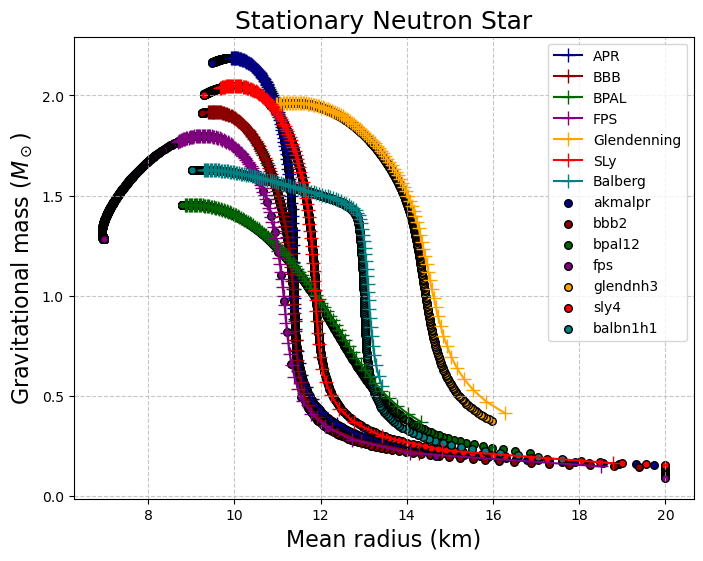

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from tqdm import tqdm
from scipy.integrate import solve_ivp
import pandas as pd
import os
import re
import csv

G = 6.6743e-8  # cm^3/g/s^2
c = 29979245800     # cm/s

# Array of EOS names
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
source_dir = '/home/sanjana/ashoka/thesis/EoS/'  # Directory containing EOS files

# Define markers and colors for different EOS
markers = ['+', '+', '+', '+', '+', '+', '+']
colors = ["navy", "darkred", "darkgreen", "purple", "orange", "red", "teal"]

eos_results = {}

# Loop over each EOS
for eos_name in eos_names:
    data = np.genfromtxt(f"{source_dir}eos_{eos_name}.txt", delimiter=None)
    baryon_density = data[:, 1]
    density = data[:, 2]
    pressure = data[:, 3]

    min_density = 2.4e14 #np.min(density) #1e14  # Lower bound on central density
    max_density = np.max(density)
    
    valid_indices = (density > 0) & (pressure > 0)
    density = density[valid_indices]
    pressure = pressure[valid_indices]
    baryon_density = baryon_density[valid_indices]
    
    log_density = np.log(density)
    log_pressure = np.log(pressure)

    log_pressure_to_log_density = CubicSpline(log_pressure, log_density, bc_type='natural')
    log_density_to_log_pressure = CubicSpline(log_density, log_pressure, bc_type='natural')

    def pressure_to_density(pressure):
        log_pressure = np.log(pressure)
        # Determine the valid range
        min_log_p, max_log_p = log_pressure_to_log_density.x[0], log_pressure_to_log_density.x[-1]
    
        # Clip values outside the interpolation range and show a warning
        if log_pressure < min_log_p or log_pressure > max_log_p:
            clipped_value = np.exp(np.clip(log_pressure, min_log_p, max_log_p))
            print(f"Warning: Extrapolation detected for pressure {pressure:.4e}, clipping to {clipped_value:.4e}.")
            log_pressure = np.clip(log_pressure, min_log_p, max_log_p)
    
        log_density = log_pressure_to_log_density(log_pressure)
        return np.exp(log_density)
    
    def density_to_pressure(density):
        log_density = np.log(density)
        # Determine the valid range
        min_log_rho, max_log_rho = log_density_to_log_pressure.x[0], log_density_to_log_pressure.x[-1]
    
        # Clip values outside the interpolation range and show a warning
        if log_density < min_log_rho or log_density > max_log_rho:
            clipped_value = np.exp(np.clip(log_density, min_log_rho, max_log_rho))
            print(f"Warning: Extrapolation detected for density {density:.4e}, clipping to {clipped_value:.4e}.")
            log_density = np.clip(log_density, min_log_rho, max_log_rho)
    
        log_pressure = log_density_to_log_pressure(log_density)
        return np.exp(log_pressure)

    # TOV equations
    def compute_derivatives(r, state_vars):
        mass, pressure = state_vars

        if pressure <= 1e-18 * density_to_pressure(min_density):  # Stop condition
            return [0, 0]

        density = pressure_to_density(pressure)
        dm_dr = 4.0 * np.pi * (r**2) * density
        dP_dr = -(((G * mass * density) / (r**2)) * (1 + (pressure / (density * c * c))) *
                  (1 + ((4 * np.pi * pressure * (r**3)) / (mass * c * c)))) / (1 - ((2 * G * mass) / (r * c * c)))
        return [dm_dr, dP_dr]

    # Stopping condition for solve_ivp
    def pressure_stop_condition(r, y):
        threshold_pressure = 1e-18 * density_to_pressure(min_density)
        #print(f"Threshold pressure: {threshold_pressure:.4e}")
        #print(f"Checking stop condition at r={r:.2f} cm: P={y[1]:.4e}, threshold={threshold_pressure:.4e}")
        return y[1] - threshold_pressure  # Stop when P < threshold

    pressure_stop_condition.terminal = True  # Stop integration
    pressure_stop_condition.direction = -1  # Stop when pressure is decreasing
    
    # Solve the neutron star structure
    def solve_neutron_star_structure(central_density, eos_type):
        initial_pressure = density_to_pressure(central_density)
        state_variables_initial = [1e-10, initial_pressure]  # Small initial mass

        sol = solve_ivp(compute_derivatives, [1e-2, 2e6], state_variables_initial, method="RK45", rtol=1e-5, atol=1e-5, events=pressure_stop_condition, dense_output=False) 

        '''
        if sol.status == 1:  # Event-triggered stop
            print(f"Stopped at r={sol.t_events[0][0]:.4f} cm due to pressure threshold.")
        else:
            print("Solve_ivp reached the maximum radius without stopping.")

        final_radius = sol.t[-1]
        final_mass = sol.y[0, -1]
        '''
        # Determine stopping radius
        if sol.status == 1 and sol.t_events[0].size > 0:  
            stopping_radius = sol.t_events[0][0]  # Stopping point due to pressure threshold
            print(f"Stopped at r={stopping_radius:.4f} cm due to pressure threshold.")
        else:
            stopping_radius = sol.t[-1]  # If not stopped by event, take last value
            print("Solve_ivp reached the maximum radius without stopping.")

        final_radius = stopping_radius  # cm
        final_mass = sol.y[0, -1]  # g
    
        return final_radius, final_mass
        
        #return final_radius, final_mass
    #'''
    '''
    def solve_neutron_star_structure(central_density, eos_type):
        initial_pressure = density_to_pressure(central_density)
        state_variables_initial = [1e-3, initial_pressure]
    
        def wrapper(r, y):
            return compute_derivatives(y, r, eos_type)
    
        # Use an implicit solver (Radau or BDF)  
        sol = solve_ivp(wrapper, [50, 2e6], state_variables_initial, method="LSODA", rtol=1e-5, atol=1e-5)
    
        radii = sol.t
        mass_profile = sol.y[0]
        pressure_profile = sol.y[1]
    
        termination_index = np.argmax(pressure_profile < 1e-10 * initial_pressure)
        if termination_index == 0:
            termination_index = -1
    
        final_radius = radii[termination_index]
        final_mass = mass_profile[termination_index]
        return final_radius, final_mass
    '''
    
    central_densities = np.linspace(min_density, max_density, 1000)
    results = np.zeros([2, len(central_densities)])

    for i in tqdm(range(len(central_densities)), desc=f"Processing {eos_name}"):
        results[:, i] = solve_neutron_star_structure(central_densities[i], eos_name)
    
    eos_results[eos_name] = (central_densities, results[0,] / 1e5, results[1,] / 1.989e33)

    radius = results[0,] / 1e5  # Convert to km
    mass = results[1,] / 1.989e33  # Convert to solar masses
    eos_results[eos_name] = (central_densities, radius, mass)

##############################################################################################

# Dictionary for pretty axis labels
units = {
    "Central enthalpy": r"Log Central enthalpy (c$^2$)",
    "Central proper baryon density": r"Log Central baryon density (g/cm$^3$)",
    "Gravitational mass": r"Gravitational mass ($M_\odot$)",
    "Mean radius": r"Mean radius (km)",
    "Moment of inertia": r"Moment of inertia (10$^{45}$ gcm$^2$)",
    "Compactness": r"Compactness (GM/Rc$^2$)"
}

# Define colors and markers for distinction
colors = ["navy", "darkred", "darkgreen", "purple", "orange", "red", "teal"]
marker_size = 10  # Reduce marker size here

#################################################################

# List of EOS files and their labels (Stationary Neutron Star)
eos_files_stationary = {
    "APR": "Nrotstar_(APR100)_(0.06-0.9)_stat_extracted_data.csv",
    "BBB": "Nrotstar_(BBB100)_(0.05-0.8)_stat_extracted_data.csv",
    "BPAL": "Nrotstar_(BPAL100)_(0.06-0.6)_stat_extracted_data.csv",
    "FPS": "Nrotstar_(FPS100)_(0.04-0.9)_stat_extracted_data.csv",
    "Glendenning": "Nrotstar_(Glendenning100)_(0.06-0.68)_stat_extracted_data.csv",
    "SLy": "Nrotstar_(SLy100)_(0.04-0.9)_stat_extracted_data.csv",
    "Balberg": "Nrotstar_(Balberg100)_(0.08-0.7)_stat_extracted_data.csv"
}

# Column pairs for plotting
columns = [
    ("Mean radius", "Gravitational mass"),
]

# Plot for stationary neutron stars
for x_col, y_col in columns:
    plt.figure(figsize=(8,6))

    for (eos, file), color, marker in zip(eos_files_stationary.items(), colors, markers):
        df = pd.read_csv(file)
        
        # Convert numeric columns properly
        for col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                pass  # Ignore non-numeric columns

        # Filter out invalid values
        df = df[(df[x_col] != "N/A") & (df[y_col] != "N/A")]
        df[x_col] = df[x_col].astype(float)
        df[y_col] = df[y_col].astype(float)

        # Plot data with reduced marker size
        plt.plot(df[x_col], df[y_col], marker=marker, linestyle="-", color=color, 
                 label=eos, markersize=marker_size)

    plt.xlabel(units.get(x_col, x_col), fontsize=16)
    plt.ylabel(units.get(y_col, y_col), fontsize=16)
    plt.title("Stationary Neutron Star", fontsize=18)
    plt.legend(title="EOS Models", fontsize=12)
    plt.grid(linestyle='--', alpha=0.7)

##############################################################################################
markers = ["o", "o", "o", "o", "o", "o", "o"]
#plt.figure()
#plt.title(r"Stationary NS Plot: Mass vs Radius")
#plt.ylabel(r"Mass of the Star [$M_\odot$]")
#plt.xlabel(r"Radius of the Star [km]")

for eos_name, (central_densities, radius, mass), marker, color in zip(eos_results.keys(), eos_results.values(), markers, colors):
    plt.scatter(radius, mass, label=f"{eos_name}", marker=marker, color=color, s=30, edgecolor="black")
plt.legend()
plt.savefig("MvsRStat_Comparison_full.pdf")
plt.show()

In [4]:
!pip install sympy
import numpy as np
from scipy.interpolate import CubicSpline
import sympy as sp

# Step 1: Define the data
x_data = np.array([0, 1, 2, 3])
y_data = np.array([1, 2, 0, 2])

# Step 2: Fit the cubic spline
cs = CubicSpline(x_data, y_data)

# Step 3: Define the symbolic variable
x = sp.Symbol('x')

# Step 4: Build symbolic expressions for each interval
expressions = []
for i in range(len(x_data) - 1):
    x0 = x_data[i]
    coeffs = cs.c[:, i]  # Coefficients [c0, c1, c2, c3] for interval [x0, x1]

    # Build the polynomial S(x) = c0*(x - x0)^3 + c1*(x - x0)^2 + c2*(x - x0) + c3
    expr = (
        coeffs[0] * (x - x0)**3 +
        coeffs[1] * (x - x0)**2 +
        coeffs[2] * (x - x0) +
        coeffs[3]
    )
    expressions.append((f"[{x0}, {x_data[i+1]}]", sp.simplify(expr)))

# Step 5: Print the expressions
for interval, expr in expressions:
    print(f"S(x) for interval {interval}:")
    print(expr)
    print()

  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 17.6 MB/s eta 0:00:00m eta 0:00:010:00:01
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
S(x) for interval [0, 1]:
1.16666666666667*x**3 - 5.0*x**2 + 4.83333333333333*x + 1.0

S(x) for interval [1, 2]:
1.16666666666667*x**3 - 5.0*x**2 + 4.83333333333333*x + 1.0

S(x) for interval [2, 3]:
1.16666666666667*x**3 - 5.0*x**2 + 4.83333333333333*x + 1.00000000000001

